## NA

In [ ]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 1/60
duration = 1500
m2m = 1/2.2369
v18na = np.loadtxt('na_speed_18mph.txt')
a18na = np.diff(v18na)/0.1
a18na = np.append(0,a18na)
for i in range(len(a18na)):
    if a18na[i]>5:
        a18na[i] = 5
    elif a18na[i]<-6:
        a18na[i] = -6
        
#plt.plot(a18na)
v18new = np.zeros(a18na.shape)
v18new[0] = v18na[0]
for i in range(1,len(v18new)):
    v18new[i] = v18new[i-1] + 0.1*a18na[i]*1.3
v18new = v18new/m2m-13.2
for i in range(1,len(v18new)):
    if v18new[i]<0:
        v18new[i] = 0
v0 = v18new

x = np.linspace(0, v0.shape[0], v0.shape[0])
x1 = np.linspace(0, v0.shape[0], v0.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v0)
v01 = vinterp(x1)
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2 = 5, 5, 2

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2

lead_v = v01
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))


def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

#SS
s0=2.5
a0=1
b0=2
T=2.6
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)


#SU
h = 1
ks, kv, ka = 5, 5, 2
dis = spd*h + 3
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(200), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]
y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
traci.simulationStep()

def dis_ego(vID_tmp):
	posi = traci.vehicle.getPosition(vID_tmp)
	dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
	return dis
	
while step<=max_iter:
	
	data, address = serverSock.recvfrom(1024*6)
	data = data.decode('utf-8').split("$")[0]
	y, x, z, vx, vy = data.split(";")
	#x, y = '6448.97', '-6645.57'
	X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
	x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
	vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
	eEdge = traci.vehicle.getRoadID('ego')
	ePos = traci.vehicle.getPosition('ego')
	traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
	#traci.vehicle.setSpeed('ego', 0.0)
	eLanePos = traci.vehicle.getLanePosition('ego')
	#pint(eLanePos)
	pos_ego[step] = eLanePos
	vel_ego[step] = np.sqrt(vx**2+vy**2) 

	if step==0:
		#eLanePos = 10
		for i in range(N_VEHICLES):
			if i < N_lane_0:
				position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
				speed[0, i] = spd
				accel[0, i] = 0
				
				vid = "%d" % i
				traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
				traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
				traci.vehicle.setLaneChangeMode(vid, 256)
			elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
				position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 10 - dis*N_lane_1//2
				speed[0, i] = spd
				accel[0, i] = 0
				
				vid = "%d" % i
				traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
				traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
				traci.vehicle.setLaneChangeMode(vid, 256)
			
			else:
				position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
				speed[0, i] = spd
				accel[0, i] = 0
				
				vid = "%d" % i
				traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
				traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
				traci.vehicle.setLaneChangeMode(vid, 256)
			
			traci.gui.trackVehicle("View #0", "%d" % i)
			traci.gui.setZoom("View #0", 3000)
			
	elif step>=1:
		if True:
			for i in range(N_VEHICLES):
				if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:
					#traci.vehicle.setSpeed("v.%d" % i, lead_v[step//10])
					traci.vehicle.setSpeed("%d" % i, speed[step,i] + lead_a[step//1]*dt)
					if lead_a[step//1]<0:
						traci.vehicle.setSignals("%d" % i, 3)
				else:
					if i < N_lane_0:
						#space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
						space = position[step,i-1] - position[step,i]
						#v = traci.vehicle.getSpeed("v.%d" % i)
						v = speed[step,i]
						#rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
						rel_v = speed[step,i-1] - speed[step,i]
						#rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
						rel_acc = accel[step,i-1] - accel[step,i]
						#acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
						acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)                        
					elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
						space = position[step,i-1] - position[step,i]
						v = speed[step,i]
						rel_v = speed[step,i-1] - speed[step,i]
						rel_acc = accel[step,i-1] - accel[step,i]
						#acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
						acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
					else:
						space = position[step,i-1] - position[step,i]
						v = speed[step,i]
						rel_v = speed[step,i-1] - speed[step,i]
						rel_acc = accel[step,i-1] - accel[step,i]
						#acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
						acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
					traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
					drag_decel = -0.3   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
					if traci.vehicle.getAcceleration("%d" % i) < drag_decel:
						light[step,i] = 3
						traci.vehicle.setSignals("%d" % i, 3)
					else:
						light[step,i] = 0                            
						traci.vehicle.setSignals("%d" % i, 0)
					if i==N_VEHICLES-1:
						print(step, light[step,i], traci.vehicle.getSignals("%d" % i), traci.vehicle.getAcceleration("%d" % i), traci.vehicle.getSpeed("%d" % i))
	#print(traci.vehicle.getPosition('ego'))
	#print(traci.vehicle.getLanePosition('ego'))
	#print(step, traci.vehicle.getSignals("%d" % 21), )
	Message=''
	Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
	for k in range(N_VEHICLES):
		vID = str(k)
		
		Position = traci.vehicle.getPosition(vID)
		sig = int(light[step,k])      #sig = traci.vehicle.getSignals(vID)
		vel = traci.vehicle.getSpeed(vID)

		#if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
		#		continue
		Message += str(vID)+","

		#xx = "{0:.3f}".format(position[0]-x) 
		xx = "{0:.3f}".format(Position[0]-X_offset) 

		#yy = "{0:.3f}".format(position[1]-y) 
		yy = "{0:.3f}".format(Position[1]-Y_offset) 

		Message += xx + "," + yy +","
		#print(vID,Position[0],Position[1])
		#print(vID,xx,yy)
		angle = traci.vehicle.getAngle(vID)
		angle = "{0:.3f}".format(angle) 
		Message += angle + ","
		
		Message +=  str(sig) + "," + str(vel) + ","

	Message = Message[:-1]
	#print(repr(Message))
	serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
	step += 1
	
	for i in range(N_VEHICLES):
		position[step,i] = traci.vehicle.getLanePosition("%d" % i)
		speed[step,i] = traci.vehicle.getSpeed("%d" % i)
		accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
		#light[step,i] = traci.vehicle.getSignals("%d" % i)

	#print(step-1, light[step-1,11], traci.vehicle.getSignals("%d" % 11), traci.vehicle.getAcceleration("%d" % 11), traci.vehicle.getSpeed("%d" % 11))
	#print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
	traci.simulationStep()
	if step >= max_iter-1:
		np.savetxt('./run_pos_na_cong_su.txt', position)
		np.savetxt('./run_vel_cong_su.txt', speed)
		np.savetxt('./run_accel_cong_su.txt', accel)
		break

traci.close()

1 0.0 0 -1073741824.0 -1073741824.0
1 0.0 0 0.0 2.9674184399999994
2 0.0 0 0.0 2.9674184399999994
2 3.0 3 -9.999999999999995 2.7974184399999995
3 3.0 3 -9.999999999999995 2.7974184399999995
3 3.0 3 -9.999999999999995 2.6274184399999996
4 3.0 3 -9.999999999999995 2.6274184399999996
4 3.0 3 -9.999999999999995 2.4574184399999996
5 3.0 3 -9.999999999999995 2.4574184399999996
5 3.0 3 -9.999999999999995 2.2874184399999997
6 3.0 3 -9.999999999999995 2.2874184399999997
6 3.0 3 -5.5192176727392575 2.1935917395634323
7 3.0 3 -5.5192176727392575 2.1935917395634323
7 0.0 0 2.828680344336972 2.241679305417161
8 0.0 0 2.828680344336972 2.241679305417161
8 3.0 3 -1.4682909691854242 2.2167183589410087
9 3.0 3 -1.4682909691854242 2.2167183589410087
9 0.0 0 1.3143158573245288 2.2390617285155257
10 0.0 0 1.3143158573245288 2.2390617285155257
10 0.0 0 0.015838216484751737 2.2393309781957664
11 0.0 0 0.015838216484751737 2.2393309781957664
11 0.0 0 2.7777814917126267 2.286553263554881
12 0.0 0 2.7777814917

24 0.0 0 2.6558721143543886 2.406666076910132
24 3.0 3 -1.5815757313923797 2.3797792894764616
25 3.0 3 -1.5815757313923797 2.3797792894764616
25 0.0 0 1.1248905469377688 2.3989024287744036
26 0.0 0 1.1248905469377688 2.3989024287744036
26 0.0 0 -0.0736488637560484 2.397650398090551
27 0.0 0 -0.0736488637560484 2.397650398090551
27 0.0 0 2.611754266157451 2.4420502206152275
28 0.0 0 2.611754266157451 2.4420502206152275
28 3.0 3 -1.609979150740864 2.414680575052633
29 3.0 3 -1.609979150740864 2.414680575052633
29 0.0 0 1.1046806885067435 2.4334601467572474
30 0.0 0 1.1046806885067435 2.4334601467572474
30 0.0 0 -0.10972310388864226 2.4315948539911405
31 0.0 0 -0.10972310388864226 2.4315948539911405
31 0.0 0 2.584335481071927 2.4755285571693633
32 0.0 0 2.584335481071927 2.4755285571693633
32 3.0 3 -1.6370214258492837 2.4476991929299254
33 3.0 3 -1.6370214258492837 2.4476991929299254
33 0.0 0 1.0576439923309855 2.465679140799552
34 0.0 0 1.0576439923309855 2.465679140799552
34 0.0 0 -0.11

58 0.0 0 0.8751615164692432 2.6258413621770584
58 3.0 3 -0.20337407976074173 2.622384002821126
59 3.0 3 -0.20337407976074173 2.622384002821126
59 0.0 0 2.397305320069353 2.663138193262305
60 0.0 0 2.397305320069353 2.663138193262305
60 3.0 3 -1.7643363834912782 2.633144474742953
61 3.0 3 -1.7643363834912782 2.633144474742953
61 0.0 0 0.844701632180357 2.647504402490019
62 0.0 0 0.844701632180357 2.647504402490019
62 3.0 3 -0.20784957303839302 2.6439709597483665
63 3.0 3 -0.20784957303839302 2.6439709597483665
63 0.0 0 2.3801045576008484 2.684432737227581
64 0.0 0 2.3801045576008484 2.684432737227581
64 3.0 3 -1.7813041476127356 2.6541505667181644
65 3.0 3 -1.7813041476127356 2.6541505667181644
65 0.0 0 0.8158549967221246 2.6680201016624405
66 0.0 0 0.8158549967221246 2.6680201016624405
66 3.0 3 -0.21208803008803906 2.664414605150944
67 3.0 3 -0.21208803008803906 2.664414605150944
67 0.0 0 2.363814800358345 2.7045994567570357
68 0.0 0 2.363814800358345 2.7045994567570357
68 3.0 3 -1.797

91 0.0 0 2.252630025747049 2.8039514972677617
92 0.0 0 2.252630025747049 2.8039514972677617
92 3.0 3 -1.8514586990958908 2.7724766993831316
93 3.0 3 -1.8514586990958908 2.7724766993831316
93 0.0 0 0.6965178474464703 2.7843175027897216
94 0.0 0 0.6965178474464703 2.7843175027897216
94 3.0 3 -0.28527255707199617 2.7794678693194976
95 3.0 3 -0.28527255707199617 2.7794678693194976
95 0.0 0 2.241772256511944 2.8175779976802007
96 0.0 0 2.241772256511944 2.8175779976802007
96 3.0 3 -1.8621713566511733 2.7859210846171307
97 3.0 3 -1.8621713566511733 2.7859210846171307
97 0.0 0 0.678756803466505 2.7974599502760613
98 0.0 0 0.678756803466505 2.7974599502760613
98 3.0 3 -0.28841311108920686 2.792556927387545
99 3.0 3 -0.28841311108920686 2.792556927387545
99 0.0 0 2.2314821164465193 2.8304921233671356
100 0.0 0 2.2314821164465193 2.8304921233671356
100 3.0 3 -1.8723239712252628 2.798662615856306
101 3.0 3 -1.8723239712252628 2.798662615856306
101 0.0 0 0.6619242826902503 2.8099153286620404
102 0

115 3.0 3 -0.2994171019874556 2.8384188579289367
115 0.0 0 2.195427139620248 2.875741119302481
116 0.0 0 2.195427139620248 2.875741119302481
116 3.0 3 -1.9078970812376064 2.8433068689214416
117 3.0 3 -1.9078970812376064 2.8433068689214416
117 0.0 0 0.6029458670098187 2.8535569486606085
118 0.0 0 0.6029458670098187 2.8535569486606085
118 3.0 3 -0.30181819880025673 2.848426039281004
119 3.0 3 -0.30181819880025673 2.848426039281004
119 0.0 0 2.1875598586992218 2.885614556878891
120 0.0 0 2.1875598586992218 2.885614556878891
120 3.0 3 -1.9156592176901543 2.8530483501781583
121 3.0 3 -1.9156592176901543 2.8530483501781583
121 0.0 0 0.5900766376492975 2.8630796530181963
122 0.0 0 0.5900766376492975 2.8630796530181963
122 3.0 3 -0.3040937694760437 2.8579100589371036
123 3.0 3 -0.3040937694760437 2.8579100589371036
123 0.0 0 2.1762467507207788 2.894906253699357
124 0.0 0 2.1762467507207788 2.894906253699357
124 3.0 3 -1.9191068931069972 2.862281436516538
125 3.0 3 -1.9191068931069972 2.8622814

150 3.0 3 -0.3552326374607862 2.911502508325475
151 3.0 3 -0.3552326374607862 2.911502508325475
151 0.0 0 2.1097747643134053 2.947368679318803
152 0.0 0 2.1097747643134053 2.947368679318803
152 3.0 3 -1.9383030623014457 2.9144175272596784
153 3.0 3 -1.9383030623014457 2.9144175272596784
153 0.0 0 0.5444973650331801 2.9236739824652425
154 0.0 0 0.5444973650331801 2.9236739824652425
154 3.0 3 -0.3569048888150389 2.917606599355387
155 3.0 3 -0.3569048888150389 2.917606599355387
155 0.0 0 2.105039239856577 2.9533922664329486
156 0.0 0 2.105039239856577 2.9533922664329486
156 3.0 3 -1.9429761322431458 2.920361672184815
157 3.0 3 -1.9429761322431458 2.920361672184815
157 0.0 0 0.5369598387147841 2.9294899894429665
158 0.0 0 0.5369598387147841 2.9294899894429665
158 3.0 3 -0.3584908317795493 2.923395645302714
159 3.0 3 -0.3584908317795493 2.923395645302714
159 0.0 0 2.100548125882869 2.959104963442723
160 0.0 0 2.100548125882869 2.959104963442723
160 3.0 3 -1.9474080150475515 2.92599902718691

184 3.0 3 -1.9695883184359466 2.9542123730124468
185 3.0 3 -1.9695883184359466 2.9542123730124468
185 0.0 0 0.49403515364562284 2.9626109706244224
186 0.0 0 0.49403515364562284 2.9626109706244224
186 3.0 3 -0.36752245553738805 2.9563630888802868
187 3.0 3 -0.36752245553738805 2.9563630888802868
187 0.0 0 2.0749721417421263 2.991637615289903
188 0.0 0 2.0749721417421263 2.991637615289903
188 3.0 3 -1.9726466899205088 2.9581026215612543
189 3.0 3 -1.9726466899205088 2.9581026215612543
189 0.0 0 0.4891020889318841 2.9664173570730963
190 0.0 0 0.4891020889318841 2.9664173570730963
190 3.0 3 -0.3685604032150771 2.96015183021844
191 3.0 3 -0.3685604032150771 2.96015183021844
191 0.0 0 2.0720328544210873 2.9953763887435985
192 0.0 0 2.0720328544210873 2.9953763887435985
192 3.0 3 -1.975547212338626 2.961792086133842
193 3.0 3 -1.975547212338626 2.961792086133842
193 0.0 0 0.484423630247503 2.9700272878480494
194 0.0 0 0.484423630247503 2.9700272878480494
194 3.0 3 -0.36954478028915294 2.96374

207 0.0 0 2.0617164363040854 3.0084988725621793
208 0.0 0 2.0617164363040854 3.0084988725621793
208 3.0 3 -1.9857275722396666 2.974741503834105
209 3.0 3 -1.9857275722396666 2.974741503834105
209 0.0 0 0.46800300497833586 2.9826975549187367
210 0.0 0 0.46800300497833586 2.9826975549187367
210 3.0 3 -0.3729997832282711 2.976356558603856
211 3.0 3 -0.3729997832282711 2.976356558603856
211 0.0 0 2.0594613040766436 3.011367400773159
212 0.0 0 2.0594613040766436 3.011367400773159
212 3.0 3 -1.9879529626248378 2.9775722004085368
213 3.0 3 -1.9879529626248378 2.9775722004085368
213 0.0 0 0.46441351474319914 2.985467230159171
214 0.0 0 0.46441351474319914 2.985467230159171
214 3.0 3 -0.3737550345588967 2.97911339457167
215 3.0 3 -0.3737550345588967 2.97911339457167
215 0.0 0 2.057322564011359 3.014087878159863
216 0.0 0 2.057322564011359 3.014087878159863
216 3.0 3 -1.990063495861433 2.9802567987302186
217 3.0 3 -1.990063495861433 2.9802567987302186
217 0.0 0 0.46100928567271987 2.988093956586

241 3.0 3 -2.000626109915066 2.993692443789152
241 0.0 0 0.4439720954295482 3.001239969411454
242 0.0 0 0.4439720954295482 3.001239969411454
242 3.0 3 -0.37805603771741003 2.9948130167702582
243 3.0 3 -0.37805603771741003 2.9948130167702582
243 0.0 0 2.0451428726115024 3.029580445604654
244 0.0 0 2.0451428726115024 3.029580445604654
244 3.0 3 -2.00208255513194 2.995545042167411
245 3.0 3 -2.00208255513194 2.995545042167411
245 0.0 0 0.44162289132018856 3.003052631319854
246 0.0 0 0.44162289132018856 3.003052631319854
246 3.0 3 -0.37855032494330465 2.996617275795818
247 3.0 3 -0.37855032494330465 2.996617275795818
247 0.0 0 2.0437431371472865 3.0313609091273217
248 0.0 0 2.0437431371472865 3.0313609091273217
248 3.0 3 -2.0034638301737884 2.9973020240143673
249 3.0 3 -2.0034638301737884 2.9973020240143673
249 0.0 0 0.4393949347006549 3.0047717379042784
250 0.0 0 0.4393949347006549 3.0047717379042784
250 3.0 3 -0.3790191010073887 2.998328413187153
251 3.0 3 -0.3790191010073887 2.998328413

274 0.0 0 0.42824465064317246 3.0133753735747373
274 3.0 3 -0.3813651910472494 3.006892165326934
275 3.0 3 -0.3813651910472494 3.006892165326934
275 0.0 0 2.0357719272178807 3.041500288089638
276 0.0 0 2.0357719272178807 3.041500288089638
276 3.0 3 -2.011329911596928 3.0073076795924902
277 3.0 3 -2.011329911596928 3.0073076795924902
277 0.0 0 0.4267071734146356 3.014561701540539
278 0.0 0 0.4267071734146356 3.014561701540539
278 3.0 3 -0.3816886859094151 3.008072993880079
279 3.0 3 -0.3816886859094151 3.008072993880079
279 0.0 0 2.034855846119242 3.042665543264106
280 0.0 0 2.034855846119242 3.042665543264106
280 3.0 3 -2.0122339109800436 3.0084575667774454
281 3.0 3 -2.0122339109800436 3.0084575667774454
281 0.0 0 0.42524904864051 3.015686800604334
282 0.0 0 0.42524904864051 3.015686800604334
282 3.0 3 -0.3819954844759668 3.0091928773682426
283 3.0 3 -0.3819954844759668 3.0091928773682426
283 0.0 0 2.0339870458786034 3.043770657148179
284 0.0 0 2.0339870458786034 3.043770657148179
284

298 0.0 0 0.4201312690056348 3.019635714453791
298 3.0 3 -0.3830722975351834 3.0131234853956927
299 3.0 3 -0.3830722975351834 3.0131234853956927
299 0.0 0 2.0309376991149333 3.0476494262806466
300 0.0 0 2.0309376991149333 3.0476494262806466
300 3.0 3 -2.0161003834281366 3.0133757197623683
301 3.0 3 -2.0161003834281366 3.0133757197623683
301 0.0 0 0.4190125405308093 3.020498932951392
302 0.0 0 0.4190125405308093 3.020498932951392
302 3.0 3 -0.38330768493772027 3.013982702307451
303 3.0 3 -0.38330768493772027 3.013982702307451
303 0.0 0 2.0302711227986716 3.048497311395028
304 0.0 0 2.0302711227986716 3.048497311395028
304 3.0 3 -2.016758168695542 3.014212422527204
305 3.0 3 -2.016758168695542 3.014212422527204
305 0.0 0 0.4179515520806407 3.021317598912575
306 0.0 0 0.4179515520806407 3.021317598912575
306 3.0 3 -0.38353092359283736 3.0147975732114967
307 3.0 3 -0.38353092359283736 3.0147975732114967
307 0.0 0 2.0296389498118765 3.0493014353582986
308 0.0 0 2.0296389498118765 3.04930143

331 3.0 3 -0.3846481691037152 3.018875768500335
331 0.0 0 2.026475105580203 3.0533258452951983
332 0.0 0 2.026475105580203 3.0533258452951983
332 3.0 3 -2.0205041219931066 3.0189772752213155
333 3.0 3 -2.0205041219931066 3.0189772752213155
333 0.0 0 0.41190943777897104 3.025979735663558
334 0.0 0 0.41190943777897104 3.025979735663558
334 3.0 3 -0.3848022224148425 3.0194380978825057
335 3.0 3 -0.3848022224148425 3.0194380978825057
335 0.0 0 2.0260388531006237 3.0538807583852163
336 0.0 0 2.0260388531006237 3.0538807583852163
336 3.0 3 -2.0209346209111625 3.0195248698297266
337 3.0 3 -2.0209346209111625 3.0195248698297266
337 0.0 0 0.4112150556285776 3.0265155257754124
338 0.0 0 0.4112150556285776 3.0265155257754124
338 3.0 3 -0.3849483248507959 3.019971404252949
339 3.0 3 -0.3849483248507959 3.019971404252949
339 0.0 0 2.0256251166434773 3.054407031235888
340 0.0 0 2.0256251166434773 3.054407031235888
340 3.0 3 -2.0213429008981314 3.0200442019206197
341 3.0 3 -2.0213429008981314 3.02004

366 0.0 0 0.40726068930869586 3.0295667418829617
366 3.0 3 -0.38578034836637065 3.0230084759607334
367 3.0 3 -0.38578034836637065 3.0230084759607334
367 0.0 0 2.023268970944749 3.057404048466794
368 0.0 0 2.023268970944749 3.057404048466794
368 3.0 3 -2.0236679724504927 3.0230016929351358
369 3.0 3 -2.0236679724504927 3.0230016929351358
369 0.0 0 0.4068062389427558 3.0299173989971626
370 0.0 0 0.4068062389427558 3.0299173989971626
370 3.0 3 -0.38587596768429827 3.0233575075465295
371 3.0 3 -0.38587596768429827 3.0233575075465295
371 0.0 0 2.0229981939558397 3.057748476843779
372 0.0 0 2.0229981939558397 3.057748476843779
372 3.0 3 -2.0239351782833515 3.023341578812962
373 3.0 3 -2.0239351782833515 3.023341578812962
373 0.0 0 0.4063752434918456 3.030249957952323
374 0.0 0 0.4063752434918456 3.030249957952323
374 3.0 3 -0.38596665172034333 3.0236885248730774
375 3.0 3 -0.38596665172034333 3.0236885248730774
375 0.0 0 2.0227413922974438 3.058075128542134
376 0.0 0 2.0227413922974438 3.058

389 3.0 3 -2.0248730272388666 3.024534522696344
389 0.0 0 0.40486252021095853 3.0314171855399303
390 0.0 0 0.40486252021095853 3.0314171855399303
390 3.0 3 -0.3862849381314008 3.0248503415916965
391 3.0 3 -0.3862849381314008 3.0248503415916965
391 0.0 0 2.0218400605108773 3.0592216226203814
392 0.0 0 2.0218400605108773 3.0592216226203814
392 3.0 3 -2.025078037712562 3.024795295979268
393 3.0 3 -2.025078037712562 3.024795295979268
393 0.0 0 0.40453184435315154 3.0316723373332715
394 0.0 0 0.40453184435315154 3.0316723373332715
394 3.0 3 -0.38635451440197577 3.025104310588438
395 3.0 3 -0.38635451440197577 3.025104310588438
395 0.0 0 2.021643032572547 3.059472242142171
396 0.0 0 2.021643032572547 3.059472242142171
396 3.0 3 -2.025272467118314 3.02504261020116
397 3.0 3 -2.025272467118314 3.02504261020116
397 0.0 0 0.40421823534602236 3.031914320202042
398 0.0 0 0.40421823534602236 3.031914320202042
398 3.0 3 -0.38642049983676513 3.025345171704817
399 3.0 3 -0.38642049983676513 3.02534517

424 0.0 0 2.0198323405357423 3.0608877212155865
424 3.0 3 -2.0256818991715164 3.0264511289296707
425 3.0 3 -2.0256818991715164 3.0264511289296707
425 0.0 0 0.4032007032273544 3.0333055408845357
426 0.0 0 0.4032007032273544 3.0333055408845357
426 3.0 3 -0.38757499206041585 3.0267167660195087
427 3.0 3 -0.38757499206041585 3.0267167660195087
427 0.0 0 2.0195778311675476 3.061049589149357
428 0.0 0 2.0195778311675476 3.061049589149357
428 3.0 3 -2.0256818991515844 3.02661299686378
429 3.0 3 -2.0256818991515844 3.02661299686378
429 0.0 0 0.4031355838290363 3.0334663017888737
430 0.0 0 0.4031355838290363 3.0334663017888737
430 3.0 3 -0.3877601665337133 3.0268743789578005
431 3.0 3 -0.3877601665337133 3.0268743789578005
431 0.0 0 2.0193364637026567 3.0612030988407457
432 0.0 0 2.0193364637026567 3.0612030988407457
432 3.0 3 -2.0256818991208116 3.026766506555692
433 3.0 3 -2.0256818991208116 3.026766506555692
433 0.0 0 0.40307382691617166 3.033618761613267
434 0.0 0 0.40307382691617166 3.0336

459 3.0 3 -0.38881459605636315 3.027771866423029
459 0.0 0 2.0179620571858514 3.0620772213951883
460 0.0 0 2.0179620571858514 3.0620772213951883
460 3.0 3 -2.0256818991824095 3.0276406291090874
461 3.0 3 -2.0256818991824095 3.0276406291090874
461 0.0 0 0.40272216751287526 3.0344869059568063
462 0.0 0 0.40272216751287526 3.0344869059568063
462 3.0 3 -0.3889357621834817 3.027874997999687
463 3.0 3 -0.3889357621834817 3.027874997999687
463 0.0 0 2.0178041221629877 3.062177668076458
464 0.0 0 2.0178041221629877 3.062177668076458
464 3.0 3 -2.0256818991409524 3.0277410757910617
465 3.0 3 -2.0256818991409524 3.0277410757910617
465 0.0 0 0.40268175776391646 3.0345866656730482
466 0.0 0 0.40268175776391646 3.0345866656730482
466 3.0 3 -0.389050671534379 3.027972804256964
467 3.0 3 -0.389050671534379 3.027972804256964
467 0.0 0 2.017654342330294 3.062272928076579
468 0.0 0 2.017654342330294 3.062272928076579
468 3.0 3 -2.025681899177394 3.027836335790563
469 3.0 3 -2.025681899177394 3.027836335

481 3.0 3 -2.025681899141266 3.0280936054599983
481 0.0 0 0.40253993501400653 3.0349367843552364
482 0.0 0 0.40253993501400653 3.0349367843552364
482 3.0 3 -0.3894539600557803 3.028316067034288
483 3.0 3 -0.3894539600557803 3.028316067034288
483 0.0 0 2.017128671923169 3.062607254456982
484 0.0 0 2.017128671923169 3.062607254456982
484 3.0 3 -2.025681899109866 3.0281706621721143
485 3.0 3 -2.025681899109866 3.0281706621721143
485 0.0 0 0.40250893508604857 3.035013314068577
486 0.0 0 0.40250893508604857 3.035013314068577
486 3.0 3 -0.38954211177817255 3.028391098168348
487 3.0 3 -0.38954211177817255 3.028391098168348
487 0.0 0 2.0170137696973436 3.062680332253203
488 0.0 0 2.0170137696973436 3.062680332253203
488 3.0 3 -2.0256818991898546 3.0282437399669755
489 3.0 3 -2.0256818991898546 3.0282437399669755
489 0.0 0 0.40247953602615616 3.03508589207942
490 0.0 0 0.40247953602615616 3.03508589207942
490 3.0 3 -0.38962571177994343 3.028462254979161
491 3.0 3 -0.38962571177994343 3.02846225

514 3.0 3 -0.390044069600774 3.0288183441930414
515 3.0 3 -0.390044069600774 3.0288183441930414
515 0.0 0 2.0163594878636646 3.0630964554867237
516 0.0 0 2.0163594878636646 3.0630964554867237
516 3.0 3 -2.0256818991203156 3.0286598632016783
517 3.0 3 -2.0256818991203156 3.0286598632016783
517 0.0 0 0.40231212966232605 3.035499169405938
518 0.0 0 0.40231212966232605 3.035499169405938
518 3.0 3 -0.3901017502767481 3.028867439651233
519 3.0 3 -0.3901017502767481 3.028867439651233
519 0.0 0 2.0162843033726916 3.063144272808569
520 0.0 0 2.0162843033726916 3.063144272808569
520 3.0 3 -2.0256818991649856 3.028707680522764
521 3.0 3 -2.0256818991649856 3.028707680522764
521 0.0 0 0.4022928928421892 3.0355466597010814
522 0.0 0 0.4022928928421892 3.0355466597010814
522 3.0 3 -0.3901564526822031 3.028914000005484
523 3.0 3 -0.3901564526822031 3.028914000005484
523 0.0 0 2.016213001148358 3.063189621025006
524 0.0 0 2.016213001148358 3.063189621025006
524 3.0 3 -2.025681899117207 3.0287530287400

548 0.0 0 2.015856184258258 3.06341655658167
548 3.0 3 -2.025681899166318 3.0289799642958424
549 3.0 3 -2.025681899166318 3.0289799642958424
549 0.0 0 0.4021833530546219 3.035817081297771
550 0.0 0 0.4021833530546219 3.035817081297771
550 3.0 3 -0.39046794116421735 3.0291791262979793
551 3.0 3 -0.39046794116421735 3.0291791262979793
551 0.0 0 2.015806988469926 3.063447845101968
552 0.0 0 2.015806988469926 3.063447845101968
552 3.0 3 -2.0256818991844994 3.0290112528158315
553 3.0 3 -2.0256818991844994 3.0290112528158315
553 0.0 0 0.40217076570518456 3.0358481558328196
554 0.0 0 0.40217076570518456 3.0358481558328196
554 3.0 3 -0.39050373479904466 3.029209592341236
555 3.0 3 -0.39050373479904466 3.029209592341236
555 0.0 0 2.015760332970096 3.0634775180017275
556 0.0 0 2.015760332970096 3.0634775180017275
556 3.0 3 -2.025681899148345 3.0290409257162056
557 3.0 3 -2.025681899148345 3.0290409257162056
557 0.0 0 0.4021588282621505 3.035877625796662
558 0.0 0 0.4021588282621505 3.03587762579

570 0.0 0 0.40212658878011226 3.035957215639116
570 3.0 3 -0.3906293565876762 3.0293165165771256
571 3.0 3 -0.3906293565876762 3.0293165165771256
571 0.0 0 2.0155965898621084 3.0635816586047815
572 0.0 0 2.0155965898621084 3.0635816586047815
572 3.0 3 -2.0256818991206287 3.029145066319731
573 3.0 3 -2.0256818991206287 3.029145066319731
573 0.0 0 0.4021169325237948 3.0359810541726353
574 0.0 0 0.4021169325237948 3.0359810541726353
574 3.0 3 -0.3906568153354746 3.0293398883119322
575 3.0 3 -0.3906568153354746 3.0293398883119322
575 0.0 0 2.015560798595165 3.06360442188805
576 0.0 0 2.015560798595165 3.06360442188805
576 3.0 3 -2.0256818991866674 3.0291678296018767
577 3.0 3 -2.0256818991866674 3.0291678296018767
577 0.0 0 0.402107774800248 3.036003661773481
578 0.0 0 0.402107774800248 3.036003661773481
578 3.0 3 -0.3906828561733528 3.029362053218534
579 3.0 3 -0.3906828561733528 3.029362053218534
579 0.0 0 2.0155268553888015 3.0636260097601435
580 0.0 0 2.0155268553888015 3.0636260097601

604 0.0 0 2.0153569938211144 3.063734041701044
604 3.0 3 -2.02568189917183 3.029297449415123
605 3.0 3 -2.02568189917183 3.029297449415123
605 0.0 0 0.40205562881927687 3.0361323951050507
606 0.0 0 0.40205562881927687 3.0361323951050507
606 3.0 3 -0.3908311392831438 3.0294882657372373
607 3.0 3 -0.3908311392831438 3.0294882657372373
607 0.0 0 2.0153335743593717 3.0637489365013466
608 0.0 0 2.0153335743593717 3.0637489365013466
608 3.0 3 -2.0256818991260364 3.029312344216204
609 3.0 3 -2.0256818991260364 3.029312344216204
609 0.0 0 0.40204963653174797 3.0361471880372437
610 0.0 0 0.40204963653174797 3.0361471880372437
610 3.0 3 -0.3908481785906774 3.029502769001202
611 3.0 3 -0.3908481785906774 3.029502769001202
611 0.0 0 2.0153113640978986 3.0637630621908665
612 0.0 0 2.0153113640978986 3.0637630621908665
612 3.0 3 -2.0256818991626346 3.0293264699051017
613 3.0 3 -2.0256818991626346 3.0293264699051017
613 0.0 0 0.4020439539141035 3.0361612171216414
614 0.0 0 0.4020439539141035 3.036161

638 3.0 3 -0.390945205349331 3.029585354207748
639 3.0 3 -0.390945205349331 3.029585354207748
639 0.0 0 2.0151848937139554 3.0638434974008852
640 0.0 0 2.0151848937139554 3.0638434974008852
640 3.0 3 -2.025681899136564 3.0294069051155637
641 3.0 3 -2.025681899136564 3.0294069051155637
641 0.0 0 0.4020115946714978 3.036241102224979
642 0.0 0 0.4020115946714978 3.036241102224979
642 3.0 3 -0.39095635474057133 3.0295948441943894
643 3.0 3 -0.39095635474057133 3.0295948441943894
643 0.0 0 2.015170360807835 3.0638527403281226
644 0.0 0 2.015170360807835 3.0638527403281226
644 3.0 3 -2.0256818991364853 3.0294161480428023
645 3.0 3 -2.0256818991364853 3.0294161480428023
645 0.0 0 0.402007876245852 3.036250281938982
646 0.0 0 0.402007876245852 3.036250281938982
646 3.0 3 -0.39096692857613013 3.0296038441531876
647 3.0 3 -0.39096692857613013 3.0296038441531876
647 0.0 0 2.0151565782677587 3.0638615059837395
648 0.0 0 2.0151565782677587 3.0638615059837395
648 3.0 3 -2.0256818991786476 3.02942491

662 3.0 3 -0.3910040387214659 3.0296354305796127
663 3.0 3 -0.3910040387214659 3.0296354305796127
663 0.0 0 2.0151082070147424 3.0638922700988633
664 0.0 0 2.0151082070147424 3.0638922700988633
664 3.0 3 -2.025681899114751 3.0294556778139126
665 3.0 3 -2.025681899114751 3.0294556778139126
665 0.0 0 0.40199197353154315 3.036289541363949
666 0.0 0 0.40199197353154315 3.036289541363949
666 3.0 3 -0.39101215014810736 3.029642334811431
667 3.0 3 -0.39101215014810736 3.029642334811431
667 0.0 0 2.0150976339109383 3.063898994587917
668 0.0 0 2.0150976339109383 3.063898994587917
668 3.0 3 -2.025681899109945 3.029462402303048
669 3.0 3 -2.025681899109945 3.029462402303048
669 0.0 0 0.4019892682812188 3.0362962198638286
670 0.0 0 0.4019892682812188 3.0362962198638286
670 3.0 3 -0.3910198428465072 3.029648882535438
671 3.0 3 -0.3910198428465072 3.029648882535438
671 0.0 0 2.0150876067716887 3.0639053718505567
672 0.0 0 2.0150876067716887 3.0639053718505567
672 3.0 3 -2.025681899115535 3.029468779

698 0.0 0 0.40197386379668115 3.0363342489112024
698 3.0 3 -0.39106364703564594 3.0296861669115964
699 3.0 3 -0.39106364703564594 3.0296861669115964
699 0.0 0 2.0150305097295877 3.0639416855769994
700 0.0 0 2.0150305097295877 3.0639416855769994
700 3.0 3 -2.02568189914892 3.0295050932914678
701 3.0 3 -2.02568189914892 3.0295050932914678
701 0.0 0 0.4019720937047388 3.0363386188844483
702 0.0 0 0.4019720937047388 3.0363386188844483
702 3.0 3 -0.39106868065969946 3.0296904513132334
703 3.0 3 -0.39106868065969946 3.0296904513132334
703 0.0 0 2.015023948654793 3.063945858440365
704 0.0 0 2.015023948654793 3.063945858440365
704 3.0 3 -2.0256818991530214 3.0295092661547636
705 3.0 3 -2.0256818991530214 3.0295092661547636
705 0.0 0 0.4019704149047901 3.036342763208145
706 0.0 0 0.4019704149047901 3.036342763208145
706 3.0 3 -0.39107345436212626 3.029694514483989
707 3.0 3 -0.39107345436212626 3.029694514483989
707 0.0 0 2.015017726323176 3.063949815831483
708 0.0 0 2.015017726323176 3.0639498

732 3.0 3 -2.025681899175905 3.029533027476459
733 3.0 3 -2.025681899175905 3.029533027476459
733 0.0 0 0.40196085582062535 3.0363663620254098
734 0.0 0 0.40196085582062535 3.0363663620254098
734 3.0 3 -0.3911006369878975 3.0297176511966155
735 3.0 3 -0.3911006369878975 3.0297176511966155
735 0.0 0 2.0149822949282075 3.063972350210395
736 0.0 0 2.0149822949282075 3.063972350210395
736 3.0 3 -2.0256818991465426 3.029535757924904
737 3.0 3 -2.0256818991465426 3.029535757924904
737 0.0 0 0.40195975726246586 3.0363690737983657
738 0.0 0 0.40195975726246586 3.0363690737983657
738 3.0 3 -0.39110376046412026 3.0297203098704757
739 3.0 3 -0.39110376046412026 3.0297203098704757
739 0.0 0 2.0149782234164526 3.0639749396685554
740 0.0 0 2.0149782234164526 3.0639749396685554
740 3.0 3 -2.025681899172744 3.0295383473826187
741 3.0 3 -2.025681899172744 3.0295383473826187
741 0.0 0 0.40195871561893626 3.0363716455481407
742 0.0 0 0.40195871561893626 3.0363716455481407
742 3.0 3 -0.3911067229547391 3.

755 0.0 0 2.014963934131142 3.0639840276766717
756 0.0 0 2.014963934131142 3.0639840276766717
756 3.0 3 -2.0256818991602836 3.029547435390947
757 3.0 3 -2.0256818991602836 3.029547435390947
757 0.0 0 0.4019550594330724 3.036380671401309
758 0.0 0 0.4019550594330724 3.036380671401309
758 3.0 3 -0.3911171193813345 3.0297316803718264
759 3.0 3 -0.3911171193813345 3.0297316803718264
759 0.0 0 2.014960810702724 3.0639860141537727
760 0.0 0 2.014960810702724 3.0639860141537727
760 3.0 3 -2.0256818991341605 3.029549421868492
761 3.0 3 -2.0256818991341605 3.029549421868492
761 0.0 0 0.4019542603222557 3.0363826442939703
762 0.0 0 0.4019542603222557 3.0363826442939703
762 3.0 3 -0.39111939187482203 3.0297336146320983
763 3.0 3 -0.39111939187482203 3.0297336146320983
763 0.0 0 2.0149578486139013 3.0639878980585347
764 0.0 0 2.0149578486139013 3.0639878980585347
764 3.0 3 -2.02568189915997 3.029551305772815
765 3.0 3 -2.02568189915997 3.029551305772815
765 0.0 0 0.4019535024003997 3.0363845153136

791 3.0 3 -0.391132332105748 3.029744628789332
791 0.0 0 2.0149409815755472 3.0639986254761165
792 0.0 0 2.0149409815755472 3.0639986254761165
792 3.0 3 -2.025681899174625 3.029562033190148
793 3.0 3 -2.025681899174625 3.029562033190148
793 0.0 0 0.4019491868323138 3.036395169366297
794 0.0 0 0.4019491868323138 3.036395169366297
794 3.0 3 -0.3911338191665493 3.029745894440466
795 3.0 3 -0.3911338191665493 3.029745894440466
795 0.0 0 2.0149390434134196 3.063999858178494
796 0.0 0 2.0149390434134196 3.063999858178494
796 3.0 3 -2.0256818991207073 3.029563265893442
797 3.0 3 -2.0256818991207073 3.029563265893442
797 0.0 0 0.40194869077173556 3.0363963936365614
798 0.0 0 0.40194869077173556 3.0363963936365614
798 3.0 3 -0.39113522908942056 3.0297470947420413
799 3.0 3 -0.39113522908942056 3.0297470947420413
799 0.0 0 2.0149372052659555 3.0640010272315625
800 0.0 0 2.0149372052659555 3.0640010272315625
800 3.0 3 -2.025681899137844 3.029564434946219
801 3.0 3 -2.025681899137844 3.02956443494

825 3.0 3 -2.025681899159761 3.0295702852155
825 0.0 0 0.401945866928955 3.0364033649532924
826 0.0 0 0.401945866928955 3.0364033649532924
826 3.0 3 -0.3911432591671214 3.0297539295474514
827 3.0 3 -0.3911432591671214 3.0297539295474514
827 0.0 0 2.0149267384936698 3.0640076841018438
828 0.0 0 2.0149267384936698 3.0640076841018438
828 3.0 3 -2.0256818991292755 3.029571091816646
829 3.0 3 -2.0256818991292755 3.029571091816646
829 0.0 0 0.40194554242839786 3.036404166037929
830 0.0 0 0.40194554242839786 3.036404166037929
830 3.0 3 -0.3911441818858333 3.0297547149458697
831 3.0 3 -0.3911441818858333 3.0297547149458697
831 0.0 0 2.0149255357571976 3.064008449053742
832 0.0 0 2.0149255357571976 3.064008449053742
832 3.0 3 -2.0256818991189047 3.0295718567687207
833 3.0 3 -2.0256818991189047 3.0295718567687207
833 0.0 0 0.4019452346435937 3.0364049257576617
834 0.0 0 0.4019452346435937 3.0364049257576617
834 3.0 3 -0.3911450569048448 3.0297554597902794
835 3.0 3 -0.3911450569048448 3.02975545

849 3.0 3 -2.025681899145028 3.029574541455964
849 0.0 0 0.4019441547233881 3.0364075920862614
850 0.0 0 0.4019441547233881 3.0364075920862614
850 3.0 3 -0.3911481282948368 3.029758073905249
851 3.0 3 -0.3911481282948368 3.029758073905249
851 0.0 0 2.014920391813234 3.064011720566074
852 0.0 0 2.014920391813234 3.064011720566074
852 3.0 3 -2.0256818991139416 3.029575128281137
853 3.0 3 -2.0256818991139416 3.029575128281137
853 0.0 0 0.40194391862111317 3.036408174897696
854 0.0 0 0.40194391862111317 3.036408174897696
854 3.0 3 -0.39114879965351784 3.0297586453035863
855 3.0 3 -0.39114879965351784 3.0297586453035863
855 0.0 0 2.014919516794092 3.064012277089086
856 0.0 0 2.014919516794092 3.064012277089086
856 3.0 3 -2.025681899182018 3.0295756848029916
857 3.0 3 -2.025681899182018 3.0295756848029916
857 0.0 0 0.4019436947592952 3.0364087276138996
858 0.0 0 0.4019436947592952 3.0364087276138996
858 3.0 3 -0.39114943635223776 3.0297591871959115
859 3.0 3 -0.39114943635223776 3.0297591871

882 3.0 3 -0.391152622320877 3.029761898987367
883 3.0 3 -0.391152622320877 3.029761898987367
883 0.0 0 2.014914534159447 3.0640154460680775
884 0.0 0 2.014914534159447 3.0640154460680775
884 3.0 3 -2.025681899115718 3.0295788537831103
885 3.0 3 -2.025681899115718 3.0295788537831103
885 0.0 0 0.4019424197481397 3.0364118749188287
886 0.0 0 0.4019424197481397 3.0364118749188287
886 3.0 3 -0.391153061397887 3.0297622728750646
887 3.0 3 -0.391153061397887 3.0297622728750646
887 0.0 0 2.0149139615327165 3.064015810221121
888 0.0 0 2.0149139615327165 3.064015810221121
888 3.0 3 -2.0256818991722216 3.029579217935193
889 3.0 3 -2.0256818991722216 3.029579217935193
889 0.0 0 0.401942273415625 3.0364122365832587
890 0.0 0 0.401942273415625 3.0364122365832587
890 3.0 3 -0.39115347820251706 3.029762627453816
891 3.0 3 -0.39115347820251706 3.029762627453816
891 0.0 0 2.014913418601866 3.0640161555700476
892 0.0 0 2.014913418601866 3.0640161555700476
892 3.0 3 -2.0256818991241556 3.029579563284937


915 3.0 3 -0.3911555628526689 3.02976440187304
915 0.0 0 2.014910701222943 3.06401788379383
916 0.0 0 2.014910701222943 3.06401788379383
916 3.0 3 -2.0256818991475614 3.0295812915083213
917 3.0 3 -2.0256818991475614 3.0295812915083213
917 0.0 0 0.40194143914710145 3.036414295973822
918 0.0 0 0.40194143914710145 3.036414295973822
918 3.0 3 -0.39115585026286914 3.0297646465193533
919 3.0 3 -0.39115585026286914 3.0297646465193533
919 0.0 0 2.014910326608172 3.064018122071692
920 0.0 0 2.014910326608172 3.064018122071692
920 3.0 3 -2.025681899155137 3.029581529786055
921 3.0 3 -2.025681899155137 3.029581529786055
921 0.0 0 0.40194134322419783 3.0364145326208662
922 0.0 0 0.40194134322419783 3.0364145326208662
922 3.0 3 -0.3911561228195653 3.0297648785329336
923 3.0 3 -0.3911561228195653 3.0297648785329336
923 0.0 0 2.014909971251931 3.0640183480442165
924 0.0 0 2.014909971251931 3.0640183480442165
924 3.0 3 -2.025681899163 3.0295817557584455
925 3.0 3 -2.025681899163 3.0295817557584455
925

939 3.0 3 -0.3911570796312148 3.0297656928108077
939 0.0 0 2.0149087242816917 3.0640191411235964
940 0.0 0 2.0149087242816917 3.0640191411235964
940 3.0 3 -2.025681899163 3.0295825488378254
941 3.0 3 -2.025681899163 3.0295825488378254
941 0.0 0 0.40194093335224446 3.0364155447048136
942 0.0 0 0.40194093335224446 3.0364155447048136
942 3.0 3 -0.39115728863589766 3.0297658707980033
943 3.0 3 -0.39115728863589766 3.0297658707980033
943 0.0 0 2.0149084517494464 3.064019314477744
944 0.0 0 2.0149084517494464 3.064019314477744
944 3.0 3 -2.025681899151271 3.0295827221921723
945 3.0 3 -2.025681899151271 3.0295827221921723
945 0.0 0 0.4019408635285421 3.0364157168721575
946 0.0 0 0.4019408635285421 3.0364157168721575
946 3.0 3 -0.39115748685017926 3.0297660395957045
947 3.0 3 -0.39115748685017926 3.0297660395957045
947 0.0 0 2.0149081932174795 3.0640194788804016
948 0.0 0 2.0149081932174795 3.0640194788804016
948 3.0 3 -2.0256818991112246 3.029582886595511
949 3.0 3 -2.0256818991112246 3.02958

975 3.0 3 -0.39115861615861686 3.0297670007629702
975 0.0 0 2.0149067212858833 3.0640204150248302
976 0.0 0 2.0149067212858833 3.0640204150248302
976 3.0 3 -2.025681899188888 3.029583822738619
977 3.0 3 -2.025681899188888 3.029583822738619
977 0.0 0 0.4019404208976428 3.036416809893879
978 0.0 0 0.4019404208976428 3.036416809893879
978 3.0 3 -0.3911587460821398 3.0297671112104827
979 3.0 3 -0.3911587460821398 3.0297671112104827
979 0.0 0 2.0149065521657663 3.0640205225973007
980 0.0 0 2.0149065521657663 3.0640205225973007
980 3.0 3 -2.025681899159317 3.0295839303115923
981 3.0 3 -2.025681899159317 3.0295839303115923
981 0.0 0 0.40194037755761847 3.036416916730072
982 0.0 0 0.40194037755761847 3.036416916730072
982 3.0 3 -0.39115886901036945 3.0297672159568956
983 3.0 3 -0.39115886901036945 3.0297672159568956
983 0.0 0 2.0149063917532204 3.0640206246167003
984 0.0 0 2.0149063917532204 3.0640206246167003
984 3.0 3 -2.025681899121308 3.029584032331638
985 3.0 3 -2.025681899121308 3.029584

1011 3.0 3 -0.391159569834448 3.0297678124090246
1011 0.0 0 2.01490547837906 3.0640212055414686
1012 0.0 0 2.01490547837906 3.0640212055414686
1012 3.0 3 -2.025681899184813 3.029584613255327
1013 3.0 3 -2.025681899184813 3.029584613255327
1013 0.0 0 0.4019401027832191 3.0364175950026415
1014 0.0 0 0.4019401027832191 3.0364175950026415
1014 3.0 3 -0.391159650284108 3.0297678809478117
1015 3.0 3 -0.391159650284108 3.0297678809478117
1015 0.0 0 2.014905373382578 3.0640212722953155
1016 0.0 0 2.014905373382578 3.0640212722953155
1016 3.0 3 -2.0256818991124783 3.0295846800104034
1017 3.0 3 -2.0256818991124783 3.0295846800104034
1017 0.0 0 0.40194007593732106 3.036417661301338
1018 0.0 0 0.40194007593732106 3.036417661301338
1018 3.0 3 -0.3911597267021694 3.029767945947401
1019 3.0 3 -0.3911597267021694 3.029767945947401
1019 0.0 0 2.0149052738816735 3.0640213356033894
1020 0.0 0 2.0149052738816735 3.0640213356033894
1020 3.0 3 -2.0256818991400642 3.0295847433180083
1011 3.0 3 -0.39115956983

2.0149050050178925 3.0640215065828222
1032 3.0 3 -2.0256818991444008 3.0295849142973674
1033 3.0 3 -2.0256818991444008 3.0295849142973674
1033 0.0 0 0.4019399816886338 3.036417893986074
1034 0.0 0 0.4019399816886338 3.036417893986074
1034 3.0 3 -0.3911599946243506 3.0297681740774602
1035 3.0 3 -0.3911599946243506 3.0297681740774602
1035 0.0 0 2.0149049245304065 3.064021557794477
1036 0.0 0 2.0149049245304065 3.064021557794477
1036 3.0 3 -2.0256818991762446 3.029584965508481
1037 3.0 3 -2.0256818991762446 3.029584965508481
1037 0.0 0 0.40193996104796814 3.0364179448462965
1038 0.0 0 0.40193996104796814 3.0364179448462965
1038 3.0 3 -0.3911600532578669 3.0297682239409127
1039 3.0 3 -0.3911600532578669 3.0297682239409127
1039 0.0 0 2.014904848171174 3.0640216063598227
1040 0.0 0 2.014904848171174 3.0640216063598227
1040 3.0 3 -2.0256818991858316 3.0295850140736635
1041 3.0 3 -2.0256818991858316 3.0295850140736635
1041 0.0 0 0.4019399415160104 3.0364179930794357
1042 0.0 0 0.40193994151601

1067 3.0 3 -0.3911603867247942 3.0297685078824776
1067 0.0 0 2.014904413318236 3.0640218829088877
1068 0.0 0 2.014904413318236 3.0640218829088877
1068 3.0 3 -2.025681899137191 3.0295852906235554
1069 3.0 3 -2.025681899137191 3.0295852906235554
1069 0.0 0 0.4019398302705662 3.036418267738155
1070 0.0 0 0.4019398302705662 3.036418267738155
1070 3.0 3 -0.39116042510361065 3.0297685405113937
1071 3.0 3 -0.39116042510361065 3.0297685405113937
1071 0.0 0 2.0149043633460266 3.064021914688276
1072 0.0 0 2.0149043633460266 3.064021914688276
1072 3.0 3 -2.025681899136747 3.0295853224029514
1073 3.0 3 -2.025681899136747 3.0295853224029514
1073 0.0 0 0.40193981749438085 3.036418299300356
1074 0.0 0 0.40193981749438085 3.036418299300356
1074 3.0 3 -0.3911604614691095 3.029768571455381
1075 3.0 3 -0.3911604614691095 3.029768571455381
1075 0.0 0 2.014904315974822 3.064021944826953
1076 0.0 0 2.014904315974822 3.064021944826953
1076 3.0 3 -2.025681899164045 3.0295853525411642
1077 3.0 3 -2.02568189916

1101 3.0 3 -2.0256818991222745 3.0295855033578234
1101 0.0 0 0.4019397446217448 3.036418479016393
1102 0.0 0 0.4019397446217448 3.036418479016393
1102 3.0 3 -0.39116066842183894 3.029768747653222
1103 3.0 3 -0.39116066842183894 3.029768747653222
1103 0.0 0 2.014904046123517 3.0640221164373216
1104 0.0 0 2.014904046123517 3.0640221164373216
1104 3.0 3 -2.02568189917695 3.0295855241513134
1105 3.0 3 -2.02568189917695 3.0295855241513134
1105 0.0 0 0.4019397363804417 3.036418499669781
1106 0.0 0 0.4019397363804417 3.036418499669781
1106 3.0 3 -0.3911606923882365 3.029768767899181
1107 3.0 3 -0.3911606923882365 3.029768767899181
1107 0.0 0 2.014904015136644 3.064022136156504
1108 0.0 0 2.014904015136644 3.064022136156504
1108 3.0 3 -2.0256818991526555 3.0295855438709087
1109 3.0 3 -2.0256818991526555 3.0295855438709087
1109 0.0 0 0.4019397283901797 3.036418519253542
1110 0.0 0 0.4019397283901797 3.036418519253542
1110 3.0 3 -0.39116071486252035 3.029768787100879
1111 3.0 3 -0.39116071486252

1122 0.0 0 0.40193970698082176 3.0364185721454717
1122 3.0 3 -0.39116077579869146 3.029768838956894
1123 3.0 3 -0.39116077579869146 3.029768838956894
1123 0.0 0 2.0149039063270813 3.0640222053644544
1124 0.0 0 2.0149039063270813 3.0640222053644544
1124 3.0 3 -2.025681899168669 3.029585613078587
1125 3.0 3 -2.025681899168669 3.029585613078587
1125 0.0 0 0.40193970054649153 3.0364185879878773
1126 0.0 0 0.40193970054649153 3.0364185879878773
1126 3.0 3 -0.39116079401820886 3.029768854489568
1127 3.0 3 -0.39116079401820886 3.029768854489568
1127 0.0 0 2.0149038825540453 3.0640222204929866
1128 0.0 0 2.0149038825540453 3.0640222204929866
1128 3.0 3 -2.025681899136407 3.0295856282076676
1129 3.0 3 -2.025681899136407 3.0295856282076676
1129 0.0 0 0.4019396944041108 3.0364186030125375
1130 0.0 0 0.4019396944041108 3.0364186030125375
1130 3.0 3 -0.39116081128452795 3.0297688692207005
1131 3.0 3 -0.39116081128452795 3.0297688692207005
1131 0.0 0 2.0149038599682427 3.0640222348401607
1132 0.0 0 

1156 0.0 0 2.0149037470747313 3.064022306637316
1156 3.0 3 -2.0256818991287533 3.029585714352127
1157 3.0 3 -2.0256818991287533 3.029585714352127
1157 0.0 0 0.4019396598046503 3.0364186885688063
1158 0.0 0 0.4019396598046503 3.0364186885688063
1158 3.0 3 -0.39116090983246904 3.0297689531016543
1159 3.0 3 -0.39116090983246904 3.0297689531016543
1159 0.0 0 2.014903731508464 3.064022316537298
1160 0.0 0 2.014903731508464 3.064022316537298
1160 3.0 3 -2.0256818991682772 3.0295857242514375
1161 3.0 3 -2.0256818991682772 3.0295857242514375
1161 0.0 0 0.40193965585768987 3.036418698401018
1162 0.0 0 0.40193965585768987 3.036418698401018
1162 3.0 3 -0.39116092124229634 3.029768962739899
1163 3.0 3 -0.39116092124229634 3.029768962739899
1163 0.0 0 2.0149037167548802 3.064022325924732
1164 0.0 0 2.0149037167548802 3.064022325924732
1164 3.0 3 -2.025681899190403 3.0295857336384953
1165 3.0 3 -2.025681899190403 3.0295857336384953
1165 0.0 0 0.40193965208805166 3.036418707723992
1166 0.0 0 0.401939

1191 3.0 3 -0.3911609858490738 3.0297690176214482
1191 0.0 0 2.0149036327026377 3.064022379377393
1192 0.0 0 2.0149036327026377 3.064022379377393
1192 3.0 3 -2.025681899143878 3.029585787091947
1193 3.0 3 -2.025681899143878 3.029585787091947
1193 0.0 0 0.4019396305565953 3.0364187608114093
1194 0.0 0 0.4019396305565953 3.0364187608114093
1194 3.0 3 -0.3911609931454334 3.029769023927937
1195 3.0 3 -0.3911609931454334 3.029769023927937
1195 0.0 0 2.0149036230399617 3.0640223855196163
1196 0.0 0 2.0149036230399617 3.0640223855196163
1196 3.0 3 -2.0256818991103365 3.0295857932347405
1197 3.0 3 -2.0256818991103365 3.0295857932347405
1197 0.0 0 0.4019396280656467 3.0364187669118565
1198 0.0 0 0.4019396280656467 3.0364187669118565
1198 3.0 3 -0.39116100020057415 3.0297690299084468
1199 3.0 3 -0.39116100020057415 3.0297690299084468
1199 0.0 0 2.0149036138726544 3.064022391344282
1200 0.0 0 2.0149036138726544 3.064022391344282
1200 3.0 3 -2.0256818991570964 3.0295857990586113
1201 3.0 3 -2.0256

1212 3.0 3 -2.1100062315913513 2.9552957340222696
1213 3.0 3 -2.1100062315913513 2.9552957340222696
1213 0.0 0 0.4575080019454326 2.963073370055342
1214 0.0 0 0.4575080019454326 2.963073370055342
1214 3.0 3 -1.3880933065901637 2.939475783843309
1215 3.0 3 -1.3880933065901637 2.939475783843309
1215 0.0 0 0.9507952807130551 2.955639303615431
1216 0.0 0 0.9507952807130551 2.955639303615431
1216 3.0 3 -2.1089798229889523 2.919786646624619
1217 3.0 3 -2.1089798229889523 2.919786646624619
1217 0.0 0 0.4165442815532634 2.9268678994110244
1218 0.0 0 0.4165442815532634 2.9268678994110244
1218 3.0 3 -1.6149823782420782 2.899413198980909
1219 3.0 3 -1.6149823782420782 2.899413198980909
1219 0.0 0 0.849124159966434 2.9138483097003385
1220 0.0 0 0.849124159966434 2.9138483097003385
1220 3.0 3 -2.097215768633851 2.878195641633563
1221 3.0 3 -2.097215768633851 2.878195641633563
1221 0.0 0 0.29220828332137255 2.8831631824500263
1222 0.0 0 0.29220828332137255 2.8831631824500263
1222 3.0 3 -1.7961830682

1249 3.0 3 -1.8329782849181362 2.4779796214607703
1249 0.0 0 -0.014292631710207735 2.477736646721697
1250 0.0 0 -0.014292631710207735 2.477736646721697
1250 3.0 3 -1.3640698343998958 2.4545474595368986
1251 3.0 3 -1.3640698343998958 2.4545474595368986
1251 0.0 0 0.5065094193205959 2.4631581196653487
1252 0.0 0 0.5065094193205959 2.4631581196653487
1252 3.0 3 -1.560685625170761 2.4366264640374458
1253 3.0 3 -1.560685625170761 2.4366264640374458
1253 0.0 0 0.5129738448255542 2.44534701939948
1254 0.0 0 0.5129738448255542 2.44534701939948
1254 3.0 3 -1.494368345887388 2.4199427575193946
1255 3.0 3 -1.494368345887388 2.4199427575193946
1255 0.0 0 0.6202271412783739 2.430486618921127
1256 0.0 0 0.6202271412783739 2.430486618921127
1256 3.0 3 -1.5322228040889927 2.404438831251614
1257 3.0 3 -1.5322228040889927 2.404438831251614
1257 0.0 0 0.6122581555865464 2.4148472198965854
1258 0.0 0 0.6122581555865464 2.4148472198965854
1258 3.0 3 -1.294706844422442 2.392837203541404
1259 3.0 3 -1.294706

1272 0.0 0 1.3547705459012802 2.3788010792238916
1272 3.0 3 -1.5195069258973593 2.3529694614836365
1273 3.0 3 -1.5195069258973593 2.3529694614836365
1273 0.0 0 1.4144536571993098 2.3770151736560248
1274 0.0 0 1.4144536571993098 2.3770151736560248
1274 3.0 3 -1.5132428708948393 2.3512900448508125
1275 3.0 3 -1.5132428708948393 2.3512900448508125
1275 0.0 0 1.362992919509848 2.37446092448248
1276 0.0 0 1.362992919509848 2.37446092448248
1276 3.0 3 -1.512581067969228 2.348747046327003
1277 3.0 3 -1.512581067969228 2.348747046327003
1277 0.0 0 1.3925178532874487 2.3724198498328897
1278 0.0 0 1.3925178532874487 2.3724198498328897
1278 3.0 3 -1.5005682471173913 2.346910189631894
1279 3.0 3 -1.5005682471173913 2.346910189631894
1279 0.0 0 1.431805635419578 2.371250885434027
1280 0.0 0 1.431805635419578 2.371250885434027
1280 3.0 3 -1.4996108643342487 2.3457575007403446
1281 3.0 3 -1.4996108643342487 2.3457575007403446
1281 0.0 0 1.3860405858821632 2.3693201907003414
1282 0.0 0 1.3860405858821

1304 0.0 0 1.439795983766606 2.3519772713171236
1304 3.0 3 -1.521150970722369 2.3261177048148434
1305 3.0 3 -1.521150970722369 2.3261177048148434
1305 0.0 0 1.4338786108251578 2.350493641198871
1306 0.0 0 1.4338786108251578 2.350493641198871
1306 3.0 3 -1.5223079334551242 2.324614406330134
1307 3.0 3 -1.5223079334551242 2.324614406330134
1307 0.0 0 1.437888004236446 2.3490585024021535
1308 0.0 0 1.437888004236446 2.3490585024021535
1308 3.0 3 -1.5211325535901836 2.3231992489911204
1309 3.0 3 -1.5211325535901836 2.3231992489911204
1309 0.0 0 1.4418252101370983 2.347710277563451
1310 0.0 0 1.4418252101370983 2.347710277563451
1310 3.0 3 -1.5188416989248195 2.321889968681729
1311 3.0 3 -1.5188416989248195 2.321889968681729
1311 0.0 0 1.4371780930470566 2.346321996263529
1312 0.0 0 1.4371780930470566 2.346321996263529
1312 3.0 3 -1.5184170693033152 2.3205089060853727
1313 3.0 3 -1.5184170693033152 2.3205089060853727
1313 0.0 0 1.4390632647636703 2.344972981586355
1314 0.0 0 1.4390632647636

1339 3.0 3 -1.5045816754924413 2.305373770217841
1339 0.0 0 1.4454327140302512 2.3299461263563552
1340 0.0 0 1.4454327140302512 2.3299461263563552
1340 3.0 3 -1.503797832147961 2.30438156320984
1341 3.0 3 -1.503797832147961 2.30438156320984
1341 0.0 0 1.4462056439640596 2.328967059157229
1342 0.0 0 1.4462056439640596 2.328967059157229
1342 3.0 3 -1.5030356637574693 2.303415452873352
1343 3.0 3 -1.5030356637574693 2.303415452873352
1343 0.0 0 1.4469572006629212 2.3280137252846216
1344 0.0 0 1.4469572006629212 2.3280137252846216
1344 3.0 3 -1.5022945710017837 2.3024747175775913
1345 3.0 3 -1.5022945710017837 2.3024747175775913
1345 0.0 0 1.447687975208399 2.327085413156134
1346 0.0 0 1.447687975208399 2.327085413156134
1346 3.0 3 -1.5015739710366214 2.3015586556485115
1347 3.0 3 -1.5015739710366214 2.3015586556485115
1347 0.0 0 1.4488527600904355 2.326189152570049
1348 0.0 0 1.4488527600904355 2.326189152570049
1348 3.0 3 -1.500745756919151 2.3006764747024233
1349 3.0 3 -1.50074575691915

1374 0.0 0 1.456744525089364 2.3165415358565475
1374 3.0 3 -1.4929629958699058 2.291161164926759
1375 3.0 3 -1.4929629958699058 2.291161164926759
1375 0.0 0 1.457248795362249 2.3159343944479174
1376 0.0 0 1.457248795362249 2.3159343944479174
1376 3.0 3 -1.4924657465438251 2.2905624767566723
1377 3.0 3 -1.4924657465438251 2.2905624767566723
1377 0.0 0 1.4581910755983616 2.3153517250418445
1378 0.0 0 1.4581910755983616 2.3153517250418445
1378 3.0 3 -1.491852573294604 2.2899902312958362
1379 3.0 3 -1.491852573294604 2.2899902312958362
1379 0.0 0 1.458699433492808 2.314788121665214
1380 0.0 0 1.458699433492808 2.314788121665214
1380 3.0 3 -1.4913512932205264 2.289435149680465
1381 3.0 3 -1.4913512932205264 2.289435149680465
1381 0.0 0 1.4591937342455295 2.314241443162639
1382 0.0 0 1.4591937342455295 2.314241443162639
1382 3.0 3 -1.4908638746046001 2.288896757294361
1383 3.0 3 -1.4908638746046001 2.288896757294361
1383 0.0 0 1.4596743665070753 2.313711221524981
1384 0.0 0 1.459674366507075

1398 0.0 0 1.464223184463108 2.3105155043720447
1398 3.0 3 -1.4868454264720778 2.2852391321220193
1399 3.0 3 -1.4868454264720778 2.2852391321220193
1399 0.0 0 1.4646969080351377 2.3101389795586167
1400 0.0 0 1.4646969080351377 2.3101389795586167
1400 3.0 3 -1.48637829856597 2.284870548482995
1401 3.0 3 -1.48637829856597 2.284870548482995
1401 0.0 0 1.4660578180260335 2.3097935313894378
1402 0.0 0 1.4660578180260335 2.3097935313894378
1402 3.0 3 -1.4856613259729095 2.2845372888478983
1403 3.0 3 -1.4856613259729095 2.2845372888478983
1403 0.0 0 1.4665688885869113 2.309468959953876
1404 0.0 0 1.4665688885869113 2.309468959953876
1404 3.0 3 -1.4851573710020314 2.2842212846468413
1405 3.0 3 -1.4851573710020314 2.2842212846468413
1405 0.0 0 1.46706582690491 2.3091614037042247
1406 0.0 0 1.46706582690491 2.3091614037042247
1406 3.0 3 -1.4846673516264712 2.2839220587265747
1407 3.0 3 -1.4846673516264712 2.2839220587265747
1407 0.0 0 1.46889809443845 2.3088933263320284
1408 0.0 0 1.468898094438

1433 3.0 3 -1.4671740644710878 2.2845880022780403
1433 0.0 0 1.502246368213905 2.3101261905376766
1434 0.0 0 1.502246368213905 2.3101261905376766
1434 3.0 3 -1.465439824007068 2.2852137135295565
1435 3.0 3 -1.465439824007068 2.2852137135295565
1435 0.0 0 1.50395646274812 2.3107809733962745
1436 0.0 0 1.50395646274812 2.3107809733962745
1436 3.0 3 -1.4637535390688212 2.2858971632321046
1437 3.0 3 -1.4637535390688212 2.2858971632321046
1437 0.0 0 1.5074089750725692 2.3115231158083382
1438 0.0 0 1.5074089750725692 2.3115231158083382
1438 3.0 3 -1.4615781183443466 2.2866762877964844
1439 3.0 3 -1.4615781183443466 2.2866762877964844
1439 0.0 0 1.5091521777201855 2.3123318748177275
1440 0.0 0 1.5091521777201855 2.3123318748177275
1440 3.0 3 -1.4598591862399528 2.2875142686516483
1441 3.0 3 -1.4598591862399528 2.2875142686516483
1441 0.0 0 1.5108471771924679 2.3131986706639203
1442 0.0 0 1.5108471771924679 2.3131986706639203
1442 3.0 3 -1.458187786395961 2.288409478295189
1443 3.0 3 -1.458187

1467 3.0 3 -1.515605642545146 2.273934293710207
1467 0.0 0 1.2194496173014973 2.2946649372043324
1468 0.0 0 1.2194496173014973 2.2946649372043324
1468 3.0 3 -1.522663971615098 2.2687796496868757
1469 3.0 3 -1.522663971615098 2.2687796496868757
1469 0.0 0 1.1904123621946763 2.2890166598441852
1470 0.0 0 1.1904123621946763 2.2890166598441852
1470 3.0 3 -1.518038027782661 2.26321001337188
1471 3.0 3 -1.518038027782661 2.26321001337188
1471 0.0 0 1.161714986094833 2.282959168135492
1472 0.0 0 1.161714986094833 2.282959168135492
1472 3.0 3 -1.513076937102538 2.257236860204749
1473 3.0 3 -1.513076937102538 2.257236860204749
1473 0.0 0 1.1044419569765127 2.2760123734733497
1474 0.0 0 1.1044419569765127 2.2760123734733497
1474 3.0 3 -1.5140828287519117 2.2502729653845672
1475 3.0 3 -1.5140828287519117 2.2502729653845672
1475 0.0 0 1.077971222806095 2.268598476172271
1476 0.0 0 1.077971222806095 2.268598476172271
1476 3.0 3 -1.5142550809888824 2.24285613979546
1477 3.0 3 -1.5142550809888824 2.2

1491 3.0 3 -1.5013717353982419 2.1814954443268353
1491 0.0 0 0.9567317322130531 2.197759883774457
1492 0.0 0 0.9567317322130531 2.197759883774457
1492 3.0 3 -1.497124326288666 2.17230877022755
1493 3.0 3 -1.497124326288666 2.17230877022755
1493 0.0 0 0.9503955178644532 2.1884654940312456
1494 0.0 0 0.9503955178644532 2.1884654940312456
1494 3.0 3 -1.5033710757390573 2.1629081857436816
1495 3.0 3 -1.5033710757390573 2.1629081857436816
1495 0.0 0 0.9442369700266116 2.178960214234134
1496 0.0 0 0.9442369700266116 2.178960214234134
1496 3.0 3 -1.4972092424081875 2.153507657113195
1497 3.0 3 -1.4972092424081875 2.153507657113195
1497 0.0 0 0.9666536384703781 2.1699407689671912
1498 0.0 0 0.9666536384703781 2.1699407689671912
1498 3.0 3 -1.4801958425788377 2.144777439643351
1499 3.0 3 -1.4801958425788377 2.144777439643351
1499 0.0 0 0.9545047160263491 2.161004019815799
1500 0.0 0 0.9545047160263491 2.161004019815799
1500 3.0 3 -1.4727732934910802 2.1359668738264506
1501 3.0 3 -1.472773293491

1525 3.0 3 -1.3775900102545622 2.0459831915952758
1525 0.0 0 1.0044514621411662 2.0630588664516756
1526 0.0 0 1.0044514621411662 2.0630588664516756
1526 3.0 3 -1.3725494107762797 2.039725526468479
1527 3.0 3 -1.3725494107762797 2.039725526468479
1527 0.0 0 1.0128241738914865 2.056943537424634
1528 0.0 0 1.0128241738914865 2.056943537424634
1528 3.0 3 -1.3712481387732132 2.0336323190654895
1529 3.0 3 -1.3712481387732132 2.0336323190654895
1529 0.0 0 1.0216578185638074 2.051000501981074
1530 0.0 0 1.0216578185638074 2.051000501981074
1530 3.0 3 -1.3712481388213837 2.0276892836211107
1531 3.0 3 -1.3712481388213837 2.0276892836211107
1531 0.0 0 1.0302420081042833 2.0452033977588835
1532 0.0 0 1.0302420081042833 2.0452033977588835
1532 3.0 3 -1.371248138857355 2.0218921793983085
1533 3.0 3 -1.371248138857355 2.0218921793983085
1533 0.0 0 1.040531719044162 2.039581218622059
1534 0.0 0 1.040531719044162 2.039581218622059
1534 3.0 3 -1.3703354486851318 2.016285515994412
1535 3.0 3 -1.370335448

1549 0.0 0 1.0747635575291974 1.9994770854135662
1550 0.0 0 1.0747635575291974 1.9994770854135662
1550 3.0 3 -1.3356103269972497 1.976771709854613
1551 3.0 3 -1.3356103269972497 1.976771709854613
1551 0.0 0 1.0815946259716172 1.9951588184961304
1552 0.0 0 1.0815946259716172 1.9951588184961304
1552 3.0 3 -1.3312170659288625 1.9725281283753398
1553 3.0 3 -1.3312170659288625 1.9725281283753398
1553 0.0 0 1.0858228777631473 1.9909871172973133
1554 0.0 0 1.0858228777631473 1.9909871172973133
1554 3.0 3 -1.327702574649373 1.968416173528274
1555 3.0 3 -1.327702574649373 1.968416173528274
1555 0.0 0 1.0899402394390911 1.9869451575987385
1556 0.0 0 1.0899402394390911 1.9869451575987385
1556 3.0 3 -1.324297385351532 1.9644321020477624
1557 3.0 3 -1.324297385351532 1.9644321020477624
1557 0.0 0 1.0985879759554182 1.9831080976390045
1558 0.0 0 1.0985879759554182 1.9831080976390045
1558 3.0 3 -1.3199274836718298 1.9606693304165834
1559 3.0 3 -1.3199274836718298 1.9606693304165834
1559 0.0 0 1.10339

1583 3.0 3 -1.2749079630713267 1.933729707839945
1583 0.0 0 1.29896929158183 1.955812185796836
1584 0.0 0 1.29896929158183 1.955812185796836
1584 3.0 3 -1.275252565064346 1.9341328921907421
1585 3.0 3 -1.275252565064346 1.9341328921907421
1585 0.0 0 1.318715653536349 1.95655105830086
1586 0.0 0 1.318715653536349 1.95655105830086
1586 3.0 3 -1.2758750356047133 1.93486118269558
1587 3.0 3 -1.2758750356047133 1.93486118269558
1587 0.0 0 1.3989412254379263 1.9586431835280247
1588 0.0 0 1.3989412254379263 1.9586431835280247
1588 3.0 3 -1.262373603547437 1.9371828322677183
1589 3.0 3 -1.262373603547437 1.9371828322677183
1589 0.0 0 1.4299721398685332 1.9614923586454833
1590 0.0 0 1.4299721398685332 1.9614923586454833
1590 3.0 3 -1.2517892368852268 1.9402119416184345
1591 3.0 3 -1.2517892368852268 1.9402119416184345
1591 0.0 0 1.4474223649315021 1.96481812182227
1592 0.0 0 1.4474223649315021 1.96481812182227
1592 3.0 3 -1.238097653615593 1.943770461710805
1593 3.0 3 -1.238097653615593 1.94377

1616 0.0 0 1.9755497171242076 2.0828556143948767
1616 3.0 3 -1.2226522744068964 2.0620705257299594
1617 3.0 3 -1.2226522744068964 2.0620705257299594
1617 0.0 0 1.930205753187612 2.094884023534149
1618 0.0 0 1.930205753187612 2.094884023534149
1618 3.0 3 -1.2538871527558726 2.073567941937299
1619 3.0 3 -1.2538871527558726 2.073567941937299
1619 0.0 0 1.9531774548374148 2.106771958669535
1620 0.0 0 1.9531774548374148 2.106771958669535
1620 3.0 3 -1.2637608530173228 2.0852880241682406
1621 3.0 3 -1.2637608530173228 2.0852880241682406
1621 0.0 0 1.9759642178401804 2.1188794158715236
1622 0.0 0 1.9759642178401804 2.1188794158715236
1622 3.0 3 -1.2738168806609063 2.097224528900288
1623 3.0 3 -1.2738168806609063 2.097224528900288
1623 0.0 0 1.9218139768925513 2.1298953665074616
1624 0.0 0 1.9218139768925513 2.1298953665074616
1624 3.0 3 -1.303174058917059 2.1077414075058716
1625 3.0 3 -1.303174058917059 2.1077414075058716
1625 0.0 0 1.9324789615069708 2.14059354985149
1626 0.0 0 1.93247896150

1651 3.0 3 -1.4169630948929004 2.20935870437014931640 0.0 0 1.8375605739029148 2.2038835755267443
1640 3.0 3 -1.3858259720509076 2.180324534001879
1641 3.0 3 -1.3858259720509076 2.180324534001879
1641 0.0 0 1.793211083824327 2.2108091224268924
1642 0.0 0 1.793211083824327 2.2108091224268924
1642 3.0 3 -1.4035951831106956 2.1869480043140106
1643 3.0 3 -1.4035951831106956 2.1869480043140106
1643 0.0 0 1.77986145685589 2.2172056490805607
1644 0.0 0 1.77986145685589 2.2172056490805607
1644 3.0 3 -1.4061308590332093 2.193301424476996
1645 3.0 3 -1.4061308590332093 2.193301424476996
1645 0.0 0 1.7669541725729137 2.2233396454107357
1646 0.0 0 1.7669541725729137 2.2233396454107357
1646 3.0 3 -1.4076531270548327 2.1994095422508035
1647 3.0 3 -1.4076531270548327 2.1994095422508035
1647 0.0 0 1.7192313110111033 2.2286364745379923
1648 0.0 0 1.7192313110111033 2.2286364745379923
1648 3.0 3 -1.4169630948651841 2.204548101925284
1649 3.0 3 -1.4169630948651841 2.204548101925284
1649 0.0 0 1.699939709

1673 3.0 3 -1.4352691817931789 2.2344497661930713
1673 0.0 0 1.5037274055596614 2.2600131320875856
1674 0.0 0 1.5037274055596614 2.2600131320875856
1674 3.0 3 -1.4362223266290997 2.235597352534891
1675 3.0 3 -1.4362223266290997 2.235597352534891
1675 0.0 0 1.4931035520695783 2.2609801129200737
1676 0.0 0 1.4931035520695783 2.2609801129200737
1676 3.0 3 -1.4370142847472693 2.23655087007937
1677 3.0 3 -1.4370142847472693 2.23655087007937
1677 0.0 0 1.534616493989142 2.2626393504771856
1678 0.0 0 1.534616493989142 2.2626393504771856
1678 3.0 3 -1.4240987522593245 2.238429671688777
1679 3.0 3 -1.4240987522593245 2.238429671688777
1679 0.0 0 1.532363362051778 2.2644798488436573
1680 0.0 0 1.532363362051778 2.2644798488436573
1680 3.0 3 -1.4256061219157397 2.2402445447710897
1681 3.0 3 -1.4256061219157397 2.2402445447710897
1681 0.0 0 1.5301625875997416 2.2662573087602853
1682 0.0 0 1.5301625875997416 2.2662573087602853
1682 3.0 3 -1.4270618630145688 2.2419972570890376
1683 3.0 3 -1.42706186

1708 0.0 0 2.380311680110841 2.3820572658343315
1708 3.0 3 -1.1287133174813353 2.362869139437149
1709 3.0 3 -1.1287133174813353 2.362869139437149
1709 0.0 0 2.4481026117776556 2.404486883837369
1710 0.0 0 2.4481026117776556 2.404486883837369
1710 3.0 3 -1.1249198238329514 2.385363246832209
1711 3.0 3 -1.1249198238329514 2.385363246832209
1711 0.0 0 2.518259760283669 2.428173662757031
1712 0.0 0 2.518259760283669 2.428173662757031
1712 3.0 3 -1.1361981800563 2.408858293696074
1713 3.0 3 -1.1361981800563 2.408858293696074
1713 0.0 0 2.601445924124015 2.4530828744061823
1714 0.0 0 2.601445924124015 2.4530828744061823
1714 3.0 3 -0.9048089822209013 2.437701121708427
1715 3.0 3 -0.9048089822209013 2.437701121708427
1715 0.0 0 2.7048161908566395 2.48368299695299
1716 0.0 0 2.7048161908566395 2.48368299695299
1716 3.0 3 -0.9295263670204507 2.4678810487136422
1717 3.0 3 -0.9295263670204507 2.4678810487136422
1717 0.0 0 2.8071064098567335 2.5156018576812067
1708 0.0 0 2.380311680110841 2.382057

1737 3.0 3 -0.9022837420758064 2.846951201189033
1737 0.0 0 2.9994296766603954 2.89794150569226
1738 0.0 0 2.9994296766603954 2.89794150569226
1738 3.0 3 -0.9944730522823833 2.8810354638034594
1739 3.0 3 -0.9944730522823833 2.8810354638034594
1739 0.0 0 3.00955360205237 2.9321978750383497
1740 0.0 0 3.00955360205237 2.9321978750383497
1740 3.0 3 -1.0140943348132863 2.914958271346524
1741 3.0 3 -1.0140943348132863 2.914958271346524
1741 0.0 0 3.0392905463859052 2.9666262106350842
1742 0.0 0 3.0392905463859052 2.9666262106350842
1742 3.0 3 -1.02966818209415 2.9491218515394837
1743 3.0 3 -1.02966818209415 2.9491218515394837
1743 0.0 0 2.804483534196802 2.9967980716208293
1744 0.0 0 2.804483534196802 2.9967980716208293
1744 3.0 3 -1.1133899816927537 2.9778704419320525
1745 3.0 3 -1.1133899816927537 2.9778704419320525
1745 0.0 0 2.7988725687311122 3.0254512756004814
1746 0.0 0 2.7988725687311122 3.0254512756004814
1746 3.0 3 -1.1189269468375662 3.006429517504243
1747 3.0 3 -1.11892694683756

1759 3.0 3 -1.3281203783068478 3.13525964303878
1759 0.0 0 2.2513793204546966 3.17353309148651
1760 0.0 0 2.2513793204546966 3.17353309148651
1760 3.0 3 -1.340138297129044 3.150750740435316
1761 3.0 3 -1.340138297129044 3.150750740435316
1761 0.0 0 2.0218965652888845 3.185122982045227
1762 0.0 0 2.0218965652888845 3.185122982045227
1762 3.0 3 -1.4287387312775592 3.1608344236135086
1763 3.0 3 -1.4287387312775592 3.1608344236135086
1763 0.0 0 1.994695213407978 3.1947442422414443
1764 0.0 0 1.994695213407978 3.1947442422414443
1764 3.0 3 -1.4555860073102427 3.16999928011717
1765 3.0 3 -1.4555860073102427 3.16999928011717
1765 0.0 0 1.9681974042217099 3.203458635988939
1766 0.0 0 1.9681974042217099 3.203458635988939
1766 3.0 3 -1.4728038672753165 3.178420970245259
1767 3.0 3 -1.4728038672753165 3.178420970245259
1767 0.0 0 1.7276105330057934 3.2077903493063573
1768 0.0 0 1.7276105330057934 3.2077903493063573
1768 3.0 3 -1.538114758268104 3.1816423984157995
1769 3.0 3 -1.538114758268104 3.1

1793 3.0 3 -1.6287153233232434 3.1083100529464596
1793 0.0 0 1.0727997660031237 3.1265476489685127
1794 0.0 0 1.0727997660031237 3.1265476489685127
1794 3.0 3 -1.6412751258557612 3.0986459718289647
1795 3.0 3 -1.6412751258557612 3.0986459718289647
1795 0.0 0 1.0380296590010096 3.116292476031982
1796 0.0 0 1.0380296590010096 3.116292476031982
1796 3.0 3 -1.6334227729215816 3.088524288892315
1797 3.0 3 -1.6334227729215816 3.088524288892315
1797 0.0 0 1.134185336146137 3.1078054396067993
1798 0.0 0 1.134185336146137 3.1078054396067993
1798 3.0 3 -1.581034708152054 3.0809278495682144
1799 3.0 3 -1.581034708152054 3.0809278495682144
1799 0.0 0 1.098963389764621 3.099610227194213
1800 0.0 0 1.098963389764621 3.099610227194213
1800 3.0 3 -1.5747596603544416 3.0728393129681875
1801 3.0 3 -1.5747596603544416 3.0728393129681875
1801 0.0 0 1.0820441970380175 3.0912340643178338
1802 0.0 0 1.0820441970380175 3.0912340643178338
1802 3.0 3 -1.5862720158393522 3.0642674400485648
1803 3.0 3 -1.58627201

1827 3.0 3 -1.2570868354587434 3.1013846492267554
1827 0.0 0 2.5342194411908885 3.1444663797270005
1828 0.0 0 2.5342194411908885 3.1444663797270005
1828 3.0 3 -1.1728994536451622 3.1245270890150327
1829 3.0 3 -1.1728994536451622 3.1245270890150327
1829 0.0 0 2.6369979653749565 3.169356054426407
1830 0.0 0 2.6369979653749565 3.169356054426407
1830 3.0 3 -1.134366368139768 3.150071826168031
1831 3.0 3 -1.134366368139768 3.150071826168031
1831 0.0 0 2.740850831973376 3.1966662903115783
1832 0.0 0 2.740850831973376 3.1966662903115783
1832 3.0 3 -1.1550048524597714 3.1770312078197622
1833 3.0 3 -1.1550048524597714 3.1770312078197622
1833 0.0 0 2.9048097573462393 3.2264129736946483
1834 0.0 0 2.9048097573462393 3.2264129736946483
1834 3.0 3 -0.8621598058917711 3.211756256994488
1835 3.0 3 -0.8621598058917711 3.211756256994488
1835 0.0 0 3.0062293312741395 3.2628621556261486
1836 0.0 0 3.0062293312741395 3.2628621556261486
1836 3.0 3 -0.8556555893378213 3.2483160106074056
1837 3.0 3 -0.855655

1849 0.0 0 3.667863722149549 3.581939635634871
1850 0.0 0 3.667863722149549 3.581939635634871
1850 3.0 3 -0.6605428244188657 3.5707104076197504
1851 3.0 3 -0.6605428244188657 3.5707104076197504
1851 0.0 0 3.4254757189988454 3.628943494842731
1852 0.0 0 3.4254757189988454 3.628943494842731
1852 3.0 3 -0.766623895246647 3.615910888623538
1853 3.0 3 -0.766623895246647 3.615910888623538
1853 0.0 0 3.507012598427326 3.6755301027968024
1854 0.0 0 3.507012598427326 3.6755301027968024
1854 3.0 3 -0.7622479974543448 3.6625718868400785
1855 3.0 3 -0.7622479974543448 3.6625718868400785
1855 0.0 0 3.5715263507827144 3.7232878348033847
1856 0.0 0 3.5715263507827144 3.7232878348033847
1856 3.0 3 -0.7627782506679176 3.71032060454203
1857 3.0 3 -0.7627782506679176 3.71032060454203
1857 0.0 0 3.227139267209241 3.765181972084587
1858 0.0 0 3.227139267209241 3.765181972084587
1858 3.0 3 -0.9049776490966878 3.7497973520499435
1859 3.0 3 -0.9049776490966878 3.7497973520499435
1859 0.0 0 3.243190257499339 3

1884 0.0 0 3.3728829149906567 4.211120785445719
1884 3.0 3 -1.0086181847612001 4.193974276304779
1885 3.0 3 -1.0086181847612001 4.193974276304779
1885 0.0 0 3.416394415410143 4.252052981366751
1886 0.0 0 3.416394415410143 4.252052981366751
1886 3.0 3 -1.0293280041554431 4.234554405296109
1887 3.0 3 -1.0293280041554431 4.234554405296109
1887 0.0 0 3.779838355663024 4.29881165734238
1888 0.0 0 3.779838355663024 4.29881165734238
1888 3.0 3 -0.8816236054166657 4.283824056050297
1889 3.0 3 -0.8816236054166657 4.283824056050297
1889 0.0 0 3.827096552598425 4.34888469744447
1890 0.0 0 3.827096552598425 4.34888469744447
1890 3.0 3 -0.9060545364314181 4.333481770325136
1891 3.0 3 -0.9060545364314181 4.333481770325136
1891 0.0 0 3.8956294826233937 4.399707471529734
1892 0.0 0 3.8956294826233937 4.399707471529734
1892 3.0 3 -0.8991263090457939 4.384422324275955
1893 3.0 3 -0.8991263090457939 4.384422324275955
1893 0.0 0 4.132445156406937 4.454673891934873
1894 0.0 0 4.132445156406937 4.4546738919

1916 3.0 3 -1.234377737507074 5.0088890257891565
1917 3.0 3 -1.234377737507074 5.0088890257891565
1917 0.0 0 3.0988501460082505 5.061569478271297
1918 0.0 0 3.0988501460082505 5.061569478271297
1918 3.0 3 -1.4281188448500113 5.037291457908847
1919 3.0 3 -1.4281188448500113 5.037291457908847
1919 0.0 0 3.0837862728044194 5.089715824546522
1920 0.0 0 3.0837862728044194 5.089715824546522
1920 3.0 3 -1.4430111937528836 5.065184634252723
1921 3.0 3 -1.4430111937528836 5.065184634252723
1921 0.0 0 3.0575676583267586 5.117163284444278
1922 0.0 0 3.0575676583267586 5.117163284444278
1922 3.0 3 -1.4459395969881328 5.092582311295479
1923 3.0 3 -1.4459395969881328 5.092582311295479
1923 0.0 0 2.6284321384513456 5.137265657649152
1924 0.0 0 2.6284321384513456 5.137265657649152
1924 3.0 3 -1.6010995762155242 5.110046964853488
1925 3.0 3 -1.6010995762155242 5.110046964853488
1925 0.0 0 2.6013632606641472 5.154270140284779
1926 0.0 0 2.6013632606641472 5.154270140284779
1926 3.0 3 -1.61724233380495 5

1939 3.0 3 -1.9178117297959405 5.158468631822202
1939 0.0 0 1.6687131874816492 5.18683675600939
1940 0.0 0 1.6687131874816492 5.18683675600939
1940 3.0 3 -1.922579705653107 5.154152901013287
1941 3.0 3 -1.922579705653107 5.154152901013287
1941 0.0 0 1.2605717581630629 5.175582620902059
1942 0.0 0 1.2605717581630629 5.175582620902059
1942 3.0 3 -2.081366469061606 5.140199390928012
1943 3.0 3 -2.081366469061606 5.140199390928012
1943 0.0 0 1.2059890881333228 5.160701205426278
1944 0.0 0 1.2059890881333228 5.160701205426278
1944 3.0 3 -2.071511227005133 5.125485514567191
1945 3.0 3 -2.071511227005133 5.125485514567191
1945 0.0 0 1.156727725518003 5.145149885900997
1946 0.0 0 1.156727725518003 5.145149885900997
1946 3.0 3 -2.100805624965814 5.109436190276578
1947 3.0 3 -2.100805624965814 5.109436190276578
1947 0.0 0 0.8040447134679616 5.1231049504055335
1948 0.0 0 0.8040447134679616 5.1231049504055335
1948 3.0 3 -2.2044905052254333 5.085628611816701
1949 3.0 3 -2.2044905052254333 5.0856286

1972 0.0 0 0.7700163672002514 4.778388751440102
1972 3.0 3 -2.0627271995924463 4.74332238904703
1973 3.0 3 -2.0627271995924463 4.74332238904703
1973 0.0 0 0.758079856853049 4.756209746613532
1974 0.0 0 0.758079856853049 4.756209746613532
1974 3.0 3 -2.0850694929372184 4.720763565233599
1975 3.0 3 -2.0850694929372184 4.720763565233599
1975 0.0 0 0.7265397754531623 4.733114741416303
1976 0.0 0 0.7265397754531623 4.733114741416303
1976 3.0 3 -2.069240154179282 4.697937658795255
1977 3.0 3 -2.069240154179282 4.697937658795255
1977 0.0 0 0.9018390389323726 4.713268922457106
1978 0.0 0 0.9018390389323726 4.713268922457106
1978 3.0 3 -1.9782519086691883 4.679638640009729
1979 3.0 3 -1.9782519086691883 4.679638640009729
1979 0.0 0 0.8899687329882803 4.69476810847053
1980 0.0 0 0.8899687329882803 4.69476810847053
1980 3.0 3 -1.9899839040212293 4.660938382102169
1981 3.0 3 -1.9899839040212293 4.660938382102169
1981 0.0 0 0.8783734367105216 4.675870730526248
1982 0.0 0 0.8783734367105216 4.675870

2005 0.0 0 0.5953839955273419 4.430429267716577
2006 0.0 0 0.5953839955273419 4.430429267716577
2006 3.0 3 -1.9838978789745327 4.39670300377401
2007 3.0 3 -1.9838978789745327 4.39670300377401
2007 0.0 0 0.6076346014092759 4.407032791997968
2008 0.0 0 0.6076346014092759 4.407032791997968
2008 3.0 3 -1.9799538399191325 4.3733735767193425
2009 3.0 3 -1.9799538399191325 4.3733735767193425
2009 0.0 0 0.5976169093372723 4.383533064178076
2010 0.0 0 0.5976169093372723 4.383533064178076
2010 3.0 3 -1.9898520226976422 4.349705579792216
2011 3.0 3 -1.9898520226976422 4.349705579792216
2011 0.0 0 0.5878368101699916 4.359698805565106
2012 0.0 0 0.5878368101699916 4.359698805565106
2012 3.0 3 -1.9802063695521541 4.326035297282719
2013 3.0 3 -1.9802063695521541 4.326035297282719
2013 0.0 0 0.6201626589096483 4.336578062484183
2014 0.0 0 0.6201626589096483 4.336578062484183
2014 3.0 3 -1.941924577047547 4.303565344674375
2015 3.0 3 -1.941924577047547 4.303565344674375
2015 0.0 0 0.5904980600516316 4.

2028 0.0 0 0.5973446548428724 4.180074769081597
2028 3.0 3 -1.8769523897039915 4.148166578456629
2029 3.0 3 -1.8769523897039915 4.148166578456629
2029 0.0 0 0.5890226494631575 4.158179963497503
2030 0.0 0 0.5890226494631575 4.158179963497503
2030 3.0 3 -1.8739061413392706 4.126323559094735
2031 3.0 3 -1.8739061413392706 4.126323559094735
2031 0.0 0 0.592158902067443 4.136390260429882
2032 0.0 0 0.592158902067443 4.136390260429882
2032 3.0 3 -1.8741043804332735 4.104530485962516
2033 3.0 3 -1.8741043804332735 4.104530485962516
2033 0.0 0 0.5898776002747417 4.114558405167187
2034 0.0 0 0.5898776002747417 4.114558405167187
2034 3.0 3 -1.8763581380937189 4.082660316819593
2035 3.0 3 -1.8763581380937189 4.082660316819593
2035 0.0 0 0.5876510541969308 4.092650384740941
2036 0.0 0 0.5876510541969308 4.092650384740941
2036 3.0 3 -1.8784643163069392 4.060716491363723
2037 3.0 3 -1.8784643163069392 4.060716491363723
2037 0.0 0 0.5866170232012008 4.070688980758144
2038 0.0 0 0.5866170232012008 4.

2062 0.0 0 0.6747974015394502 3.825560365209273
2062 3.0 3 -1.7074354600019863 3.796533962389239
2063 3.0 3 -1.7074354600019863 3.796533962389239
2063 0.0 0 0.677254552826255 3.8080472897872855
2064 0.0 0 0.677254552826255 3.8080472897872855
2064 3.0 3 -1.697137478498736 3.779195952652807
2065 3.0 3 -1.697137478498736 3.779195952652807
2065 0.0 0 0.6834895054057674 3.790815274244705
2066 0.0 0 0.6834895054057674 3.790815274244705
2066 3.0 3 -1.6909796687318062 3.7620686198762643
2067 3.0 3 -1.6909796687318062 3.7620686198762643
2067 0.0 0 0.7160959785577592 3.774242251511746
2068 0.0 0 0.7160959785577592 3.774242251511746
2068 3.0 3 -1.6735741928674193 3.745791490233
2069 3.0 3 -1.6735741928674193 3.745791490233
2069 0.0 0 0.7234986145562479 3.7580909666804563
2070 0.0 0 0.7234986145562479 3.7580909666804563
2070 3.0 3 -1.67380589337757 3.7296362664930376
2071 3.0 3 -1.67380589337757 3.7296362664930376
2071 0.0 0 0.7383552736450357 3.742188306145003
2062 0.0 0 0.6747974015394502 3.8255

2095 3.0 3 -1.6179187375667878 3.5534503113249283
2095 0.0 0 0.7846258786347756 3.5667889512617195
2096 0.0 0 0.7846258786347756 3.5667889512617195
2096 3.0 3 -1.6155224326111461 3.53932506990733
2097 3.0 3 -1.6155224326111461 3.53932506990733
2097 0.0 0 0.7625521495697075 3.552288456450015
2098 0.0 0 0.7625521495697075 3.552288456450015
2098 3.0 3 -1.6121060383581323 3.5248826537979268
2099 3.0 3 -1.6121060383581323 3.5248826537979268
2099 0.0 0 0.7574902971519905 3.5377599888495106
2100 0.0 0 0.7574902971519905 3.5377599888495106
2100 3.0 3 -1.6012638983521015 3.510538502577525
2101 3.0 3 -1.6012638983521015 3.510538502577525
2101 0.0 0 0.752355112711414 3.523328539493619
2102 0.0 0 0.752355112711414 3.523328539493619
2102 3.0 3 -1.5904941600331217 3.496290138773056
2103 3.0 3 -1.5904941600331217 3.496290138773056
2103 0.0 0 0.7373254988149479 3.50882467225291
2104 0.0 0 0.7373254988149479 3.50882467225291
2104 3.0 3 -1.5833834224542123 3.4819071540711883
2105 3.0 3 -1.58338342245421

2117 3.0 3 -1.5500091613666904 3.3977372332667612
2117 0.0 0 0.7550615747119916 3.410573280036865
2118 0.0 0 0.7550615747119916 3.410573280036865
2118 3.0 3 -1.557481387752958 3.384096096445065
2119 3.0 3 -1.557481387752958 3.384096096445065
2119 0.0 0 0.7658920066462294 3.3971162605580507
2120 0.0 0 0.7658920066462294 3.3971162605580507
2120 3.0 3 -1.5627739168407022 3.3705491039717588
2121 3.0 3 -1.5627739168407022 3.3705491039717588
2121 0.0 0 0.7804009961579679 3.3838159209064442
2122 0.0 0 0.7804009961579679 3.3838159209064442
2122 3.0 3 -1.5547994267591725 3.3573843306515383
2123 3.0 3 -1.5547994267591725 3.3573843306515383
2123 0.0 0 0.7837951816974468 3.370708848740395
2124 0.0 0 0.7837951816974468 3.370708848740395
2124 3.0 3 -1.5468551849656218 3.3444123105959793
2125 3.0 3 -1.5468551849656218 3.3444123105959793
2125 0.0 0 0.7824500032050341 3.357713960650465
2126 0.0 0 0.7824500032050341 3.357713960650465
2126 3.0 3 -1.5370328961612238 3.331584401415724
2127 3.0 3 -1.5370328

2152 0.0 0 0.7136291258584445 3.196081865646586
2152 3.0 3 -1.4887557550429906 3.170773017810855
2153 3.0 3 -1.4887557550429906 3.170773017810855
2153 0.0 0 0.7126985407273992 3.182888893003221
2154 0.0 0 0.7126985407273992 3.182888893003221
2154 3.0 3 -1.4896742268777612 3.157564431146299
2155 3.0 3 -1.4896742268777612 3.157564431146299
2155 0.0 0 0.7117920244754007 3.1696648955623807
2156 0.0 0 0.7117920244754007 3.1696648955623807
2156 3.0 3 -1.4905689431304552 3.144325223529163
2157 3.0 3 -1.4905689431304552 3.144325223529163
2157 0.0 0 0.6765467833543096 3.1558265188461863
2158 0.0 0 0.6765467833543096 3.1558265188461863
2158 3.0 3 -1.495893727703149 3.1303963254752327
2159 3.0 3 -1.495893727703149 3.1303963254752327
2159 0.0 0 0.6620051576598734 3.1416504131554506
2160 0.0 0 0.6620051576598734 3.1416504131554506
2160 3.0 3 -1.485039129172658 3.1164047479595154
2161 3.0 3 -1.485039129172658 3.1164047479595154
2161 0.0 0 0.6449636628004044 3.1273691302271223
2162 0.0 0 0.6449636628

2186 3.0 3 -1.3995252928614894 2.9249420013057663
2187 3.0 3 -1.3995252928614894 2.9249420013057663
2187 0.0 0 0.5740812228000504 2.934701382093367
2188 0.0 0 0.5740812228000504 2.934701382093367
2188 3.0 3 -1.3940423522312382 2.911002662105436
2189 3.0 3 -1.3940423522312382 2.911002662105436
2189 0.0 0 0.575120669697416 2.920779713490292
2190 0.0 0 0.575120669697416 2.920779713490292
2190 3.0 3 -1.3930166141205536 2.897098431050243
2191 3.0 3 -1.3930166141205536 2.897098431050243
2191 0.0 0 0.5761328798164064 2.9068926900071217
2192 0.0 0 0.5761328798164064 2.9068926900071217
2192 3.0 3 -1.3973413477914978 2.8831378870946662
2193 3.0 3 -1.3973413477914978 2.8831378870946662
2193 0.0 0 0.5698340813431718 2.8928250664775
2194 0.0 0 0.5698340813431718 2.8928250664775
2194 3.0 3 -1.4135420277505433 2.868794852005741
2195 3.0 3 -1.4135420277505433 2.868794852005741
2195 0.0 0 0.5722066462591278 2.878522364992146
2196 0.0 0 0.5722066462591278 2.878522364992146
2196 3.0 3 -1.4156431000020187

2211 3.0 3 -1.4222771648702917 2.741538709486003
2211 0.0 0 0.2765226181313284 2.7462395939942357
2212 0.0 0 0.2765226181313284 2.7462395939942357
2212 3.0 3 -1.457314037935214 2.721465255349337
2213 3.0 3 -1.457314037935214 2.721465255349337
2213 0.0 0 0.24616414116440663 2.725650045749132
2214 0.0 0 0.24616414116440663 2.725650045749132
2214 3.0 3 -1.4561465038670962 2.7008955551833913
2215 3.0 3 -1.4561465038670962 2.7008955551833913
2215 0.0 0 0.20256316158510024 2.704339128930338
2216 0.0 0 0.20256316158510024 2.704339128930338
2216 3.0 3 -1.4436677220975922 2.679796777654679
2217 3.0 3 -1.4436677220975922 2.679796777654679
2217 0.0 0 0.11833973191649144 2.6818085530972593
2218 0.0 0 0.11833973191649144 2.6818085530972593
2218 3.0 3 -1.4890396933498962 2.656494878310311
2219 3.0 3 -1.4890396933498962 2.656494878310311
2219 0.0 0 0.09786902160453394 2.658158651677588
2220 0.0 0 0.09786902160453394 2.658158651677588
2220 3.0 3 -1.4881880288014429 2.6328594551879636
2221 3.0 3 -1.488

2244 3.0 3 -1.3715463773272751 2.3274823452259468
2245 3.0 3 -1.3715463773272751 2.3274823452259468
2245 0.0 0 -0.030179563073391293 2.326969292653699
2246 0.0 0 -0.030179563073391293 2.326969292653699
2246 3.0 3 -1.3520301274792892 2.303984780486551
2247 3.0 3 -1.3520301274792892 2.303984780486551
2247 0.0 0 0.05531862887547485 2.3049251971774343
2248 0.0 0 0.05531862887547485 2.3049251971774343
2248 3.0 3 -1.2958754808659274 2.2828953140027135
2249 3.0 3 -1.2958754808659274 2.2828953140027135
2249 0.0 0 0.07005085911186458 2.284086178607615
2250 0.0 0 0.07005085911186458 2.284086178607615
2250 3.0 3 -1.2788083076556662 2.262346437377469
2251 3.0 3 -1.2788083076556662 2.262346437377469
2251 0.0 0 0.08434034564488173 2.263780223253432
2252 0.0 0 0.08434034564488173 2.263780223253432
2252 3.0 3 -1.2621777135475036 2.2423232021231243
2253 3.0 3 -1.2621777135475036 2.2423232021231243
2253 0.0 0 0.20210316321605754 2.2457589558977973
2254 0.0 0 0.20210316321605754 2.2457589558977973
2254 3

2267 3.0 3 -0.9475382182910904 2.162102035251797
2267 0.0 0 0.8637203408854431 2.1767852810468495
2268 0.0 0 0.8637203408854431 2.1767852810468495
2268 3.0 3 -0.8934275382714328 2.161597012896235
2269 3.0 3 -0.8934275382714328 2.161597012896235
2269 0.0 0 0.9681567108967444 2.17805567698148
2270 0.0 0 0.9681567108967444 2.17805567698148
2270 3.0 3 -0.8926451908800657 2.1628807087365187
2271 3.0 3 -0.8926451908800657 2.1628807087365187
2271 0.0 0 1.2460695554745322 2.1840638911795858
2272 0.0 0 1.2460695554745322 2.1840638911795858
2272 3.0 3 -0.7600189091520897 2.1711435697240002
2273 3.0 3 -0.7600189091520897 2.1711435697240002
2273 0.0 0 1.3708066955599876 2.19444728354852
2274 0.0 0 1.3708066955599876 2.19444728354852
2274 3.0 3 -0.745890944491995 2.181767137492156
2275 3.0 3 -0.745890944491995 2.181767137492156
2275 0.0 0 1.5095353267960507 2.207429238047689
2276 0.0 0 1.5095353267960507 2.207429238047689
2276 3.0 3 -0.6833408567378044 2.1958124434831463
2277 3.0 3 -0.6833408567378

2301 0.0 0 2.6452753542232608 2.6445246112195586
2302 0.0 0 2.6452753542232608 2.6445246112195586
2302 3.0 3 -0.549234651180201 2.635187622149495
2303 3.0 3 -0.549234651180201 2.635187622149495
2303 0.0 0 2.7061565250890003 2.681192283076008
2304 0.0 0 2.7061565250890003 2.681192283076008
2304 3.0 3 -0.5585138283897904 2.6716975479933818
2305 3.0 3 -0.5585138283897904 2.6716975479933818
2305 0.0 0 2.7464006135824968 2.718386358424284
2306 0.0 0 2.7464006135824968 2.718386358424284
2306 3.0 3 -0.5435136648080603 2.709146626122547
2307 3.0 3 -0.5435136648080603 2.709146626122547
2307 0.0 0 2.4429587768878855 2.7506769253296413
2308 0.0 0 2.4429587768878855 2.7506769253296413
2308 3.0 3 -0.6879291810239136 2.7389821292522347
2309 3.0 3 -0.6879291810239136 2.7389821292522347
2309 0.0 0 2.456611061713687 2.7807445173013674
2310 0.0 0 2.456611061713687 2.7807445173013674
2310 3.0 3 -0.7115672250423193 2.768647874475648
2311 3.0 3 -0.7115672250423193 2.768647874475648
2311 0.0 0 2.47892933066

2336 0.0 0 0.6625686704427151 2.873391220781253
2336 3.0 3 -1.5118613834403154 2.8476895772627677
2337 3.0 3 -1.5118613834403154 2.8476895772627677
2337 0.0 0 0.35367613921467783 2.8537020716294172
2338 0.0 0 0.35367613921467783 2.8537020716294172
2338 3.0 3 -1.6045845661326934 2.8264241340051615
2339 3.0 3 -1.6045845661326934 2.8264241340051615
2339 0.0 0 0.28349463692572635 2.831243542832899
2340 0.0 0 0.28349463692572635 2.831243542832899
2340 3.0 3 -1.6202097008123033 2.8036999779190896
2341 3.0 3 -1.6202097008123033 2.8036999779190896
2341 0.0 0 0.203335899302548 2.807156688207233
2342 0.0 0 0.203335899302548 2.807156688207233
2342 3.0 3 -1.636897652852778 2.7793294281087357
2343 3.0 3 -1.636897652852778 2.7793294281087357
2343 0.0 0 0.00678872861298634 2.7794448364951565
2344 0.0 0 0.00678872861298634 2.7794448364951565
2344 3.0 3 -1.673034148326986 2.7510032559735977
2345 3.0 3 -1.673034148326986 2.7510032559735977
2345 0.0 0 -0.06862338201343036 2.7498366584793694
2346 0.0 0 -0

2371 3.0 3 2360 3.0 3 -0.32803638003179897 2.5240989339785087
2360 3.0 3 -1.6024979929057608 2.4968564680991108
2361 3.0 3 -1.6024979929057608 2.4968564680991108
2361 3.0 3 -0.17034602492368497 2.493960585675408
2362 3.0 3 -0.17034602492368497 2.493960585675408
2362 3.0 3 -1.5059597498716004 2.468359269927591
2363 3.0 3 -1.5059597498716004 2.468359269927591
2363 3.0 3 -0.22208606123384847 2.4645838068866155
2364 3.0 3 -0.22208606123384847 2.4645838068866155
2364 3.0 3 -1.4822305262436852 2.439385887940473
2365 3.0 3 -1.4822305262436852 2.439385887940473
2365 3.0 3 -0.2551674659775414 2.4350480410188546
2366 3.0 3 -0.2551674659775414 2.4350480410188546
2366 3.0 3 -1.4914483003930434 2.409693419912173
2367 3.0 3 -1.4914483003930434 2.409693419912173
2367 0.0 0 -0.09642321654185541 2.4080542252309614
2368 0.0 0 -0.09642321654185541 2.4080542252309614
2368 3.0 3 -1.4110131639656025 2.384067001443546
2369 3.0 3 -1.4110131639656025 2.384067001443546
2369 0.0 0 -0.094616130285196 2.3824585272

2394 0.0 0 0.16292741657495652 2.136672851201565
2394 3.0 3 -1.170842627598426 2.116768526532392
2395 3.0 3 -1.170842627598426 2.116768526532392
2395 0.0 0 0.17715877748961595 2.1197802257497154
2396 0.0 0 0.17715877748961595 2.1197802257497154
2396 3.0 3 -1.1568122077806005 2.100114418217445
2397 3.0 3 -1.1568122077806005 2.100114418217445
2397 0.0 0 0.3375156522939417 2.105852184306442
2398 0.0 0 0.3375156522939417 2.105852184306442
2398 3.0 3 -1.0817123487955114 2.0874630743769185
2399 3.0 3 -1.0817123487955114 2.0874630743769185
2399 0.0 0 0.3914464842895181 2.0941176646098403
2400 0.0 0 0.3914464842895181 2.0941176646098403
2400 3.0 3 -1.0668231513442095 2.0759816710369887
2401 3.0 3 -1.0668231513442095 2.0759816710369887
2401 0.0 0 0.43926268645723976 2.083449136706762
2402 0.0 0 0.43926268645723976 2.083449136706762
2402 3.0 3 -1.0362507120516007 2.0658328746018846
2403 3.0 3 -1.0362507120516007 2.0658328746018846
2403 0.0 0 0.5946262351033649 2.075941520598642
2404 0.0 0 0.5946

2416 0.0 0 1.2939239457776268 2.08789292406063
2416 3.0 3 -0.6742191939029871 2.076431197764279
2417 3.0 3 -0.6742191939029871 2.076431197764279
2417 0.0 0 1.4154191595378594 2.1004933234764227
2418 0.0 0 1.4154191595378594 2.1004933234764227
2418 3.0 3 -0.663675672471896 2.0892108370444005
2419 3.0 3 -0.663675672471896 2.0892108370444005
2419 0.0 0 1.5140410696427737 2.1149495352283276
2420 0.0 0 1.5140410696427737 2.1149495352283276
2420 3.0 3 -0.610559893896709 2.1045700170320836
2421 3.0 3 -0.610559893896709 2.1045700170320836
2421 0.0 0 1.6164681097492601 2.132049974897821
2422 0.0 0 1.6164681097492601 2.132049974897821
2422 3.0 3 -0.6197209115987605 2.121514719400642
2423 3.0 3 -0.6197209115987605 2.121514719400642
2423 0.0 0 1.7212130204237501 2.150775340747846
2424 0.0 0 1.7212130204237501 2.150775340747846
2424 3.0 3 -0.5715194021733313 2.141059510910899
2425 3.0 3 -0.5715194021733313 2.141059510910899
2425 0.0 0 1.8170553753194767 2.1719494522913303
2426 0.0 0 1.8170553753194

2451 3.0 3 -0.8476537944498757 2.3739139488788634
2451 0.0 0 1.5417849842436084 2.4001242936110048
2452 0.0 0 1.5417849842436084 2.4001242936110048
2452 3.0 3 -0.8734030299422885 2.385276442101986
2453 3.0 3 -0.8734030299422885 2.385276442101986
2453 0.0 0 1.5280039926282671 2.4112525099766664
2454 0.0 0 1.5280039926282671 2.4112525099766664
2454 3.0 3 -0.8820787485621389 2.39625717125111
2455 3.0 3 -0.8820787485621389 2.39625717125111
2455 0.0 0 1.5194474074428543 2.4220877771776386
2456 0.0 0 1.5194474074428543 2.4220877771776386
2456 3.0 3 -0.8905178361590822 2.406948973962934
2457 3.0 3 -0.8905178361590822 2.406948973962934
2457 0.0 0 1.5426241961690244 2.4331735852978076
2458 0.0 0 1.5426241961690244 2.4331735852978076
2458 3.0 3 -0.8815602123830981 2.418187061687295
2459 3.0 3 -0.8815602123830981 2.418187061687295
2459 0.0 0 1.5366389130045366 2.444309923208372
2460 0.0 0 1.5366389130045366 2.444309923208372
2460 3.0 3 -0.887463306716159 2.4292230469941973
2461 3.0 3 -0.887463306

2475 3.0 3 -0.8129098343406216 2.5316812542346523
2475 0.0 0 1.992263941439391 2.565549741239122
2476 0.0 0 1.992263941439391 2.565549741239122
2476 3.0 3 -0.7255053225281435 2.5532161507561435
2477 3.0 3 -0.7255053225281435 2.5532161507561435
2477 0.0 0 1.9942560014572475 2.5871185027809167
2478 0.0 0 1.9942560014572475 2.5871185027809167
2478 3.0 3 -0.7089436364727612 2.5750664609608798
2479 3.0 3 -0.7089436364727612 2.5750664609608798
2479 0.0 0 2.0398702775941002 2.6097442556799795
2480 0.0 0 2.0398702775941002 2.6097442556799795
2480 3.0 3 -0.7225011061937755 2.5974617368746853
2481 3.0 3 -0.7225011061937755 2.5974617368746853
2481 0.0 0 2.144037256471139 2.6339103702346947
2482 0.0 0 2.144037256471139 2.6339103702346947
2482 3.0 3 -0.7082804210292823 2.621869603077197
2483 3.0 3 -0.7082804210292823 2.621869603077197
2483 0.0 0 2.19345504648403 2.6591583388674254
2484 0.0 0 2.19345504648403 2.6591583388674254
2484 3.0 3 -0.6903256938897673 2.6474228020712993
2485 3.0 3 -0.69032569

2509 3.0 3 -0.84397747005438 2.954043001284344
2509 0.0 0 2.2955147018842257 2.993066751216376
2510 0.0 0 2.2955147018842257 2.993066751216376
2510 3.0 3 -0.8536368444732404 2.978554924860331
2511 3.0 3 -0.8536368444732404 2.978554924860331
2511 0.0 0 2.3591999599997866 3.0186613241803273
2512 0.0 0 2.3591999599997866 3.0186613241803273
2512 3.0 3 -0.8243224514093656 3.004647842506368
2513 3.0 3 -0.8243224514093656 3.004647842506368
2513 0.0 0 2.363656926562792 3.0448300102579355
2514 0.0 0 2.363656926562792 3.0448300102579355
2514 3.0 3 -0.8199242656056792 3.030891297742639
2515 3.0 3 -0.8199242656056792 3.030891297742639
2515 0.0 0 2.37224056657764 3.071219387374459
2516 0.0 0 2.37224056657764 3.071219387374459
2516 3.0 3 -0.8199407505848126 3.057280394614517
2517 3.0 3 -0.8199407505848126 3.057280394614517
2517 0.0 0 2.52502938996277 3.100205894243884
2518 0.0 0 2.52502938996277 3.100205894243884
2518 3.0 3 -0.7684238846522257 3.0871426882047963
2519 3.0 3 -0.7684238846522257 3.0871

2543 3.0 3 -0.2811563670150373 3.6491680331319314
2543 0.0 0 4.166473177923963 3.7199980771566388
2544 0.0 0 4.166473177923963 3.7199980771566388
2544 3.0 3 -0.2871942444224206 3.7151157750014576
2545 3.0 3 -0.2871942444224206 3.7151157750014576
2545 0.0 0 4.239444420972649 3.7871863301579927
2546 0.0 0 4.239444420972649 3.7871863301579927
2546 3.0 3 -0.2688706236531972 3.7826155295558883
2547 3.0 3 -0.2688706236531972 3.7826155295558883
2547 0.0 0 4.263077919074157 3.855087854180149
2548 0.0 0 4.263077919074157 3.855087854180149
2548 3.0 3 -0.29865533972365177 3.850010713404847
2549 3.0 3 -0.29865533972365177 3.850010713404847
2549 0.0 0 4.348925682914301 3.92394245001439
2550 0.0 0 4.348925682914301 3.92394245001439
2550 3.0 3 -0.3075990605658251 3.918713265984771
2551 3.0 3 -0.3075990605658251 3.918713265984771
2551 0.0 0 4.399920492843571 3.9935119143631117
2552 0.0 0 4.399920492843571 3.9935119143631117
2552 3.0 3 -0.2820147069904208 3.9887176643442745
2553 3.0 3 -0.28201470699042

2564 3.0 3 -0.6653955909563394 4.358150105868124
2565 3.0 3 -0.6653955909563394 4.358150105868124
2565 0.0 0 3.6753535314486157 4.420631115902751
2566 0.0 0 3.6753535314486157 4.420631115902751
2566 3.0 3 -0.8862245969427378 4.405565297754724
2567 3.0 3 -0.8862245969427378 4.405565297754724
2567 0.0 0 3.662284353937326 4.467824131771659
2568 0.0 0 3.662284353937326 4.467824131771659
2568 3.0 3 -0.9089418741234921 4.452372119911559
2569 3.0 3 -0.9089418741234921 4.452372119911559
2569 0.0 0 3.6725084214432484 4.514804763076095
2570 0.0 0 3.6725084214432484 4.514804763076095
2570 3.0 3 -0.9365395434703545 4.4988835908370985
2571 3.0 3 -0.9365395434703545 4.4988835908370985
2571 0.0 0 3.4068469760918436 4.55679998943066
2572 0.0 0 3.4068469760918436 4.55679998943066
2572 3.0 3 -1.0978961150787636 4.538135755474321
2573 3.0 3 -1.0978961150787636 4.538135755474321
2573 0.0 0 3.3896456932963157 4.595759732260358
2574 0.0 0 3.3896456932963157 4.595759732260358
2574 3.0 3 -1.1069060758722649 4

2599 0.0 0 2.640161969680023 4.947886581482957
2600 0.0 0 2.640161969680023 4.947886581482957
2600 3.0 3 -1.5359752137567408 4.921775002849093
2601 3.0 3 -1.5359752137567408 4.921775002849093
2601 0.0 0 2.5783607069562335 4.965607134867349
2602 0.0 0 2.5783607069562335 4.965607134867349
2602 3.0 3 -1.565829867893253 4.938988027113163
2603 3.0 3 -1.565829867893253 4.938988027113163
2603 0.0 0 2.5541817851817807 4.982409117461254
2604 0.0 0 2.5541817851817807 4.982409117461254
2604 3.0 3 -1.5842244367577443 4.955477302036372
2605 3.0 3 -1.5842244367577443 4.955477302036372
2605 0.0 0 2.535996665482856 4.998589245349581
2606 0.0 0 2.535996665482856 4.998589245349581
2606 3.0 3 -1.6022024921658833 4.971351802982761
2607 3.0 3 -1.6022024921658833 4.971351802982761
2607 0.0 0 2.5152862400852607 5.01411166906421
2608 0.0 0 2.5152862400852607 5.01411166906421
2608 3.0 3 -1.6214309625255254 4.986547342701276
2609 3.0 3 -1.6214309625255254 4.986547342701276
2609 0.0 0 2.4978378229198754 5.029010

2635 3.0 3 -1.64325686919267 5.161253795568854
2635 0.0 0 2.4199653614860575 5.202393206714117
2636 0.0 0 2.4199653614860575 5.202393206714117
2636 3.0 3 -1.652001269455534 5.174309185133373
2637 3.0 3 -1.652001269455534 5.174309185133373
2637 0.0 0 2.447454900076493 5.215915918434673
2638 0.0 0 2.447454900076493 5.215915918434673
2638 3.0 3 -1.6414402568194093 5.188011434068743
2639 3.0 3 -1.6414402568194093 5.188011434068743
2639 0.0 0 2.441653991930395 5.22951955193156
2640 0.0 0 2.441653991930395 5.22951955193156
2640 3.0 3 -1.6504492856706487 5.201461914075159
2641 3.0 3 -1.6504492856706487 5.201461914075159
2641 0.0 0 2.436019818220176 5.242874250984902
2642 0.0 0 2.436019818220176 5.242874250984902
2642 3.0 3 -1.6592934571809854 5.214666262212825
2643 3.0 3 -1.6592934571809854 5.214666262212825
2643 0.0 0 2.44135630864568 5.256169319459802
2644 0.0 0 2.44135630864568 5.256169319459802
2644 3.0 3 -1.6622298661403705 5.227911411735415
2645 3.0 3 -1.6622298661403705 5.2279114117354

2658 0.0 0 2.3631313976195796 5.3415415993023005
2658 3.0 3 -1.7105054617525015 5.312463006452508
2659 3.0 3 -1.7105054617525015 5.312463006452508
2659 0.0 0 2.35827762388689 5.352553726058585
2660 0.0 0 2.35827762388689 5.352553726058585
2660 3.0 3 -1.7177170705899727 5.323352535858556
2661 3.0 3 -1.7177170705899727 5.323352535858556
2661 0.0 0 2.3436213350118043 5.363194098553756
2662 0.0 0 2.3436213350118043 5.363194098553756
2662 3.0 3 -1.730138231642782 5.333781748615829
2663 3.0 3 -1.730138231642782 5.333781748615829
2663 0.0 0 2.338314751728893 5.37353309939522
2664 0.0 0 2.338314751728893 5.37353309939522
2664 3.0 3 -1.7369090246001408 5.344005645977018
2665 3.0 3 -1.7369090246001408 5.344005645977018
2665 0.0 0 2.3331426251100327 5.383669070603888
2666 0.0 0 2.3331426251100327 5.383669070603888
2666 3.0 3 -1.7435468576936752 5.354028774023096
2667 3.0 3 -1.7435468576936752 5.354028774023096
2667 0.0 0 2.3210132874043055 5.393485999908969
2668 0.0 0 2.3210132874043055 5.3934859

2693 3.0 3 -1.8054455125754365 5.462643814751336
2693 0.0 0 2.2186956005939105 5.500361639961432
2694 0.0 0 2.2186956005939105 5.500361639961432
2694 3.0 3 -1.809995545966751 5.469591715679997
2695 3.0 3 -1.809995545966751 5.469591715679997
2695 0.0 0 2.2140701217729797 5.507230907750138
2696 0.0 0 2.2140701217729797 5.507230907750138
2696 3.0 3 -1.8144445535820852 5.476385350339243
2697 3.0 3 -1.8144445535820852 5.476385350339243
2697 0.0 0 2.207454790784775 5.513912081782584
2698 0.0 0 2.207454790784775 5.513912081782584
2698 3.0 3 -1.8199430265303564 5.482973050331568
2699 3.0 3 -1.8199430265303564 5.482973050331568
2699 0.0 0 2.202874288301009 5.520421913232685
2700 0.0 0 2.202874288301009 5.520421913232685
2700 3.0 3 -1.8241592386456376 5.489411206175709
2701 3.0 3 -1.8241592386456376 5.489411206175709
2701 0.0 0 2.198390640835314 5.526783847069909
2702 0.0 0 2.198390640835314 5.526783847069909
2702 3.0 3 -1.8282796620637352 5.495703092814826
2703 3.0 3 -1.8282796620637352 5.49570

2727 3.0 3 -1.882852130008024 5.555980303546447
2727 0.0 0 2.1028376087852942 5.591728542895797
2728 0.0 0 2.1028376087852942 5.591728542895797
2728 3.0 3 -1.889222019696683 5.559611768560953
2729 3.0 3 -1.889222019696683 5.559611768560953
2729 0.0 0 2.097158735035641 5.595263467056559
2730 0.0 0 2.097158735035641 5.595263467056559
2730 3.0 3 -1.8915114783709859 5.563107771924252
2731 3.0 3 -1.8915114783709859 5.563107771924252
2731 0.0 0 2.0915675955080184 5.598664421047888
2732 0.0 0 2.0915675955080184 5.598664421047888
2732 3.0 3 -1.893714168797643 5.5664712801783285
2733 3.0 3 -1.893714168797643 5.5664712801783285
2733 0.0 0 2.0909007932833408 5.602016593664145
2734 0.0 0 2.0909007932833408 5.602016593664145
2734 3.0 3 -1.893115739341066 5.569833626095347
2735 3.0 3 -1.893115739341066 5.569833626095347
2735 0.0 0 2.0858356197749535 5.605292831631521
2736 0.0 0 2.0858356197749535 5.605292831631521
2736 3.0 3 -1.895237655059233 5.573073791495514
2737 3.0 3 -1.895237655059233 5.573073

2750 0.0 0 2.0952385039857084 5.6298485001671414
2750 3.0 3 -1.872480620219196 5.598016329623415
2751 3.0 3 -1.872480620219196 5.598016329623415
2751 0.0 0 2.111997322746205 5.633920284110101
2752 0.0 0 2.111997322746205 5.633920284110101
2752 3.0 3 -1.8605329644502056 5.602291223714447
2753 3.0 3 -1.8605329644502056 5.602291223714447
2753 0.0 0 2.1095625060757786 5.638153786317735
2754 0.0 0 2.1095625060757786 5.638153786317735
2754 3.0 3 -1.8605329644727235 5.606524725921699
2755 3.0 3 -1.8605329644727235 5.606524725921699
2755 0.0 0 2.107180721976471 5.642346798195299
2756 0.0 0 2.107180721976471 5.642346798195299
2756 3.0 3 -1.8609927580544419 5.6107099213083735
2757 3.0 3 -1.8609927580544419 5.6107099213083735
2757 0.0 0 2.1107568047780654 5.646592786989601
2758 0.0 0 2.1107568047780654 5.646592786989601
2758 3.0 3 -1.8605545773851766 5.614963359174053
2759 3.0 3 -1.8605545773851766 5.614963359174053
2759 0.0 0 2.1115709975601753 5.650860066132576
2760 0.0 0 2.1115709975601753 5.6

2784 0.0 0 2.1283473562975153 5.6986602434102025
2784 3.0 3 -1.8891122275047698 5.666545335542621
2785 3.0 3 -1.8891122275047698 5.666545335542621
2785 0.0 0 2.130026040193927 5.702755778225918
2786 0.0 0 2.130026040193927 5.702755778225918
2786 3.0 3 -1.891735888494672 5.670596268121509
2787 3.0 3 -1.891735888494672 5.670596268121509
2787 0.0 0 2.156716717351096 5.707260452316477
2788 0.0 0 2.156716717351096 5.707260452316477
2788 3.0 3 -1.8798557454289264 5.675302904644186
2789 3.0 3 -1.8798557454289264 5.675302904644186
2789 0.0 0 2.1602828899584567 5.712027713773479
2790 0.0 0 2.1602828899584567 5.712027713773479
2790 3.0 3 -1.882156487290738 5.680031053489537
2791 3.0 3 -1.882156487290738 5.680031053489537
2791 0.0 0 2.1630820442389513 5.716803448241599
2792 0.0 0 2.1630820442389513 5.716803448241599
2792 3.0 3 -1.881925237029863 5.684810719212091
2793 3.0 3 -1.881925237029863 5.684810719212091
2793 0.0 0 2.212573825610869 5.722424474247476
2794 0.0 0 2.212573825610869 5.722424474

2817 3.0 3 -1.5584510672807428 5.828074051396627
2817 0.0 0 3.0068631593118282 5.8791907251049285
2818 0.0 0 3.0068631593118282 5.8791907251049285
2818 3.0 3 -1.4337830688311552 5.854816412934799
2819 3.0 3 -1.4337830688311552 5.854816412934799
2819 0.0 0 3.0593196240708975 5.906824846544004
2820 0.0 0 3.0593196240708975 5.906824846544004
2820 3.0 3 -1.4281676249036286 5.882545996920642
2821 3.0 3 -1.4281676249036286 5.882545996920642
2821 0.0 0 3.088022911029236 5.935042386408139
2822 0.0 0 3.088022911029236 5.935042386408139
2822 3.0 3 -1.411347731630417 5.911049474970422
2823 3.0 3 -1.411347731630417 5.911049474970422
2823 0.0 0 3.3389694600216697 5.967811955790791
2824 0.0 0 3.3389694600216697 5.967811955790791
2824 3.0 3 -1.2840053101047848 5.945983865519009
2825 3.0 3 -1.2840053101047848 5.945983865519009
2825 0.0 0 3.3821183955113385 6.003479878242702
2826 0.0 0 3.3821183955113385 6.003479878242702
2826 3.0 3 -1.2662660193869653 5.981953355913124
2827 3.0 3 -1.2662660193869653 5

2841 3.0 3 -1.074322253092622 6.29062468608216
2841 0.0 0 3.952507721408139 6.357817317346099
2842 0.0 0 3.952507721408139 6.357817317346099
2842 3.0 3 -1.1158865967541858 6.338847245201277
2843 3.0 3 -1.1158865967541858 6.338847245201277
2843 0.0 0 4.01150326150379 6.407042800646842
2844 0.0 0 4.01150326150379 6.407042800646842
2844 3.0 3 -1.0966932954055675 6.388399014624947
2845 3.0 3 -1.0966932954055675 6.388399014624947
2845 0.0 0 4.071817817895888 6.457619917529177
2846 0.0 0 4.071817817895888 6.457619917529177
2846 3.0 3 -1.1149617822157194 6.43866556723151
2847 3.0 3 -1.1149617822157194 6.43866556723151
2847 0.0 0 3.9569435516336275 6.505933607609282
2848 0.0 0 3.9569435516336275 6.505933607609282
2848 3.0 3 -1.1807417048959306 6.485860998626051
2849 3.0 3 -1.1807417048959306 6.485860998626051
2849 0.0 0 3.984929406942662 6.553604798544076
2850 0.0 0 3.984929406942662 6.553604798544076
2850 3.0 3 -1.1927675810015865 6.533327749667049
2851 3.0 3 -1.1927675810015865 6.53332774966

2876 0.0 0 2.8193528459623267 6.955690695639377
2876 3.0 3 -2.09201388529359 6.920126459589386
2877 3.0 3 -2.09201388529359 6.920126459589386
2877 0.0 0 2.427451809144407 6.961393140344841
2878 0.0 0 2.427451809144407 6.961393140344841
2878 3.0 3 -2.3391097979406084 6.9216282737798505
2879 3.0 3 -2.3391097979406084 6.9216282737798505
2879 0.0 0 2.396368899801176 6.9623665450764705
2880 0.0 0 2.396368899801176 6.9623665450764705
2880 3.0 3 -2.33968920556727 6.922591828581827
2881 3.0 3 -2.33968920556727 6.922591828581827
2881 0.0 0 2.360027566047741 6.9627122972046385
2882 0.0 0 2.360027566047741 6.9627122972046385
2882 3.0 3 -2.3398950104128016 6.922934082027621
2883 3.0 3 -2.3398950104128016 6.922934082027621
2883 0.0 0 1.9258594777909572 6.955673693150067
2884 0.0 0 1.9258594777909572 6.955673693150067
2884 3.0 3 -2.6084583284508738 6.911329901566402
2885 3.0 3 -2.6084583284508738 6.911329901566402
2885 0.0 0 1.9001718879569525 6.9436328236616705
2886 0.0 0 1.9001718879569525 6.94363

2912 0.0 0 0.6865121526673773 6.522521212250597
2912 3.0 3 -3.020046671014278 6.471180418843354
2913 3.0 3 -3.020046671014278 6.471180418843354
2913 0.0 0 0.8902232277524186 6.486314213715145
2914 0.0 0 0.8902232277524186 6.486314213715145
2914 3.0 3 -2.8600642002064904 6.437693122311635
2915 3.0 3 -2.8600642002064904 6.437693122311635
2915 0.0 0 0.8464537007656042 6.45208283522465
2916 0.0 0 0.8464537007656042 6.45208283522465
2916 3.0 3 -2.8772570859249456 6.403169464763926
2917 3.0 3 -2.8772570859249456 6.403169464763926
2917 0.0 0 0.8198119845570897 6.417106268501397
2918 0.0 0 0.8198119845570897 6.417106268501397
2918 3.0 3 -2.863612843162238 6.368424850167639
2919 3.0 3 -2.863612843162238 6.368424850167639
2919 0.0 0 1.0616106329313875 6.386472230927472
2920 0.0 0 1.0616106329313875 6.386472230927472
2920 3.0 3 -2.6565829536725154 6.341310320715039
2921 3.0 3 -2.6565829536725154 6.341310320715039
2921 0.0 0 1.0439857631932916 6.359058078689325
2922 0.0 0 1.0439857631932916 6.3590

2934 0.0 0 1.4767033159820746 6.2346967028304645
2934 3.0 3 -2.3215320682041662 6.195230657670994
2935 3.0 3 -2.3215320682041662 6.195230657670994
2935 0.0 0 1.4659523978444295 6.220151848434349
2936 0.0 0 1.4659523978444295 6.220151848434349
2936 3.0 3 -2.3125092056648495 6.1808391919380465
2937 3.0 3 -2.3125092056648495 6.1808391919380465
2937 0.0 0 1.6077508159249019 6.20817095580877
2938 0.0 0 1.6077508159249019 6.20817095580877
2938 3.0 3 -2.2069237657837055 6.170653251790447
2939 3.0 3 -2.2069237657837055 6.170653251790447
2939 0.0 0 1.6088990116663673 6.198004534988775
2940 0.0 0 1.6088990116663673 6.198004534988775
2940 3.0 3 -2.200617053095462 6.160594045086152
2941 3.0 3 -2.200617053095462 6.160594045086152
2941 0.0 0 1.6099685885537653 6.187963511091566
2942 0.0 0 1.6099685885537653 6.187963511091566
2942 3.0 3 -2.1943881300826256 6.150658912880162
2943 3.0 3 -2.1943881300826256 6.150658912880162
2943 0.0 0 1.6823830509570192 6.179259424746431
2944 0.0 0 1.6823830509570192 6

2968 0.0 0 1.7730592956166504 6.100922061993728
2968 3.0 3 -2.1199611415967508 6.064882722586583
2969 3.0 3 -2.1199611415967508 6.064882722586583
2969 0.0 0 1.7779112051760537 6.095107213074576
2970 0.0 0 1.7779112051760537 6.095107213074576
2970 3.0 3 -2.1163154682415493 6.05912985011447
2971 3.0 3 -2.1163154682415493 6.05912985011447
2971 0.0 0 1.7826725448279097 6.089435283376544
2972 0.0 0 1.7826725448279097 6.089435283376544
2972 3.0 3 -2.1127593995185587 6.053518373584729
2973 3.0 3 -2.1127593995185587 6.053518373584729
2973 0.0 0 1.7829040437250334 6.0838277423280545
2974 0.0 0 1.7829040437250334 6.0838277423280545
2974 3.0 3 -2.112160359902216 6.047921016209717
2975 3.0 3 -2.112160359902216 6.047921016209717
2975 0.0 0 1.787142531176609 6.078302439239719
2976 0.0 0 1.787142531176609 6.078302439239719
2976 3.0 3 -2.1086962199643846 6.042454603500325
2977 3.0 3 -2.1086962199643846 6.042454603500325
2977 0.0 0 1.791298921662671 6.07290668516859
2978 0.0 0 1.791298921662671 6.07290

2992 0.0 0 1.810004199164073 6.037655043892405
2992 3.0 3 -2.0873929265690094 6.002169364140732
2993 3.0 3 -2.0873929265690094 6.002169364140732
2993 0.0 0 1.81308222211923 6.032991761916759
2994 0.0 0 1.81308222211923 6.032991761916759
2994 3.0 3 -2.0844692387659354 5.997555784857738
2995 3.0 3 -2.0844692387659354 5.997555784857738
2995 0.0 0 1.8160962770902744 6.028429421568273
2996 0.0 0 1.8160962770902744 6.028429421568273
2996 3.0 3 -2.081608837303892 5.993042071334107
2997 3.0 3 -2.081608837303892 5.993042071334107
2997 0.0 0 1.8184167303882817 6.023955155750707
2998 0.0 0 1.8184167303882817 6.023955155750707
2998 3.0 3 -2.079223687688928 5.988608353059996
2999 3.0 3 -2.079223687688928 5.988608353059996
2999 0.0 0 1.8212572554500346 6.019569726402646
3000 0.0 0 1.8212572554500346 6.019569726402646
3000 3.0 3 -2.0764742021859686 5.984269664965485
3001 3.0 3 -2.0764742021859686 5.984269664965485
3001 0.0 0 1.8240382004413938 6.015278314372988
3002 0.0 0 1.8240382004413938 6.0152783

3027 3.0 3 -2.0547553491991493 5.935373473989289
3027 0.0 0 1.8630346582314352 5.967045063179223
3028 0.0 0 1.8630346582314352 5.967045063179223
3028 3.0 3 -2.0556129729575128 5.932099642638946
3029 3.0 3 -2.0556129729575128 5.932099642638946
3029 0.0 0 1.8670790115447031 5.963839985835206
3030 0.0 0 1.8670790115447031 5.963839985835206
3030 3.0 3 -2.055612972917231 5.928894565295613
3031 3.0 3 -2.055612972917231 5.928894565295613
3031 0.0 0 1.871037152974274 5.960702196896175
3032 0.0 0 1.871037152974274 5.960702196896175
3032 3.0 3 -2.055612972859238 5.925756776357568
3033 3.0 3 -2.055612972859238 5.925756776357568
3033 0.0 0 1.8755367109576304 5.957640900443848
3034 0.0 0 1.8755367109576304 5.957640900443848
3034 3.0 3 -2.055183310161295 5.922702784171106
3035 3.0 3 -2.055183310161295 5.922702784171106
3035 0.0 0 1.8793661682231706 5.9546520090309
3036 0.0 0 1.8793661682231706 5.9546520090309
3036 3.0 3 -2.055183310183865 5.919713892757774
3037 3.0 3 -2.055183310183865 5.91971389275

3062 3.0 3 -2.0378226517105054 5.885914446735727
3063 3.0 3 -2.0378226517105054 5.885914446735727
3063 0.0 0 1.9009328936496106 5.9182303059277706
3064 0.0 0 1.9009328936496106 5.9182303059277706
3064 3.0 3 -2.0376496708060814 5.883590261524067
3065 3.0 3 -2.0376496708060814 5.883590261524067
3065 0.0 0 1.9020372473874798 5.915924894729654
3066 0.0 0 1.9020372473874798 5.915924894729654
3066 3.0 3 -2.0361887004519748 5.881309686821971
3067 3.0 3 -2.0361887004519748 5.881309686821971
3067 0.0 0 1.90311396456956 5.913662624219653
3068 0.0 0 1.90311396456956 5.913662624219653
3068 3.0 3 -2.034755068981026 5.879071788046976
3069 3.0 3 -2.034755068981026 5.879071788046976
3069 0.0 0 1.902281804855717 5.911410578729523
3070 0.0 0 1.902281804855717 5.911410578729523
3070 3.0 3 -2.034632219999476 5.876821830989532
3071 3.0 3 -2.034632219999476 5.876821830989532
3071 0.0 0 1.903154862293983 5.90917546364853
3072 0.0 0 1.903154862293983 5.90917546364853
3072 3.0 3 -2.0332157971963776 5.874610795

3085 3.0 3 -2.034052937428963 5.860777188519364
3085 0.0 0 1.891322974235025 5.89292967908136
3086 0.0 0 1.891322974235025 5.89292967908136
3086 3.0 3 -2.0325152888681703 5.858376919170601
3087 3.0 3 -2.0325152888681703 5.858376919170601
3087 0.0 0 1.874699169336214 5.890246805049316
3088 0.0 0 1.874699169336214 5.890246805049316
3088 3.0 3 -2.0421854364154592 5.855529652630254
3089 3.0 3 -2.0421854364154592 5.855529652630254
3089 0.0 0 1.8730026380964868 5.887370697477894
3090 0.0 0 1.8730026380964868 5.887370697477894
3090 3.0 3 -2.0403628080376675 5.8526845297412535
3091 3.0 3 -2.0403628080376675 5.8526845297412535
3091 0.0 0 1.871304748547843 5.884496710466567
3092 0.0 0 1.871304748547843 5.884496710466567
3092 3.0 3 -2.0385415235259656 5.849841504566625
3093 3.0 3 -2.0385415235259656 5.849841504566625
3093 0.0 0 1.8427832417290466 5.881168819676019
3094 0.0 0 1.8427832417290466 5.881168819676019
3094 3.0 3 -2.0552739410365963 5.846229162678397
3095 3.0 3 -2.0552739410365963 5.8462

3119 3.0 3 -2.2994696296329975 5.754862875223489
3119 0.0 0 1.4151376066533232 5.778920214536596
3120 0.0 0 1.4151376066533232 5.778920214536596
3120 3.0 3 -2.298777902899693 5.739840990187301
3121 3.0 3 -2.298777902899693 5.739840990187301
3121 0.0 0 1.3909035361108604 5.763486350301186
3122 0.0 0 1.3909035361108604 5.763486350301186
3122 3.0 3 -2.295266365034971 5.724466822095591
3123 3.0 3 -2.295266365034971 5.724466822095591
3123 0.0 0 1.235997550549882 5.745478780454939
3124 0.0 0 1.235997550549882 5.745478780454939
3124 3.0 3 -2.4145816917352185 5.7044308916954405
3125 3.0 3 -2.4145816917352185 5.7044308916954405
3125 0.0 0 1.2211106324056498 5.7251897724463365
3126 0.0 0 1.2211106324056498 5.7251897724463365
3126 3.0 3 -2.4100101749537264 5.684219599472123
3127 3.0 3 -2.4100101749537264 5.684219599472123
3127 0.0 0 1.1870397439098985 5.7043992751185915
3128 0.0 0 1.1870397439098985 5.7043992751185915
3128 3.0 3 -2.3966914706799423 5.663655520117032
3129 3.0 3 -2.3966914706799423

3153 3.0 3 -2.7179339343946585 5.251630579100765
3153 0.0 0 0.2462888264252678 5.255817489149995
3154 0.0 0 0.2462888264252678 5.255817489149995
3154 3.0 3 -2.7217897377383546 5.209547063608443
3155 3.0 3 -2.7217897377383546 5.209547063608443
3155 0.0 0 0.20833347317746298 5.2130887326524595
3156 0.0 0 0.20833347317746298 5.2130887326524595
3156 3.0 3 -2.6934925480500236 5.167299359335609
3157 3.0 3 -2.6934925480500236 5.167299359335609
3157 0.0 0 0.16319037000744885 5.170073595625736
3158 0.0 0 0.16319037000744885 5.170073595625736
3158 3.0 3 -2.6941935521021105 5.12427230524
3159 3.0 3 -2.6941935521021105 5.12427230524
3159 0.0 0 0.22555183192065356 5.128106686382651
3160 0.0 0 0.22555183192065356 5.128106686382651
3160 3.0 3 -2.6062892295095224 5.083799769480989
3161 3.0 3 -2.6062892295095224 5.083799769480989
3161 0.0 0 0.18264423991249812 5.086904721559502
3162 0.0 0 0.18264423991249812 5.086904721559502
3162 3.0 3 -2.6239305591344575 5.042297902054216
3163 3.0 3 -2.62393055913445

3176 0.0 0 0.30914361223889547 4.822252659890735
3176 3.0 3 -2.341490100855433 4.782447328176192
3177 3.0 3 -2.341490100855433 4.782447328176192
3177 0.0 0 0.4096978155097019 4.789412191039857
3178 0.0 0 0.4096978155097019 4.789412191039857
3178 3.0 3 -2.2357044986026446 4.751405214563612
3179 3.0 3 -2.2357044986026446 4.751405214563612
3179 0.0 0 0.39735216501934895 4.758160201368941
3180 0.0 0 0.39735216501934895 4.758160201368941
3180 3.0 3 -2.2344434988421384 4.720174661888625
3181 3.0 3 -2.2344434988421384 4.720174661888625
3181 0.0 0 0.386072520300233 4.726737894733729
3182 0.0 0 0.386072520300233 4.726737894733729
3182 3.0 3 -2.2186171930467364 4.689021402451934
3183 3.0 3 -2.2186171930467364 4.689021402451934
3183 0.0 0 0.4687633060900253 4.696990378655465
3184 0.0 0 0.4687633060900253 4.696990378655465
3184 3.0 3 -2.1525430605116678 4.660397146626766
3185 3.0 3 -2.1525430605116678 4.660397146626766
3185 0.0 0 0.47562812794980025 4.668482824801913
3186 0.0 0 0.47562812794980025

3211 3.0 3 -1.8909978723724181 4.345998039215351
3211 0.0 0 0.7368902997105078 4.358525174310429
3212 0.0 0 0.7368902997105078 4.358525174310429
3212 3.0 3 -1.877229571480921 4.326612271595254
3213 3.0 3 -1.877229571480921 4.326612271595254
3213 0.0 0 0.7747658168700364 4.339783290482044
3214 0.0 0 0.7747658168700364 4.339783290482044
3214 3.0 3 -1.8460201662780473 4.308400947655318
3215 3.0 3 -1.8460201662780473 4.308400947655318
3215 0.0 0 0.7912864332098165 4.321852817019884
3216 0.0 0 0.7912864332098165 4.321852817019884
3216 3.0 3 -1.8334373779060231 4.290684381595482
3217 3.0 3 -1.8334373779060231 4.290684381595482
3217 0.0 0 0.8074598510641575 4.304411199063573
3218 0.0 0 0.8074598510641575 4.304411199063573
3218 3.0 3 -1.8211976459796813 4.273450839081918
3219 3.0 3 -1.8211976459796813 4.273450839081918
3219 0.0 0 0.8308791794966072 4.2875757851333605
3220 0.0 0 0.8308791794966072 4.2875757851333605
3220 3.0 3 -1.8037688852117988 4.25691171408476
3221 3.0 3 -1.8037688852117988 

3245 3.0 3 -1.7189947618911774 4.086451315058111
3245 0.0 0 0.9983286849629092 4.103422902702481
3246 0.0 0 0.9983286849629092 4.103422902702481
3246 3.0 3 -1.7143568646301144 4.074278836003769
3247 3.0 3 -1.7143568646301144 4.074278836003769
3247 0.0 0 1.0126892696433218 4.091494553587705
3248 0.0 0 1.0126892696433218 4.091494553587705
3248 3.0 3 -1.7143568646850247 4.06235048688806
3249 3.0 3 -1.7143568646850247 4.06235048688806
3249 0.0 0 1.0307718269058987 4.07987360794546
3250 0.0 0 1.0307718269058987 4.07987360794546
3250 3.0 3 -1.7145885183362666 4.050725603133744
3251 3.0 3 -1.7145885183362666 4.050725603133744
3251 0.0 0 1.0407315858906079 4.068418040093884
3252 0.0 0 1.0407315858906079 4.068418040093884
3252 3.0 3 -1.706353027470588 4.039410038626884
3253 3.0 3 -1.706353027470588 4.039410038626884
3253 0.0 0 1.0504689729399677 4.0572680111668635
3254 0.0 0 1.0504689729399677 4.0572680111668635
3254 3.0 3 -1.698337190709906 4.028396278924795
3255 3.0 3 -1.698337190709906 4.028

3268 0.0 0 1.1372006970796047 3.9885970482249036
3268 3.0 3 -1.6337410474243608 3.9608234504186894
3269 3.0 3 -1.6337410474243608 3.9608234504186894
3269 0.0 0 1.1481464397117738 3.9803419398937896
3270 0.0 0 1.1481464397117738 3.9803419398937896
3270 3.0 3 -1.6278063900849735 3.952669231262345
3271 3.0 3 -1.6278063900849735 3.952669231262345
3271 0.0 0 1.1588858797765735 3.972370291218547
3272 0.0 0 1.1588858797765735 3.972370291218547
3272 3.0 3 -1.6220755140200558 3.944795007480206
3273 3.0 3 -1.6220755140200558 3.944795007480206
3273 0.0 0 1.1885967666212363 3.965001152512767
3274 0.0 0 1.1885967666212363 3.965001152512767
3274 3.0 3 -1.6021571754880743 3.9377644805294696
3275 3.0 3 -1.6021571754880743 3.9377644805294696
3275 0.0 0 1.2016637914473585 3.9581927649840747
3276 0.0 0 1.2016637914473585 3.9581927649840747
3276 3.0 3 -1.594779460276484 3.9310815141593745
3277 3.0 3 -1.594779460276484 3.9310815141593745
3277 0.0 0 1.2119978364412338 3.9516854773788754
3278 0.0 0 1.2119978

3302 3.0 3 -1.4313075484627744 3.9033761161186082
3303 3.0 3 -1.4313075484627744 3.9033761161186082
3303 0.0 0 1.526494356122686 3.929326520172694
3304 0.0 0 1.526494356122686 3.929326520172694
3304 3.0 3 -1.428428045100173 3.905043243405991
3305 3.0 3 -1.428428045100173 3.905043243405991
3305 0.0 0 1.5358725626732643 3.9311530769714365
3306 0.0 0 1.5358725626732643 3.9311530769714365
3306 3.0 3 -1.4165071282207686 3.9070724557916834
3307 3.0 3 -1.4165071282207686 3.9070724557916834
3307 0.0 0 1.5447301579804202 3.9333328684773505
3308 0.0 0 1.5447301579804202 3.9333328684773505
3308 3.0 3 -1.404586211249882 3.9094549028861025
3309 3.0 3 -1.404586211249882 3.9094549028861025
3309 0.0 0 1.5230572097815198 3.9353468754523884
3310 0.0 0 1.5230572097815198 3.9353468754523884
3310 3.0 3 -1.4196362206063617 3.91121305970208
3311 3.0 3 -1.4196362206063617 3.91121305970208
3311 0.0 0 1.5308076296910378 3.937236789406828
3312 0.0 0 1.5308076296910378 3.937236789406828
3312 3.0 3 -1.411588647563

3337 3.0 3 -1.5086789079177787 3.9253249441209483
3337 0.0 0 1.5174787372864966 3.951122082654819
3338 0.0 0 1.5174787372864966 3.951122082654819
3338 3.0 3 -1.5087864543087348 3.9254727129315703
3339 3.0 3 -1.5087864543087348 3.9254727129315703
3339 0.0 0 1.5022335773861355 3.9510106837471346
3340 0.0 0 1.5022335773861355 3.9510106837471346
3340 3.0 3 -1.5217753684520985 3.925140502483449
3341 3.0 3 -1.5217753684520985 3.925140502483449
3341 0.0 0 1.5012879156405452 3.950662397049338
3342 0.0 0 1.5012879156405452 3.950662397049338
3342 3.0 3 -1.521524982579279 3.9247964723454905
3343 3.0 3 -1.521524982579279 3.9247964723454905
3343 0.0 0 1.5003507511531722 3.9503024351150944
3344 0.0 0 1.5003507511531722 3.9503024351150944
3344 3.0 3 -1.5212662033708118 3.9244409096577906
3345 3.0 3 -1.5212662033708118 3.9244409096577906
3345 0.0 0 1.4811571636719723 3.949620581440214
3346 0.0 0 1.4811571636719723 3.949620581440214
3346 3.0 3 -1.5353232415878608 3.9235200863332205
3347 3.0 3 -1.535323

3360 0.0 0 1.3837110392520033 3.9363559700014568
3360 3.0 3 -1.5723744051425865 3.909625605114033
3361 3.0 3 -1.5723744051425865 3.909625605114033
3361 0.0 0 1.373465564513467 3.9329745197107617
3362 0.0 0 1.373465564513467 3.9329745197107617
3362 3.0 3 -1.5723744051233601 3.9062441548236646
3363 3.0 3 -1.5723744051233601 3.9062441548236646
3363 0.0 0 1.327777464388698 3.9288163717182725
3364 0.0 0 1.327777464388698 3.9288163717182725
3364 3.0 3 -1.6030979674863404 3.9015637062710047
3365 3.0 3 -1.6030979674863404 3.9015637062710047
3365 0.0 0 1.3190265432301154 3.9239871575059166
3366 0.0 0 1.3190265432301154 3.9239871575059166
3366 3.0 3 -1.6062595323935462 3.8966807454552264
3367 3.0 3 -1.6062595323935462 3.8966807454552264
3367 0.0 0 1.3167456031066183 3.919065420708039
3368 0.0 0 1.3167456031066183 3.919065420708039
3368 3.0 3 -1.61567635137923 3.891598922734592
3369 3.0 3 -1.61567635137923 3.891598922734592
3369 0.0 0 1.2847369424564286 3.9134394507563512
3370 0.0 0 1.28473694245

3393 3.0 3 -1.6288949441920366 3.8044083202750456
3393 0.0 0 1.2140725528984302 3.825047553674319
3394 0.0 0 1.2140725528984302 3.825047553674319
3394 3.0 3 -1.6032194412168919 3.7977928231736318
3395 3.0 3 -1.6032194412168919 3.7977928231736318
3395 0.0 0 1.2121509490679157 3.8183993893077863
3396 0.0 0 1.2121509490679157 3.8183993893077863
3396 3.0 3 -1.6051172696924927 3.791112395723014
3397 3.0 3 -1.6051172696924927 3.791112395723014
3397 0.0 0 1.2102766016600717 3.811687097951235
3398 0.0 0 1.2102766016600717 3.811687097951235
3398 3.0 3 -1.6069684265039654 3.7843686347006678
3399 3.0 3 -1.6069684265039654 3.7843686347006678
3399 0.0 0 1.2364580153578644 3.8053884209617515
3400 0.0 0 1.2364580153578644 3.8053884209617515
3400 3.0 3 -1.5838706289890145 3.778462620268938
3401 3.0 3 -1.5838706289890145 3.778462620268938
3401 0.0 0 1.2363830705491785 3.7994811324682742
3402 0.0 0 1.2363830705491785 3.7994811324682742
3402 3.0 3 -1.5817677102139254 3.7725910813946375
3403 3.0 3 -1.5817

3427 3.0 3 -1.534396983573546 3.713268757558596
3427 0.0 0 1.263530463719226 3.734748775441823
3428 0.0 0 1.263530463719226 3.734748775441823
3428 3.0 3 -1.5310036668728981 3.7087217131049837
3429 3.0 3 -1.5310036668728981 3.7087217131049837
3429 0.0 0 1.2551771764224022 3.7300597251041645
3430 0.0 0 1.2551771764224022 3.7300597251041645
3430 3.0 3 -1.5338289764203383 3.7039846325050187
3431 3.0 3 -1.5338289764203383 3.7039846325050187
3431 0.0 0 1.253239979366275 3.7252897121542454
3432 0.0 0 1.253239979366275 3.7252897121542454
3432 3.0 3 -1.530313860029409 3.6992743765337455
3433 3.0 3 -1.530313860029409 3.6992743765337455
3433 0.0 0 1.2512830147863732 3.720546187785114
3434 0.0 0 1.2512830147863732 3.720546187785114
3434 3.0 3 -1.5268182635734033 3.694590277304366
3435 3.0 3 -1.5268182635734033 3.694590277304366
3435 0.0 0 1.2430150120809644 3.7157215325097424
3436 0.0 0 1.2430150120809644 3.7157215325097424
3436 3.0 3 -1.52850601572553 3.6897369302424083
3437 3.0 3 -1.528506015725

3450 0.0 0 1.2366663677034107 3.6823413750379066
3450 3.0 3 -1.4937365712630861 3.656947853326434
3451 3.0 3 -1.4937365712630861 3.656947853326434
3451 0.0 0 1.235458707334057 3.677950651351113
3452 0.0 0 1.235458707334057 3.677950651351113
3452 3.0 3 -1.490500960617529 3.652612135020615
3453 3.0 3 -1.490500960617529 3.652612135020615
3453 0.0 0 1.2491674625781084 3.673847981884443
3454 0.0 0 1.2491674625781084 3.673847981884443
3454 3.0 3 -1.4778144546986403 3.648725136154566
3455 3.0 3 -1.4778144546986403 3.648725136154566
3455 0.0 0 1.2509605438606202 3.6699914654001966
3456 0.0 0 1.2509605438606202 3.6699914654001966
3456 3.0 3 -1.4760438364252546 3.6448987201809673
3457 3.0 3 -1.4760438364252546 3.6448987201809673
3457 0.0 0 1.252708980382668 3.6661947728474726
3458 0.0 0 1.252708980382668 3.6661947728474726
3458 3.0 3 -1.4743173037086166 3.641131378684426
3459 3.0 3 -1.4743173037086166 3.641131378684426
3459 0.0 0 1.2532200621930571 3.662436119741708
3460 0.0 0 1.2532200621930571

3485 3.0 3 -1.7078423095116761 3.5555000706344058
3485 0.0 0 0.8943322095706917 3.5707037181971075
3486 0.0 0 0.8943322095706917 3.5707037181971075
3486 3.0 3 -1.7130786530342526 3.5415813810955252
3487 3.0 3 -1.7130786530342526 3.5415813810955252
3487 0.0 0 0.8796765983632535 3.5565358832677005
3488 0.0 0 0.8796765983632535 3.5565358832677005
3488 3.0 3 -1.728598660525392 3.527149706038769
3489 3.0 3 -1.728598660525392 3.527149706038769
3489 0.0 0 0.7593825826603559 3.540059209943995
3490 0.0 0 0.7593825826603559 3.540059209943995
3490 3.0 3 -1.823424458855945 3.509060994143444
3491 3.0 3 -1.823424458855945 3.509060994143444
3491 0.0 0 0.7187237662628141 3.5212792981699117
3492 0.0 0 0.7187237662628141 3.5212792981699117
3492 3.0 3 -1.8094095992948884 3.4905193349818986
3493 3.0 3 -1.8094095992948884 3.4905193349818986
3493 0.0 0 0.6673420122728547 3.501864149190537
3494 0.0 0 0.6673420122728547 3.501864149190537
3494 3.0 3 -1.8008723645952387 3.471249318992418
3495 3.0 3 -1.800872364

3519 3.0 3 -1.854854486200995 3.149053112229298
3519 0.0 0 0.18843732977406633 3.1522565468354573
3520 0.0 0 0.18843732977406633 3.1522565468354573
3520 3.0 3 -1.7599869628607463 3.1223367684668246
3521 3.0 3 -1.7599869628607463 3.1223367684668246
3521 0.0 0 0.14618590915631033 3.124821928922482
3522 0.0 0 0.14618590915631033 3.124821928922482
3522 3.0 3 -1.7389803641757917 3.0952592627314934
3523 3.0 3 -1.7389803641757917 3.0952592627314934
3523 0.0 0 0.11706652513891501 3.097249393658855
3524 0.0 0 0.11706652513891501 3.097249393658855
3524 3.0 3 -1.73072365881509 3.0678270914589985
3525 3.0 3 -1.73072365881509 3.0678270914589985
3525 0.0 0 0.1893713905212202 3.071046405097859
3526 0.0 0 0.1893713905212202 3.071046405097859
3526 3.0 3 -1.6736520598863174 3.042594320079792
3527 3.0 3 -1.6736520598863174 3.042594320079792
3527 0.0 0 0.19114323608445735 3.0458437550932276
3528 0.0 0 0.19114323608445735 3.0458437550932276
3528 3.0 3 -1.6766511613662891 3.0173406853500007
3529 3.0 3 -1.67

3542 0.0 0 0.27270863424483693 2.886653324784736
3542 3.0 3 -1.4880182893113978 2.861357013866442
3543 3.0 3 -1.4880182893113978 2.861357013866442
3543 0.0 0 0.30185639258729174 2.866488572540426
3544 0.0 0 0.30185639258729174 2.866488572540426
3544 3.0 3 -1.4592066017119683 2.8416820603113226
3545 3.0 3 -1.4592066017119683 2.8416820603113226
3545 0.0 0 0.31423825362548596 2.847024110622956
3546 0.0 0 0.31423825362548596 2.847024110622956
3546 3.0 3 -1.4469902216028643 2.822425276855707
3547 3.0 3 -1.4469902216028643 2.822425276855707
3547 0.0 0 0.3262913644624224 2.8279722300515684
3548 0.0 0 0.3262913644624224 2.8279722300515684
3548 3.0 3 -1.4350981979069397 2.8035755606871504
3549 3.0 3 -1.4350981979069397 2.8035755606871504
3549 0.0 0 0.346497278065428 2.8094660144142627
3550 0.0 0 0.346497278065428 2.8094660144142627
3550 3.0 3 -1.415112543585937 2.7854091011733018
3551 3.0 3 -1.415112543585937 2.7854091011733018
3551 0.0 0 0.35895042230704066 2.7915112583525215
3552 0.0 0 0.3589

3577 3.0 3 -1.290381277806778 2.5843202076900758
3577 0.0 0 0.5060965012053141 2.592923848210566
3578 0.0 0 0.5060965012053141 2.592923848210566
3578 3.0 3 -1.2815723211103036 2.571137118751691
3579 3.0 3 -1.2815723211103036 2.571137118751691
3579 0.0 0 0.508073324053971 2.5797743652606084
3580 0.0 0 0.508073324053971 2.5797743652606084
3580 3.0 3 -1.2797642939964222 2.5580183722626693
3581 3.0 3 -1.2797642939964222 2.5580183722626693
3581 0.0 0 0.5157077438182088 2.566785403907579
3582 0.0 0 0.5157077438182088 2.566785403907579
3582 3.0 3 -1.2761448897162666 2.5450909407824023
3583 3.0 3 -1.2761448897162666 2.5450909407824023
3583 0.0 0 0.5271013222422267 2.55405166326052
3584 0.0 0 0.5271013222422267 2.55405166326052
3584 3.0 3 -1.2790023611557846 2.532308623120872
3585 3.0 3 -1.2790023611557846 2.532308623120872
3585 0.0 0 0.5292181565225347 2.541305331781755
3586 0.0 0 0.5292181565225347 2.541305331781755
3586 3.0 3 -1.2836691365510844 2.5194829564603864
3587 3.0 3 -1.2836691365510

3611 3.0 3 -1.1480051012196741 2.3827136789227445
3611 0.0 0 0.6167119862990964 2.393197782689829
3612 0.0 0 0.6167119862990964 2.393197782689829
3612 3.0 3 -1.1457825959999686 2.3737194785578297
3613 3.0 3 -1.1457825959999686 2.3737194785578297
3613 0.0 0 0.632729694553557 2.38447588336524
3614 0.0 0 0.632729694553557 2.38447588336524
3614 3.0 3 -1.1457825959770327 2.3649975792336306
3615 3.0 3 -1.1457825959770327 2.3649975792336306
3615 0.0 0 0.6646176235526912 2.3762960788340264
3616 0.0 0 0.6646176235526912 2.3762960788340264
3616 3.0 3 -1.127329579217338 2.3571314759873316
3617 3.0 3 -1.127329579217338 2.3571314759873316
3617 0.0 0 0.6800295560772074 2.368691978440644
3618 0.0 0 0.6800295560772074 2.368691978440644
3618 3.0 3 -1.121101814785889 2.349633247589284
3619 3.0 3 -1.121101814785889 2.349633247589284
3619 0.0 0 0.6951401986878171 2.361450630966977
3620 0.0 0 0.6951401986878171 2.361450630966977
3620 3.0 3 -1.115171145209354 2.342492721498418
3621 3.0 3 -1.115171145209354 

3634 0.0 0 0.7676051424174059 2.3202812058898146
3634 3.0 3 -1.0722314809083509 2.3020532707143726
3635 3.0 3 -1.0722314809083509 2.3020532707143726
3635 0.0 0 0.7747040268419879 2.3152232391706864
3636 0.0 0 0.7747040268419879 2.3152232391706864
3636 3.0 3 -1.0652314343756006 2.297114304786301
3637 3.0 3 -1.0652314343756006 2.297114304786301
3637 0.0 0 0.781606611664794 2.3104016171846027
3638 0.0 0 0.781606611664794 2.3104016171846027
3638 3.0 3 -1.0584249543598352 2.2924083929604855
3639 3.0 3 -1.0584249543598352 2.2924083929604855
3639 0.0 0 0.7823114123612916 2.3057076869706274
3640 0.0 0 0.7823114123612916 2.3057076869706274
3640 3.0 3 -1.0580450551204221 2.2877209210335803
3641 3.0 3 -1.0580450551204221 2.2877209210335803
3641 0.0 0 0.7880951892675901 2.3011185392511293
3642 0.0 0 0.7880951892675901 2.3011185392511293
3642 3.0 3 -1.0523418058047846 2.283228728552448
3643 3.0 3 -1.0523418058047846 2.283228728552448
3643 0.0 0 0.7937190321638009 2.2967219520992326
3644 0.0 0 0.793

3667 3.0 3 -0.9970685214525049 2.2408728736855865
3667 0.0 0 0.8483017540253346 2.255294003504017
3668 0.0 0 0.8483017540253346 2.255294003504017
3668 3.0 3 -0.9928540639177049 2.2384154844174162
3669 3.0 3 -0.9928540639177049 2.2384154844174162
3669 0.0 0 0.8620430485671521 2.253070216243058
3670 0.0 0 0.8620430485671521 2.253070216243058
3670 3.0 3 -0.9786476326132909 2.236433206488632
3671 3.0 3 -0.9786476326132909 2.236433206488632
3671 0.0 0 0.8672781838472812 2.2511769356140356
3672 0.0 0 0.8672781838472812 2.2511769356140356
3672 3.0 3 -0.9734853861673458 2.2346276840491908
3673 3.0 3 -0.9734853861673458 2.2346276840491908
3673 0.0 0 0.8723685563319078 2.249457949506833
3674 0.0 0 0.8723685563319078 2.249457949506833
3674 3.0 3 -0.9684658870552234 2.2329940294268944
3675 3.0 3 -0.9684658870552234 2.2329940294268944
3675 0.0 0 0.8943889068364237 2.2481986408431136
3676 0.0 0 0.8943889068364237 2.2481986408431136
3676 3.0 3 -0.9455277869281352 2.2321246684653353
3677 3.0 3 -0.9455

3702 0.0 0 1.501687167393171 2.3122982005759023
3702 3.0 3 -0.6208175564328922 2.301744302116543
3703 3.0 3 -0.6208175564328922 2.301744302116543
3703 0.0 0 1.5429528321822765 2.327974500263642
3704 0.0 0 1.5429528321822765 2.327974500263642
3704 3.0 3 -0.6039995129083224 2.3177065085442004
3705 3.0 3 -0.6039995129083224 2.3177065085442004
3705 0.0 0 1.7002132428309311 2.346610133672326
3706 0.0 0 1.7002132428309311 2.346610133672326
3706 3.0 3 -0.5245570185072095 2.3376926643577036
3707 3.0 3 -0.5245570185072095 2.3376926643577036
3707 0.0 0 1.7768447586453617 2.3678990252546748
3708 0.0 0 1.7768447586453617 2.3678990252546748
3708 3.0 3 -0.4894451434301045 2.359578457816363
3709 3.0 3 -0.4894451434301045 2.359578457816363
3709 0.0 0 1.8275890140448816 2.390647471055126
3710 0.0 0 1.8275890140448816 2.390647471055126
3710 3.0 3 -0.4737738161696752 2.3825933161802415
3711 3.0 3 -0.4737738161696752 2.3825933161802415
3711 0.0 0 1.9361252561517281 2.415507445534821
3712 0.0 0 1.936125256

3725 0.0 0 2.243758613296829 2.6239465025490265
3726 0.0 0 2.243758613296829 2.6239465025490265
3726 3.0 3 -0.46460675909723415 2.6160481876443735
3727 3.0 3 -0.46460675909723415 2.6160481876443735
3727 0.0 0 2.305070980826042 2.6552343943184162
3728 0.0 0 2.305070980826042 2.6552343943184162
3728 3.0 3 -0.46465375976049095 2.647335280402488
3729 3.0 3 -0.46465375976049095 2.647335280402488
3729 0.0 0 2.2235569175752925 2.685135748001268
3730 0.0 0 2.2235569175752925 2.685135748001268
3730 3.0 3 -0.5716011625283666 2.6754185282382856
3731 3.0 3 -0.5716011625283666 2.6754185282382856
3731 0.0 0 2.239029101529458 2.7134820229642864
3732 0.0 0 2.239029101529458 2.7134820229642864
3732 3.0 3 -0.5703331913494376 2.703786358711346
3733 3.0 3 -0.5703331913494376 2.703786358711346
3733 0.0 0 2.2604290491371533 2.7422136525466776
3734 0.0 0 2.2604290491371533 2.7422136525466776
3734 3.0 3 -0.5852985729471035 2.732263576806577
3735 3.0 3 -0.5852985729471035 2.732263576806577
3735 0.0 0 2.1843816

3760 3.0 3 -0.8047861321211524 3.0324659873331545
3761 3.0 3 -0.8047861321211524 3.0324659873331545
3761 0.0 0 2.1951971900464344 3.069784339563944
3762 0.0 0 2.1951971900464344 3.069784339563944
3762 3.0 3 -0.7966604041739407 3.056241112692987
3763 3.0 3 -0.7966604041739407 3.056241112692987
3763 0.0 0 2.192786210100759 3.0935184782647
3764 0.0 0 2.192786210100759 3.0935184782647
3764 3.0 3 -0.808699714062911 3.0797705831256303
3765 3.0 3 -0.808699714062911 3.0797705831256303
3765 0.0 0 2.324345796843766 3.1192844616719744
3766 0.0 0 2.324345796843766 3.1192844616719744
3766 3.0 3 -0.7133166780437386 3.107158078145231
3767 3.0 3 -0.7133166780437386 3.107158078145231
3767 0.0 0 2.3611112025845316 3.147296968589168
3768 0.0 0 2.3611112025845316 3.147296968589168
3768 3.0 3 -0.7209181116838175 3.135041360690543
3769 3.0 3 -0.7209181116838175 3.135041360690543
3769 0.0 0 2.3836493325177655 3.175563399343345
3770 0.0 0 2.3836493325177655 3.175563399343345
3770 3.0 3 -0.7136936655850532 3.1

3784 0.0 0 3.2324029769483262 3.4589013726078535
3784 0.0 0 -0.11405521817408516 3.456962433898894
3785 0.0 0 -0.11405521817408516 3.456962433898894
3785 0.0 0 3.3140454586077404 3.5133012066952256
3786 0.0 0 3.3140454586077404 3.5133012066952256
3786 0.0 0 -0.09774738154632491 3.511639501208938
3787 0.0 0 -0.09774738154632491 3.511639501208938
3787 0.0 0 3.418765088529654 3.569758507713942
3788 0.0 0 3.418765088529654 3.569758507713942
3788 0.0 0 -0.08104517628207245 3.568380739717147
3789 0.0 0 -0.08104517628207245 3.568380739717147
3789 0.0 0 3.524952288204897 3.6283049286166302
3790 0.0 0 3.524952288204897 3.6283049286166302
3790 0.0 0 -0.004201939289640593 3.6282334956487063
3791 0.0 0 -0.004201939289640593 3.6282334956487063
3791 0.0 0 3.623823764785506 3.68983849965006
3792 0.0 0 3.623823764785506 3.68983849965006
3792 0.0 0 0.027445293554016186 3.690305069640478
3793 0.0 0 0.027445293554016186 3.690305069640478
3793 0.0 0 3.7105012185491852 3.7533835903558144
3794 0.0 0 3.71050

3818 3.0 3 -0.7722464064450207 4.421576144380902
3819 3.0 3 -0.7722464064450207 4.421576144380902
3819 0.0 0 3.2465500444404953 4.47676749513639
3820 0.0 0 3.2465500444404953 4.47676749513639
3820 3.0 3 -0.9612934141275593 4.460425507096222
3821 3.0 3 -0.9612934141275593 4.460425507096222
3821 0.0 0 3.2361764056754563 4.5154405059927045
3822 0.0 0 3.2361764056754563 4.5154405059927045
3822 3.0 3 -0.971544756166754 4.49892424513787
3823 3.0 3 -0.971544756166754 4.49892424513787
3823 0.0 0 3.2325747316256823 4.553878015575506
3824 0.0 0 3.2325747316256823 4.553878015575506
3824 3.0 3 -0.9881615957373292 4.537079268447972
3825 3.0 3 -0.9881615957373292 4.537079268447972
3825 0.0 0 3.1186943582621747 4.590097072538429
3826 0.0 0 3.1186943582621747 4.590097072538429
3826 3.0 3 -1.1395387648395008 4.570724913536157
3827 3.0 3 -1.1395387648395008 4.570724913536157
3827 0.0 0 3.0911728212855767 4.623274851498012
3828 0.0 0 3.0911728212855767 4.623274851498012
3828 3.0 3 -1.1490676835968199 4.6

3854 0.0 0 2.707105763142572 4.9527145915989905
3854 3.0 3 -1.5144578531829507 4.92696880809488
3855 3.0 3 -1.5144578531829507 4.92696880809488
3855 0.0 0 2.6784951207510233 4.972503225147648
3856 0.0 0 2.6784951207510233 4.972503225147648
3856 3.0 3 -1.5262591821283422 4.946556819051466
3857 3.0 3 -1.5262591821283422 4.946556819051466
3857 0.0 0 2.6623712155637462 4.99181712971605
3858 0.0 0 2.6623712155637462 4.99181712971605
3858 3.0 3 -1.5391954880116308 4.965650806419852
3859 3.0 3 -1.5391954880116308 4.965650806419852
3859 0.0 0 2.6486084728126027 5.010677150457666
3860 0.0 0 2.6486084728126027 5.010677150457666
3860 3.0 3 -1.5518277858757425 4.9842960780977785
3861 3.0 3 -1.5518277858757425 4.9842960780977785
3861 0.0 0 2.636227870067042 5.029111951888918
3862 0.0 0 2.636227870067042 5.029111951888918
3862 3.0 3 -1.5630188316003124 5.002540631751713
3863 3.0 3 -1.5630188316003124 5.002540631751713
3863 0.0 0 2.6231639029721645 5.04713441810224
3864 0.0 0 2.6231639029721645 5.047

3876 0.0 0 2.5233516416693 5.1463880510327185
3876 3.0 3 -1.6219430194270332 5.118815019702459
3877 3.0 3 -1.6219430194270332 5.118815019702459
3877 0.0 0 2.512497299043178 5.161527473786193
3878 0.0 0 2.512497299043178 5.161527473786193
3878 3.0 3 -1.6319691272057044 5.133783998623696
3879 3.0 3 -1.6319691272057044 5.133783998623696
3879 0.0 0 2.500282146676923 5.176288795117204
3880 0.0 0 2.500282146676923 5.176288795117204
3880 3.0 3 -1.643467974798921 5.148349839545622
3881 3.0 3 -1.643467974798921 5.148349839545622
3881 0.0 0 2.4897373060631076 5.190675373748695
3882 0.0 0 2.4897373060631076 5.190675373748695
3882 3.0 3 -1.6529955103455698 5.16257445007282
3883 3.0 3 -1.6529955103455698 5.16257445007282
3883 0.0 0 2.479418445865215 5.204724563652529
3884 0.0 0 2.479418445865215 5.204724563652529
3884 3.0 3 -1.6622996095813014 5.176465470289647
3885 3.0 3 -1.6622996095813014 5.176465470289647
3885 0.0 0 2.4687894590875854 5.218434891094136
3886 0.0 0 2.4687894590875854 5.2184348910

3910 0.0 0 2.340547740218746 5.358823765598984
3910 3.0 3 -1.7412735904177643 5.329222114561882
3911 3.0 3 -1.7412735904177643 5.329222114561882
3911 0.0 0 2.333368294243191 5.368889375564017
3912 0.0 0 2.333368294243191 5.368889375564017
3912 3.0 3 -1.7478653454806525 5.3391756646908455
3913 3.0 3 -1.7478653454806525 5.3391756646908455
3913 0.0 0 2.32634216232822 5.378723481450425
3914 0.0 0 2.32634216232822 5.378723481450425
3914 3.0 3 -1.7543054933580162 5.348900288063339
3915 3.0 3 -1.7543054933580162 5.348900288063339
3915 0.0 0 2.3210277786864664 5.388357760301009
3916 0.0 0 2.3210277786864664 5.388357760301009
3916 3.0 3 -1.758894998090402 5.358456545333472
3917 3.0 3 -1.758894998090402 5.358456545333472
3917 0.0 0 2.3144522364135907 5.397802233352503
3918 0.0 0 2.3144522364135907 5.397802233352503
3918 3.0 3 -1.7650799836976814 5.3677958736296425
3919 3.0 3 -1.7650799836976814 5.3677958736296425
3919 0.0 0 2.308018756239218 5.407032192485709
3920 0.0 0 2.308018756239218 5.40703

3945 3.0 3 -1.8113930512037741 5.4720331591520495
3945 0.0 0 2.2165374269558353 5.509714295410299
3946 0.0 0 2.2165374269558353 5.509714295410299
3946 3.0 3 -1.814711245344981 5.478864204239434
3947 3.0 3 -1.814711245344981 5.478864204239434
3947 0.0 0 2.212175946496638 5.516471195329877
3948 0.0 0 2.212175946496638 5.516471195329877
3948 3.0 3 -1.819087475842702 5.485546708240551
3949 3.0 3 -1.819087475842702 5.485546708240551
3949 0.0 0 2.2079106712975656 5.5230811896526095
3950 0.0 0 2.2079106712975656 5.5230811896526095
3950 3.0 3 -1.823368560263262 5.492083924128134
3951 3.0 3 -1.823368560263262 5.492083924128134
3951 0.0 0 2.2037394947045765 5.529547495538112
3952 0.0 0 2.2037394947045765 5.529547495538112
3952 3.0 3 -1.8275565821839461 5.498479033640985
3953 3.0 3 -1.8275565821839461 5.498479033640985
3953 0.0 0 2.199660355870753 5.535873259690788
3954 0.0 0 2.199660355870753 5.535873259690788
3954 3.0 3 -1.8316535797209395 5.504735148835532
3955 3.0 3 -1.8316535797209395 5.5047

3967 3.0 3 -1.8533614499623787 5.53965394234152
3967 0.0 0 2.1748877979355226 5.576627034906424
3968 0.0 0 2.1748877979355226 5.576627034906424
3968 3.0 3 -1.8569015717325392 5.545059708186971
3969 3.0 3 -1.8569015717325392 5.545059708186971
3969 0.0 0 2.1730954329104955 5.582002330546449
3970 0.0 0 2.1730954329104955 5.582002330546449
3970 3.0 3 -1.8586586575311241 5.55040513336842
3971 3.0 3 -1.8586586575311241 5.55040513336842
3971 0.0 0 2.1700099988676476 5.58729530334917
3972 0.0 0 2.1700099988676476 5.58729530334917
3972 3.0 3 -1.8620867487278652 5.555639828620796
3973 3.0 3 -1.8620867487278652 5.555639828620796
3973 0.0 0 2.1669962811570187 5.5924787654004655
3974 0.0 0 2.1669962811570187 5.5924787654004655
3974 3.0 3 -1.8654439132672747 5.560766218874922
3975 3.0 3 -1.8654439132672747 5.560766218874922
3975 0.0 0 2.1660764143121014 5.597589517918228
3976 0.0 0 2.1660764143121014 5.597589517918228
3976 3.0 3 -1.8664514102813523 5.565859843943445
3977 3.0 3 -1.8664514102813523 5.

4002 0.0 0 2.126822657811304 5.658455070882168
4002 3.0 3 -1.8765576051975725 5.626553591593809
4003 3.0 3 -1.8765576051975725 5.626553591593809
4003 0.0 0 2.125649354397244 5.662689630618562
4004 0.0 0 2.125649354397244 5.662689630618562
4004 3.0 3 -1.879270327628625 5.6307420350488755
4005 3.0 3 -1.879270327628625 5.6307420350488755
4005 0.0 0 2.1170785271506802 5.666732370010437
4006 0.0 0 2.1170785271506802 5.666732370010437
4006 3.0 3 -1.8904652974724203 5.634594459953406
4007 3.0 3 -1.8904652974724203 5.634594459953406
4007 0.0 0 2.1152314847583917 5.670553395194299
4008 0.0 0 2.1152314847583917 5.670553395194299
4008 3.0 3 -1.8929131034718316 5.638373872435277
4009 3.0 3 -1.8929131034718316 5.638373872435277
4009 0.0 0 2.113431215214025 5.674302203093916
4010 0.0 0 2.113431215214025 5.674302203093916
4010 3.0 3 -1.8953146459843453 5.642081854112182
4011 3.0 3 -1.8953146459843453 5.642081854112182
4011 0.0 0 2.102269724626355 5.67782043943083
4012 0.0 0 2.102269724626355 5.677820

4036 3.0 3 -1.9296371189988568 5.676288896745921
4037 3.0 3 -1.9296371189988568 5.676288896745921
4037 0.0 0 2.063937190887266 5.711375828991004
4038 0.0 0 2.063937190887266 5.711375828991004
4038 3.0 3 -1.9310997079038512 5.678547133956639
4039 3.0 3 -1.9310997079038512 5.678547133956639
4039 0.0 0 2.0618075636110142 5.713597862538026
4040 0.0 0 2.0618075636110142 5.713597862538026
4040 3.0 3 -1.932523175890106 5.680744968547894
4041 3.0 3 -1.932523175890106 5.680744968547894
4041 0.0 0 2.0656047594814826 5.715860249459079
4042 0.0 0 2.0656047594814826 5.715860249459079
4042 3.0 3 -1.9270264645852149 5.683100799561131
4043 3.0 3 -1.9270264645852149 5.683100799561131
4043 0.0 0 2.064157666663934 5.718191479894418
4044 0.0 0 2.064157666663934 5.718191479894418
4044 3.0 3 -1.9285198857281487 5.685406641837039
4045 3.0 3 -1.9285198857281487 5.685406641837039
4045 0.0 0 2.06274259743691 5.7204732659934665
4046 0.0 0 2.06274259743691 5.7204732659934665
4046 3.0 3 -1.929981632108087 5.687663

4061 3.0 3 -1.907629347302323 5.70573551303481
4061 0.0 0 2.0899829056181196 5.741265222430318
4062 0.0 0 2.0899829056181196 5.741265222430318
4062 3.0 3 -1.90961526057265 5.708801763000583
4063 3.0 3 -1.90961526057265 5.708801763000583
4063 0.0 0 2.091681804473232 5.744360353676628
4064 0.0 0 2.091681804473232 5.744360353676628
4064 3.0 3 -1.9115980480354429 5.711863186860025
4065 3.0 3 -1.9115980480354429 5.711863186860025
4065 0.0 0 2.115304907326966 5.747823370284584
4066 0.0 0 2.115304907326966 5.747823370284584
4066 3.0 3 -1.887233369783757 5.71574040299826
4067 3.0 3 -1.887233369783757 5.71574040299826
4067 0.0 0 2.1188975333136826 5.7517616610645925
4068 0.0 0 2.1188975333136826 5.7517616610645925
4068 3.0 3 -1.8865277284985364 5.719690689680117
4069 3.0 3 -1.8865277284985364 5.719690689680117
4069 0.0 0 2.1195954899050284 5.755723813008503
4070 0.0 0 2.1195954899050284 5.755723813008503
4070 3.0 3 -1.8858373730442177 5.723664577666751
4071 3.0 3 -1.8858373730442177 5.723664577

4095 3.0 3 -1.630260129435842 5.833801256595317
4095 0.0 0 2.366989568100141 5.874040079253019
4096 0.0 0 2.366989568100141 5.874040079253019
4096 3.0 3 -1.6714772074719477 5.845624966725996
4097 3.0 3 -1.6714772074719477 5.845624966725996
4097 0.0 0 2.3722104541203803 5.8859525444460425
4098 0.0 0 2.3722104541203803 5.8859525444460425
4098 3.0 3 -1.6663125666439504 5.857625230813095
4099 3.0 3 -1.6663125666439504 5.857625230813095
4099 0.0 0 2.3845213801853067 5.898162094276246
4100 0.0 0 2.3845213801853067 5.898162094276246
4100 3.0 3 -1.668538117081172 5.869796946285866
4101 3.0 3 -1.668538117081172 5.869796946285866
4101 0.0 0 2.276772089726542 5.908502071811217
4102 0.0 0 2.276772089726542 5.908502071811217
4102 3.0 3 -1.8282981565766365 5.877421003149414
4103 3.0 3 -1.8282981565766365 5.877421003149414
4103 0.0 0 2.282074755294464 5.91621627398942
4104 0.0 0 2.282074755294464 5.91621627398942
4104 3.0 3 -1.8331867511017457 5.88505209922069
4105 3.0 3 -1.8331867511017457 5.8850520

4129 3.0 3 -2.2164340496115558 5.852656459888314
4129 0.0 0 1.8382048872907866 5.883905942972257
4130 0.0 0 1.8382048872907866 5.883905942972257
4130 3.0 3 -2.212359337443511 5.846295834235717
4131 3.0 3 -2.212359337443511 5.846295834235717
4131 0.0 0 1.8857723519652392 5.8783539642191265
4132 0.0 0 1.8857723519652392 5.8783539642191265
4132 3.0 3 -2.1275547710582976 5.842185533111135
4133 3.0 3 -2.1275547710582976 5.842185533111135
4133 0.0 0 1.8799319940710457 5.874144377010343
4134 0.0 0 1.8799319940710457 5.874144377010343
4134 3.0 3 -2.1333322100643 5.83787772943925
4135 3.0 3 -2.1333322100643 5.83787772943925
4135 0.0 0 1.8742167961549723 5.869739414973885
4136 0.0 0 1.8742167961549723 5.869739414973885
4136 3.0 3 -2.138985837365675 5.833376655738668
4137 3.0 3 -2.138985837365675 5.833376655738668
4137 0.0 0 1.9284890512744133 5.866160969610333
4138 0.0 0 1.9284890512744133 5.866160969610333
4138 3.0 3 -2.06681407525533 5.831025130330993
4139 3.0 3 -2.06681407525533 5.83102513033

4152 0.0 0 2.007381122329069 5.858429300945865
4152 3.0 3 -1.96048767182589 5.825101010524825
4153 3.0 3 -1.96048767182589 5.825101010524825
4153 0.0 0 2.0081964415090297 5.859240350030478
4154 0.0 0 2.0081964415090297 5.859240350030478
4154 3.0 3 -1.9596811362911128 5.825925770713529
4155 3.0 3 -1.9596811362911128 5.825925770713529
4155 0.0 0 2.0610255640979225 5.860963205303194
4156 0.0 0 2.0610255640979225 5.860963205303194
4156 3.0 3 -1.8906906991666448 5.828821463417361
4157 3.0 3 -1.8906906991666448 5.828821463417361
4157 0.0 0 2.0639197867117014 5.86390809979146
4158 0.0 0 2.0639197867117014 5.86390809979146
4158 3.0 3 -1.8878276562254614 5.831815029635627
4159 3.0 3 -1.8878276562254614 5.831815029635627
4159 0.0 0 2.0667519856926098 5.866949813392401
4160 0.0 0 2.0667519856926098 5.866949813392401
4160 3.0 3 -1.8850259690188367 5.834904371919081
4161 3.0 3 -1.8850259690188367 5.834904371919081
4161 0.0 0 2.1429797696371176 5.871335028002912
4162 0.0 0 2.1429797696371176 5.87133

4185 3.0 3 -1.512603377962349 5.980038928517886
4185 0.0 0 2.4879329673425294 6.022333788962709
4186 0.0 0 2.4879329673425294 6.022333788962709
4186 3.0 3 -1.5820729976325905 5.995438548002955
4187 3.0 3 -1.5820729976325905 5.995438548002955
4187 0.0 0 2.4962339049241757 6.037874524386666
4188 0.0 0 2.4962339049241757 6.037874524386666
4188 3.0 3 -1.5738605339780043 6.01111889530904
4189 3.0 3 -1.5738605339780043 6.01111889530904
4189 0.0 0 2.512188149921399 6.053826093857704
4190 0.0 0 2.512188149921399 6.053826093857704
4190 3.0 3 -1.5737349588693137 6.027072599556925
4191 3.0 3 -1.5737349588693137 6.027072599556925
4191 0.0 0 2.402181835135356 6.0679096907542265
4192 0.0 0 2.402181835135356 6.0679096907542265
4192 3.0 3 -1.7571162472222357 6.0380387145514485
4193 3.0 3 -1.7571162472222357 6.0380387145514485
4193 0.0 0 2.4146295976966123 6.079087417712291
4194 0.0 0 2.4146295976966123 6.079087417712291
4194 3.0 3 -1.7641242264777524 6.049097305862169
4195 3.0 3 -1.7641242264777524 6.

4220 0.0 0 1.6297517567327444 6.029172449419734
4220 3.0 3 -2.569644222881267 5.985488497630753
4221 3.0 3 -2.569644222881267 5.985488497630753
4221 0.0 0 1.5870447219106112 6.012468257903233
4222 0.0 0 1.5870447219106112 6.012468257903233
4222 3.0 3 -2.608021975243555 5.968131884324093
4223 3.0 3 -2.608021975243555 5.968131884324093
4223 0.0 0 1.5556098690712825 5.9945772520983045
4224 0.0 0 1.5556098690712825 5.9945772520983045
4224 3.0 3 -2.5968050436918566 5.950431566355543
4225 3.0 3 -2.5968050436918566 5.950431566355543
4225 0.0 0 1.5084342159456825 5.9760749480266195
4226 0.0 0 1.5084342159456825 5.9760749480266195
4226 3.0 3 -2.596531554240849 5.931933911604525
4227 3.0 3 -2.596531554240849 5.931933911604525
4227 0.0 0 1.5179599096971705 5.957739230069377
4228 0.0 0 1.5179599096971705 5.957739230069377
4228 3.0 3 -2.599460670707925 5.913548398667342
4229 3.0 3 -2.599460670707925 5.913548398667342
4229 0.0 0 1.506262776918193 5.939154865874952
4230 0.0 0 1.506262776918193 5.9391

4243 3.0 3 -2.4609190909471117 5.785875833462011
4243 0.0 0 1.3941133072926202 5.809575759685986
4244 0.0 0 1.3941133072926202 5.809575759685986
4244 3.0 3 -2.4731876586208905 5.767531569489431
4245 3.0 3 -2.4731876586208905 5.767531569489431
4245 0.0 0 1.5604750196965504 5.794059644824272
4246 0.0 0 1.5604750196965504 5.794059644824272
4246 3.0 3 -2.2579598018842115 5.7556743281922405
4247 3.0 3 -2.2579598018842115 5.7556743281922405
4247 0.0 0 1.5647855946717364 5.78227568330166
4248 0.0 0 1.5647855946717364 5.78227568330166
4248 3.0 3 -2.26879413584711 5.743706182992259
4249 3.0 3 -2.26879413584711 5.743706182992259
4249 0.0 0 1.5630760707810278 5.770278476195537
4250 0.0 0 1.5630760707810278 5.770278476195537
4250 3.0 3 -2.2626104449244515 5.731814098631821
4251 3.0 3 -2.2626104449244515 5.731814098631821
4251 0.0 0 1.4649860165750956 5.7567188609135975
4252 0.0 0 1.4649860165750956 5.7567188609135975
4252 3.0 3 -2.3651090057453086 5.716512007815927
4253 3.0 3 -2.3651090057453086 5

4277 3.0 3 -2.9424869913158744 5.390913721808061
4277 0.0 0 0.6456248012721383 5.401889343429687
4278 0.0 0 0.6456248012721383 5.401889343429687
4278 3.0 3 -2.917529128446267 5.3522913482461005
4279 3.0 3 -2.917529128446267 5.3522913482461005
4279 0.0 0 0.5917700046099378 5.3623514383244695
4280 0.0 0 0.5917700046099378 5.3623514383244695
4280 3.0 3 -2.9137813743199876 5.31281715496103
4281 3.0 3 -2.9137813743199876 5.31281715496103
4281 0.0 0 0.6080174322579188 5.323153451309414
4282 0.0 0 0.6080174322579188 5.323153451309414
4282 3.0 3 -2.8278743529414387 5.27507958730941
4283 3.0 3 -2.8278743529414387 5.27507958730941
4283 0.0 0 0.5484491697245316 5.284403223194727
4284 0.0 0 0.5484491697245316 5.284403223194727
4284 3.0 3 -2.836648187473651 5.236180204007675
4285 3.0 3 -2.836648187473651 5.236180204007675
4285 0.0 0 0.531700711596962 5.245219116104823
4286 0.0 0 0.531700711596962 5.245219116104823
4286 3.0 3 -2.832749422676476 5.197062375919323
4287 3.0 3 -2.832749422676476 5.19706

4312 0.0 0 0.7975003062342079 4.852956492367557
4312 3.0 3 -2.0998161875788894 4.817259617178716
4313 3.0 3 -2.0998161875788894 4.817259617178716
4313 0.0 0 0.8067871641008227 4.83097499896843
4314 0.0 0 0.8067871641008227 4.83097499896843
4314 3.0 3 -2.0906362921900516 4.795434182001199
4315 3.0 3 -2.0906362921900516 4.795434182001199
4315 0.0 0 0.8158613289542227 4.809303824593421
4316 0.0 0 0.8158613289542227 4.809303824593421
4316 3.0 3 -2.081666640137523 4.773915491711083
4317 3.0 3 -2.081666640137523 4.773915491711083
4317 0.0 0 0.8505057767523011 4.788374089915872
4318 0.0 0 0.8505057767523011 4.788374089915872
4318 3.0 3 -2.0399258802708116 4.753695349951268
4319 3.0 3 -2.0399258802708116 4.753695349951268
4319 0.0 0 0.8653574917160318 4.768406427310441
4320 0.0 0 0.8653574917160318 4.768406427310441
4320 3.0 3 -2.0420888053007937 4.7336909176203275
4321 3.0 3 -2.0420888053007937 4.7336909176203275
4321 0.0 0 0.8806825403608233 4.7486625208064615
4322 0.0 0 0.8806825403608233 4

4335 0.0 0 0.9641863952656053 4.624172596527432
4336 0.0 0 0.9641863952656053 4.624172596527432
4336 3.0 3 -1.918940310589152 4.591550611247416
4337 3.0 3 -1.918940310589152 4.591550611247416
4337 0.0 0 0.9734510147034485 4.608099278497375
4338 0.0 0 0.9734510147034485 4.608099278497375
4338 3.0 3 -1.9178649907779182 4.57549557365415
4339 3.0 3 -1.9178649907779182 4.57549557365415
4339 0.0 0 0.9925365027785684 4.592368694201386
4340 0.0 0 0.9925365027785684 4.592368694201386
4340 3.0 3 -1.917864990783404 4.559764989358068
4341 3.0 3 -1.917864990783404 4.559764989358068
4341 0.0 0 1.0055256777986903 4.576858925880646
4342 0.0 0 1.0055256777986903 4.576858925880646
4342 3.0 3 -1.9055643059619911 4.544464332679292
4343 3.0 3 -1.9055643059619911 4.544464332679292
4343 0.0 0 1.0147249525369997 4.561714656872421
4344 0.0 0 1.0147249525369997 4.561714656872421
4344 3.0 3 -1.8950620390208155 4.529498602209067
4345 3.0 3 -1.8950620390208155 4.529498602209067
4345 0.0 0 1.0236919621255554 4.5469

4371 3.0 3 -1.791182386167796 4.3641937614654145
4371 0.0 0 1.1515709053606529 4.383770466856546
4372 0.0 0 1.1515709053606529 4.383770466856546
4372 3.0 3 -1.7830879433037359 4.353457971820382
4373 3.0 3 -1.7830879433037359 4.353457971820382
4373 0.0 0 1.1591047928189597 4.373162753298304
4374 0.0 0 1.1591047928189597 4.373162753298304
4374 3.0 3 -1.7756439338201386 4.342976806423362
4375 3.0 3 -1.7756439338201386 4.342976806423362
4375 0.0 0 1.1664599965743478 4.362806626365126
4376 0.0 0 1.1664599965743478 4.362806626365126
4376 3.0 3 -1.7683764763115681 4.332744226267829
4377 3.0 3 -1.7683764763115681 4.332744226267829
4377 0.0 0 1.1746347530332415 4.352713017069394
4378 0.0 0 1.1746347530332415 4.352713017069394
4378 3.0 3 -1.7598993593903598 4.322794727959758
4379 3.0 3 -1.7598993593903598 4.322794727959758
4379 0.0 0 1.1818208974639202 4.342885683216645
4380 0.0 0 1.1818208974639202 4.342885683216645
4380 3.0 3 -1.75300298479646 4.313084632475105
4381 3.0 3 -1.75300298479646 4.3

4406 3.0 3 -1.682437916257087 4.209063771367946
4407 3.0 3 -1.682437916257087 4.209063771367946
4407 0.0 0 1.315629046139786 4.231429465152322
4408 0.0 0 1.315629046139786 4.231429465152322
4408 3.0 3 -1.6642787034781705 4.203136727193193
4409 3.0 3 -1.6642787034781705 4.203136727193193
4409 0.0 0 1.3245193499518138 4.225653556142374
4410 0.0 0 1.3245193499518138 4.225653556142374
4410 3.0 3 -1.660176495354026 4.197430555721356
4411 3.0 3 -1.660176495354026 4.197430555721356
4411 0.0 0 1.3332527839384243 4.220095853048309
4412 0.0 0 1.3332527839384243 4.220095853048309
4412 3.0 3 -1.656229263060063 4.191939955576288
4413 3.0 3 -1.656229263060063 4.191939955576288
4413 0.0 0 1.3567413767069445 4.215004558980306
4414 0.0 0 1.3567413767069445 4.215004558980306
4414 3.0 3 -1.6312784476161049 4.187272825370832
4415 3.0 3 -1.6312784476161049 4.187272825370832
4415 0.0 0 1.367834414080537 4.210526010410201
4416 0.0 0 1.367834414080537 4.210526010410201
4416 3.0 3 -1.6265791544058545 4.1828741

4429 3.0 3 -1.4997026076784121 4.1695187632265425
4429 0.0 0 1.479818374579549 4.194675675594395
4430 0.0 0 1.479818374579549 4.194675675594395
4430 3.0 3 -1.490169852040685 4.169342788109703
4431 3.0 3 -1.490169852040685 4.169342788109703
4431 0.0 0 1.5096511123589136 4.195006857019805
4432 0.0 0 1.5096511123589136 4.195006857019805
4432 3.0 3 -1.4494638700218 4.170365971229434
4433 3.0 3 -1.4494638700218 4.170365971229434
4433 0.0 0 1.5315233429869348 4.196401868060212
4434 0.0 0 1.5315233429869348 4.196401868060212
4434 3.0 3 -1.4502004681779175 4.171748460101187
4435 3.0 3 -1.4502004681779175 4.171748460101187
4435 0.0 0 1.5533945616331373 4.198156167648951
4436 0.0 0 1.5533945616331373 4.198156167648951
4436 3.0 3 -1.4514464195688142 4.173481578516281
4437 3.0 3 -1.4514464195688142 4.173481578516281
4437 0.0 0 1.5620095758961001 4.200035741306515
4438 0.0 0 1.5620095758961001 4.200035741306515
4438 3.0 3 -1.4716830485081858 4.175017129481875
4439 3.0 3 -1.4716830485081858 4.175017

4463 3.0 3 -1.765558281678563 4.145520433172796
4463 0.0 0 1.3471084775587918 4.168421277291295
4464 0.0 0 1.3471084775587918 4.168421277291295
4464 3.0 3 -1.76050597587206 4.13849267570147
4465 3.0 3 -1.76050597587206 4.13849267570147
4465 0.0 0 1.3293843519187936 4.16109220968409
4466 0.0 0 1.3293843519187936 4.16109220968409
4466 3.0 3 -1.755300672128048 4.131252098257913
4467 3.0 3 -1.755300672128048 4.131252098257913
4467 0.0 0 1.3413913026824238 4.154055750403514
4468 0.0 0 1.3413913026824238 4.154055750403514
4468 3.0 3 -1.7261508119252864 4.124711186600784
4469 3.0 3 -1.7261508119252864 4.124711186600784
4469 0.0 0 1.3368818295310343 4.147438177702812
4470 0.0 0 1.3368818295310343 4.147438177702812
4470 3.0 3 -1.7306058382766663 4.118017878452108
4471 3.0 3 -1.7306058382766663 4.118017878452108
4471 0.0 0 1.332480592708616 4.140670048528155
4472 0.0 0 1.332480592708616 4.140670048528155
4472 3.0 3 -1.7349539352417074 4.111175831629046
4473 3.0 3 -1.7349539352417074 4.1111758316

4497 0.0 0 1.4350255414383073 4.081466400760361
4498 0.0 0 1.4350255414383073 4.081466400760361
4498 3.0 3 -1.5936979206263318 4.054373536109713
4499 3.0 3 -1.5936979206263318 4.054373536109713
4499 0.0 0 1.4401092267941225 4.078855392965213
4500 0.0 0 1.4401092267941225 4.078855392965213
4500 3.0 3 -1.5928750543905281 4.051776517040574
4501 3.0 3 -1.5928750543905281 4.051776517040574
4501 0.0 0 1.4440665195701534 4.076325647873267
4502 0.0 0 1.4440665195701534 4.076325647873267
4502 3.0 3 -1.5910564022756628 4.0492776890345805
4503 3.0 3 -1.5910564022756628 4.0492776890345805
4503 0.0 0 1.4586823106729925 4.074075288316021
4504 0.0 0 1.4586823106729925 4.074075288316021
4504 3.0 3 -1.5732786432821153 4.047329551380225
4505 3.0 3 -1.5732786432821153 4.047329551380225
4505 0.0 0 1.464472422437994 4.072225582561671
4506 0.0 0 1.464472422437994 4.072225582561671
4506 3.0 3 -1.571948876446699 4.0455024516620774
4507 3.0 3 -1.571948876446699 4.0455024516620774
4507 0.0 0 1.4701755190944128 

4519 3.0 3 -1.5346411726173288 4.0393454081184785
4519 0.0 0 1.5052261286757562 4.064934252305966
4520 0.0 0 1.5052261286757562 4.064934252305966
4520 3.0 3 -1.5309372359637323 4.038908319294583
4521 3.0 3 -1.5309372359637323 4.038908319294583
4521 0.0 0 1.5053309185355783 4.064498944909688
4522 0.0 0 1.5053309185355783 4.064498944909688
4522 3.0 3 -1.533071264363998 4.0384367334155
4523 3.0 3 -1.533071264363998 4.0384367334155
4523 0.0 0 1.5086311706178095 4.064083463316003
4524 0.0 0 1.5086311706178095 4.064083463316003
4524 3.0 3 -1.529811346046853 4.038076670433206
4525 3.0 3 -1.529811346046853 4.038076670433206
4525 0.0 0 1.511851248090083 4.0637781416507375
4526 0.0 0 1.511851248090083 4.0637781416507375
4526 3.0 3 -1.5266306224990909 4.037825421068253
4527 3.0 3 -1.5266306224990909 4.037825421068253
4527 0.0 0 1.5072555313618121 4.063448765101404
4528 0.0 0 1.5072555313618121 4.063448765101404
4528 3.0 3 -1.5360840951225727 4.03733533548432
4529 3.0 3 -1.5360840951225727 4.03733

4555 3.0 3 -1.4424240840396192 4.036746187701974
4555 0.0 0 1.5825997379608083 4.063650383247308
4556 0.0 0 1.5825997379608083 4.063650383247308
4556 3.0 3 -1.440731291395312 4.039157951293587
4557 3.0 3 -1.440731291395312 4.039157951293587
4557 0.0 0 1.7088117698755583 4.068207751381472
4558 0.0 0 1.7088117698755583 4.068207751381472
4558 3.0 3 -1.265601668301083 4.046692523020353
4559 3.0 3 -1.265601668301083 4.046692523020353
4559 0.0 0 1.7407413915771595 4.076285126677165
4560 0.0 0 1.7407413915771595 4.076285126677165
4560 3.0 3 -1.271408552102759 4.054671181291418
4561 3.0 3 -1.271408552102759 4.054671181291418
4561 0.0 0 1.7689418406281334 4.0847431925820965
4562 0.0 0 1.7689418406281334 4.0847431925820965
4562 3.0 3 -1.274079201415384 4.063083846158035
4563 3.0 3 -1.274079201415384 4.063083846158035
4563 0.0 0 1.9638963907972384 4.096470084801588
4564 0.0 0 1.9638963907972384 4.096470084801588
4564 3.0 3 -0.9698396486536357 4.079982810774476
4565 3.0 3 -0.9698396486536357 4.079

4589 0.0 0 2.831029053317662 4.520271638356963
4590 0.0 0 2.831029053317662 4.520271638356963
4590 3.0 3 -0.6041809422089773 4.51000056233941
4591 3.0 3 -0.6041809422089773 4.51000056233941
4591 0.0 0 2.8939132351344634 4.559197087336696
4592 0.0 0 2.8939132351344634 4.559197087336696
4592 3.0 3 -0.584798987409485 4.549255504550735
4593 3.0 3 -0.584798987409485 4.549255504550735
4593 0.0 0 2.7453138059154725 4.595925839251298
4594 0.0 0 2.7453138059154725 4.595925839251298
4594 3.0 3 -0.8537665297839137 4.5814118082449715
4595 3.0 3 -0.8537665297839137 4.5814118082449715
4595 0.0 0 2.764075237087816 4.628401087275464
4596 0.0 0 2.764075237087816 4.628401087275464
4596 3.0 3 -0.8701387409652048 4.613608728679056
4597 3.0 3 -0.8701387409652048 4.613608728679056
4597 0.0 0 2.7989624360386163 4.661191090091712
4598 0.0 0 2.7989624360386163 4.661191090091712
4598 3.0 3 -0.8654604849064785 4.646478261848302
4599 3.0 3 -0.8654604849064785 4.646478261848302
4599 0.0 0 2.6539453581196715 4.6915

4613 3.0 3 -1.527082858127435 4.800891606753214
4613 0.0 0 2.4421680746450933 4.8424084640221805
4614 0.0 0 2.4421680746450933 4.8424084640221805
4614 3.0 3 -1.5376224574514947 4.816268882245505
4615 3.0 3 -1.5376224574514947 4.816268882245505
4615 0.0 0 2.433260124411173 4.857634304360495
4616 0.0 0 2.433260124411173 4.857634304360495
4616 3.0 3 -1.5479380674990686 4.831319357213011
4617 3.0 3 -1.5479380674990686 4.831319357213011
4617 0.0 0 2.3671308157906 4.871560581081451
4618 0.0 0 2.3671308157906 4.871560581081451
4618 3.0 3 -1.6508583692377743 4.843495988804409
4619 3.0 3 -1.6508583692377743 4.843495988804409
4619 0.0 0 2.3510671212913143 4.883464129866361
4620 0.0 0 2.3510671212913143 4.883464129866361
4620 3.0 3 -1.6589231042077028 4.85526243709483
4621 3.0 3 -1.6589231042077028 4.85526243709483
4621 0.0 0 2.335281328893412 4.894962219686018
4622 0.0 0 2.335281328893412 4.894962219686018
4622 3.0 3 -1.6667131379961433 4.866628096340084
4623 3.0 3 -1.6667131379961433 4.86662809

4648 3.0 3 -1.8745634785230665 4.938812011208015
4649 3.0 3 -1.8745634785230665 4.938812011208015
4649 0.0 0 1.9903173818745086 4.972647406699882
4650 0.0 0 1.9903173818745086 4.972647406699882
4650 3.0 3 -1.8758815068712287 4.940757421083071
4651 3.0 3 -1.8758815068712287 4.940757421083071
4651 0.0 0 1.9684360778503875 4.974220834406528
4652 0.0 0 1.9684360778503875 4.974220834406528
4652 3.0 3 -1.8769353767638106 4.942312933001543
4653 3.0 3 -1.8769353767638106 4.942312933001543
4653 0.0 0 1.9713102254089272 4.975825206833495
4654 0.0 0 1.9713102254089272 4.975825206833495
4654 3.0 3 -1.8373424324301602 4.944590385482182
4655 3.0 3 -1.8373424324301602 4.944590385482182
4655 0.0 0 1.9533611278661227 4.977797524655906
4656 0.0 0 1.9533611278661227 4.977797524655906
4656 3.0 3 -1.8386634758527347 4.94654024556641
4657 3.0 3 -1.8386634758527347 4.94654024556641
4657 0.0 0 1.9373402572775813 4.9794750299401285
4658 0.0 0 1.9373402572775813 4.9794750299401285
4658 3.0 3 -1.8414958642598958

4684 0.0 0 2.0879559967213956 5.039147226380507
4684 3.0 3 -1.5395922392072925 5.012974158313983
4685 3.0 3 -1.5395922392072925 5.012974158313983
4685 0.0 0 2.0942416768825467 5.048576266820986
4686 0.0 0 2.0942416768825467 5.048576266820986
4686 3.0 3 -1.5396117872561714 5.0224028664376315
4687 3.0 3 -1.5396117872561714 5.0224028664376315
4687 0.0 0 2.1067519590922417 5.0582176497422
4688 0.0 0 2.1067519590922417 5.0582176497422
4688 3.0 3 -1.5460695119791872 5.031934468038553
4689 3.0 3 -1.5460695119791872 5.031934468038553
4689 0.0 0 2.182260089157986 5.069032889554239
4690 0.0 0 2.182260089157986 5.069032889554239
4690 3.0 3 -1.446375063097161 5.044444513481587
4691 3.0 3 -1.446375063097161 5.044444513481587
4691 0.0 0 2.203547440523495 5.081904819970487
4692 0.0 0 2.203547440523495 5.081904819970487
4692 3.0 3 -1.4549965838407592 5.057169878045194
4693 3.0 3 -1.4549965838407592 5.057169878045194
4693 0.0 0 2.2246905727113844 5.0949896177812874
4694 0.0 0 2.2246905727113844 5.09498

4707 3.0 3 -1.214954758295949 5.182116029616237
4707 0.0 0 2.4902113274190265 5.224449622182361
4708 0.0 0 2.4902113274190265 5.224449622182361
4708 3.0 3 -1.1703991845509416 5.204552836044995
4709 3.0 3 -1.1703991845509416 5.204552836044995
4709 0.0 0 2.5125526815635517 5.247266231631575
4710 0.0 0 2.5125526815635517 5.247266231631575
4710 3.0 3 -1.1691794973189968 5.227390180177152
4711 3.0 3 -1.1691794973189968 5.227390180177152
4711 0.0 0 2.5504634009234506 5.270748057992851
4712 0.0 0 2.5504634009234506 5.270748057992851
4712 3.0 3 -1.1842349730231911 5.2506160634514565
4713 3.0 3 -1.1842349730231911 5.2506160634514565
4713 0.0 0 2.520878558899199 5.293470998952743
4714 0.0 0 2.520878558899199 5.293470998952743
4714 3.0 3 -1.259420994852486 5.272060842040251
4715 3.0 3 -1.259420994852486 5.272060842040251
4715 0.0 0 2.5218029173056964 5.3149314916344474
4716 0.0 0 2.5218029173056964 5.3149314916344474
4716 3.0 3 -1.251260407453348 5.2936600647077405
4717 3.0 3 -1.251260407453348 5

4740 0.0 0 2.0325528615581234 5.430187297386218
4740 3.0 3 -2.0953458949693435 5.394566417171739
4741 3.0 3 -2.0953458949693435 5.394566417171739
4741 0.0 0 2.019351933773345 5.428895400045886
4742 0.0 0 2.019351933773345 5.428895400045886
4742 3.0 3 -2.1083998576737546 5.393052602465432
4743 3.0 3 -2.1083998576737546 5.393052602465432
4743 0.0 0 2.0133625160164508 5.427279765237712
4744 0.0 0 2.0133625160164508 5.427279765237712
4744 3.0 3 -2.1085356048125656 5.391434659955898
4745 3.0 3 -2.1085356048125656 5.391434659955898
4745 0.0 0 2.0010933062207608 5.425453246161651
4746 0.0 0 2.0010933062207608 5.425453246161651
4746 3.0 3 -2.114934995711118 5.389499351234562
4747 3.0 3 -2.114934995711118 5.389499351234562
4747 0.0 0 1.983298706348247 5.423215429242482
4748 0.0 0 1.983298706348247 5.423215429242482
4748 3.0 3 -2.1134694966583405 5.387286447799291
4749 3.0 3 -2.1134694966583405 5.387286447799291
4749 0.0 0 1.9688289640457035 5.4207565401880675
4750 0.0 0 1.9688289640457035 5.420

4775 0.0 0 1.380471242661679 5.307639593561422
4776 0.0 0 1.380471242661679 5.307639593561422
4776 3.0 3 -2.600429335503568 5.263432294857862
4777 3.0 3 -2.600429335503568 5.263432294857862
4777 0.0 0 1.3587375262005392 5.286530832803271
4778 0.0 0 1.3587375262005392 5.286530832803271
4778 3.0 3 -2.6291272996433808 5.241835668709333
4779 3.0 3 -2.6291272996433808 5.241835668709333
4779 0.0 0 1.2379446196877493 5.262880727244025
4780 0.0 0 1.2379446196877493 5.262880727244025
4780 3.0 3 -2.808635501894115 5.215133923711825
4781 3.0 3 -2.808635501894115 5.215133923711825
4781 0.0 0 1.1712963083558847 5.235045960953875
4782 0.0 0 1.1712963083558847 5.235045960953875
4782 3.0 3 -2.79925929796247 5.187458552888513
4783 3.0 3 -2.79925929796247 5.187458552888513
4783 0.0 0 1.1429298673630979 5.206888360633686
4784 0.0 0 1.1429298673630979 5.206888360633686
4784 3.0 3 -2.794111663560387 5.159388462353159
4785 3.0 3 -2.794111663560387 5.159388462353159
4785 0.0 0 1.0755550382027474 5.1776728980

4798 3.0 3 -2.126872020907085 4.9777041343908905
4799 3.0 3 -2.126872020907085 4.9777041343908905
4799 0.0 0 1.1877217706171135 4.9978954044913815
4800 0.0 0 1.1877217706171135 4.9978954044913815
4800 3.0 3 -2.126182254307169 4.96175030616816
4801 3.0 3 -2.126182254307169 4.96175030616816
4801 0.0 0 1.1862033675462809 4.981915763416446
4802 0.0 0 1.1862033675462809 4.981915763416446
4802 3.0 3 -2.1276833681994947 4.945745146157055
4803 3.0 3 -2.1276833681994947 4.945745146157055
4803 0.0 0 1.390336547531375 4.969380867465088
4804 0.0 0 1.390336547531375 4.969380867465088
4804 3.0 3 -1.73882535491878 4.939820836431469
4805 3.0 3 -1.73882535491878 4.939820836431469
4805 0.0 0 1.4039770473010298 4.963688446235587
4806 0.0 0 1.4039770473010298 4.963688446235587
4806 3.0 3 -1.7253401723053856 4.934357663306395
4807 3.0 3 -1.7253401723053856 4.934357663306395
4807 0.0 0 1.4173086813654896 4.958451910889608
4808 0.0 0 1.4173086813654896 4.958451910889608
4808 3.0 3 -1.7126039800438226 4.92933

4832 0.0 0 1.3789874910071187 4.934185114994532
4832 3.0 3 -2.134512228371002 4.897898407112225
4833 3.0 3 -2.134512228371002 4.897898407112225
4833 0.0 0 1.1640538482206357 4.917687322531976
4834 0.0 0 1.1640538482206357 4.917687322531976
4834 3.0 3 -2.542596287168026 4.87446318565012
4835 3.0 3 -2.542596287168026 4.87446318565012
4835 0.0 0 1.133698063246852 4.893736052725316
4836 0.0 0 1.133698063246852 4.893736052725316
4836 3.0 3 -2.526369139612683 4.850787777351901
4837 3.0 3 -2.526369139612683 4.850787777351901
4837 0.0 0 1.0737657650015109 4.869041795356926
4838 0.0 0 1.0737657650015109 4.869041795356926
4838 3.0 3 -2.5096386129096677 4.826377938937462
4839 3.0 3 -2.5096386129096677 4.826377938937462
4839 0.0 0 0.9340616523075632 4.8422569870266905
4840 0.0 0 0.9340616523075632 4.8422569870266905
4840 3.0 3 -2.7354465061587496 4.795754396421992
4841 3.0 3 -2.7354465061587496 4.795754396421992
4841 0.0 0 0.8846442535090011 4.810793348731645
4842 0.0 0 0.8846442535090011 4.810793

4865 0.0 0 0.7546777462704124 4.450915118706852
4866 0.0 0 0.7546777462704124 4.450915118706852
4866 3.0 3 -2.1233425222326345 4.414818295828897
4867 3.0 3 -2.1233425222326345 4.414818295828897
4867 0.0 0 0.7391204928926367 4.427383344208072
4868 0.0 0 0.7391204928926367 4.427383344208072
4868 3.0 3 -2.1233425222086018 4.391286521330525
4869 3.0 3 -2.1233425222086018 4.391286521330525
4869 0.0 0 0.7837402158909783 4.404610105000672
4870 0.0 0 0.7837402158909783 4.404610105000672
4870 3.0 3 -2.0169592717372122 4.3703217973811395
4871 3.0 3 -2.0169592717372122 4.3703217973811395
4871 0.0 0 0.7875021369191577 4.383709333708765
4872 0.0 0 0.7875021369191577 4.383709333708765
4872 3.0 3 -2.0132422297766586 4.349484215802562
4873 3.0 3 -2.0132422297766586 4.349484215802562
4873 0.0 0 0.7911748351844076 4.362934188000697
4874 0.0 0 0.7911748351844076 4.362934188000697
4874 3.0 3 -2.0096133461418684 4.328770761116285
4875 3.0 3 -2.0096133461418684 4.328770761116285
4875 0.0 0 0.826906892411513

4889 0.0 0 0.9071822351629379 4.220572465206896
4890 0.0 0 0.9071822351629379 4.220572465206896
4890 3.0 3 -1.8386090104149277 4.189316112029842
4891 3.0 3 -1.8386090104149277 4.189316112029842
4891 0.0 0 0.913059053210198 4.2048381159344155
4892 0.0 0 0.913059053210198 4.2048381159344155
4892 3.0 3 -1.8274340463677334 4.173771737146164
4893 3.0 3 -1.8274340463677334 4.173771737146164
4893 0.0 0 0.9230535483691577 4.18946364746844
4894 0.0 0 0.9230535483691577 4.18946364746844
4894 3.0 3 -1.8083547292464528 4.15872161707125
4895 3.0 3 -1.8083547292464528 4.15872161707125
4895 0.0 0 0.9295436411186025 4.174523858970266
4896 0.0 0 0.9295436411186025 4.174523858970266
4896 3.0 3 -1.7977440839629506 4.143962209542896
4897 3.0 3 -1.7977440839629506 4.143962209542896
4897 0.0 0 0.9358272620041799 4.159871272996967
4898 0.0 0 0.9358272620041799 4.159871272996967
4898 3.0 3 -1.787337417792317 4.129486536894498
4899 3.0 3 -1.787337417792317 4.129486536894498
4899 0.0 0 0.9408945267958447 4.1454

4925 3.0 3 -1.7411463985109796 3.952592658885081
4925 0.0 0 0.9636282442655725 3.9689743390375956
4926 0.0 0 0.9636282442655725 3.9689743390375956
4926 3.0 3 -1.7375316331070876 3.939436301274775
4927 3.0 3 -1.7375316331070876 3.939436301274775
4927 0.0 0 0.9671988321575413 3.9558786814214533
4928 0.0 0 0.9671988321575413 3.9558786814214533
4928 3.0 3 -1.7340046828838913 3.926400601812427
4929 3.0 3 -1.7340046828838913 3.926400601812427
4929 0.0 0 0.9743150280463071 3.9429639572892143
4930 0.0 0 0.9743150280463071 3.9429639572892143
4930 3.0 3 -1.723093234577559 3.913671372301396
4931 3.0 3 -1.723093234577559 3.913671372301396
4931 0.0 0 0.9781011195290393 3.9302990913333895
4932 0.0 0 0.9781011195290393 3.9302990913333895
4932 3.0 3 -1.725852626021527 3.9009595966910235
4933 3.0 3 -1.725852626021527 3.9009595966910235
4933 0.0 0 0.9883738749734269 3.917761952565572
4934 0.0 0 0.9883738749734269 3.917761952565572
4934 3.0 3 -1.7312840497087791 3.8883301237205226
4935 3.0 3 -1.731284049

4960 3.0 3 -1.8384599431026822 3.706527559055726
4961 3.0 3 -1.8384599431026822 3.706527559055726
4961 0.0 0 0.8662818989028555 3.7212543513370746
4962 0.0 0 0.8662818989028555 3.7212543513370746
4962 3.0 3 -1.829938781642321 3.690145392049155
4963 3.0 3 -1.829938781642321 3.690145392049155
4963 0.0 0 0.848872527177188 3.7045762250111673
4964 0.0 0 0.848872527177188 3.7045762250111673
4964 3.0 3 -1.8176483422295862 3.6736762031932644
4965 3.0 3 -1.8176483422295862 3.6736762031932644
4965 0.0 0 0.8604770123034523 3.688304312402423
4966 0.0 0 0.8604770123034523 3.688304312402423
4966 3.0 3 -1.7416437389875723 3.6586963688396343
4967 3.0 3 -1.7416437389875723 3.6586963688396343
4967 0.0 0 0.8483753344019498 3.6731187495244675
4968 0.0 0 0.8483753344019498 3.6731187495244675
4968 3.0 3 -1.7304531989418477 3.643701045142456
4969 3.0 3 -1.7304531989418477 3.643701045142456
4969 0.0 0 0.8362850708976394 3.657917891347716
4970 0.0 0 0.8362850708976394 3.657917891347716
4970 3.0 3 -1.7192513874

4984 0.0 0 0.8473013062037025 3.5667363769958857
4984 3.0 3 -1.736770932071461 3.537211271150671
4985 3.0 3 -1.736770932071461 3.537211271150671
4985 0.0 0 0.8446986963247983 3.5515711489881925
4986 0.0 0 0.8446986963247983 3.5515711489881925
4986 3.0 3 -1.7393405236195505 3.52200236008666
4987 3.0 3 -1.7393405236195505 3.52200236008666
4987 0.0 0 0.8421617040533986 3.536319109055568
4988 0.0 0 0.8421617040533986 3.536319109055568
4988 3.0 3 -1.7289532672736447 3.506926903511916
4989 3.0 3 -1.7289532672736447 3.506926903511916
4989 0.0 0 0.7407833946211362 3.5195202212204753
4990 0.0 0 0.7407833946211362 3.5195202212204753
4990 3.0 3 -1.8870030418114543 3.4874411695096805
4991 3.0 3 -1.8870030418114543 3.4874411695096805
4991 0.0 0 0.6995603001571257 3.4993336946123517
4992 0.0 0 0.6995603001571257 3.4993336946123517
4992 3.0 3 -1.871938469762746 3.467510740626385
4993 3.0 3 -1.871938469762746 3.467510740626385
4993 0.0 0 0.66942607749098 3.4788909839437316
4994 0.0 0 0.66942607749098 

5017 3.0 3 -1.7942644408163633 3.164005690495376
5017 0.0 0 0.33129403283742714 3.169637689053612
5018 0.0 0 0.33129403283742714 3.169637689053612
5018 3.0 3 -1.7954740756194056 3.1391146297680823
5019 3.0 3 -1.7954740756194056 3.1391146297680823
5019 0.0 0 0.3631601901981346 3.1452883530014506
5020 0.0 0 0.3631601901981346 3.1452883530014506
5020 3.0 3 -1.6947298085301636 3.116477946256438
5021 3.0 3 -1.6947298085301636 3.116477946256438
5021 0.0 0 0.3491019009634169 3.122412678572816
5022 0.0 0 0.3491019009634169 3.122412678572816
5022 3.0 3 -1.6772139782234867 3.0939000409430166
5023 3.0 3 -1.6772139782234867 3.0939000409430166
5023 0.0 0 0.33499860546397114 3.099595017235904
5024 0.0 0 0.33499860546397114 3.099595017235904
5024 3.0 3 -1.659742568306686 3.0713793935746905
5025 3.0 3 -1.659742568306686 3.0713793935746905
5025 0.0 0 0.345627270268486 3.0772550571692547
5026 0.0 0 0.345627270268486 3.0772550571692547
5026 3.0 3 -1.6006579062196797 3.05004387276352
5027 3.0 3 -1.6006579

5041 0.0 0 0.44461771153208823 2.9213905843645542
5042 0.0 0 0.44461771153208823 2.9213905843645542
5042 3.0 3 -1.4427401448347499 2.8968640019023635
5043 3.0 3 -1.4427401448347499 2.8968640019023635
5043 0.0 0 0.4733822441014932 2.904911500052089
5044 0.0 0 0.4733822441014932 2.904911500052089
5044 3.0 3 -1.4000267817545158 2.881111044762262
5045 3.0 3 -1.4000267817545158 2.881111044762262
5045 0.0 0 0.4944934148645555 2.8895174328149595
5046 0.0 0 0.4944934148645555 2.8895174328149595
5046 3.0 3 -1.3972472840481673 2.8657642289861407
5047 3.0 3 -1.3972472840481673 2.8657642289861407
5047 0.0 0 0.5089586425122269 2.8744165259088486
5048 0.0 0 0.5089586425122269 2.8744165259088486
5048 3.0 3 -1.3829753808890706 2.8509059444337344
5049 3.0 3 -1.3829753808890706 2.8509059444337344
5049 0.0 0 0.5225362592465277 2.8597890608409253
5050 0.0 0 0.5225362592465277 2.8597890608409253
5050 3.0 3 -1.3702081831413813 2.836495521727522
5051 3.0 3 -1.3702081831413813 2.836495521727522
5051 0.0 0 0.5

5075 0.0 0 0.42808407562215406 2.660509614659714
5076 0.0 0 0.42808407562215406 2.660509614659714
5076 3.0 3 -1.4530869362476828 2.6358071367435034
5077 3.0 3 -1.4530869362476828 2.6358071367435034
5077 0.0 0 0.4238589785316862 2.643012739378542
5078 0.0 0 0.4238589785316862 2.643012739378542
5078 3.0 3 -1.457254800948813 2.6182394077624123
5079 3.0 3 -1.457254800948813 2.6182394077624123
5079 0.0 0 0.44173305222456094 2.62574886965023
5080 0.0 0 0.44173305222456094 2.62574886965023
5080 3.0 3 -1.411124594017272 2.601759751551936
5081 3.0 3 -1.411124594017272 2.601759751551936
5081 0.0 0 0.4421991177223377 2.609277136553216
5082 0.0 0 0.4421991177223377 2.609277136553216
5082 3.0 3 -1.4106648418239367 2.585295834242209
5083 3.0 3 -1.4106648418239367 2.585295834242209
5083 0.0 0 0.4426526423815508 2.5928209291626954
5084 0.0 0 0.4426526423815508 2.5928209291626954
5084 3.0 3 -1.3999454653822134 2.5690218562511977
5085 3.0 3 -1.3999454653822134 2.5690218562511977
5085 0.0 0 0.46767400685

0.6078944245109241 2.4911541132618895
5100 3.0 3 -1.158535782264782 2.471459004963388
5101 3.0 3 -1.158535782264782 2.471459004963388
5101 0.0 0 0.6271605177830116 2.4821207337656994
5102 0.0 0 0.6271605177830116 2.4821207337656994
5102 3.0 3 -1.1430971932792273 2.4626880814799526
5103 3.0 3 -1.1430971932792273 2.4626880814799526
5103 0.0 0 0.6511459502540095 2.4737575626342707
5104 0.0 0 0.6511459502540095 2.4737575626342707
5104 3.0 3 -1.1077886260381544 2.454925155991622
5105 3.0 3 -1.1077886260381544 2.454925155991622
5105 0.0 0 0.667750357430281 2.466276912067937
5106 0.0 0 0.667750357430281 2.466276912067937
5106 3.0 3 -1.0914122277055316 2.447722904196943
5107 3.0 3 -1.0914122277055316 2.447722904196943
5107 0.0 0 0.6839018779040336 2.4593492361213114
5108 0.0 0 0.6839018779040336 2.4593492361213114
5108 3.0 3 -1.0754824971473627 2.4410660336698062
5109 3.0 3 -1.0754824971473627 2.4410660336698062
5109 0.0 0 0.7002368372187138 2.4529700599025244
5110 0.0 0 0.7002368372187138 2.4

5134 3.0 3 -1.4499710363639258 2.340848425142438
5135 3.0 3 -1.4499710363639258 2.340848425142438
5135 0.0 0 0.5283487581226484 2.349830354030523
5136 0.0 0 0.5283487581226484 2.349830354030523
5136 3.0 3 -1.4371392765386177 2.3253989863293665
5137 3.0 3 -1.4371392765386177 2.3253989863293665
5137 0.0 0 0.46805450835913787 2.333355912971472
5138 0.0 0 0.46805450835913787 2.333355912971472
5138 3.0 3 -1.4236466958364673 2.309153919142252
5139 3.0 3 -1.4236466958364673 2.309153919142252
5139 0.0 0 0.4088293504688005 2.3161040181002215
5140 0.0 0 0.4088293504688005 2.3161040181002215
5140 3.0 3 -1.5012406176439148 2.290582927600275
5141 3.0 3 -1.5012406176439148 2.290582927600275
5141 0.0 0 0.38014359304146506 2.29704536868198
5142 0.0 0 0.38014359304146506 2.29704536868198
5142 3.0 3 -1.4914679557630286 2.2716904134340083
5143 3.0 3 -1.4914679557630286 2.2716904134340083
5143 0.0 0 0.3136621358308389 2.2770226697431326
5144 0.0 0 0.3136621358308389 2.2770226697431326
5144 3.0 3 -1.475069

5169 3.0 3 -1.1061682160328146 2.031172835831978
5169 0.0 0 0.25180695768548467 2.0354535541126313
5170 0.0 0 0.25180695768548467 2.0354535541126313
5170 3.0 3 -1.1023380173001776 2.0167138078185283
5171 3.0 3 -1.1023380173001776 2.0167138078185283
5171 0.0 0 0.2639881101702938 2.0212016056914233
5172 0.0 0 0.2639881101702938 2.0212016056914233
5172 3.0 3 -1.0903313210341208 2.002665973233843
5173 3.0 3 -1.0903313210341208 2.002665973233843
5173 0.0 0 0.2758228487025991 2.0073549616617874
5174 0.0 0 0.2758228487025991 2.0073549616617874
5174 3.0 3 -1.0786660775371557 1.9890176383436557
5175 3.0 3 -1.0786660775371557 1.9890176383436557
5175 0.0 0 0.28732102470695264 1.993902095763674
5176 0.0 0 0.28732102470695264 1.993902095763674
5176 3.0 3 -1.0673325763679689 1.9757574419654185
5177 3.0 3 -1.0673325763679689 1.9757574419654185
5177 0.0 0 0.29849220953443867 1.980831809527504
5178 0.0 0 0.29849220953443867 1.980831809527504
5178 3.0 3 -1.056321383282416 1.9628743460117029
5179 3.0 3 -

5192 3.0 3 -0.9875296433015884 1.8823880102407125
5193 3.0 3 -0.9875296433015884 1.8823880102407125
5193 0.0 0 0.37715221933890475 1.8887995979694738
5194 0.0 0 0.37715221933890475 1.8887995979694738
5194 3.0 3 -0.9787879278183782 1.8721602031965614
5195 3.0 3 -0.9787879278183782 1.8721602031965614
5195 0.0 0 0.3857687375287068 1.8787182717345494
5196 0.0 0 0.3857687375287068 1.8787182717345494
5196 3.0 3 -0.9769416003053437 1.8621102645293586
5197 3.0 3 -0.9769416003053437 1.8621102645293586
5197 0.0 0 0.3999636155188417 1.8689096459931789
5198 0.0 0 0.3999636155188417 1.8689096459931789
5198 3.0 3 -0.9760096738466483 1.8523174815377859
5199 3.0 3 -0.9760096738466483 1.8523174815377859
5199 0.0 0 0.40833351546370694 1.8592591513006689
5200 0.0 0 0.40833351546370694 1.8592591513006689
5200 3.0 3 -0.9677613877471432 1.8428072077089674
5201 3.0 3 -0.9677613877471432 1.8428072077089674
5201 0.0 0 0.41646195467077574 1.8498870609383706
5202 0.0 0 0.41646195467077574 1.8498870609383706
5202

5226 3.0 3 -0.8798758920934258 1.7414752312042343
5227 3.0 3 -0.8798758920934258 1.7414752312042343
5227 0.0 0 0.503070481536044 1.750027429390347
5228 0.0 0 0.503070481536044 1.750027429390347
5228 3.0 3 -0.8744009416772727 1.7351626133818334
5229 3.0 3 -0.8744009416772727 1.7351626133818334
5229 0.0 0 0.5084658813908169 1.7438065333654773
5230 0.0 0 0.5084658813908169 1.7438065333654773
5230 3.0 3 -0.8690839365162559 1.729032106444701
5231 3.0 3 -0.8690839365162559 1.729032106444701
5231 0.0 0 0.513705630898482 1.7377651021699752
5232 0.0 0 0.513705630898482 1.7377651021699752
5232 3.0 3 -0.8639203201744801 1.723078456727009
5233 3.0 3 -0.8639203201744801 1.723078456727009
5233 0.0 0 0.5187942204661964 1.7318979584749343
5234 0.0 0 0.5187942204661964 1.7318979584749343
5234 3.0 3 -0.8589056673589374 1.7172965621298324
5235 3.0 3 -0.8589056673589374 1.7172965621298324
5235 0.0 0 0.523736010730126 1.7262000743122445
5236 0.0 0 0.523736010730126 1.7262000743122445
5236 3.0 3 -0.85403568

5250 3.0 3 -0.8356947000679132 1.6763275069163592
5251 3.0 3 -0.8356947000679132 1.6763275069163592
5251 0.0 0 0.5669906225234764 1.6859663474992583
5252 0.0 0 0.5669906225234764 1.6859663474992583
5252 3.0 3 -0.8317328879721011 1.6718268884037326
5253 3.0 3 -0.8317328879721011 1.6718268884037326
5253 0.0 0 0.5708940210332811 1.6815320867612984
5254 0.0 0 0.5708940210332811 1.6815320867612984
5254 3.0 3 -0.8278870417636262 1.6674580070513167
5255 3.0 3 -0.8278870417636262 1.6674580070513167
5255 0.0 0 0.5746831636041929 1.677227620832588
5256 0.0 0 0.5746831636041929 1.677227620832588
5256 3.0 3 -0.8241537668802755 1.6632170067956233
5257 3.0 3 -0.8241537668802755 1.6632170067956233
5257 0.0 0 0.578361394500293 1.6730491505021283
5258 0.0 0 0.578361394500293 1.6730491505021283
5258 3.0 3 -0.8205297683351908 1.65910014444043
5259 3.0 3 -0.8205297683351908 1.65910014444043
5259 0.0 0 0.5819319602664443 1.6689929877649596
5260 0.0 0 0.5819319602664443 1.6689929877649596
5260 3.0 3 -0.8170

5285 3.0 3 -0.7820265189839319 1.6153604531358348
5285 0.0 0 0.6198675121286069 1.625898200842021
5286 0.0 0 0.6198675121286069 1.625898200842021
5286 3.0 3 -0.7796356229232954 1.612644395252325
5287 3.0 3 -0.7796356229232954 1.612644395252325
5287 0.0 0 0.6222231564882996 1.6232221889126262
5288 0.0 0 0.6222231564882996 1.6232221889126262
5288 3.0 3 -0.777314710579846 1.6100078388327688
5289 3.0 3 -0.777314710579846 1.6100078388327688
5289 0.0 0 0.6245098488905806 1.6206245062639086
5290 0.0 0 0.6245098488905806 1.6206245062639086
5290 3.0 3 -0.7750617334677066 1.6074484567949576
5291 3.0 3 -0.7750617334677066 1.6074484567949576
5291 0.0 0 0.6267296078467034 1.6181028601283516
5292 0.0 0 0.6267296078467034 1.6181028601283516
5292 3.0 3 -0.7728747029575109 1.604963990178074
5293 3.0 3 -0.7728747029575109 1.604963990178074
5293 0.0 0 0.6288843923825508 1.6156550248485773
5294 0.0 0 0.6288843923825508 1.6156550248485773
5294 3.0 3 -0.7707516888844601 1.6025522461375414
5295 3.0 3 -0.7707

5320 0.0 0 0.6517779468149373 1.5896479470688876
5320 3.0 3 -0.7481956803651765 1.5769286205026796
5321 3.0 3 -0.7481956803651765 1.5769286205026796
5321 0.0 0 0.6531995438743277 1.5880330127485431
5322 0.0 0 0.6531995438743277 1.5880330127485431
5322 3.0 3 -0.7467950434906941 1.5753374970092013
5323 3.0 3 -0.7467950434906941 1.5753374970092013
5323 0.0 0 0.6545795295906931 1.5864653490122431
5324 0.0 0 0.6545795295906931 1.5864653490122431
5324 3.0 3 -0.7454354045456553 1.573792947134967
5325 3.0 3 -0.7454354045456553 1.573792947134967
5325 0.0 0 0.6559191218823488 1.584943572206967
5326 0.0 0 0.6559191218823488 1.584943572206967
5326 3.0 3 -0.744115563429492 1.5722936076286655
5327 3.0 3 -0.744115563429492 1.5722936076286655
5327 0.0 0 0.6572195030321026 1.5834663391802113
5328 0.0 0 0.6572195030321026 1.5834663391802113
5328 3.0 3 -0.7428343552131491 1.5708381551415878
5329 3.0 3 -0.7428343552131491 1.5708381551415878
5329 0.0 0 0.6584818208935965 1.582032346096779
5330 0.0 0 0.6584

5342 3.0 3 -0.7348566822305785 1.5617755186228108
5343 3.0 3 -0.7348566822305785 1.5617755186228108
5343 0.0 0 0.6663418699161179 1.5731033304113848
5344 0.0 0 0.6663418699161179 1.5731033304113848
5344 3.0 3 -0.7338464898864635 1.560627940083315
5345 3.0 3 -0.7338464898864635 1.560627940083315
5345 0.0 0 0.6673371679098917 1.5719726719377831
5346 0.0 0 0.6673371679098917 1.5719726719377831
5346 3.0 3 -0.7328658666762218 1.5595139522042873
5347 3.0 3 -0.7328658666762218 1.5595139522042873
5347 0.0 0 0.6683033325625404 1.5708751088578505
5348 0.0 0 0.6683033325625404 1.5708751088578505
5348 3.0 3 -0.7319139473248124 1.5584325717533287
5349 3.0 3 -0.7319139473248124 1.5584325717533287
5349 0.0 0 0.6692412167138496 1.5698096724374642
5350 0.0 0 0.6692412167138496 1.5698096724374642
5350 3.0 3 -0.7309898914277181 1.557382844283193
5351 3.0 3 -0.7309898914277181 1.557382844283193
5351 0.0 0 0.6701516481473735 1.5687754223016983
5352 0.0 0 0.6701516481473735 1.5687754223016983
5352 3.0 3 -0.

5378 0.0 0 0.679824546498182 1.5577870098314166
5378 3.0 3 -0.7205626038549168 1.545537445565883
5379 3.0 3 -0.7205626038549168 1.545537445565883
5379 0.0 0 0.6804251943200282 1.5571046738693235
5380 0.0 0 0.6804251943200282 1.5571046738693235
5380 3.0 3 -0.719970812017918 1.5448651700650189
5381 3.0 3 -0.719970812017918 1.5448651700650189
5381 0.0 0 0.6810082606502 1.5564423104960723
5382 0.0 0 0.6810082606502 1.5564423104960723
5382 3.0 3 -0.7193963424798088 1.5442125726739155
5383 3.0 3 -0.7193963424798088 1.5442125726739155
5383 0.0 0 0.6815742601621778 1.5557993350966726
5384 0.0 0 0.6815742601621778 1.5557993350966726
5384 3.0 3 -0.7188386881767992 1.543579077397667
5385 3.0 3 -0.7188386881767992 1.543579077397667
5385 0.0 0 0.6821236923101521 1.5551751801669396
5386 0.0 0 0.6821236923101521 1.5551751801669396
5386 3.0 3 -0.7182973568931964 1.5429641250997552
5387 3.0 3 -0.7182973568931964 1.5429641250997552
5387 0.0 0 0.6826570420713054 1.5545692948149674
5388 0.0 0 0.6826570420

5413 3.0 3 -0.7125459715919432 1.5364305513752674
5413 0.0 0 0.6883236281857228 1.5481320530544247
5414 0.0 0 0.6883236281857228 1.5481320530544247
5414 3.0 3 -0.7121888338424256 1.5360248428791035
5415 3.0 3 -0.7121888338424256 1.5360248428791035
5415 0.0 0 0.6886755002295649 1.547732326383006
5416 0.0 0 0.6886755002295649 1.547732326383006
5416 3.0 3 -0.7118421498299344 1.5356310098358972
5417 3.0 3 -0.7118421498299344 1.5356310098358972
5417 0.0 0 0.689017072678596 1.5473443000714333
5418 0.0 0 0.689017072678596 1.5473443000714333
5418 3.0 3 -0.7115056135900524 1.5352487046404024
5419 3.0 3 -0.7115056135900524 1.5352487046404024
5419 0.0 0 0.6893486470427703 1.5469676316401295
5420 0.0 0 0.6893486470427703 1.5469676316401295
5420 3.0 3 -0.7111789280673013 1.5348775898629854
5421 3.0 3 -0.7111789280673013 1.5348775898629854
5421 0.0 0 0.689670515830354 1.5466019886321014
5422 0.0 0 0.689670515830354 1.5466019886321014
5422 3.0 3 -0.7108618048366324 1.5345173379498787
5423 3.0 3 -0.71

5437 3.0 3 -0.7088871805244789 1.5322741646584104
5437 0.0 0 0.6919284735639643 1.5440369487089978
5438 0.0 0 0.6919284735639643 1.5440369487089978
5438 3.0 3 -0.7086371388501198 1.5319901173485457
5439 3.0 3 -0.7086371388501198 1.5319901173485457
5439 0.0 0 0.6921748285390638 1.5437570894337098
5440 0.0 0 0.6921748285390638 1.5437570894337098
5440 3.0 3 -0.7083944161001684 1.531714384360007
5441 3.0 3 -0.7083944161001684 1.531714384360007
5441 0.0 0 0.692413972517148 1.5434854218927985
5442 0.0 0 0.692413972517148 1.5434854218927985
5442 3.0 3 -0.7081587981830829 1.531446722323686
5443 3.0 3 -0.7081587981830829 1.531446722323686
5443 0.0 0 0.6926461165273329 1.5432217063046507
5444 0.0 0 0.6926461165273329 1.5432217063046507
5444 3.0 3 -0.7079300769465312 1.5311868949965597
5445 3.0 3 -0.7079300769465312 1.5311868949965597
5445 0.0 0 0.6928714654738948 1.542965709909616
5446 0.0 0 0.6928714654738948 1.542965709909616
5446 3.0 3 -0.7077080505487021 1.530934673050288
5447 3.0 3 -0.70770

5471 3.0 3 -0.7068852750166306 1.528404002510297
5471 0.0 0 0.6966692884765655 1.5402473804143986
5472 0.0 0 0.6966692884765655 1.5402473804143986
5472 3.0 3 -0.7068852750279809 1.528230330738923
5473 3.0 3 -0.7068852750279809 1.528230330738923
5473 0.0 0 0.6969705404537203 1.5400788299266361
5474 0.0 0 0.6969705404537203 1.5400788299266361
5474 3.0 3 -0.7068852749695832 1.5280617802521532
5475 3.0 3 -0.7068852749695832 1.5280617802521532
5475 0.0 0 0.697262909092823 1.5399152497067312
5476 0.0 0 0.697262909092823 1.5399152497067312
5476 3.0 3 -0.7068852749703016 1.527898200032236
5477 3.0 3 -0.7068852749703016 1.527898200032236
5477 0.0 0 0.6975466562211654 1.539756493187996
5478 0.0 0 0.6975466562211654 1.539756493187996
5478 3.0 3 -0.7068852750104133 1.5277394435128189
5479 3.0 3 -0.7068852750104133 1.5277394435128189
5479 0.0 0 0.6978220360933128 1.5396024181264052
5480 0.0 0 0.6978220360933128 1.5396024181264052
5480 3.0 3 -0.7068852749383664 1.527585368452453
5481 3.0 3 -0.706885

5495 0.0 0 0.6997519885833166 1.5385226097082472
5496 0.0 0 0.6997519885833166 1.5385226097082472
5496 3.0 3 -0.7068852749617333 1.5265055600338977
5497 3.0 3 -0.7068852749617333 1.5265055600338977
5497 0.0 0 0.6999623369666816 1.5384049197623313
5498 0.0 0 0.6999623369666816 1.5384049197623313
5498 3.0 3 -0.706885275003556 1.5263878700872708
5499 3.0 3 -0.706885275003556 1.5263878700872708
5499 0.0 0 0.7001664826319168 1.5382907002920134
5500 0.0 0 0.7001664826319168 1.5382907002920134
5500 3.0 3 -0.7068852749944914 1.526273650617107
5501 3.0 3 -0.7068852749944914 1.526273650617107
5501 0.0 0 0.7003646083481291 1.5381798489590253
5502 0.0 0 0.7003646083481291 1.5381798489590253
5502 3.0 3 -0.7068852749757875 1.5261627992844369
5503 3.0 3 -0.7068852749757875 1.5261627992844369
5503 0.0 0 0.7005568916845587 1.5380722664430744
5504 0.0 0 0.7005568916845587 1.5380722664430744
5504 3.0 3 -0.7068852749693351 1.5260552167685957
5505 3.0 3 -0.7068852749693351 1.5260552167685957
5505 0.0 0 0.7

5530 0.0 0 0.7025967996960085 1.5369309378722884
5530 3.0 3 -0.7068852749971037 1.5249138881973376
5531 3.0 3 -0.7068852749971037 1.5249138881973376
5531 0.0 0 0.7027232595506618 1.536860183609699
5532 0.0 0 0.7027232595506618 1.536860183609699
5532 3.0 3 -0.7068852749634443 1.5248431339353203
5533 3.0 3 -0.7068852749634443 1.5248431339353203
5533 0.0 0 0.7028459902148685 1.536791515768973
5534 0.0 0 0.7028459902148685 1.536791515768973
5534 3.0 3 -0.7068852749878692 1.5247744660941793
5535 3.0 3 -0.7068852749878692 1.5247744660941793
5535 0.0 0 0.7225564860752666 1.5370579263574589
5536 0.0 0 0.7225564860752666 1.5370579263574589
5536 3.0 3 -0.6528216701786473 1.5259599579644219
5537 3.0 3 -0.6528216701786473 1.5259599579644219
5537 0.0 0 0.7362553985837633 1.5384762997403458
5538 0.0 0 0.7362553985837633 1.5384762997403458
5538 3.0 3 -0.6528216701630127 1.5273783313475746
5539 3.0 3 -0.6528216701630127 1.5273783313475746
5539 0.0 0 0.7495503536063018 1.5401206873588817
5540 0.0 0 0.7

5554 0.0 0 0.8271795398652257 1.563152520221945
5554 3.0 3 -0.6182303789085849 1.552642603780499
5555 3.0 3 -0.6182303789085849 1.552642603780499
5555 0.0 0 0.8311596566497047 1.566772317943544
5556 0.0 0 0.8311596566497047 1.566772317943544
5556 3.0 3 -0.6143089455749366 1.55632906586877
5557 3.0 3 -0.6143089455749366 1.55632906586877
5557 0.0 0 0.8350232717147749 1.5705244614879212
5558 0.0 0 0.8350232717147749 1.5705244614879212
5558 3.0 3 -0.6105022961242228 1.5601459224538095
5559 3.0 3 -0.6105022961242228 1.5601459224538095
5559 0.0 0 0.8366525504404349 1.5743690158112968
5560 0.0 0 0.8366525504404349 1.5743690158112968
5560 3.0 3 -0.6322133838444944 1.5636213882859404
5561 3.0 3 -0.6322133838444944 1.5636213882859404
5561 0.0 0 0.8423803283909863 1.5779418538685872
5562 0.0 0 0.8423803283909863 1.5779418538685872
5562 3.0 3 -0.635312115931773 1.567141547897747
5563 3.0 3 -0.635312115931773 1.567141547897747
5563 0.0 0 0.8480693433348772 1.58155872673444
5564 0.0 0 0.848069343334

5588 0.0 0 0.8404859014372862 1.6169122932847826
5588 3.0 3 -0.7028023967750041 1.6049646525396075
5589 3.0 3 -0.7028023967750041 1.6049646525396075
5589 0.0 0 0.8366139574271921 1.6191870898158698
5590 0.0 0 0.8366139574271921 1.6191870898158698
5590 3.0 3 -0.7095580652115246 1.6071246027072739
5591 3.0 3 -0.7095580652115246 1.6071246027072739
5591 0.0 0 0.8333116364713526 1.6212909005272869
5592 0.0 0 0.8333116364713526 1.6212909005272869
5592 3.0 3 -0.711382705879651 1.6091973945273328
5593 3.0 3 -0.711382705879651 1.6091973945273328
5593 0.0 0 0.8300849082087293 1.6233088379668812
5594 0.0 0 0.8300849082087293 1.6233088379668812
5594 3.0 3 -0.7131328683927746 1.611185579204204
5595 3.0 3 -0.7131328683927746 1.611185579204204
5595 0.0 0 0.8247073587372062 1.6252056043027365
5596 0.0 0 0.8247073587372062 1.6252056043027365
5596 3.0 3 -0.7211617635675975 1.6129458543220874
5597 3.0 3 -0.7211617635675975 1.6129458543220874
5597 0.0 0 0.8200705118419246 1.6268870530234
5598 0.0 0 0.8200

5622 3.0 3 -0.7857843701186303 1.6179135151108488
5623 3.0 3 -0.7857843701186303 1.6179135151108488
5623 0.0 0 0.7241534641789846 1.6302241240018915
5624 0.0 0 0.7241534641789846 1.6302241240018915
5624 3.0 3 -0.7910119278607767 1.6167769212282583
5625 3.0 3 -0.7910119278607767 1.6167769212282583
5625 0.0 0 0.7243699158203403 1.6290912097972041
5626 0.0 0 0.7243699158203403 1.6290912097972041
5626 3.0 3 -0.778300111678826 1.615860107898664
5627 3.0 3 -0.778300111678826 1.615860107898664
5627 0.0 0 0.7212983905997691 1.6281221805388602
5628 0.0 0 0.7212983905997691 1.6281221805388602
5628 3.0 3 -0.7813263498075951 1.614839632592131
5629 3.0 3 -0.7813263498075951 1.614839632592131
5629 0.0 0 0.7183167716750701 1.6270510177106072
5630 0.0 0 0.7183167716750701 1.6270510177106072
5630 3.0 3 -0.7842640072078211 1.6137185295880743
5631 3.0 3 -0.7842640072078211 1.6137185295880743
5631 0.0 0 0.7255250354878786 1.6260524551913682
5632 0.0 0 0.7255250354878786 1.6260524551913682
5632 3.0 3 -0.75

5647 3.0 3 -0.753339337401907 1.6120940618177948
5647 0.0 0 0.7322830789480672 1.624542874159912
5648 0.0 0 0.7322830789480672 1.624542874159912
5648 3.0 3 -0.7538694635400578 1.611727093279731
5649 3.0 3 -0.7538694635400578 1.611727093279731
5649 0.0 0 0.7077464237250902 1.6237587824830575
5650 0.0 0 0.7077464237250902 1.6237587824830575
5650 3.0 3 -0.835388455528395 1.6095571787390748
5651 3.0 3 -0.835388455528395 1.6095571787390748
5651 0.0 0 0.6984906773387823 1.621431520253834
5652 0.0 0 0.6984906773387823 1.621431520253834
5652 3.0 3 -0.8445077338146275 1.6070748887789854
5653 3.0 3 -0.8445077338146275 1.6070748887789854
5653 0.0 0 0.6895058549518662 1.6187964883131671
5654 0.0 0 0.6895058549518662 1.6187964883131671
5654 3.0 3 -0.850510965260434 1.6043378019037398
5655 3.0 3 -0.850510965260434 1.6043378019037398
5655 0.0 0 0.6750180467102119 1.6158131086978134
5656 0.0 0 0.6750180467102119 1.6158131086978134
5656 3.0 3 -0.8564694109613109 1.601253128711471
5657 3.0 3 -0.85646941

5680 0.0 0 0.6528479254549664 1.5884324513018195
5680 3.0 3 -0.7471414775902975 1.5757310461827845
5681 3.0 3 -0.7471414775902975 1.5757310461827845
5681 0.0 0 0.6542382033420815 1.5868530956395999
5682 0.0 0 0.6542382033420815 1.5868530956395999
5682 3.0 3 -0.7457716982038832 1.5741749767701338
5683 3.0 3 -0.7457716982038832 1.5741749767701338
5683 0.0 0 0.6555877865729244 1.5853199691418736
5684 0.0 0 0.6555877865729244 1.5853199691418736
5684 3.0 3 -0.7444420134234572 1.5726644549136748
5685 3.0 3 -0.7444420134234572 1.5726644549136748
5685 0.0 0 0.6568978661535992 1.583831718638286
5686 0.0 0 0.6568978661535992 1.583831718638286
5686 3.0 3 -0.7431512497823098 1.5711981473919867
5687 3.0 3 -0.7431512497823098 1.5711981473919867
5687 0.0 0 0.6581695986610449 1.5823870305692245
5688 0.0 0 0.6581695986610449 1.5823870305692245
5688 3.0 3 -0.7418982679644143 1.5697747600138294
5689 3.0 3 -0.7418982679644143 1.5697747600138294
5689 0.0 0 0.6594041063359015 1.5809846298215398
5690 0.0 0 0

5704 0.0 0 0.6670909904625886 1.5722523294977142
5704 3.0 3 -0.7331084144963509 1.5597894864512762
5705 3.0 3 -0.7331084144963509 1.5597894864512762
5705 0.0 0 0.668064360915403 1.571146580586838
5706 0.0 0 0.668064360915403 1.571146580586838
5706 3.0 3 -0.7321493955089251 1.5587000408631864
5707 3.0 3 -0.7321493955089251 1.5587000408631864
5707 0.0 0 0.6690092400233523 1.5700731979435834
5708 0.0 0 0.6690092400233523 1.5700731979435834
5708 3.0 3 -0.7312184478497287 1.557642484330138
5709 3.0 3 -0.7312184478497287 1.557642484330138
5709 0.0 0 0.669926461694869 1.5690312341789507
5710 0.0 0 0.669926461694869 1.5690312341789507
5710 3.0 3 -0.7303147498600726 1.5566158834313295
5711 3.0 3 -0.7303147498600726 1.5566158834313295
5711 0.0 0 0.6708168354316998 1.5680197696336684
5712 0.0 0 0.6708168354316998 1.5680197696336684
5712 3.0 3 -0.7294375039166562 1.5556193320670852
5713 3.0 3 -0.7294375039166562 1.5556193320670852
5713 0.0 0 0.6716811470714489 1.5670379115672999
5714 0.0 0 0.67168

5737 0.0 0 0.6802766298149249 1.557273443140649
5738 0.0 0 0.6802766298149249 1.557273443140649
5738 3.0 3 -0.7201171860513741 1.5450314509777756
5739 3.0 3 -0.7201171860513741 1.5450314509777756
5739 0.0 0 0.6808640447927871 1.556606139739253
5740 0.0 0 0.6808640447927871 1.556606139739253
5740 3.0 3 -0.7195384319909723 1.5443739863954065
5741 3.0 3 -0.7195384319909723 1.5443739863954065
5741 0.0 0 0.6814342656297016 1.5559583689111114
5742 0.0 0 0.6814342656297016 1.5559583689111114
5742 3.0 3 -0.7189766186323923 1.5437357663943607
5743 3.0 3 -0.7189766186323923 1.5437357663943607
5743 0.0 0 0.6819877954918699 1.5553295589177225
5744 0.0 0 0.6819877954918699 1.5553295589177225
5744 3.0 3 -0.7184312500479167 1.543116227666908
5745 3.0 3 -0.7184312500479167 1.543116227666908
5745 0.0 0 0.6825251231613266 1.5547191547606505
5746 0.0 0 0.6825251231613266 1.5547191547606505
5746 3.0 3 -0.7179018448795595 1.542514823397698
5747 3.0 3 -0.7179018448795595 1.542514823397698
5747 0.0 0 0.68304

5762 3.0 3 -0.7141879891302876 1.5382958832507299
5763 3.0 3 -0.7141879891302876 1.5382958832507299
5763 0.0 0 0.6867058208103117 1.5499698822045052
5764 0.0 0 0.6867058208103117 1.5499698822045052
5764 3.0 3 -0.7137827880588463 1.5378355748075048
5765 3.0 3 -0.7137827880588463 1.5378355748075048
5765 0.0 0 0.6871050475488161 1.5495163606158346
5766 0.0 0 0.6871050475488161 1.5495163606158346
5766 3.0 3 -0.7133894474924798 1.5373887400084625
5767 3.0 3 -0.7133894474924798 1.5373887400084625
5767 0.0 0 0.6874925886190443 1.5490761140149862
5768 0.0 0 0.6874925886190443 1.5490761140149862
5768 3.0 3 -0.7130076204487976 1.5369549844673567
5769 3.0 3 -0.7130076204487976 1.5369549844673567
5769 0.0 0 0.7584723816547048 1.5498490149554867
5770 0.0 0 0.7584723816547048 1.5498490149554867
5770 3.0 3 -0.4842825801308968 1.5416162110932614
5771 3.0 3 -0.4842825801308968 1.5416162110932614
5771 0.0 0 0.8195271574458206 1.5555481727698404
5772 0.0 0 0.8195271574458206 1.5555481727698404
5772 3.0 3

5797 0.0 0 0.06746042254797005 1.7879070842407816
5797 0.0 0 1.762139264318197 1.817863451734191
5798 0.0 0 1.762139264318197 1.817863451734191
5798 0.0 0 0.06788445660726025 1.8190174874965144
5799 0.0 0 0.06788445660726025 1.8190174874965144
5799 0.0 0 1.7896129403515344 1.8494409074824905
5800 0.0 0 1.7896129403515344 1.8494409074824905
5800 0.0 0 -0.058525083606342884 1.8484459810611826
5801 0.0 0 -0.058525083606342884 1.8484459810611826
5801 0.0 0 1.8069270925486522 1.8791637416345097
5802 0.0 0 1.8069270925486522 1.8791637416345097
5802 0.0 0 -0.04395992638653801 1.8784164228859386
5803 0.0 0 -0.04395992638653801 1.8784164228859386
5803 0.0 0 1.8518656619770106 1.9098981391395478
5804 0.0 0 1.8518656619770106 1.9098981391395478
5804 0.0 0 -0.060881339085491266 1.9088631563750944
5805 0.0 0 -0.060881339085491266 1.9088631563750944
5805 0.0 0 1.8525458693537356 1.940356436154108
5806 0.0 0 1.8525458693537356 1.940356436154108
5806 3.0 3 -0.2428163641354655 1.936228557963805
5807 3.

5832 0.0 0 1.7281255041916446 2.2262645230989855
5832 3.0 3 -0.6728081558586186 2.214826784449389
5833 3.0 3 -0.6728081558586186 2.214826784449389
5833 0.0 0 1.7080898762392127 2.2438643123454556
5834 0.0 0 1.7080898762392127 2.2438643123454556
5834 3.0 3 -0.6818247698683202 2.232273291257694
5835 3.0 3 -0.6818247698683202 2.232273291257694
5835 0.0 0 1.7215075590254152 2.261538919761126
5836 0.0 0 1.7215075590254152 2.261538919761126
5836 3.0 3 -0.6046212848305329 2.251260357919007
5837 3.0 3 -0.6046212848305329 2.251260357919007
5837 0.0 0 1.717665225692839 2.2804606667557854
5838 0.0 0 1.717665225692839 2.2804606667557854
5838 3.0 3 -0.6084101212787749 2.2701176946940462
5839 3.0 3 -0.6084101212787749 2.2701176946940462
5839 0.0 0 1.7139291412516733 2.2992544900953247
5840 0.0 0 1.7139291412516733 2.2992544900953247
5840 3.0 3 -0.6120941881613142 2.2888488888965823
5841 3.0 3 -0.6120941881613142 2.2888488888965823
5841 0.0 0 1.7347846422925057 2.318340227815555
5842 0.0 0 1.73478464

5855 0.0 0 1.779524683356371 2.4610153768712366
5856 0.0 0 1.779524683356371 2.4610153768712366
5856 3.0 3 -0.6131293393495058 2.450592178102295
5857 3.0 3 -0.6131293393495058 2.450592178102295
5857 0.0 0 1.781286734625004 2.48087405259092
5858 0.0 0 1.781286734625004 2.48087405259092
5858 3.0 3 -0.6163388871745338 2.470396291508953
5859 3.0 3 -0.6163388871745338 2.470396291508953
5859 0.0 0 1.7809809348725818 2.500672967401787
5860 0.0 0 1.7809809348725818 2.500672967401787
5860 3.0 3 -0.6872466893093718 2.4889897736835276
5861 3.0 3 -0.6872466893093718 2.4889897736835276
5861 0.0 0 1.7889000260755028 2.519401074126811
5862 0.0 0 1.7889000260755028 2.519401074126811
5862 3.0 3 -0.7023744006874528 2.5074607093151244
5863 3.0 3 -0.7023744006874528 2.5074607093151244
5863 0.0 0 1.7969181046661222 2.5380083170944485
5864 0.0 0 1.7969181046661222 2.5380083170944485
5864 3.0 3 -0.7174044838636451 2.5258124408687666
5865 3.0 3 -0.7174044838636451 2.5258124408687666
5865 0.0 0 1.7865425353083

5891 0.0 0 1.672596871310403 2.748754196374747
5892 0.0 0 1.672596871310403 2.748754196374747
5892 3.0 3 -0.898897166329463 2.733472944547146
5893 3.0 3 -0.898897166329463 2.733472944547146
5893 0.0 0 1.6673615643375745 2.761818091140885
5894 0.0 0 1.6673615643375745 2.761818091140885
5894 3.0 3 -0.904062504710665 2.7464490285608036
5895 3.0 3 -0.904062504710665 2.7464490285608036
5895 0.0 0 1.6676164822865986 2.774798508759676
5896 0.0 0 1.6676164822865986 2.774798508759676
5896 3.0 3 -0.8874494933985582 2.7597118673719003
5897 3.0 3 -0.8874494933985582 2.7597118673719003
5897 0.0 0 1.665306549619076 2.7880220787154246
5898 0.0 0 1.665306549619076 2.7880220787154246
5898 3.0 3 -0.8929329810421721 2.7728422180377077
5899 3.0 3 -0.8929329810421721 2.7728422180377077
5899 0.0 0 1.6680131751514824 2.801198442015283
5900 0.0 0 1.6680131751514824 2.801198442015283
5900 3.0 3 -0.903291757257432 2.7858424821419066
5901 3.0 3 -0.903291757257432 2.7858424821419066
5901 0.0 0 1.675673869622392 2

5925 5914 0.0 0 1.7023895292931879 2.893340508099073
5914 3.0 3 -0.9673363024408289 2.8768957909575787
5915 3.0 3 -0.9673363024408289 2.8768957909575787
5915 0.0 0 1.696610289815492 2.905738165884442
5916 0.0 0 1.696610289815492 2.905738165884442
5916 3.0 3 -0.9635101298660566 2.889358493676719
5917 3.0 3 -0.9635101298660566 2.889358493676719
5917 0.0 0 1.6871068553265418 2.9180393102172704
5918 0.0 0 1.6871068553265418 2.9180393102172704
5918 3.0 3 -0.9657509777908422 2.901621543594826
5919 3.0 3 -0.9657509777908422 2.901621543594826
5919 0.0 0 1.6748855620414804 2.930094598149531
5920 0.0 0 1.6748855620414804 2.930094598149531
5920 3.0 3 -1.0056004077870315 2.9129993912171517
5921 3.0 3 -1.0056004077870315 2.9129993912171517
5921 0.0 0 1.6705700481565164 2.9413990820358125
5922 0.0 0 1.6705700481565164 2.9413990820358125
5922 3.0 3 -1.0098590063876145 2.924231478927223
5923 3.0 3 -1.0098590063876145 2.924231478927223
5923 0.0 0 1.6663676141016015 2.9525597283669502
5924 0.0 0 1.66636

5949 3.0 3 -1.3097210396812997 3.0170823801719164
5949 0.0 0 1.4794273316576625 3.0422326448100967
5950 0.0 0 1.4794273316576625 3.0422326448100967
5950 3.0 3 -1.3373391991890502 3.019497878423883
5951 3.0 3 -1.3373391991890502 3.019497878423883
5951 0.0 0 1.45657554968448 3.044259662768519
5952 0.0 0 1.45657554968448 3.044259662768519
5952 3.0 3 -1.3389117499654701 3.021498163019106
5953 3.0 3 -1.3389117499654701 3.021498163019106
5953 0.0 0 1.434045888629263 3.0458769431258035
5954 0.0 0 1.434045888629263 3.0458769431258035
5954 3.0 3 -1.3401664283383536 3.0230941138440515
5955 3.0 3 -1.3401664283383536 3.0230941138440515
5955 0.0 0 1.4250875583135894 3.0473206023353825
5956 0.0 0 1.4250875583135894 3.0473206023353825
5956 3.0 3 -1.2881656215813595 3.0254217867684994
5957 3.0 3 -1.2881656215813595 3.0254217867684994
5957 0.0 0 1.409221337999569 3.049378549514492
5958 0.0 0 1.409221337999569 3.049378549514492
5958 3.0 3 -1.2897621671344286 3.0274525926732068
5959 3.0 3 -1.289762167134

5983 0.0 0 1.598241086023943 3.149120146153255
5984 0.0 0 1.598241086023943 3.149120146153255
5984 3.0 3 -0.8901975091680323 3.1339867884973986
5985 3.0 3 -0.8901975091680323 3.1339867884973986
5985 0.0 0 1.6027253673763067 3.161233119742796
5986 0.0 0 1.6027253673763067 3.161233119742796
5986 3.0 3 -0.9911133936253554 3.144384192051165
5987 3.0 3 -0.9911133936253554 3.144384192051165
5987 0.0 0 1.619402060372418 3.171914027077496
5988 0.0 0 1.619402060372418 3.171914027077496
5988 3.0 3 -0.9992917299491764 3.15492606766836
5989 3.0 3 -0.9992917299491764 3.15492606766836
5989 0.0 0 1.6359681317434402 3.1827375259079984
5990 0.0 0 1.6359681317434402 3.1827375259079984
5990 3.0 3 -1.0075792482404644 3.1656086786879105
5991 3.0 3 -1.0075792482404644 3.1656086786879105
5991 0.0 0 1.6292870364859633 3.193306558308172
5992 0.0 0 1.6292870364859633 3.193306558308172
5992 3.0 3 -1.1116294017360295 3.1744088584786594
5993 3.0 3 -1.1116294017360295 3.1744088584786594
5993 0.0 0 1.635387217763906

 3 -1.1860440260394423 3.228706426138993
6007 0.0 0 1.5862114677483408 3.2556720210907146
6008 0.0 0 1.5862114677483408 3.2556720210907146
6008 3.0 3 -1.1880837967466849 3.235474596546021
6009 3.0 3 -1.1880837967466849 3.235474596546021
6009 0.0 0 1.5847944395635625 3.2624161020186015
6010 0.0 0 1.5847944395635625 3.2624161020186015
6010 3.0 3 -1.1796418336218473 3.24236219084703
6011 3.0 3 -1.1796418336218473 3.24236219084703
6011 0.0 0 1.5823721675361075 3.269262517695144
6012 0.0 0 1.5823721675361075 3.269262517695144
6012 3.0 3 -1.1820329803960252 3.2491679570284115
6013 3.0 3 -1.1820329803960252 3.2491679570284115
6013 0.0 0 1.5800117460818126 3.2760281567118024
6014 0.0 0 1.5800117460818126 3.2760281567118024
6014 3.0 3 -1.1843630714495672 3.2558939844971597
6015 3.0 3 -1.1843630714495672 3.2558939844971597
6015 0.0 0 1.5796877470943302 3.2827486761977633
6016 0.0 0 1.5796877470943302 3.2827486761977633
6016 3.0 3 -1.1777723108406621 3.262726546913472
6017 3.0 3 -1.17777231084066

6042 0.0 0 1.4803708283507755 3.3463286029582777
6042 3.0 3 -1.443937065937634 3.321781672837338
6043 3.0 3 -1.443937065937634 3.321781672837338
6043 0.0 0 1.4708187866278488 3.3467855922100114
6044 0.0 0 1.4708187866278488 3.3467855922100114
6044 3.0 3 -1.4533663678913105 3.322078363955859
6045 3.0 3 -1.4533663678913105 3.322078363955859
6045 0.0 0 1.4333546263791814 3.346445392604305
6046 0.0 0 1.4333546263791814 3.346445392604305
6046 3.0 3 -1.5879854020105955 3.319449640770125
6047 3.0 3 -1.5879854020105955 3.319449640770125
6047 0.0 0 1.4144762574632967 3.343495737147001
6048 0.0 0 1.4144762574632967 3.343495737147001
6048 3.0 3 -1.585755881587805 3.3165378871600084
6049 3.0 3 -1.585755881587805 3.3165378871600084
6049 0.0 0 1.3835649108316066 3.3400584906441457
6050 0.0 0 1.3835649108316066 3.3400584906441457
6050 3.0 3 -1.5831578116387448 3.313144807846287
6051 3.0 3 -1.5831578116387448 3.313144807846287
6051 0.0 0 1.314684753992356 3.335494448664157
6052 0.0 0 1.314684753992356

6077 0.0 0 0.6083860954900961 3.111821699161485
6078 0.0 0 0.6083860954900961 3.111821699161485
6078 3.0 3 -2.0733191497021735 3.076575273616548
6079 3.0 3 -2.0733191497021735 3.076575273616548
6079 0.0 0 0.5728876090171265 3.0863143629698393
6080 0.0 0 0.5728876090171265 3.0863143629698393
6080 3.0 3 -2.080052203954822 3.0509534755026073
6081 3.0 3 -2.080052203954822 3.0509534755026073
6081 0.0 0 0.5136700564954639 3.05968586646303
6082 0.0 0 0.5136700564954639 3.05968586646303
6082 3.0 3 -2.1054105555595726 3.0238938870185175
6083 3.0 3 -2.1054105555595726 3.0238938870185175
6083 0.0 0 0.4496204118542699 3.03153743402004
6084 0.0 0 0.4496204118542699 3.03153743402004
6084 3.0 3 -2.1014584051676026 2.995812641132191
6085 3.0 3 -2.1014584051676026 2.995812641132191
6085 0.0 0 0.4123752942263499 3.0028230211340388
6086 0.0 0 0.4123752942263499 3.0028230211340388
6086 3.0 3 -2.0791819018234934 2.9674769288030394
6087 3.0 3 -2.0791819018234934 2.9674769288030394
6087 0.0 0 0.3201159536053

6101 3.0 3 -1.8980108942398837 2.7464011868506963
6101 0.0 0 -0.020700901903758506 2.7460492715183324
6102 0.0 0 -0.020700901903758506 2.7460492715183324
6102 3.0 3 -1.8769740919807254 2.71414071195466
6103 3.0 3 -1.8769740919807254 2.71414071195466
6103 0.0 0 -0.06317830903423317 2.713066680701078
6104 0.0 0 -0.06317830903423317 2.713066680701078
6104 3.0 3 -1.895060301129416 2.680850655581878
6105 3.0 3 -1.895060301129416 2.680850655581878
6105 0.0 0 -0.052871642400067864 2.679951837661077
6106 0.0 0 -0.052871642400067864 2.679951837661077
6106 3.0 3 -1.7415417729717584 2.650345627520557
6107 3.0 3 -1.7415417729717584 2.650345627520557
6107 0.0 0 -0.08593894985250493 2.6488846653730644
6108 0.0 0 -0.08593894985250493 2.6488846653730644
6108 3.0 3 -1.716787053989405 2.6196992854552446
6109 3.0 3 -1.716787053989405 2.6196992854552446
6109 3.0 3 -0.12167894348837001 2.6176307434159423
6110 3.0 3 -0.12167894348837001 2.6176307434159423
6110 3.0 3 -1.6918835305903936 2.5888687233959056
61

6135 3.0 3 -0.8356879786569169 2.3517045656276556
6135 0.0 0 0.4949165376089529 2.360118146767008
6136 0.0 0 0.4949165376089529 2.360118146767008
6136 3.0 3 -0.6171941778910587 2.34962584574286
6137 3.0 3 -0.6171941778910587 2.34962584574286
6137 0.0 0 0.618301581290079 2.360136972624791
6138 0.0 0 0.618301581290079 2.360136972624791
6138 3.0 3 -0.553549338481814 2.3507266338706003
6139 3.0 3 -0.553549338481814 2.3507266338706003
6139 0.0 0 0.6949181566824858 2.3625402425342026
6140 0.0 0 0.6949181566824858 2.3625402425342026
6140 3.0 3 -0.5057152243651226 2.3539430837199955
6141 3.0 3 -0.5057152243651226 2.3539430837199955
6141 0.0 0 0.8523138103104657 2.3684324184952734
6142 0.0 0 0.8523138103104657 2.3684324184952734
6142 3.0 3 -0.2867688018791866 2.3635573488633272
6143 3.0 3 -0.2867688018791866 2.3635573488633272
6143 0.0 0 0.9490785955301597 2.37969168498734
6144 0.0 0 0.9490785955301597 2.37969168498734
6144 3.0 3 -0.2247329515557251 2.3758712248108926
6145 3.0 3 -0.224732951555

6159 0.0 0 1.7559671972445592 2.577125247903116
6160 0.0 0 1.7559671972445592 2.577125247903116
6160 0.0 0 -0.029117542956496826 2.5766302496728555
6161 0.0 0 -0.029117542956496826 2.5766302496728555
6161 0.0 0 1.814270663226846 2.607472850947712
6162 0.0 0 1.814270663226846 2.607472850947712
6162 0.0 0 -0.013893150456353373 2.607236667389954
6163 0.0 0 -0.013893150456353373 2.607236667389954
6163 0.0 0 1.9080198313192611 2.6396730045223813
6164 0.0 0 1.9080198313192611 2.6396730045223813
6164 0.0 0 0.020801812383364857 2.6400266353328985
6165 0.0 0 0.020801812383364857 2.6400266353328985
6165 0.0 0 1.8922979833129443 2.6721957010492186
6166 0.0 0 1.8922979833129443 2.6721957010492186
6166 3.0 3 -0.23963022370328513 2.6681219872462627
6167 3.0 3 -0.23963022370328513 2.6681219872462627
6167 0.0 0 1.954628643307617 2.701350674182492
6168 0.0 0 1.954628643307617 2.701350674182492
6168 3.0 3 -0.2506814355195854 2.6970890897786592
6169 3.0 3 -0.2506814355195854 2.6970890897786592
6169 0.0 0

6194 3.0 3 -0.9252011975439187 2.979659186540306
6195 3.0 3 -0.9252011975439187 2.979659186540306
6195 0.0 0 1.9129955874563636 3.0121801115270643
6196 0.0 0 1.9129955874563636 3.0121801115270643
6196 3.0 3 -0.9780634529102219 2.9955530328275906
6197 3.0 3 -0.9780634529102219 2.9955530328275906
6197 0.0 0 1.9065299932179032 3.027964042712295
6198 0.0 0 1.9065299932179032 3.027964042712295
6198 3.0 3 -0.9903085507982781 3.011128797348724
6199 3.0 3 -0.9903085507982781 3.011128797348724
6199 0.0 0 1.9003111652751277 3.0434340871584014
6200 0.0 0 1.9003111652751277 3.0434340871584014
6200 3.0 3 -1.002310136948214 3.0263948148302817
6201 3.0 3 -1.002310136948214 3.0263948148302817
6201 0.0 0 1.889882614578773 3.058522819278121
6202 0.0 0 1.889882614578773 3.058522819278121
6202 3.0 3 -1.0366107787638374 3.0409004360391356
6203 3.0 3 -1.0366107787638374 3.0409004360391356
6203 0.0 0 1.8720651427578718 3.0727255434660194
6204 0.0 0 1.8720651427578718 3.0727255434660194
6204 3.0 3 -1.03775676

6230 3.0 3 -1.1778408952784774 3.2053810231980915
6231 3.0 3 -1.1778408952784774 3.2053810231980915
6231 0.0 0 1.739964316114725 3.234960416572042
6232 0.0 0 1.739964316114725 3.234960416572042
6232 3.0 3 -1.1833370324694616 3.214843687020061
6233 3.0 3 -1.1833370324694616 3.214843687020061
6233 0.0 0 1.7256594577023565 3.244179897801001
6234 0.0 0 1.7256594577023565 3.244179897801001
6234 3.0 3 -1.1833370324765933 3.224063168248899
6235 3.0 3 -1.1833370324765933 3.224063168248899
6235 0.0 0 1.7117222223583675 3.253162446028991
6236 0.0 0 1.7117222223583675 3.253162446028991
6236 3.0 3 -1.185639161340839 3.233006580286197
6237 3.0 3 -1.185639161340839 3.233006580286197
6237 0.0 0 1.700104133708436 3.2619083505592403
6238 0.0 0 1.700104133708436 3.2619083505592403
6238 3.0 3 -1.1942035346489996 3.2416068904702073
6239 3.0 3 -1.1942035346489996 3.2416068904702073
6239 0.0 0 1.6933837499462219 3.270394414219293
6240 0.0 0 1.6933837499462219 3.270394414219293
6240 3.0 3 -1.2006177928907253

6254 3.0 3 -1.2453685520781037 3.3023881718746098
6255 3.0 3 -1.2453685520781037 3.3023881718746098
6255 0.0 0 1.6415335324157803 3.330294241925678
6256 0.0 0 1.6415335324157803 3.330294241925678
6256 3.0 3 -1.256337167567528 3.30893651007703
6257 3.0 3 -1.256337167567528 3.30893651007703
6257 0.0 0 1.6351920339843358 3.3367347746547638
6258 0.0 0 1.6351920339843358 3.3367347746547638
6258 3.0 3 -1.261205295059314 3.3152942846387554
6259 3.0 3 -1.261205295059314 3.3152942846387554
6259 0.0 0 1.628994574587578 3.3429871924067442
6260 0.0 0 1.628994574587578 3.3429871924067442
6260 3.0 3 -1.2659312344520013 3.32146636142106
6261 3.0 3 -1.2659312344520013 3.32146636142106
6261 0.0 0 1.6213650866834108 3.349029567894678
6262 0.0 0 1.6213650866834108 3.349029567894678
6262 3.0 3 -1.2789970912748347 3.327286617343006
6263 3.0 3 -1.2789970912748347 3.327286617343006
6263 0.0 0 1.6146215723880477 3.354735184073603
6264 0.0 0 1.6146215723880477 3.354735184073603
6264 3.0 3 -1.2833097263289255 3

6289 3.0 3 -1.3732027272479201 3.3767304520432644
6289 0.0 0 1.487917089819213 3.402025042570191
6290 0.0 0 1.487917089819213 3.402025042570191
6290 3.0 3 -1.3743175904201055 3.378661643533049
6291 3.0 3 -1.3743175904201055 3.378661643533049
6291 0.0 0 1.4857938727645175 3.403920139370046
6292 0.0 0 1.4857938727645175 3.403920139370046
6292 3.0 3 -1.348802908977418 3.38099048991743
6293 3.0 3 -1.348802908977418 3.38099048991743
6293 0.0 0 1.47971418405009 3.4061456310462814
6294 0.0 0 1.47971418405009 3.4061456310462814
6294 3.0 3 -1.3514401652529757 3.383171148236981
6295 3.0 3 -1.3514401652529757 3.383171148236981
6295 0.0 0 1.4738556715316613 3.408226694653019
6296 0.0 0 1.4738556715316613 3.408226694653019
6296 3.0 3 -1.3540774216018865 3.385207378485787
6297 3.0 3 -1.3540774216018865 3.385207378485787
6297 0.0 0 1.4769246384168588 3.4103150973388736
6298 0.0 0 1.4769246384168588 3.4103150973388736
6298 3.0 3 -1.3043515721132368 3.3881411206129486
6299 3.0 3 -1.3043515721132368 3.3

6323 3.0 3 -1.269097532721981 3.4344668367859565
6323 0.0 0 1.5015616444026856 3.459993384740802
6324 0.0 0 1.5015616444026856 3.459993384740802
6324 3.0 3 -1.2720467042955994 3.438368590767777
6325 3.0 3 -1.2720467042955994 3.438368590767777
6325 0.0 0 1.5045084345216106 3.4639452341546444
6326 0.0 0 1.5045084345216106 3.4639452341546444
6326 3.0 3 -1.2749958456859112 3.442270304777984
6327 3.0 3 -1.2749958456859112 3.442270304777984
6327 0.0 0 1.503749778132005 3.467834051006228
6328 0.0 0 1.503749778132005 3.467834051006228
6328 3.0 3 -1.2994224636778358 3.445743869123705
6329 3.0 3 -1.2994224636778358 3.445743869123705
6329 0.0 0 1.504629297361347 3.4713225671788477
6330 0.0 0 1.504629297361347 3.4713225671788477
6330 3.0 3 -1.3020258339746122 3.4491881280012793
6331 3.0 3 -1.3020258339746122 3.4491881280012793
6331 0.0 0 1.5055306863848998 3.4747821496698226
6332 0.0 0 1.5055306863848998 3.4747821496698226
6332 3.0 3 -1.3046076119568903 3.4526038202665554
6333 3.0 3 -1.30460761195

6346 0.0 0 1.4957535036035754 3.4952479316339726
6346 3.0 3 -1.3518944488997282 3.4722657260026772
6347 3.0 3 -1.3518944488997282 3.4722657260026772
6347 0.0 0 1.4938560982727616 3.497661279673314
6348 0.0 0 1.4938560982727616 3.497661279673314
6348 3.0 3 -1.3536954549052878 3.4746484569399243
6349 3.0 3 -1.3536954549052878 3.4746484569399243
6349 0.0 0 1.4920056131268096 3.50001255236308
6350 0.0 0 1.4920056131268096 3.50001255236308
6350 3.0 3 -1.35545013600986 3.4769699000509124
6351 3.0 3 -1.35545013600986 3.4769699000509124
6351 0.0 0 1.4891039258693564 3.5022846667906915
6352 0.0 0 1.4891039258693564 3.5022846667906915
6352 3.0 3 -1.363693077974518 3.4791018844651247
6353 3.0 3 -1.363693077974518 3.4791018844651247
6353 0.0 0 1.4867172875606225 3.5043760783536553
6354 0.0 0 1.4867172875606225 3.5043760783536553
6354 3.0 3 -1.3652538328823163 3.481166763194656
6355 3.0 3 -1.3652538328823163 3.481166763194656
6355 0.0 0 1.4843807281541683 3.5064012355732768
6356 0.0 0 1.48438072815

6380 3.0 3 -1.455715593513109 3.4908680276415085
6381 3.0 3 -1.455715593513109 3.4908680276415085
6381 0.0 0 1.3912109329030902 3.514518613500861
6382 0.0 0 1.3912109329030902 3.514518613500861
6382 3.0 3 -1.5048921503963975 3.4889354469441223
6383 3.0 3 -1.5048921503963975 3.4889354469441223
6383 0.0 0 1.3785719117322304 3.51237116944357
6384 0.0 0 1.3785719117322304 3.51237116944357
6384 3.0 3 -1.5045418154372892 3.4867939585811363
6385 3.0 3 -1.5045418154372892 3.4867939585811363
6385 0.0 0 1.3725032969956947 3.510126514630063
6386 0.0 0 1.3725032969956947 3.510126514630063
6386 3.0 3 -1.5105334402890307 3.4844474461451496
6387 3.0 3 -1.5105334402890307 3.4844474461451496
6387 0.0 0 1.3585081016207086 3.5075420838727016
6388 0.0 0 1.3585081016207086 3.5075420838727016
6388 3.0 3 -1.5693319603947642 3.4808634405459906
6389 3.0 3 -1.5693319603947642 3.4808634405459906
6389 0.0 0 1.3506228827684374 3.503824029553054
6390 0.0 0 1.3506228827684374 3.503824029553054
6390 3.0 3 -1.57711714

6415 3.0 3 -1.2703712387890038 3.438842546779147
6415 0.0 0 1.3177824715661024 3.4612448487957708
6416 0.0 0 1.3177824715661024 3.4612448487957708
6416 3.0 3 -1.2709727246562867 3.439638312476614
6417 3.0 3 -1.2709727246562867 3.439638312476614
6417 0.0 0 1.34290911383132 3.4624677674117463
6418 0.0 0 1.34290911383132 3.4624677674117463
6418 3.0 3 -1.1906103538190267 3.442227391396823
6419 3.0 3 -1.1906103538190267 3.442227391396823
6419 0.0 0 1.363398564639674 3.4654051669956973
6420 0.0 0 1.363398564639674 3.4654051669956973
6420 3.0 3 -1.192802443132912 3.445127525462438
6421 3.0 3 -1.192802443132912 3.445127525462438
6421 0.0 0 1.383655884612246 3.468649675500846
6422 0.0 0 1.383655884612246 3.468649675500846
6422 3.0 3 -1.19365586693053 3.448357525763027
6423 3.0 3 -1.19365586693053 3.448357525763027
6423 0.0 0 1.4026828751686153 3.4722031346408935
6424 0.0 0 1.4026828751686153 3.4722031346408935
6424 3.0 3 -1.1810961506793733 3.452124500079344
6425 3.0 3 -1.1810961506793733 3.452

6438 0.0 0 1.4456920266053763 3.500293258166222
6438 3.0 3 -1.240686448607472 3.479201588539895
6439 3.0 3 -1.240686448607472 3.479201588539895
6439 0.0 0 1.4555315806882099 3.5039456254115944
6440 0.0 0 1.4555315806882099 3.5039456254115944
6440 3.0 3 -1.2434120957917136 3.4828076197831352
6441 3.0 3 -1.2434120957917136 3.4828076197831352
6441 0.0 0 1.460282419276126 3.5076324209108294
6442 0.0 0 1.460282419276126 3.5076324209108294
6442 3.0 3 -1.279364237309481 3.485883228876568
6443 3.0 3 -1.279364237309481 3.485883228876568
6443 0.0 0 1.4668111728571525 3.51081901881514
6444 0.0 0 1.4668111728571525 3.51081901881514
6444 3.0 3 -1.2817422955045756 3.489029399791562
6445 3.0 3 -1.2817422955045756 3.489029399791562
6445 0.0 0 1.4732872682920222 3.5140752833525264
6446 0.0 0 1.4732872682920222 3.5140752833525264
6446 3.0 3 -1.2841723436587273 3.492244353510328
6447 3.0 3 -1.2841723436587273 3.492244353510328
6447 0.0 0 1.4777256137132222 3.517365688943453
6448 0.0 0 1.4777256137132222 

6472 3.0 3 -1.0880866163558824 3.549106153227436
6473 3.0 3 -1.0880866163558824 3.549106153227436
6473 0.0 0 1.573245858411506 3.5758513328204318
6474 0.0 0 1.573245858411506 3.5758513328204318
6474 3.0 3 -1.0753009159603348 3.557571217249106
6475 3.0 3 -1.0753009159603348 3.557571217249106
6475 0.0 0 1.5802449719047544 3.584435381771487
6476 0.0 0 1.5802449719047544 3.584435381771487
6476 3.0 3 -1.0658751691084138 3.566315503896644
6477 3.0 3 -1.0658751691084138 3.566315503896644
6477 0.0 0 1.6193502877077004 3.593844458787675
6478 0.0 0 1.6193502877077004 3.593844458787675
6478 3.0 3 -0.9084553479157003 3.578400717873108
6479 3.0 3 -0.9084553479157003 3.578400717873108
6479 0.0 0 1.6532248651879822 3.6065055405813036
6480 0.0 0 1.6532248651879822 3.6065055405813036
6480 3.0 3 -0.9177855482480884 3.590903186261086
6481 3.0 3 -0.9177855482480884 3.590903186261086
6481 0.0 0 1.6895071374081323 3.6196248075970243
6482 0.0 0 1.6895071374081323 3.6196248075970243
6482 3.0 3 -0.907662517698

6508 0.0 0 2.2054829235505466 3.943155286700559
6508 3.0 3 -0.59199534484953 3.933091365838117
6509 3.0 3 -0.59199534484953 3.933091365838117
6509 0.0 0 2.2211102849876805 3.9708502406829074
6510 0.0 0 2.2211102849876805 3.9708502406829074
6510 3.0 3 -0.5804119435578654 3.9609832376424237
6511 3.0 3 -0.5804119435578654 3.9609832376424237
6511 0.0 0 2.234743958656631 3.9989738849395864
6512 0.0 0 2.234743958656631 3.9989738849395864
6512 3.0 3 -0.5713285688729014 3.989261299268747
6513 3.0 3 -0.5713285688729014 3.989261299268747
6513 0.0 0 2.24552712230715 4.027435260347969
6514 0.0 0 2.24552712230715 4.027435260347969
6514 3.0 3 -0.8263096270780615 4.013387996687642
6515 3.0 3 -0.8263096270780615 4.013387996687642
6515 0.0 0 2.2715206713975427 4.0520038481014
6516 0.0 0 2.2715206713975427 4.0520038481014
6516 3.0 3 -0.8353390120655285 4.037803084896286
6517 3.0 3 -0.8353390120655285 4.037803084896286
6517 0.0 0 2.2886737431376876 4.0767105385296265
6518 0.0 0 2.2886737431376876 4.07671

6530 3.0 3 -1.225267674424448 4.1760589071174685
6531 3.0 3 -1.225267674424448 4.1760589071174685
6531 0.0 0 2.2139540184715756 4.213696125431485
6532 0.0 0 2.2139540184715756 4.213696125431485
6532 3.0 3 -1.3516912115126256 4.190717374835771
6533 3.0 3 -1.3516912115126256 4.190717374835771
6533 0.0 0 2.207742087852323 4.22824899032926
6534 0.0 0 2.207742087852323 4.22824899032926
6534 3.0 3 -1.3620270529871383 4.205094530428479
6535 3.0 3 -1.3620270529871383 4.205094530428479
6535 0.0 0 2.2017299528070375 4.2425239396261984
6536 0.0 0 2.2017299528070375 4.2425239396261984
6536 3.0 3 -1.3721655113131848 4.219197125933874
6537 3.0 3 -1.3721655113131848 4.219197125933874
6537 0.0 0 2.1786712376482096 4.256234536973894
6538 0.0 0 2.1786712376482096 4.256234536973894
6538 3.0 3 -1.4749635038052382 4.231160157409205
6539 3.0 3 -1.4749635038052382 4.231160157409205
6539 0.0 0 2.1582763050660163 4.267850854595327
6540 0.0 0 2.1582763050660163 4.267850854595327
6540 3.0 3 -1.4749635037774436 4

6565 0.0 0 1.7522610468003479 4.3017555675429024
6566 0.0 0 1.7522610468003479 4.3017555675429024
6566 3.0 3 -2.2512422508547383 4.263484449278372
6567 3.0 3 -2.2512422508547383 4.263484449278372
6567 0.0 0 1.7068295081558746 4.292500550917022
6568 0.0 0 1.7068295081558746 4.292500550917022
6568 3.0 3 -2.415336376646018 4.2514398325140395
6569 3.0 3 -2.415336376646018 4.2514398325140395
6569 0.0 0 1.6412113682252658 4.279340425773869
6570 0.0 0 1.6412113682252658 4.279340425773869
6570 3.0 3 -2.4143137683110663 4.238297091712581
6571 3.0 3 -2.4143137683110663 4.238297091712581
6571 0.0 0 1.5991752215071573 4.2654830704782025
6572 0.0 0 1.5991752215071573 4.2654830704782025
6572 3.0 3 -2.4294291196256124 4.224182775444567
6573 3.0 3 -2.4294291196256124 4.224182775444567
6573 0.0 0 1.5760665701695815 4.25097590713745
6574 0.0 0 1.5760665701695815 4.25097590713745
6574 3.0 3 -2.4836149643054655 4.208754452744257
6575 3.0 3 -2.4836149643054655 4.208754452744257
6575 0.0 0 1.516403398477074

6600 3.0 3 -1.3848675033279303 4.062936745338783
6601 3.0 3 -1.3848675033279303 4.062936745338783
6601 0.0 0 1.379371001724106 4.086386052368093
6602 0.0 0 1.379371001724106 4.086386052368093
6602 3.0 3 -1.384867503357188 4.062843304811021
6603 3.0 3 -1.384867503357188 4.062843304811021
6603 0.0 0 1.4480862734322135 4.0874607714593685
6604 0.0 0 1.4480862734322135 4.0874607714593685
6604 3.0 3 -0.9891280613743133 4.070645594416005
6605 3.0 3 -0.9891280613743133 4.070645594416005
6605 0.0 0 1.4963389339131123 4.096083356292528
6606 0.0 0 1.4963389339131123 4.096083356292528
6606 3.0 3 -0.9600690183942612 4.079762182979826
6607 3.0 3 -0.9600690183942612 4.079762182979826
6607 0.0 0 1.5140165044760887 4.105500463555919
6608 0.0 0 1.5140165044760887 4.105500463555919
6608 3.0 3 -0.9369206715696311 4.089572812139235
6609 3.0 3 -0.9369206715696311 4.089572812139235
6609 0.0 0 1.5871006704710624 4.1165535235372435
6610 0.0 0 1.5871006704710624 4.1165535235372435
6610 3.0 3 -0.5342876501002181

6624 0.0 0 2.093642345017991 4.307332172480882
6624 0.0 0 0.03476934915990672 4.3079232514166
6625 0.0 0 0.03476934915990672 4.3079232514166
6625 0.0 0 2.1687471448683917 4.344791952879363
6626 0.0 0 2.1687471448683917 4.344791952879363
6626 0.0 0 0.07102015417740946 4.345999295500379
6627 0.0 0 0.07102015417740946 4.345999295500379
6627 0.0 0 2.22427083027152 4.383811899614995
6628 0.0 0 2.22427083027152 4.383811899614995
6628 0.0 0 -0.0593207935528639 4.382803446124596
6629 0.0 0 -0.0593207935528639 4.382803446124596
6629 0.0 0 2.2859400234810825 4.421664426523774
6630 0.0 0 2.2859400234810825 4.421664426523774
6630 0.0 0 -0.02905220974050927 4.421170538958186
6631 0.0 0 -0.02905220974050927 4.421170538958186
6631 0.0 0 2.3193916951802507 4.46060019777625
6632 0.0 0 2.3193916951802507 4.46060019777625
6632 0.0 0 -0.012502749565382821 4.460387651033638
6633 0.0 0 -0.012502749565382821 4.460387651033638
6633 0.0 0 2.3537424020092117 4.500401271867795
6634 0.0 0 2.3537424020092117 4.500

6658 3.0 3 -0.9842418386065306 4.874618820561372
6659 3.0 3 -0.9842418386065306 4.874618820561372
6659 0.0 0 2.565663189194247 4.918235094777674
6660 0.0 0 2.565663189194247 4.918235094777674
6660 3.0 3 -1.0024560411618397 4.901193342077923
6661 3.0 3 -1.0024560411618397 4.901193342077923
6661 0.0 0 2.5742972132124966 4.944956394702535
6662 0.0 0 2.5742972132124966 4.944956394702535
6662 3.0 3 -1.0103499693755784 4.92778044522315
6663 3.0 3 -1.0103499693755784 4.92778044522315
6663 0.0 0 2.557357737163969 4.971255526754938
6664 0.0 0 2.557357737163969 4.971255526754938
6664 3.0 3 -1.175514677229702 4.951271777242033
6665 3.0 3 -1.175514677229702 4.951271777242033
6665 0.0 0 2.5528927205829257 4.9946709534919425
6666 0.0 0 2.5528927205829257 4.9946709534919425
6666 3.0 3 -1.1784422121393046 4.974637435885574
6667 3.0 3 -1.1784422121393046 4.974637435885574
6667 0.0 0 2.5499985199572577 5.017987410724848
6668 0.0 0 2.5499985199572577 5.017987410724848
6668 3.0 3 -1.1813034581047432 4.997

6692 0.0 0 2.4423058963644113 5.22926546806185
6692 3.0 3 -1.622779271479684 5.201678220446696
6693 3.0 3 -1.622779271479684 5.201678220446696
6693 0.0 0 2.43359294290164 5.243049300476024
6694 0.0 0 2.43359294290164 5.243049300476024
6694 3.0 3 -1.6566921961484231 5.2148855331415005
6695 3.0 3 -1.6566921961484231 5.2148855331415005
6695 0.0 0 2.4263226304656897 5.256133017859417
6696 0.0 0 2.4263226304656897 5.256133017859417
6696 3.0 3 -1.6653569096603895 5.227821950395191
6697 3.0 3 -1.6653569096603895 5.227821950395191
6697 0.0 0 2.4192317189952997 5.268948889618111
6698 0.0 0 2.4192317189952997 5.268948889618111
6698 3.0 3 -1.6738442419441144 5.240493537505061
6699 3.0 3 -1.6738442419441144 5.240493537505061
6699 0.0 0 2.4029715427334417 5.281344053731529
6700 0.0 0 2.4029715427334417 5.281344053731529
6700 3.0 3 -1.6924012283244347 5.252573232850014
6701 3.0 3 -1.6924012283244347 5.252573232850014
6701 0.0 0 2.3874674202999637 5.293160178995113
6702 0.0 0 2.3874674202999637 5.293

6715 3.0 3 -1.7678830791668325 5.326961844251726
6715 0.0 0 2.3177290403326722 5.366363237937382
6716 0.0 0 2.3177290403326722 5.366363237937382
6716 3.0 3 -1.7740044815079303 5.336205161751747
6717 3.0 3 -1.7740044815079303 5.336205161751747
6717 0.0 0 2.30674126506389 5.375419763257833
6718 0.0 0 2.30674126506389 5.375419763257833
6718 3.0 3 -1.8084674146806132 5.3446758172082625
6719 3.0 3 -1.8084674146806132 5.3446758172082625
6719 0.0 0 2.2972588523884845 5.383729217698867
6720 0.0 0 2.2972588523884845 5.383729217698867
6720 3.0 3 -1.8139091006562178 5.352892762987711
6721 3.0 3 -1.8139091006562178 5.352892762987711
6721 0.0 0 2.2879425889338396 5.391787786999586
6722 0.0 0 2.2879425889338396 5.391787786999586
6722 3.0 3 -1.8191864872320116 5.360861616716642
6723 3.0 3 -1.8191864872320116 5.360861616716642
6723 0.0 0 2.274228573564773 5.399523502467243
6724 0.0 0 2.274228573564773 5.399523502467243
6724 3.0 3 -1.870535295117094 5.367724402450253
6725 3.0 3 -1.870535295117094 5.367

6750 0.0 0 2.0352727707701237 5.420449503420574
6750 3.0 3 -2.374903453266728 5.38007614471504
6751 3.0 3 -2.374903453266728 5.38007614471504
6751 0.0 0 2.002875779518612 5.414125032966856
6752 0.0 0 2.002875779518612 5.414125032966856
6752 3.0 3 -2.3707616913466847 5.373822084213963
6753 3.0 3 -2.3707616913466847 5.373822084213963
6753 0.0 0 1.9858319983268427 5.407581228185519
6754 0.0 0 1.9858319983268427 5.407581228185519
6754 3.0 3 -2.371015907629637 5.367273957755815
6755 3.0 3 -2.371015907629637 5.367273957755815
6755 0.0 0 1.9723485396338534 5.400803882929591
6756 0.0 0 1.9723485396338534 5.400803882929591
6756 3.0 3 -2.3843492556576042 5.360269945583411
6757 3.0 3 -2.3843492556576042 5.360269945583411
6757 0.0 0 1.9591636309248146 5.393575727309133
6758 0.0 0 1.9591636309248146 5.393575727309133
6758 3.0 3 -2.383595892961613 5.353054597128786
6759 3.0 3 -2.383595892961613 5.353054597128786
6759 0.0 0 1.94769796963529 5.386165462612586
6760 0.0 0 1.94769796963529 5.386165462612

6783 0.0 0 1.7965299642450376 5.34022853989099
6784 0.0 0 1.7965299642450376 5.34022853989099
6784 3.0 3 -2.5920416287106023 5.29616383220291
6785 3.0 3 -2.5920416287106023 5.29616383220291
6785 0.0 0 1.7553717401353701 5.326005151785211
6786 0.0 0 1.7553717401353701 5.326005151785211
6786 3.0 3 -2.582727032717891 5.282098792229007
6787 3.0 3 -2.582727032717891 5.282098792229007
6787 0.0 0 1.7145680292754655 5.31124644872669
6788 0.0 0 1.7145680292754655 5.31124644872669
6788 3.0 3 -2.5747145875231388 5.267476300738797
6789 3.0 3 -2.5747145875231388 5.267476300738797
6789 0.0 0 1.6723329322415275 5.295905960586903
6790 0.0 0 1.6723329322415275 5.295905960586903
6790 3.0 3 -2.881080155579105 5.246927597942058
6791 3.0 3 -2.881080155579105 5.246927597942058
6791 0.0 0 1.663023456810673 5.275198996707839
6792 0.0 0 1.663023456810673 5.275198996707839
6792 3.0 3 -2.881080155583389 5.226220634062922
6793 3.0 3 -2.881080155583389 5.226220634062922
6793 0.0 0 1.6095763526503482 5.253583432057

6807 0.0 0 1.3996393444165653 5.094211009327049
6808 0.0 0 1.3996393444165653 5.094211009327049
6808 3.0 3 -2.4535000168373324 5.052501509040814
6809 3.0 3 -2.4535000168373324 5.052501509040814
6809 0.0 0 1.3802499239781945 5.075965757748444
6810 0.0 0 1.3802499239781945 5.075965757748444
6810 3.0 3 -2.451631121397516 5.034288028684686
6811 3.0 3 -2.451631121397516 5.034288028684686
6811 0.0 0 1.3715787700287636 5.057604867775175
6812 0.0 0 1.3715787700287636 5.057604867775175
6812 3.0 3 -2.460203541652681 5.015781407567079
6813 3.0 3 -2.460203541652681 5.015781407567079
6813 0.0 0 1.3795594385815444 5.0392339180229655
6814 0.0 0 1.3795594385815444 5.0392339180229655
6814 3.0 3 -2.255575682876533 5.000889131414064
6815 3.0 3 -2.255575682876533 5.000889131414064
6815 0.0 0 1.3664504279167993 5.02411878868865
6816 0.0 0 1.3664504279167993 5.02411878868865
6816 3.0 3 -2.245451684609362 4.985946110050291
6817 3.0 3 -2.245451684609362 4.985946110050291
6817 0.0 0 1.350363029949097 5.0089022

6842 3.0 3 -1.62604262209854 4.868822272551804
6843 3.0 3 -1.62604262209854 4.868822272551804
6843 0.0 0 1.4775869031930542 4.893941249906086
6844 0.0 0 1.4775869031930542 4.893941249906086
6844 3.0 3 -1.4991656653976568 4.868455433594326
6845 3.0 3 -1.4991656653976568 4.868455433594326
6845 0.0 0 1.5060706988308492 4.89405863547445
6846 0.0 0 1.5060706988308492 4.89405863547445
6846 3.0 3 -1.4992451949681938 4.868571467159991
6847 3.0 3 -1.4992451949681938 4.868571467159991
6847 0.0 0 1.5342273450343562 4.894653332025575
6848 0.0 0 1.5342273450343562 4.894653332025575
6848 3.0 3 -1.4922672503010883 4.8692847887704565
6849 3.0 3 -1.4922672503010883 4.8692847887704565
6849 0.0 0 1.5617659453237562 4.89583480984096
6850 0.0 0 1.5617659453237562 4.89583480984096
6850 3.0 3 -1.3838206591613884 4.872309858635217
6851 3.0 3 -1.3838206591613884 4.872309858635217
6851 0.0 0 1.5774783883322467 4.899126991236865
6852 0.0 0 1.5774783883322467 4.899126991236865
6852 3.0 3 -1.3682891860967128 4.875

6877 3.0 3 -0.4757447148111157 5.050352861430802
6877 0.0 0 2.0850789124642852 5.085799202942695
6878 0.0 0 2.0850789124642852 5.085799202942695
6878 3.0 3 -0.4680137036730242 5.077842969980254
6879 3.0 3 -0.4680137036730242 5.077842969980254
6879 0.0 0 2.15492632093686 5.1144767174361805
6880 0.0 0 2.15492632093686 5.1144767174361805
6880 3.0 3 -0.3080348624975173 5.109240124773723
6881 3.0 3 -0.3080348624975173 5.109240124773723
6881 0.0 0 2.1684491718092502 5.14610376069448
6882 0.0 0 2.1684491718092502 5.14610376069448
6882 3.0 3 -0.2808091708435382 5.14133000479014
6883 3.0 3 -0.2808091708435382 5.14133000479014
6883 0.0 0 2.241265922051937 5.179431525465023
6884 0.0 0 2.241265922051937 5.179431525465023
6884 3.0 3 -0.2694963243846594 5.1748500879504835
6885 3.0 3 -0.2694963243846594 5.1748500879504835
6885 0.0 0 2.287758219280857 5.213741977678258
6886 0.0 0 2.287758219280857 5.213741977678258
6886 3.0 3 -0.1944508871117007 5.210436312597359
6887 3.0 3 -0.1944508871117007 5.21043

6899 0.0 0 -0.11039926000797225 5.447179241659383
6899 0.0 0 2.5849941272887356 5.491124141823292
6900 0.0 0 2.5849941272887356 5.491124141823292
6900 0.0 0 -0.08959387632511596 5.489601045925765
6901 0.0 0 -0.08959387632511596 5.489601045925765
6901 0.0 0 2.6456767617986228 5.5345775508763415
6902 0.0 0 2.6456767617986228 5.5345775508763415
6902 0.0 0 -0.08326769551480386 5.53316200005259
6903 0.0 0 -0.08326769551480386 5.53316200005259
6903 0.0 0 2.6809060906383912 5.5787374035934425
6904 0.0 0 2.6809060906383912 5.5787374035934425
6904 3.0 3 -0.15539337649324547 5.576095716193057
6905 3.0 3 -0.15539337649324547 5.576095716193057
6905 0.0 0 2.71389579256673 5.622231944666692
6906 0.0 0 2.71389579256673 5.622231944666692
6906 3.0 3 -0.1525214740866917 5.619639079607218
6907 3.0 3 -0.1525214740866917 5.619639079607218
6907 0.0 0 2.746950743854866 5.666337242252751
6908 0.0 0 2.746950743854866 5.666337242252751
6908 3.0 3 -0.13585541232769985 5.66402770024318
6909 3.0 3 -0.1358554123276

6934 3.0 3 -1.3454231469816842 6.124769458885411
6935 3.0 3 -1.3454231469816842 6.124769458885411
6935 0.0 0 2.860142385150343 6.173391879432967
6936 0.0 0 2.860142385150343 6.173391879432967
6936 3.0 3 -1.3613972332180424 6.15024812646826
6937 3.0 3 -1.3613972332180424 6.15024812646826
6937 0.0 0 2.8677248231074346 6.198999448461087
6938 0.0 0 2.8677248231074346 6.198999448461087
6938 3.0 3 -1.3772828219431206 6.175585640488054
6939 3.0 3 -1.3772828219431206 6.175585640488054
6939 0.0 0 2.8600115825982853 6.224205837392224
6940 0.0 0 2.8600115825982853 6.224205837392224
6940 3.0 3 -1.6360515152358386 6.196392961633215
6941 3.0 3 -1.6360515152358386 6.196392961633215
6941 0.0 0 2.857182977639816 6.244965072253092
6942 0.0 0 2.857182977639816 6.244965072253092
6942 3.0 3 -1.6435483943040676 6.217024749549923
6943 3.0 3 -1.6435483943040676 6.217024749549923
6943 0.0 0 2.8497651598271685 6.265470757266985
6944 0.0 0 2.8497651598271685 6.265470757266985
6944 3.0 3 -1.6508879844207078 6.237

6970 0.0 0 2.565219057830457 6.39474002333745
6970 3.0 3 -2.479653244520296 6.352585918180605
6971 3.0 3 -2.479653244520296 6.352585918180605
6971 0.0 0 2.550433763037214 6.3959432921522374
6972 0.0 0 2.550433763037214 6.3959432921522374
6972 3.0 3 -2.494284242206996 6.3535404600347185
6973 3.0 3 -2.494284242206996 6.3535404600347185
6973 0.0 0 2.5359554522801755 6.3966517027234815
6974 0.0 0 2.5359554522801755 6.3966517027234815
6974 3.0 3 -2.5048868907878 6.354068625580089
6975 3.0 3 -2.5048868907878 6.354068625580089
6975 0.0 0 2.5062207218774564 6.396674377852006
6976 0.0 0 2.5062207218774564 6.396674377852006
6976 3.0 3 -2.7099607240953962 6.350605045542384
6977 3.0 3 -2.7099607240953962 6.350605045542384
6977 0.0 0 2.469733943651817 6.392590522584465
6978 0.0 0 2.469733943651817 6.392590522584465
6978 3.0 3 -2.7074537534231897 6.346563808776271
6979 3.0 3 -2.7074537534231897 6.346563808776271
6979 0.0 0 2.4336017736445217 6.3879350389282274
6980 0.0 0 2.4336017736445217 6.3879350

6994 3.0 3 -3.122098291836974 6.244535133339984
6995 3.0 3 -3.122098291836974 6.244535133339984
6995 0.0 0 1.899108099920156 6.276819971038627
6996 0.0 0 1.899108099920156 6.276819971038627
6996 3.0 3 -3.03596001350894 6.225208650808975
6997 3.0 3 -3.03596001350894 6.225208650808975
6997 0.0 0 2.019333779723422 6.259537325064273
6998 0.0 0 2.019333779723422 6.259537325064273
6998 3.0 3 -3.1764946186854623 6.20553691654662
6999 3.0 3 -3.1764946186854623 6.20553691654662
6999 0.0 0 1.8332656079385186 6.236702431881575
7000 0.0 0 1.8332656079385186 6.236702431881575
7000 3.0 3 -2.9256245413789537 6.186966814678133
7001 3.0 3 -2.9256245413789537 6.186966814678133
7001 0.0 0 2.0247059402734005 6.221386815662781
7002 0.0 0 2.0247059402734005 6.221386815662781
7002 3.0 3 -3.159835048616114 6.167669619836307
7003 3.0 3 -3.159835048616114 6.167669619836307
7003 0.0 0 2.004781358868717 6.201750902937075
7004 0.0 0 2.004781358868717 6.201750902937075
7004 3.0 3 -3.1631991411436413 6.1479765175376

7029 3.0 3 -2.2892715737525564 6.006083423325669
7029 0.0 0 1.8492347380532983 6.037520413872575
7030 0.0 0 1.8492347380532983 6.037520413872575
7030 3.0 3 -2.189415530116325 6.000300349860598
7031 3.0 3 -2.189415530116325 6.000300349860598
7031 0.0 0 1.8494576847051312 6.031741130500585
7032 0.0 0 1.8494576847051312 6.031741130500585
7032 3.0 3 -2.1891949597228457 5.994524816185296
7033 3.0 3 -2.1891949597228457 5.994524816185296
7033 0.0 0 1.849675904198012 6.025969306556663
7034 0.0 0 1.849675904198012 6.025969306556663
7034 3.0 3 -2.1889790660405675 5.988756662433973
7035 3.0 3 -2.1889790660405675 5.988756662433973
7035 0.0 0 1.85314201469326 6.020260076683758
7036 0.0 0 1.85314201469326 6.020260076683758
7036 3.0 3 -2.119652404431349 5.9842259858084255
7037 3.0 3 -2.119652404431349 5.9842259858084255
7037 0.0 0 1.8546457481770835 6.015754963527436
7038 0.0 0 1.8546457481770835 6.015754963527436
7038 3.0 3 -2.1180815601182137 5.979747577005426
7039 3.0 3 -2.1180815601182137 5.97974

7052 3.0 3 -1.9886341682606852 5.9592946452717
7053 3.0 3 -1.9886341682606852 5.9592946452717
7053 0.0 0 1.8832226228746844 5.99130942986057
7054 0.0 0 1.8832226228746844 5.99130942986057
7054 3.0 3 -1.9079978270829718 5.958873466800159
7055 3.0 3 -1.9079978270829718 5.958873466800159
7055 0.0 0 1.8878313370573099 5.990966599530133
7056 0.0 0 1.8878313370573099 5.990966599530133
7056 3.0 3 -1.903438233932451 5.958608149553282
7057 3.0 3 -1.903438233932451 5.958608149553282
7057 0.0 0 1.8923423327011584 5.990777969209201
7058 0.0 0 1.8923423327011584 5.990777969209201
7058 3.0 3 -1.898975317972575 5.958495388803668
7059 3.0 3 -1.898975317972575 5.958495388803668
7059 0.0 0 1.9020371309086794 5.990830020029115
7060 0.0 0 1.9020371309086794 5.990830020029115
7060 3.0 3 -1.773250105879456 5.960684768229164
7061 3.0 3 -1.773250105879456 5.960684768229164
7061 0.0 0 1.9086246117335584 5.993131386628635
7062 0.0 0 1.9086246117335584 5.993131386628635
7062 3.0 3 -1.766732836435182 5.9630969284

7088 0.0 0 2.242844743013486 6.162717912473263
7088 3.0 3 -0.8027375050029849 6.149071374888212
7089 3.0 3 -0.8027375050029849 6.149071374888212
7089 0.0 0 2.2817636339906855 6.187861356666054
7090 0.0 0 2.2817636339906855 6.187861356666054
7090 3.0 3 -0.7828859018195188 6.174552296335122
7091 3.0 3 -0.7828859018195188 6.174552296335122
7091 0.0 0 2.2992650602490814 6.213639802359356
7092 0.0 0 2.2992650602490814 6.213639802359356
7092 3.0 3 -0.7655690439748517 6.200625128611784
7093 3.0 3 -0.7655690439748517 6.200625128611784
7093 0.0 0 2.347451106359281 6.240531797419892
7094 0.0 0 2.347451106359281 6.240531797419892
7094 3.0 3 -0.773051955455628 6.227389914177146
7095 3.0 3 -0.773051955455628 6.227389914177146
7095 0.0 0 2.383612598402774 6.267911328349993
7096 0.0 0 2.383612598402774 6.267911328349993
7096 3.0 3 -0.9375818614696907 6.2519724367050085
7097 3.0 3 -0.9375818614696907 6.2519724367050085
7097 0.0 0 2.395192287486094 6.292690705592272
7098 0.0 0 2.395192287486094 6.29269

7122 3.0 3 -1.4807372118356077 6.504443165744177
7123 3.0 3 -1.4807372118356077 6.504443165744177
7123 0.0 0 2.5129711327966406 6.54716367500172
7124 0.0 0 2.5129711327966406 6.54716367500172
7124 3.0 3 -1.4827400157840198 6.521957094733391
7125 3.0 3 -1.4827400157840198 6.521957094733391
7125 0.0 0 2.5317330671445775 6.564996556874849
7126 0.0 0 2.5317330671445775 6.564996556874849
7126 3.0 3 -1.4013389958051379 6.541173793946162
7127 3.0 3 -1.4013389958051379 6.541173793946162
7127 0.0 0 2.5509122568545406 6.584539302312689
7128 0.0 0 2.5509122568545406 6.584539302312689
7128 3.0 3 -1.413211866665353 6.560514700579378
7129 3.0 3 -1.413211866665353 6.560514700579378
7129 0.0 0 2.570015986326759 6.604204972346933
7130 0.0 0 2.570015986326759 6.604204972346933
7130 3.0 3 -1.4168653999679142 6.580118260547478
7131 3.0 3 -1.4168653999679142 6.580118260547478
7131 0.0 0 2.5796391912001435 6.623972126797881
7132 0.0 0 2.5796391912001435 6.623972126797881
7132 3.0 3 -1.4445945062946124 6.599

7146 0.0 0 2.5595878680956576 6.734365776098719
7146 3.0 3 -2.1310890632630266 6.6981372620232476
7147 3.0 3 -2.1310890632630266 6.6981372620232476
7147 0.0 0 2.551127963334095 6.741506437399927
7148 0.0 0 2.551127963334095 6.741506437399927
7148 3.0 3 -2.1353829065465724 6.705204927988635
7149 3.0 3 -2.1353829065465724 6.705204927988635
7149 0.0 0 2.5298619224150127 6.748212580669691
7150 0.0 0 2.5298619224150127 6.748212580669691
7150 3.0 3 -2.555135727819082 6.704775273296766
7151 3.0 3 -2.555135727819082 6.704775273296766
7151 0.0 0 2.5056428021574293 6.747371200933443
7152 0.0 0 2.5056428021574293 6.747371200933443
7152 3.0 3 -2.5546297869017898 6.703942494556112
7153 3.0 3 -2.5546297869017898 6.703942494556112
7153 0.0 0 2.4831848491030306 6.746156636990864
7154 0.0 0 2.4831848491030306 6.746156636990864
7154 3.0 3 -2.5554182012870186 6.702714527568984
7155 3.0 3 -2.5554182012870186 6.702714527568984
7155 0.0 0 2.4649444295226215 6.744618582870869
7156 0.0 0 2.4649444295226215 6.

7186 0.0 0 2.2104658409335984 6.636079895088611
7186 3.0 3 -2.507831247861456 6.593446763874966
7187 3.0 3 -2.507831247861456 6.593446763874966
7187 0.0 0 2.199844663407515 6.630844123152894
7188 0.0 0 2.199844663407515 6.630844123152894
7188 3.0 3 -2.5078312478710694 6.588210991939086
7189 3.0 3 -2.5078312478710694 6.588210991939086
7189 0.0 0 2.184578516515375 6.625348826719847
7190 0.0 0 2.184578516515375 6.625348826719847
7190 3.0 3 -2.5050055046792146 6.5827637331403
7191 3.0 3 -2.5050055046792146 6.5827637331403
7191 0.0 0 2.165649612151377 6.619579776546874
7192 0.0 0 2.165649612151377 6.619579776546874
7192 3.0 3 -2.632642614026547 6.5748248521084225
7193 3.0 3 -2.632642614026547 6.5748248521084225
7193 0.0 0 2.144623710030083 6.611283455178934
7194 0.0 0 2.144623710030083 6.611283455178934
7194 3.0 3 -2.6276023215976307 6.566614215711774
7195 3.0 3 -2.6276023215976307 6.566614215711774
7195 0.0 0 2.1237629084021177 6.60271818515461
7196 0.0 0 2.1237629084021177 6.6027181851546

7209 3.0 3 -3.046830517008224 6.465751285370545
7209 0.0 0 1.9740947324754181 6.499310895822627
7210 0.0 0 1.9740947324754181 6.499310895822627
7210 3.0 3 -3.0407567655398116 6.44761803080845
7211 3.0 3 -3.0407567655398116 6.44761803080845
7211 0.0 0 1.9548031809364896 6.480849684884371
7212 0.0 0 1.9548031809364896 6.480849684884371
7212 3.0 3 -3.040756765539603 6.429156819870197
7213 3.0 3 -3.040756765539603 6.429156819870197
7213 0.0 0 1.9291284904903954 6.461952004208534
7214 0.0 0 1.9291284904903954 6.461952004208534
7214 3.0 3 -3.040756765551724 6.410259139194155
7215 3.0 3 -3.040756765551724 6.410259139194155
7215 0.0 0 1.9059892528113078 6.442660956491947
7216 0.0 0 1.9059892528113078 6.442660956491947
7216 3.0 3 -2.78948633750301 6.395239688754396
7217 3.0 3 -2.78948633750301 6.395239688754396
7217 0.0 0 1.8977471863968964 6.427501390923143
7218 0.0 0 1.8977471863968964 6.427501390923143
7218 3.0 3 -2.7976423908708017 6.3799414702783395
7219 3.0 3 -2.7976423908708017 6.3799414

7243 0.0 0 1.9068923805392044 6.343509710000065
7244 0.0 0 1.9068923805392044 6.343509710000065
7244 3.0 3 -2.148284017412294 6.306988881704056
7245 3.0 3 -2.148284017412294 6.306988881704056
7245 0.0 0 1.9037204074339567 6.339352128630433
7246 0.0 0 1.9037204074339567 6.339352128630433
7246 3.0 3 -2.438549828351089 6.297896781548465
7247 3.0 3 -2.438549828351089 6.297896781548465
7247 0.0 0 1.8921074300124854 6.330062607858677
7248 0.0 0 1.8921074300124854 6.330062607858677
7248 3.0 3 -2.433651080468923 6.288690539490705
7249 3.0 3 -2.433651080468923 6.288690539490705
7249 0.0 0 1.8813683645138677 6.320673801687441
7250 0.0 0 1.8813683645138677 6.320673801687441
7250 3.0 3 -2.4336510805343345 6.279301733318357
7251 3.0 3 -2.4336510805343345 6.279301733318357
7251 0.0 0 1.8717575680764356 6.311121611975657
7252 0.0 0 1.8717575680764356 6.311121611975657
7252 3.0 3 -2.6776029928802036 6.265602361096693
7253 3.0 3 -2.6776029928802036 6.265602361096693
7253 0.0 0 1.859309951768019 6.29721

7277 3.0 3 -2.10611952974356 6.111654102197402
7277 0.0 0 1.770795314521296 6.141757622544264
7278 0.0 0 1.770795314521296 6.141757622544264
7278 3.0 3 -2.1053599751298977 6.105966502967056
7279 3.0 3 -2.1053599751298977 6.105966502967056
7279 0.0 0 1.7786034337110959 6.136202761340145
7280 0.0 0 1.7786034337110959 6.136202761340145
7280 3.0 3 -2.10460042050751 6.100424554191517
7281 3.0 3 -2.10460042050751 6.100424554191517
7281 0.0 0 1.7891284065808075 6.130839737103391
7282 0.0 0 1.7891284065808075 6.130839737103391
7282 3.0 3 -1.8536020381328366 6.0993285024551325
7283 3.0 3 -1.8536020381328366 6.0993285024551325
7283 0.0 0 1.7983945196684035 6.129901209289495
7284 0.0 0 1.7983945196684035 6.129901209289495
7284 3.0 3 -1.8456115233915116 6.09852581339184
7285 3.0 3 -1.8456115233915116 6.09852581339184
7285 0.0 0 1.807296659295635 6.129249856599865
7286 0.0 0 1.807296659295635 6.129249856599865
7286 3.0 3 -1.8376210086971034 6.098010299452015
7287 3.0 3 -1.8376210086971034 6.0980102

73117300 0.0 0 1.9291714458201983 6.158786059987953
7300 3.0 3 -1.6368998505021348 6.130958762529417
7301 3.0 3 -1.6368998505021348 6.130958762529417
7301 0.0 0 1.9384746294884387 6.1639128312307205
7302 0.0 0 1.9384746294884387 6.1639128312307205
7302 3.0 3 -1.62769477736238 6.13624202001556
7303 3.0 3 -1.62769477736238 6.13624202001556
7303 0.0 0 1.9475826267788214 6.1693509246708
7304 0.0 0 1.9475826267788214 6.1693509246708
7304 3.0 3 -1.618682832057761 6.141833316525818
7305 3.0 3 -1.618682832057761 6.141833316525818
7305 0.0 0 1.956235524402494 6.1750893204406605
7306 0.0 0 1.956235524402494 6.1750893204406605
7306 3.0 3 -1.9159332702616663 6.142518454846212
7307 3.0 3 -1.9159332702616663 6.142518454846212
7307 0.0 0 1.96356643925643 6.1758990843135715
7308 0.0 0 1.96356643925643 6.1758990843135715
7308 3.0 3 -1.916435605170656 6.14331967902567
7309 3.0 3 -1.916435605170656 6.14331967902567
7309 0.0 0 1.9708253405426557 6.1768237098148955
7310 0.0 0 1.9708253405426557 6.176823709

7334 3.0 3 -2.8633435344729024 5.988531669117045
7335 3.0 3 -2.8633435344729024 5.988531669117045
7335 0.0 0 1.8024813066259822 6.019173851329687
7336 0.0 0 1.8024813066259822 6.019173851329687
7336 0.0 0 3.1913897398633457 6.073427476907364
7337 0.0 0 3.1913897398633457 6.073427476907364
7337 0.0 0 1.9947096175713304 6.107337540406077
7338 0.0 0 1.9947096175713304 6.107337540406077
7338 0.0 0 3.3996629409324064 6.1651318104019275
7339 0.0 0 3.3996629409324064 6.1651318104019275
7339 0.0 0 2.1288814049795506 6.20132279428658
7340 0.0 0 2.1288814049795506 6.20132279428658
7340 0.0 0 3.6171844514941247 6.26281492996198
7341 0.0 0 3.6171844514941247 6.26281492996198
7341 0.0 0 2.2774796001768203 6.301532083164986
7342 0.0 0 2.2774796001768203 6.301532083164986
7342 3.0 3 -3.9019851116406636 6.235198336267095
7343 3.0 3 -3.9019851116406636 6.235198336267095
7343 3.0 3 -0.9611350809754797 6.2188590398905115
7344 3.0 3 -0.9611350809754797 6.2188590398905115
7344 3.0 3 -3.204290282015468 6.16

7370 3.0 3 -0.22207101501164567 6.359380751569218
7370 0.0 0 1.3137158501546193 6.381713921021847
7371 0.0 0 1.3137158501546193 6.381713921021847
7371 3.0 3 -0.2236054026482016 6.377912629176827
7372 3.0 3 -0.2236054026482016 6.377912629176827
7372 0.0 0 0.9915175259302573 6.394768427117642
7373 0.0 0 0.9915175259302573 6.394768427117642
7373 3.0 3 -0.22083176626326828 6.391014287091166
7374 3.0 3 -0.22083176626326828 6.391014287091166
7374 0.0 0 0.9944815460096733 6.407920473373331
7375 0.0 0 0.9944815460096733 6.407920473373331
7375 3.0 3 -0.21789867826459222 6.4042161958428325
7376 3.0 3 -0.21789867826459222 6.4042161958428325
7376 0.0 0 0.9973840246975509 6.421171724262691
7377 0.0 0 0.9973840246975509 6.421171724262691
7377 3.0 3 -0.2150264894636531 6.417516273941809
7378 3.0 3 -0.2150264894636531 6.417516273941809
7378 0.0 0 0.715063767272712 6.429672357985445
7379 0.0 0 0.715063767272712 6.429672357985445
7379 3.0 3 -0.21678596160888766 6.425986996638094
7380 3.0 3 -0.2167859616

7393 3.0 3 -0.25258448631264063 6.451339231721946
7394 3.0 3 -0.25258448631264063 6.451339231721946
7394 0.0 0 0.14571360445348555 6.453816362997655
7395 0.0 0 0.14571360445348555 6.453816362997655
7395 3.0 3 -0.2609885761230067 6.449379557203564
7396 3.0 3 -0.2609885761230067 6.449379557203564
7396 3.0 3 -0.23003589193440965 6.445468947040679
7397 3.0 3 -0.23003589193440965 6.445468947040679
7397 3.0 3 -0.2714324842049469 6.440854594809195
7398 3.0 3 -0.2714324842049469 6.440854594809195
7398 3.0 3 -0.23466703317708737 6.436865255245184
7399 3.0 3 -0.23466703317708737 6.436865255245184
7399 3.0 3 -0.27960763179436715 6.43211192550468
7400 3.0 3 -0.27960763179436715 6.43211192550468
7400 3.0 3 -0.24804141592890844 6.4278952214338885
7401 3.0 3 -0.24804141592890844 6.4278952214338885
7401 3.0 3 -0.2928424415134751 6.422916899928159
7402 3.0 3 -0.2928424415134751 6.422916899928159
7402 3.0 3 -0.7345614241793416 6.410429355717111
7403 3.0 3 -0.7345614241793416 6.410429355717111
7403 3.0 3

7428 3.0 3 -0.6720537330757594 5.947716129363124
7428 3.0 3 -2.638180587305563 5.90286705937893
7429 3.0 3 -2.638180587305563 5.90286705937893
7429 3.0 3 -0.7244863998579585 5.890550790581345
7430 3.0 3 -0.7244863998579585 5.890550790581345
7430 3.0 3 -2.616846582142471 5.846064398684923
7431 3.0 3 -2.616846582142471 5.846064398684923
7431 3.0 3 -0.7602186585178174 5.83314068149012
7432 3.0 3 -0.7602186585178174 5.83314068149012
7432 3.0 3 -2.7415727111434114 5.786533945400682
7433 3.0 3 -2.7415727111434114 5.786533945400682
7433 3.0 3 -0.8040244308897825 5.772865530075555
7434 3.0 3 -0.8040244308897825 5.772865530075555
7434 3.0 3 -2.7649954419042144 5.725860607563184
7435 3.0 3 -2.7649954419042144 5.725860607563184
7435 3.0 3 -0.8460675503003275 5.711477459208078
7436 3.0 3 -0.8460675503003275 5.711477459208078
7436 3.0 3 -2.757848246051702 5.664594039025199
7437 3.0 3 -2.757848246051702 5.664594039025199
7437 3.0 3 -0.8835448939606122 5.649573775827869
7438 3.0 3 -0.8835448939606122

7463 3.0 3 -1.924151914827878 4.854905253708038
7463 3.0 3 -1.3527618316833918 4.8319083025694205
7464 3.0 3 -1.3527618316833918 4.8319083025694205
7464 3.0 3 -1.9392358844581405 4.798941292533632
7465 3.0 3 -1.9392358844581405 4.798941292533632
7465 3.0 3 -1.3676720699172218 4.775690867345039
7466 3.0 3 -1.3676720699172218 4.775690867345039
7466 3.0 3 -1.9294619592400548 4.742890014037958
7467 3.0 3 -1.9294619592400548 4.742890014037958
7467 3.0 3 -1.3876503517627579 4.7192999580579915
7468 3.0 3 -1.3876503517627579 4.7192999580579915
7468 3.0 3 -1.5946802169035916 4.6921903943706305
7469 3.0 3 -1.5946802169035916 4.6921903943706305
7469 3.0 3 -1.3817351449790205 4.668700896905987
7470 3.0 3 -1.3817351449790205 4.668700896905987
7470 3.0 3 -1.5934795320886466 4.64161174486048
7471 3.0 3 -1.5934795320886466 4.64161174486048
7471 3.0 3 -1.3805484503150738 4.618142421205124
7472 3.0 3 -1.3805484503150738 4.618142421205124
7472 3.0 3 -1.5715864282383636 4.591425451925072
7473 3.0 3 -1.571

7486 3.0 3 -0.8682611469842589 4.297673072154995
7487 3.0 3 -0.8682611469842589 4.297673072154995
7487 3.0 3 -1.252131130103669 4.276386842943233
7488 3.0 3 -1.252131130103669 4.276386842943233
7488 3.0 3 -0.8397686068197404 4.262110776627297
7489 3.0 3 -0.8397686068197404 4.262110776627297
7489 3.0 3 -1.230155246562885 4.241198137435728
7490 3.0 3 -1.230155246562885 4.241198137435728
7490 3.0 3 -0.8216806520906375 4.2272295663501875
7491 3.0 3 -0.8216806520906375 4.2272295663501875
7491 3.0 3 -1.2107478356230859 4.206646853144595
7492 3.0 3 -1.2107478356230859 4.206646853144595
7492 3.0 3 -0.6598897856799639 4.195428726788036
7493 3.0 3 -0.6598897856799639 4.195428726788036
7493 3.0 3 -1.1747328408258224 4.175458268493997
7494 3.0 3 -1.1747328408258224 4.175458268493997
7494 3.0 3 -0.6264843390004248 4.1648080347309895
7495 3.0 3 -0.6264843390004248 4.1648080347309895
7495 3.0 3 -1.1417307268522883 4.145398612374501
7496 3.0 3 -1.1417307268522883 4.145398612374501
7496 3.0 3 -0.593880

7521 0.0 0 1.1633542142307038 4.017942568507068
7521 3.0 3 -0.547354547095862 4.008637541206438
7522 3.0 3 -0.547354547095862 4.008637541206438
7522 0.0 0 1.3488971696619307 4.031568793090691
7523 0.0 0 1.3488971696619307 4.031568793090691
7523 3.0 3 -0.49531377243633756 4.023148458959273
7524 3.0 3 -0.49531377243633756 4.023148458959273
7524 0.0 0 1.4436950058137674 4.047691274058107
7525 0.0 0 1.4436950058137674 4.047691274058107
7525 3.0 3 -0.4374026353359033 4.040255429257397
7526 3.0 3 -0.4374026353359033 4.040255429257397
7526 0.0 0 1.56085457251579 4.066789956990165
7527 0.0 0 1.56085457251579 4.066789956990165
7527 3.0 3 -0.39102454878402926 4.060142539660837
7528 3.0 3 -0.39102454878402926 4.060142539660837
7528 0.0 0 1.511280597328197 4.085834309815416
7529 0.0 0 1.511280597328197 4.085834309815416
7529 3.0 3 -0.3410023512751123 4.080037269843739
7530 3.0 3 -0.3410023512751123 4.080037269843739
7530 0.0 0 1.6097032418782573 4.10740222495567
7531 0.0 0 1.6097032418782573 4.107

7555 0.0 0 0.5544160586870147 4.322594126467962
7555 0.0 0 -0.10894386698921757 4.320742080729145
7556 0.0 0 -0.10894386698921757 4.320742080729145
7556 0.0 0 0.5525363329080105 4.330135198388581
7557 0.0 0 0.5525363329080105 4.330135198388581
7557 0.0 0 -0.11080116787626541 4.328251578534685
7558 0.0 0 -0.11080116787626541 4.328251578534685
7558 0.0 0 0.03911062335049773 4.328916459131643
7559 0.0 0 0.03911062335049773 4.328916459131643
7559 3.0 3 -0.13906835066802112 4.326552297170287
7560 3.0 3 -0.13906835066802112 4.326552297170287
7560 0.0 0 0.024285933296554124 4.326965158036328
7561 0.0 0 0.024285933296554124 4.326965158036328
7561 3.0 3 -0.15371618479237728 4.324351982894858
7562 3.0 3 -0.15371618479237728 4.324351982894858
7562 0.0 0 0.00981284529674883 4.324518801264903
7563 0.0 0 0.00981284529674883 4.324518801264903
7563 3.0 3 -0.1680166113132904 4.321662518872577
7564 3.0 3 -0.1680166113132904 4.321662518872577
7564 3.0 3 -0.532458756918169 4.312610720004968
7565 3.0 3 -0.

7578 3.0 3 -0.42295299591068325 4.17500852914745
7578 3.0 3 -1.5678792546591638 4.148354581818245
7579 3.0 3 -1.5678792546591638 4.148354581818245
7579 3.0 3 -0.46628070227286267 4.140427809879606
7580 3.0 3 -0.46628070227286267 4.140427809879606
7580 3.0 3 -1.556231901180659 4.113971867559535
7581 3.0 3 -1.556231901180659 4.113971867559535
7581 3.0 3 -0.507994876594619 4.105335954657426
7582 3.0 3 -0.507994876594619 4.105335954657426
7582 3.0 3 -1.7850058551847592 4.074990855119285
7583 3.0 3 -1.7850058551847592 4.074990855119285
7583 3.0 3 -0.5621531736171923 4.065434251167793
7584 3.0 3 -0.5621531736171923 4.065434251167793
7584 3.0 3 -1.8157000005646415 4.034567351158194
7585 3.0 3 -1.8157000005646415 4.034567351158194
7585 3.0 3 -0.6141410895212264 4.024126952636333
7586 3.0 3 -0.6141410895212264 4.024126952636333
7586 3.0 3 -1.7993448478390963 3.9935380902230686
7587 3.0 3 -1.7993448478390963 3.9935380902230686
7587 3.0 3 -0.6569896433352315 3.9823692662863697
7588 3.0 3 -0.65698

7611 3.0 3 -0.8236099976073983 3.5843096608711713
7612 3.0 3 -0.8236099976073983 3.5843096608711713
7612 3.0 3 -0.600200797083992 3.5741062473207434
7613 3.0 3 -0.600200797083992 3.5741062473207434
7613 3.0 3 -0.8172270163589032 3.560213388042642
7614 3.0 3 -0.8172270163589032 3.560213388042642
7614 3.0 3 -0.6010496771323899 3.5499955435313915
7615 3.0 3 -0.6010496771323899 3.5499955435313915
7615 3.0 3 -0.8022983174936705 3.536356472133999
7616 3.0 3 -0.8022983174936705 3.536356472133999
7616 3.0 3 -0.5931885701400522 3.526272266441618
7617 3.0 3 -0.5931885701400522 3.526272266441618
7617 3.0 3 -0.7941079795883954 3.5127724307886155
7618 3.0 3 -0.7941079795883954 3.5127724307886155
7618 3.0 3 -0.5216005026509971 3.5039052222435485
7619 3.0 3 -0.5216005026509971 3.5039052222435485
7619 3.0 3 -0.7809151985721061 3.4906296638678227
7620 3.0 3 -0.7809151985721061 3.4906296638678227
7620 3.0 3 -0.5106814494238149 3.481948079227618
7621 3.0 3 -0.5106814494238149 3.481948079227618
7621 3.0 3

7646 3.0 3 -0.631869691827217 3.248835084243269
7646 3.0 3 -0.2782380681675199 3.244105037084421
7647 3.0 3 -0.2782380681675199 3.244105037084421
7647 3.0 3 -0.620358328308763 3.233558945503172
7648 3.0 3 -0.620358328308763 3.233558945503172
7648 3.0 3 -0.2653392332427242 3.229048178538046
7649 3.0 3 -0.2653392332427242 3.229048178538046
7649 3.0 3 -0.6168566518264186 3.2185616154569967
7650 3.0 3 -0.6168566518264186 3.2185616154569967
7650 3.0 3 -0.256618004380763 3.2141991093825237
7651 3.0 3 -0.256618004380763 3.2141991093825237
7651 3.0 3 -0.6055238726536551 3.2039052035474116
7652 3.0 3 -0.6055238726536551 3.2039052035474116
7652 3.0 3 -0.24543274228279044 3.199732846928604
7653 3.0 3 -0.24543274228279044 3.199732846928604
7653 3.0 3 -0.5944842073767658 3.189626615403199
7654 3.0 3 -0.5944842073767658 3.189626615403199
7654 3.0 3 -0.23339565604559265 3.185658889250424
7655 3.0 3 -0.23339565604559265 3.185658889250424
7655 3.0 3 -0.5836273597823852 3.1757372241341235
7656 3.0 3 -0.

7669 3.0 3 -0.16808444664946223 3.0966198318763825
7669 3.0 3 -0.5161040710353452 3.0878460626687816
7670 3.0 3 -0.5161040710353452 3.0878460626687816
7670 3.0 3 -0.1593639972043197 3.085136874716308
7671 3.0 3 -0.1593639972043197 3.085136874716308
7671 3.0 3 -0.5074971343286272 3.0765094234327215
7672 3.0 3 -0.5074971343286272 3.0765094234327215
7672 3.0 3 -0.15257642554333162 3.073915624198485
7673 3.0 3 -0.15257642554333162 3.073915624198485
7673 3.0 3 -0.499271020709353 3.065428016846426
7674 3.0 3 -0.499271020709353 3.065428016846426
7674 3.0 3 -0.1443882709605728 3.062973416240096
7675 3.0 3 -0.1443882709605728 3.062973416240096
7675 3.0 3 -0.4953607490405912 3.054552283506406
7676 3.0 3 -0.4953607490405912 3.054552283506406
7676 3.0 3 -0.13815595448820997 3.0522036322801065
7677 3.0 3 -0.13815595448820997 3.0522036322801065
7677 3.0 3 -0.4896131221039248 3.0438802092043398
7678 3.0 3 -0.4896131221039248 3.0438802092043398
7678 3.0 3 -0.13305799572152335 3.041618223277074
7679 3.

7705 0.0 0 -0.031368157201688514 2.9270927696659905
7705 3.0 3 -0.39394894736977754 2.9203956375607043
7706 3.0 3 -0.39394894736977754 2.9203956375607043
7706 0.0 0 -0.025345312950828796 2.91996476724054
7707 0.0 0 -0.025345312950828796 2.91996476724054
7707 3.0 3 -0.3880055355049199 2.9133686731369566
7708 3.0 3 -0.3880055355049199 2.9133686731369566
7708 0.0 0 -0.018332936502558496 2.913057013216413
7709 0.0 0 -0.018332936502558496 2.913057013216413
7709 3.0 3 -0.3821056005710849 2.9065612180067046
7710 3.0 3 -0.3821056005710849 2.9065612180067046
7710 0.0 0 -0.012563014207339301 2.90634764676518
7711 0.0 0 -0.012563014207339301 2.90634764676518
7711 3.0 3 -0.3764117751700373 2.8999486465872892
7712 3.0 3 -0.3764117751700373 2.8999486465872892
7712 0.0 0 -0.006944281865330653 2.8998305937955786
7713 0.0 0 -0.006944281865330653 2.8998305937955786
7713 3.0 3 -0.37086714549958316 2.8935258523220857
7714 3.0 3 -0.37086714549958316 2.8935258523220857
7714 0.0 0 -0.0020459622642351525 2.89

7728 3.0 3 -0.3408985126541687 2.8527321789418916
7728 0.0 0 0.030266405101939935 2.8532467078286246
7729 0.0 0 0.030266405101939935 2.8532467078286246
7729 3.0 3 -0.3364422055584156 2.8475271903341315
7730 3.0 3 -0.3364422055584156 2.8475271903341315
7730 0.0 0 0.03466315451085849 2.848116463960816
7731 0.0 0 0.03466315451085849 2.848116463960816
7731 3.0 3 -0.3321042178181782 2.842470692257907
7732 3.0 3 -0.3321042178181782 2.842470692257907
7732 0.0 0 0.03894316608568485 2.8431327260813637
7733 0.0 0 0.03894316608568485 2.8431327260813637
7733 3.0 3 -0.32788140758860707 2.8375587421523574
7734 3.0 3 -0.32788140758860707 2.8375587421523574
7734 0.0 0 0.043109539359441416 2.838291604321468
7735 0.0 0 0.043109539359441416 2.838291604321468
7735 3.0 3 -0.32377071697552895 2.832787502132884
7736 3.0 3 -0.32377071697552895 2.832787502132884
7736 0.0 0 0.04716529151269894 2.8335893120885998
7737 0.0 0 0.04716529151269894 2.8335893120885998
7737 3.0 3 -0.31976916909144915 2.828153236214045


7763 0.0 0 0.13262930155547514 2.7865103182633466
7763 3.0 3 -0.2680218278287996 2.781953947190257
7764 3.0 3 -0.2680218278287996 2.781953947190257
7764 0.0 0 0.1371817883048292 2.784286037591439
7765 0.0 0 0.1371817883048292 2.784286037591439
7765 3.0 3 -0.2635301841047041 2.779806024461659
7766 3.0 3 -0.2635301841047041 2.779806024461659
7766 0.0 0 0.1416134021819491 2.7822134522987523
7767 0.0 0 0.1416134021819491 2.7822134522987523
7767 3.0 3 -0.25915779774720493 2.77780776973705
7768 3.0 3 -0.25915779774720493 2.77780776973705
7768 0.0 0 0.17474608944839326 2.7807784532576725
7769 0.0 0 0.17474608944839326 2.7807784532576725
7769 3.0 3 -0.2518264977204342 2.776497402796425
7770 3.0 3 -0.2518264977204342 2.776497402796425
7770 0.0 0 0.18042410550094387 2.779564612589941
7771 0.0 0 0.18042410550094387 2.779564612589941
7771 3.0 3 -0.24622436710620893 2.7753787983491356
7772 3.0 3 -0.24622436710620893 2.7753787983491356
7772 0.0 0 0.1859513648155515 2.778539971551
7773 0.0 0 0.185951

7798 0.0 0 -0.0632453682199147 2.841649695306653
7798 0.0 0 1.1221333645977072 2.860725962504814
7799 0.0 0 1.1221333645977072 2.860725962504814
7799 0.0 0 -0.015149719608587018 2.860468417271468
7800 0.0 0 -0.015149719608587018 2.860468417271468
7800 0.0 0 1.1921118873433938 2.8807343193563058
7801 0.0 0 1.1921118873433938 2.8807343193563058
7801 0.0 0 0.00769378763969019 2.8808651137461805
7802 0.0 0 0.00769378763969019 2.8808651137461805
7802 0.0 0 1.2336059421433505 2.9018364147626174
7803 0.0 0 1.2336059421433505 2.9018364147626174
7803 0.0 0 0.03813961601778819 2.90248478823492
7804 0.0 0 0.03813961601778819 2.90248478823492
7804 0.0 0 1.5368545737196004 2.928611315988153
7805 0.0 0 1.5368545737196004 2.928611315988153
7805 0.0 0 0.08725982801524752 2.9300947330644123
7806 0.0 0 0.08725982801524752 2.9300947330644123
7806 0.0 0 1.6343994876497885 2.9578795243544587
7807 0.0 0 1.6343994876497885 2.9578795243544587
7807 0.0 0 0.12643459071489735 2.960028912396612
7808 0.0 0 0.12643

7821 0.0 0 2.5285620228086523 3.246257600198399
7821 0.0 0 0.4042215875074727 3.253129367186026
7822 0.0 0 0.4042215875074727 3.253129367186026
7822 0.0 0 2.568313202329975 3.2967906916256355
7823 0.0 0 2.568313202329975 3.2967906916256355
7823 0.0 0 0.43514901379031595 3.304188224860071
7824 0.0 0 0.43514901379031595 3.304188224860071
7824 0.0 0 2.677215331443396 3.3497008854946086
7825 0.0 0 2.677215331443396 3.3497008854946086
7825 0.0 0 0.4717833740851878 3.357721202854057
7826 0.0 0 0.4717833740851878 3.357721202854057
7826 0.0 0 2.747325493606802 3.4044257362453725
7827 0.0 0 2.747325493606802 3.4044257362453725
7827 0.0 0 0.49392420531580533 3.412822447735741
7828 0.0 0 0.49392420531580533 3.412822447735741
7828 0.0 0 2.668028454334337 3.458178931459425
7829 0.0 0 2.668028454334337 3.458178931459425
7829 0.0 0 0.5160168756840137 3.466951218346053
7830 0.0 0 0.5160168756840137 3.466951218346053
7830 0.0 0 2.749148164174741 3.5136867371370237
7831 0.0 0 2.749148164174741 3.5136867

7856 0.0 0 0.4982111223269068 4.113853868209757
7856 0.0 0 1.6765021763959416 4.142354405208488
7857 0.0 0 1.6765021763959416 4.142354405208488
7857 0.0 0 0.49088345597122557 4.150699423959999
7858 0.0 0 0.49088345597122557 4.150699423959999
7858 0.0 0 1.2012278845709334 4.171120297997705
7859 0.0 0 1.2012278845709334 4.171120297997705
7859 0.0 0 0.44085951253404393 4.178614909710784
7860 0.0 0 0.44085951253404393 4.178614909710784
7860 0.0 0 1.184381752047629 4.198749399495593
7861 0.0 0 1.184381752047629 4.198749399495593
7861 0.0 0 0.42376313544867367 4.205953372798221
7862 0.0 0 0.42376313544867367 4.205953372798221
7862 0.0 0 1.1704720009302207 4.2258513968140345
7863 0.0 0 1.1704720009302207 4.2258513968140345
7863 0.0 0 0.4045145577585383 4.23272814429593
7864 0.0 0 0.4045145577585383 4.23272814429593
7864 0.0 0 0.683602529498937 4.244349387297412
7865 0.0 0 0.683602529498937 4.244349387297412
7865 0.0 0 0.34800326042351476 4.250265442724611
7866 0.0 0 0.34800326042351476 4.2502

7890 3.0 3 -0.41857584251549146 4.275648828601515
7891 3.0 3 -0.41857584251549146 4.275648828601515
7891 0.0 0 -0.08780053726266308 4.27415621946805
7892 0.0 0 -0.08780053726266308 4.27415621946805
7892 3.0 3 -0.4524247514296508 4.2664649986937455
7893 3.0 3 -0.4524247514296508 4.2664649986937455
7893 3.0 3 -0.1212456345811052 4.264403822905867
7894 3.0 3 -0.1212456345811052 4.264403822905867
7894 3.0 3 -0.5325997605252338 4.255349626976938
7895 3.0 3 -0.5325997605252338 4.255349626976938
7895 3.0 3 -0.14570668922838712 4.252872613260055
7896 3.0 3 -0.14570668922838712 4.252872613260055
7896 3.0 3 -0.5505527286141183 4.243513216873615
7897 3.0 3 -0.5505527286141183 4.243513216873615
7897 3.0 3 -0.1815647798595985 4.240426615616002
7898 3.0 3 -0.1815647798595985 4.240426615616002
7898 3.0 3 -0.5862588390549102 4.2304602153520685
7899 3.0 3 -0.5862588390549102 4.2304602153520685
7899 3.0 3 -0.21479957127290558 4.226808622640429
7900 3.0 3 -0.21479957127290558 4.226808622640429
7900 3.0 3

7914 3.0 3 -0.3437546098887539 4.126291838173715
7914 3.0 3 -0.3614876305531817 4.1201465484543105
7915 3.0 3 -0.3614876305531817 4.1201465484543105
7915 3.0 3 -0.3538061516188929 4.114131843876789
7916 3.0 3 -0.3538061516188929 4.114131843876789
7916 3.0 3 -0.379111685515684 4.107686945223023
7917 3.0 3 -0.379111685515684 4.107686945223023
7917 3.0 3 -0.3712174161289994 4.10137624914883
7918 3.0 3 -0.3712174161289994 4.10137624914883
7918 0.0 0 -0.10208570851416249 4.099640792104089
7919 0.0 0 -0.10208570851416249 4.099640792104089
7919 3.0 3 -0.35571476540836455 4.093593641092147
7920 3.0 3 -0.35571476540836455 4.093593641092147
7920 0.0 0 -0.10956803471618523 4.091730984501972
7921 0.0 0 -0.10956803471618523 4.091730984501972
7921 3.0 3 -0.36310675092800143 4.085558169736196
7922 3.0 3 -0.36310675092800143 4.085558169736196
7922 0.0 0 -0.11687077036793378 4.083571366639941
7923 0.0 0 -0.11687077036793378 4.083571366639941
7923 3.0 3 -0.3722796866405531 4.077242611967051
7924 3.0 3 -

7950 0.0 0 -0.09594908595451514 4.184841709360866
7950 0.0 0 1.277986741560694 4.206567483967397
7951 0.0 0 1.277986741560694 4.206567483967397
7951 0.0 0 -0.07298130809677496 4.205326801729752
7952 0.0 0 -0.07298130809677496 4.205326801729752
7952 0.0 0 1.3195906816535419 4.2277598433178625
7953 0.0 0 1.3195906816535419 4.2277598433178625
7953 0.0 0 -0.05872550016593937 4.2267615098150415
7954 0.0 0 -0.05872550016593937 4.2267615098150415
7954 0.0 0 1.3054347162203224 4.248953899990787
7955 0.0 0 1.3054347162203224 4.248953899990787
7955 0.0 0 -0.044256933418891885 4.248201532122666
7956 0.0 0 -0.044256933418891885 4.248201532122666
7956 0.0 0 1.3103903492516809 4.270478168059944
7957 0.0 0 1.3103903492516809 4.270478168059944
7957 0.0 0 -0.02452091841011766 4.270061312446972
7958 0.0 0 -0.02452091841011766 4.270061312446972
7958 0.0 0 1.3306266488417986 4.292681965477283
7959 0.0 0 1.3306266488417986 4.292681965477283
7959 0.0 0 -0.008315535477924008 4.292540601374158
7960 0.0 0 -0.0

7973 0.0 0 1.1627637270927988 4.43979613644809
7973 0.0 0 0.029789398433500897 4.440302556221459
7974 0.0 0 0.029789398433500897 4.440302556221459
7974 0.0 0 1.1705146756432911 4.460201305707395
7975 0.0 0 1.1705146756432911 4.460201305707395
7975 0.0 0 0.0374489695146895 4.460837938189145
7976 0.0 0 0.0374489695146895 4.460837938189145
7976 0.0 0 1.1780839466715023 4.48086536528256
7977 0.0 0 1.1780839466715023 4.48086536528256
7977 0.0 0 0.04492900514124438 4.4816291583699615
7978 0.0 0 0.04492900514124438 4.4816291583699615
7978 0.0 0 1.158820566188284 4.501329107995162
7979 0.0 0 1.158820566188284 4.501329107995162
7979 0.0 0 0.03858970770805946 4.501985133026199
7980 0.0 0 0.03858970770805946 4.501985133026199
7980 0.0 0 1.1817435798756668 4.522074773884086
7981 0.0 0 1.1817435798756668 4.522074773884086
7981 0.0 0 0.04453449505619995 4.522831860300041
7982 0.0 0 0.04453449505619995 4.522831860300041
7982 0.0 0 1.1876182830015647 4.543021371111068
7983 0.0 0 1.1876182830015647 4.5

8008 0.0 0 -0.09689578970285093 4.68792602804508
8008 3.0 3 -0.17323823177119085 4.68498097810497
8009 3.0 3 -0.17323823177119085 4.68498097810497
8009 3.0 3 -0.15491917922246212 4.682347352058188
8010 3.0 3 -0.15491917922246212 4.682347352058188
8010 3.0 3 -0.19638456985535285 4.679008814370647
8011 3.0 3 -0.19638456985535285 4.679008814370647
8011 3.0 3 -0.17779582049867898 4.675986285422169
8012 3.0 3 -0.17779582049867898 4.675986285422169
8012 3.0 3 -0.2189946566907754 4.672263376258426
8013 3.0 3 -0.2189946566907754 4.672263376258426
8013 3.0 3 -0.199771277914602 4.668867264533878
8014 3.0 3 -0.199771277914602 4.668867264533878
8014 3.0 3 -0.5574498978702886 4.659390616270083
8015 3.0 3 -0.5574498978702886 4.659390616270083
8015 3.0 3 -0.24851447506806362 4.655165870193926
8016 3.0 3 -0.24851447506806362 4.655165870193926
8016 3.0 3 -0.5875174736913719 4.645178073141173
8017 3.0 3 -0.5875174736913719 4.645178073141173
8017 3.0 3 -0.2782317089699592 4.640448134088683
8018 3.0 3 -0.

8042 3.0 3 -0.28423649959171743 4.527948277545354
8042 0.0 0 0.5931415851397174 4.538031684492729
8043 0.0 0 0.5931415851397174 4.538031684492729
8043 3.0 3 -0.2738982187044544 4.533375414774754
8044 3.0 3 -0.2738982187044544 4.533375414774754
8044 0.0 0 0.7821564108798639 4.546672073759711
8045 0.0 0 0.7821564108798639 4.546672073759711
8045 3.0 3 -0.2411899380886177 4.542571844812205
8046 3.0 3 -0.2411899380886177 4.542571844812205
8046 0.0 0 0.7970513397688955 4.556121717588276
8047 0.0 0 0.7970513397688955 4.556121717588276
8047 3.0 3 -0.22647060816355694 4.5522717172494955
8048 3.0 3 -0.22647060816355694 4.5522717172494955
8048 0.0 0 0.8177749313153939 4.566173891081857
8049 0.0 0 0.8177749313153939 4.566173891081857
8049 3.0 3 -0.21834691183370328 4.562461993580684
8050 3.0 3 -0.21834691183370328 4.562461993580684
8050 0.0 0 0.8284956533656305 4.5765464196879
8051 0.0 0 0.8284956533656305 4.5765464196879
8051 3.0 3 -0.2102033221996953 4.572972963210505
8052 3.0 3 -0.2102033221996

8064 0.0 0 0.6727115890716858 4.644253305585041
8065 0.0 0 0.6727115890716858 4.644253305585041
8065 3.0 3 -0.1791915739632757 4.641207048827665
8066 3.0 3 -0.1791915739632757 4.641207048827665
8066 0.0 0 0.6791540499606357 4.652752667676996
8067 0.0 0 0.6791540499606357 4.652752667676996
8067 3.0 3 -0.17428884330982022 4.649789757340729
8068 3.0 3 -0.17428884330982022 4.649789757340729
8068 0.0 0 0.5855158203616974 4.659743526286878
8069 0.0 0 0.5855158203616974 4.659743526286878
8069 3.0 3 -0.18210742790087156 4.656647700012563
8070 3.0 3 -0.18210742790087156 4.656647700012563
8070 0.0 0 0.5877903716024381 4.6666401363298045
8071 0.0 0 0.5877903716024381 4.6666401363298045
8071 3.0 3 -0.1798593792842261 4.663582526881973
8072 3.0 3 -0.1798593792842261 4.663582526881973
8072 0.0 0 0.5900122262731955 4.673612734728617
8073 0.0 0 0.5900122262731955 4.673612734728617
8073 3.0 3 -0.17766341318198645 4.670592456704523
8074 3.0 3 -0.17766341318198645 4.670592456704523
8074 0.0 0 0.522522327

8098 3.0 3 -0.20231261389808455 4.727886270615702
8098 0.0 0 0.4360568828600155 4.735299237624322
8099 0.0 0 0.4360568828600155 4.735299237624322
8099 3.0 3 -0.20358207239692785 4.731838342393575
8100 3.0 3 -0.20358207239692785 4.731838342393575
8100 0.0 0 0.4347099131028454 4.739228410916323
8101 0.0 0 0.4347099131028454 4.739228410916323
8101 3.0 3 -0.20491334742095085 4.735744884010167
8102 3.0 3 -0.20491334742095085 4.735744884010167
8102 0.0 0 0.4333941499083426 4.743112584558609
8103 0.0 0 0.4333941499083426 4.743112584558609
8103 3.0 3 -0.2062137797097061 4.739606950303544
8104 3.0 3 -0.2062137797097061 4.739606950303544
8104 0.0 0 0.4442444765634836 4.747159106405123
8105 0.0 0 0.4442444765634836 4.747159106405123
8105 3.0 3 -0.20585763885141176 4.743659526544649
8106 3.0 3 -0.20585763885141176 4.743659526544649
8106 0.0 0 0.44329362047894744 4.751195518092791
8107 0.0 0 0.44329362047894744 4.751195518092791
8107 3.0 3 -0.20679741577012786 4.747679962024699
8108 3.0 3 -0.206797

8133 0.0 0 0.7918007207367865 4.838192235492124
8133 3.0 3 -0.14842557497985562 4.835669000717466
8134 3.0 3 -0.14842557497985562 4.835669000717466
8134 0.0 0 1.030081305046024 4.853180382903249
8135 0.0 0 1.030081305046024 4.853180382903249
8135 0.0 0 -0.1102429575305538 4.851306252625229
8136 0.0 0 -0.1102429575305538 4.851306252625229
8136 0.0 0 1.0417468517754085 4.869015949105411
8137 0.0 0 1.0417468517754085 4.869015949105411
8137 0.0 0 -0.09871177012321651 4.867337849013317
8138 0.0 0 -0.09871177012321651 4.867337849013317
8138 0.0 0 1.0657543337328 4.885455672686774
8139 0.0 0 1.0657543337328 4.885455672686774
8139 0.0 0 -0.09577504489410206 4.883827496923574
8140 0.0 0 -0.09577504489410206 4.883827496923574
8140 0.0 0 1.4590630575006795 4.908631568901086
8141 0.0 0 1.4590630575006795 4.908631568901086
8141 0.0 0 -0.0347343413095365 4.908041085098824
8142 0.0 0 -0.0347343413095365 4.908041085098824
8142 0.0 0 1.4759288899387293 4.933131876227782
8143 0.0 0 1.4759288899387293 4.

8156 0.0 0 2.7102522407451177 5.210449830675588
8157 0.0 0 2.7102522407451177 5.210449830675588
8157 0.0 0 0.27082770295372427 5.215053901625802
8158 0.0 0 0.27082770295372427 5.215053901625802
8158 0.0 0 3.071704861672147 5.267272884274228
8159 0.0 0 3.071704861672147 5.267272884274228
8159 0.0 0 0.3373002773173957 5.273006988988624
8160 0.0 0 0.3373002773173957 5.273006988988624
8160 0.0 0 3.1186732018339316 5.326024433419801
8161 0.0 0 3.1186732018339316 5.326024433419801
8161 0.0 0 0.36828031482100443 5.332285198771758
8162 0.0 0 0.36828031482100443 5.332285198771758
8162 0.0 0 3.1917848980919943 5.386545542039322
8163 0.0 0 3.1917848980919943 5.386545542039322
8163 0.0 0 0.3998874355432721 5.393343628443557
8164 0.0 0 0.3998874355432721 5.393343628443557
8164 0.0 0 3.277243860148245 5.449056774066078
8165 0.0 0 3.277243860148245 5.449056774066078
8165 0.0 0 0.4262763506057045 5.456303472026375
8166 0.0 0 0.4262763506057045 5.456303472026375
8166 0.0 0 3.3213849720307227 5.51276701

8190 0.0 0 2.557328385837162 6.240110616485784
8191 0.0 0 2.557328385837162 6.240110616485784
8191 0.0 0 0.45905273228332444 6.2479145129346
8192 0.0 0 0.45905273228332444 6.2479145129346
8192 0.0 0 2.5606948240344916 6.291446324943187
8193 0.0 0 2.5606948240344916 6.291446324943187
8193 0.0 0 0.4584461623075869 6.299239909702416
8194 0.0 0 0.4584461623075869 6.299239909702416
8194 0.0 0 2.088536885730917 6.334745036759841
8195 0.0 0 2.088536885730917 6.334745036759841
8195 0.0 0 0.3909584608194904 6.341391330593773
8196 0.0 0 0.3909584608194904 6.341391330593773
8196 0.0 0 2.103247819055125 6.37714654351771
8197 0.0 0 2.103247819055125 6.37714654351771
8197 0.0 0 0.3887277435932332 6.383754915158795
8198 0.0 0 0.3887277435932332 6.383754915158795
8198 0.0 0 2.101040381191567 6.419472601639051
8199 0.0 0 2.101040381191567 6.419472601639051
8199 0.0 0 0.3865433421867567 6.426043838456226
8200 0.0 0 0.3865433421867567 6.426043838456226
8200 0.0 0 1.588358770442297 6.453045937553745
8201 

8225 3.0 3 -0.12730436133852574 6.600183288578906
8226 3.0 3 -0.12730436133852574 6.600183288578906
8226 3.0 3 -0.39901166543805244 6.593400090266459
8227 3.0 3 -0.39901166543805244 6.593400090266459
8227 3.0 3 -0.15318573684756673 6.5907959327400505
8228 3.0 3 -0.15318573684756673 6.5907959327400505
8228 3.0 3 -0.4069956057812012 6.58387700744177
8229 3.0 3 -0.4069956057812012 6.58387700744177
8229 3.0 3 -0.16893211706005842 6.581005161451749
8230 3.0 3 -0.16893211706005842 6.581005161451749
8230 3.0 3 -0.41196323022899484 6.574001786537856
8231 3.0 3 -0.41196323022899484 6.574001786537856
8231 3.0 3 -0.19271406901033572 6.5707256473646805
8232 3.0 3 -0.19271406901033572 6.5707256473646805
8232 3.0 3 -0.4383973891862801 6.563272891748514
8233 3.0 3 -0.4383973891862801 6.563272891748514
8233 3.0 3 -0.21887521417873754 6.559552013107475
8234 3.0 3 -0.21887521417873754 6.559552013107475
8234 3.0 3 -0.44793013176548574 6.551937200867462
8235 3.0 3 -0.44793013176548574 6.551937200867462
82

8249 3.0 3 -0.31638138364197066 6.489043898815706
8250 3.0 3 -0.31638138364197066 6.489043898815706
8250 3.0 3 -0.28272143904750635 6.484237634351898
8251 3.0 3 -0.28272143904750635 6.484237634351898
8251 3.0 3 -0.3219847504411804 6.478763893594398
8252 3.0 3 -0.3219847504411804 6.478763893594398
8252 3.0 3 -0.29714439295790884 6.473712438914114
8253 3.0 3 -0.29714439295790884 6.473712438914114
8253 3.0 3 -0.34002622093614826 6.467931993158199
8254 3.0 3 -0.34002622093614826 6.467931993158199
8254 3.0 3 -0.2528513847029313 6.4636335196182495
8255 3.0 3 -0.2528513847029313 6.4636335196182495
8255 3.0 3 -0.3496793262778297 6.457688971071526
8256 3.0 3 -0.3496793262778297 6.457688971071526
8256 3.0 3 -0.27210818778013096 6.453063131879264
8257 3.0 3 -0.27210818778013096 6.453063131879264
8257 3.0 3 -0.3683269706142202 6.446801573378822
8258 3.0 3 -0.3683269706142202 6.446801573378822
8258 3.0 3 -0.2883307065446333 6.441899951367564
8259 3.0 3 -0.2883307065446333 6.441899951367564
8259 3.0

8285 0.0 0 1.2728447395338052 6.494755974949411
8285 3.0 3 -0.1647071280174096 6.491955953773115
8286 3.0 3 -0.1647071280174096 6.491955953773115
8286 0.0 0 1.2859521141533683 6.513817139713722
8287 0.0 0 1.2859521141533683 6.513817139713722
8287 3.0 3 -0.15361799318177016 6.511205633829632
8288 3.0 3 -0.15361799318177016 6.511205633829632
8288 0.0 0 1.296926719675132 6.533253388064109
8289 0.0 0 1.296926719675132 6.533253388064109
8289 3.0 3 -0.1427567341918009 6.530826523582848
8290 3.0 3 -0.1427567341918009 6.530826523582848
8290 0.0 0 1.2973753552830636 6.5528819046226605
8291 0.0 0 1.2973753552830636 6.5528819046226605
8291 3.0 3 -0.1337456749815172 6.550608228147975
8292 3.0 3 -0.1337456749815172 6.550608228147975
8292 0.0 0 1.32222706108752 6.573086088186463
8293 0.0 0 1.32222706108752 6.573086088186463
8293 3.0 3 -0.13054531753234833 6.570866817788413
8294 3.0 3 -0.13054531753234833 6.570866817788413
8294 0.0 0 1.3470745492972322 6.593767085126466
8295 0.0 0 1.3470745492972322 

8307 0.0 0 1.214623609746426 6.707520880079861
8307 0.0 0 -0.1126726607582389 6.705605444846971
8308 0.0 0 -0.1126726607582389 6.705605444846971
8308 0.0 0 1.1882350750241975 6.725805441122382
8309 0.0 0 1.1882350750241975 6.725805441122382
8309 0.0 0 -0.11222021870855726 6.723897697404337
8310 0.0 0 -0.11222021870855726 6.723897697404337
8310 0.0 0 1.1932624469132862 6.744183159001863
8311 0.0 0 1.1932624469132862 6.744183159001863
8311 0.0 0 -0.10724423913941068 6.742360006936493
8312 0.0 0 -0.10724423913941068 6.742360006936493
8312 0.0 0 1.1981875595688758 6.762729195449164
8313 0.0 0 1.1981875595688758 6.762729195449164
8313 0.0 0 -0.10236947332476584 6.760988914402643
8314 0.0 0 -0.10236947332476584 6.760988914402643
8314 0.0 0 1.2747268580043967 6.7826592709887175
8315 0.0 0 1.2747268580043967 6.7826592709887175
8315 0.0 0 -0.09474110692027604 6.781048672171073
8316 0.0 0 -0.09474110692027604 6.781048672171073
8316 0.0 0 1.2960182272579412 6.803080982034458
8317 0.0 0 1.29601822

8341 0.0 0 2.8188977851122528 7.227380762883619
8341 0.0 0 0.2426879897012062 7.231506458708539
8342 0.0 0 0.2426879897012062 7.231506458708539
8342 0.0 0 2.85951085818033 7.280118143297605
8343 0.0 0 2.85951085818033 7.280118143297605
8343 0.0 0 0.2619622520674792 7.284571501582752
8344 0.0 0 0.2619622520674792 7.284571501582752
8344 0.0 0 2.909228362849713 7.334028383751197
8345 0.0 0 2.909228362849713 7.334028383751197
8345 0.0 0 0.27697733760657844 7.338736998490509
8346 0.0 0 0.27697733760657844 7.338736998490509
8346 0.0 0 2.9329149219044206 7.388596552162884
8347 0.0 0 2.9329149219044206 7.388596552162884
8347 0.0 0 0.2952846128667249 7.393616390581618
8348 0.0 0 0.2952846128667249 7.393616390581618
8348 0.0 0 2.985298521344744 7.444366465444479
8349 0.0 0 2.985298521344744 7.444366465444479
8349 0.0 0 0.3100897119244968 7.449637990547195
8350 0.0 0 0.3100897119244968 7.449637990547195
8350 0.0 0 2.7972578683773217 7.49719137430961
8351 0.0 0 2.7972578683773217 7.49719137430961


8375 0.0 0 0.057369149977278884 7.996495801058366
8376 0.0 0 0.057369149977278884 7.996495801058366
8376 0.0 0 1.2519386584353664 8.017778758251767
8377 0.0 0 1.2519386584353664 8.017778758251767
8377 0.0 0 0.05092272195174901 8.018644444524947
8378 0.0 0 0.05092272195174901 8.018644444524947
8378 0.0 0 1.2455531471952825 8.039818848027267
8379 0.0 0 1.2455531471952825 8.039818848027267
8379 0.0 0 0.04459755187755915 8.040577006409185
8380 0.0 0 0.04459755187755915 8.040577006409185
8380 0.0 0 0.7221476958579298 8.05285351723877
8381 0.0 0 0.7221476958579298 8.05285351723877
8381 0.0 0 -0.04895579223648968 8.05202126877075
8382 0.0 0 -0.04895579223648968 8.05202126877075
8382 0.0 0 0.7103988468099858 8.06409804916652
8383 0.0 0 0.7103988468099858 8.06409804916652
8383 0.0 0 -0.06059361827968329 8.063067957655765
8384 0.0 0 -0.06059361827968329 8.063067957655765
8384 0.0 0 0.6988709947141265 8.074948764565905
8385 0.0 0 0.6988709947141265 8.074948764565905
8385 0.0 0 -0.0720125357310220

8398 3.0 3 -0.3347981277348608 8.031854994299039
8398 3.0 3 -1.01010455592471 8.014683216848319
8399 3.0 3 -1.01010455592471 8.014683216848319
8399 3.0 3 -0.44815021550166234 8.00706466318479
8400 3.0 3 -0.44815021550166234 8.00706466318479
8400 3.0 3 -1.0378598582733352 7.989421045594144
8401 3.0 3 -1.0378598582733352 7.989421045594144
8401 3.0 3 -0.46727025758229535 7.981477451215245
8402 3.0 3 -0.46727025758229535 7.981477451215245
8402 3.0 3 -1.0481530919068278 7.963658848652829
8403 3.0 3 -1.0481530919068278 7.963658848652829
8403 3.0 3 -0.49192991562913335 7.955296040087133
8404 3.0 3 -0.49192991562913335 7.955296040087133
8404 3.0 3 -1.6124580279125247 7.92788425361262
8405 3.0 3 -1.6124580279125247 7.92788425361262
8405 3.0 3 -0.5993690914269411 7.917694979058362
8406 3.0 3 -0.5993690914269411 7.917694979058362
8406 3.0 3 -1.6081947543488062 7.890355668234433
8407 3.0 3 -1.6081947543488062 7.890355668234433
8407 3.0 3 -0.6284978542663692 7.879671204711904
8408 3.0 3 -0.62849785

8433 3.0 3 -2.880759225091691 7.122750448449786
8433 3.0 3 -1.2307454217803397 7.10182777627952
8434 3.0 3 -1.2307454217803397 7.10182777627952
8434 3.0 3 -2.4349777470421747 7.060433154579803
8435 3.0 3 -2.4349777470421747 7.060433154579803
8435 3.0 3 -1.172848285912079 7.040494733719298
8436 3.0 3 -1.172848285912079 7.040494733719298
8436 3.0 3 -2.444723715970637 6.998934430547797
8437 3.0 3 -2.444723715970637 6.998934430547797
8437 3.0 3 -1.19072958079268 6.978692027674321
8438 3.0 3 -1.19072958079268 6.978692027674321
8438 3.0 3 -2.474022696891473 6.936633641827166
8439 3.0 3 -2.474022696891473 6.936633641827166
8439 3.0 3 -1.2203634472407203 6.915887463224074
8440 3.0 3 -1.2203634472407203 6.915887463224074
8440 3.0 3 -1.6750515232732441 6.887411587328429
8441 3.0 3 -1.6750515232732441 6.887411587328429
8441 3.0 3 -1.1094771867396394 6.868550475153855
8442 3.0 3 -1.1094771867396394 6.868550475153855
8442 3.0 3 -1.6925488065858891 6.839777145441895
8443 3.0 3 -1.6925488065858891 6.

8467 3.0 3 -0.36511514935413114 6.480256049932294
8467 3.0 3 -0.8811256051001257 6.4652769146455915
8468 3.0 3 -0.8811256051001257 6.4652769146455915
8468 3.0 3 -0.3571427047694191 6.459205488664511
8469 3.0 3 -0.3571427047694191 6.459205488664511
8469 3.0 3 -0.8818607258986082 6.444213856324235
8470 3.0 3 -0.8818607258986082 6.444213856324235
8470 3.0 3 -0.29348822811037883 6.439224556446359
8471 3.0 3 -0.29348822811037883 6.439224556446359
8471 3.0 3 -0.861994661320028 6.424570647203918
8472 3.0 3 -0.861994661320028 6.424570647203918
8472 3.0 3 -0.28380962635754514 6.41974588355584
8473 3.0 3 -0.28380962635754514 6.41974588355584
8473 3.0 3 -0.8524170640232351 6.405254793467445
8474 3.0 3 -0.8524170640232351 6.405254793467445
8474 3.0 3 -0.2743319793524555 6.400591149818453
8475 3.0 3 -0.2743319793524555 6.400591149818453
8475 3.0 3 -0.8430383243125785 6.386259498305139
8476 3.0 3 -0.8430383243125785 6.386259498305139
8476 3.0 3 -0.24003540328621606 6.382178896449274
8477 3.0 3 -0.24

8490 3.0 3 -0.7758140228542696 6.267608238367326
8490 3.0 3 -0.15062072936136542 6.265047685968183
8491 3.0 3 -0.15062072936136542 6.265047685968183
8491 3.0 3 -0.7666451648222902 6.252014718166204
8492 3.0 3 -0.7666451648222902 6.252014718166204
8492 3.0 3 -0.14154856524573697 6.249608392557026
8493 3.0 3 -0.14154856524573697 6.249608392557026
8493 3.0 3 -0.7576686749426202 6.236728025083002
8494 3.0 3 -0.7576686749426202 6.236728025083002
8494 3.0 3 -0.12426448353090623 6.234615528862976
8495 3.0 3 -0.12426448353090623 6.234615528862976
8495 3.0 3 -0.7471963831592777 6.221913190349269
8496 3.0 3 -0.7471963831592777 6.221913190349269
8496 0.0 0 -0.115374757202299 6.2199518194768295
8497 0.0 0 -0.115374757202299 6.2199518194768295
8497 3.0 3 -0.7384004070028972 6.20739901255778
8498 3.0 3 -0.7384004070028972 6.20739901255778
8498 0.0 0 -0.10667154260231537 6.205585596333541
8499 0.0 0 -0.10667154260231537 6.205585596333541
8499 3.0 3 -0.7297889756981782 6.193179183746672
8500 3.0 3 -0.

8523 0.0 0 -0.006338105981071481 6.0540923728192455
8523 3.0 3 -0.6438021046052856 6.043147737040956
8524 3.0 3 -0.6438021046052856 6.043147737040956
8524 0.0 0 0.0005912880983792527 6.043157788938628
8525 0.0 0 0.0005912880983792527 6.043157788938628
8525 3.0 3 -0.6369465661243868 6.0323296973145135
8526 3.0 3 -0.6369465661243868 6.0323296973145135
8526 0.0 0 0.007373758147293371 6.0324550512030175
8527 0.0 0 0.007373758147293371 6.0324550512030175
8527 3.0 3 -0.6302363857265484 6.021741032645666
8528 3.0 3 -0.6302363857265484 6.021741032645666
8528 0.0 0 0.014012419423839951 6.0219792437758715
8529 0.0 0 0.014012419423839951 6.0219792437758715
8529 3.0 3 -0.6236684813600323 6.011376879592751
8530 3.0 3 -0.6236684813600323 6.011376879592751
8530 0.0 0 0.020510321041399073 6.011725555050455
8531 0.0 0 0.020510321041399073 6.011725555050455
8531 3.0 3 -0.6172398364474715 6.001232477830848
8532 3.0 3 -0.6172398364474715 6.001232477830848
8532 0.0 0 0.026870447511118764 6.001689275438537


8558 0.0 0 0.7815154266289843 5.537981963264496
8559 0.0 0 0.7815154266289843 5.537981963264496
8559 3.0 3 -1.8677378742593118 5.506230419402088
8560 3.0 3 -1.8677378742593118 5.506230419402088
8560 0.0 0 0.7942115693908307 5.519732016081732
8561 0.0 0 0.7942115693908307 5.519732016081732
8561 3.0 3 -1.8557492976957777 5.488184278020904
8562 3.0 3 -1.8557492976957777 5.488184278020904
8562 0.0 0 0.8059308705083977 5.501885102819546
8563 0.0 0 0.8059308705083977 5.501885102819546
8563 3.0 3 -1.8441590303420152 5.470534399303732
8564 3.0 3 -1.8441590303420152 5.470534399303732
8564 0.0 0 0.8173935248199354 5.484430089225671
8565 0.0 0 0.8173935248199354 5.484430089225671
8565 3.0 3 -1.8328225839436174 5.4532721052986295
8566 3.0 3 -1.8328225839436174 5.4532721052986295
8566 0.0 0 0.8293408763594476 5.46737090019674
8567 0.0 0 0.8293408763594476 5.46737090019674
8567 3.0 3 -1.8239279892728886 5.436364124379101
8568 3.0 3 -1.8239279892728886 5.436364124379101
8568 0.0 0 0.8427092544303855 

8582 3.0 3 -1.768453144980263 5.3272972484849825
8582 0.0 0 0.9248995859127972 5.3430205414455
8583 0.0 0 0.9248995859127972 5.3430205414455
8583 3.0 3 -1.7588715025737587 5.313119725901746
8584 3.0 3 -1.7588715025737587 5.313119725901746
8584 0.0 0 0.9373415247367964 5.329054531822272
8585 0.0 0 0.9373415247367964 5.329054531822272
8585 3.0 3 -1.748841714864113 5.299324222669582
8586 3.0 3 -1.748841714864113 5.299324222669582
8586 0.0 0 0.946693259537563 5.31541800808172
8587 0.0 0 0.946693259537563 5.31541800808172
8587 3.0 3 -1.7395940922787707 5.285844908512981
8588 3.0 3 -1.7395940922787707 5.285844908512981
8588 0.0 0 0.9558379288223803 5.302094153302962
8589 0.0 0 0.9558379288223803 5.302094153302962
8589 3.0 3 -1.730551230133143 5.272674782390698
8590 3.0 3 -1.730551230133143 5.272674782390698
8590 0.0 0 0.9721902973634086 5.289202017445876
8591 0.0 0 0.9721902973634086 5.289202017445876
8591 3.0 3 -1.7266990202477885 5.259848134101664
8592 3.0 3 -1.7266990202477885 5.259848134

8616 0.0 0 1.2392245761742222 5.1592635318113205
8617 0.0 0 1.2392245761742222 5.1592635318113205
8617 3.0 3 -1.6107396145586375 5.131880958363824
8618 3.0 3 -1.6107396145586375 5.131880958363824
8618 0.0 0 1.2554097686054322 5.153222924430116
8619 0.0 0 1.2554097686054322 5.153222924430116
8619 3.0 3 -1.6067392123089161 5.125908357820864
8620 3.0 3 -1.6067392123089161 5.125908357820864
8620 0.0 0 1.3717708102564052 5.149228461595223
8621 0.0 0 1.3717708102564052 5.149228461595223
8621 3.0 3 -1.584218317148402 5.1222967502037005
8622 3.0 3 -1.584218317148402 5.1222967502037005
8622 0.0 0 1.3945092107417814 5.146003406786311
8623 0.0 0 1.3945092107417814 5.146003406786311
8623 3.0 3 -1.5820825192500196 5.11910800395906
8624 3.0 3 -1.5820825192500196 5.11910800395906
8624 0.0 0 1.4169675705452198 5.143196452658329
8625 0.0 0 1.4169675705452198 5.143196452658329
8625 3.0 3 -1.5770816776470296 5.11638606413833
8626 3.0 3 -1.5770816776470296 5.11638606413833
8626 0.0 0 1.595690506709445 5.1

8641 0.0 0 2.4368138707840608 5.2064622158546605
8641 3.0 3 -1.3317584155499145 5.183822322790312
8642 3.0 3 -1.3317584155499145 5.183822322790312
8642 0.0 0 2.5067220516980937 5.22643659766918
8643 0.0 0 2.5067220516980937 5.22643659766918
8643 3.0 3 -1.312549152630042 5.204123262074469
8644 3.0 3 -1.312549152630042 5.204123262074469
8644 0.0 0 2.993620618115928 5.25501481258244
8645 0.0 0 2.993620618115928 5.25501481258244
8645 3.0 3 -1.2024573410350987 5.234573037784843
8646 3.0 3 -1.2024573410350987 5.234573037784843
8646 0.0 0 3.0784335421564157 5.286906408001502
8647 0.0 0 3.0784335421564157 5.286906408001502
8647 3.0 3 -1.1763521223051836 5.266908421922314
8648 3.0 3 -1.1763521223051836 5.266908421922314
8648 0.0 0 3.1357481999657923 5.320216141321732
8649 0.0 0 3.1357481999657923 5.320216141321732
8649 3.0 3 -1.159113697428872 5.3005112084654415
8650 3.0 3 -1.159113697428872 5.3005112084654415
8650 0.0 0 3.6045205953675 5.361788058586689
8651 0.0 0 3.6045205953675 5.36178805858

8675 3.0 3 -0.8838483993099878 6.030830078901365
8676 3.0 3 -0.8838483993099878 6.030830078901365
8676 0.0 0 4.4025013346575035 6.105672601590543
8677 0.0 0 4.4025013346575035 6.105672601590543
8677 3.0 3 -0.8921577350181684 6.090505920095234
8678 3.0 3 -0.8921577350181684 6.090505920095234
8678 0.0 0 4.453869243407999 6.16622169723317
8679 0.0 0 4.453869243407999 6.16622169723317
8679 3.0 3 -0.8672849302441341 6.15147785341902
8680 3.0 3 -0.8672849302441341 6.15147785341902
8680 0.0 0 4.078927055334315 6.220819613359703
8681 0.0 0 4.078927055334315 6.220819613359703
8681 3.0 3 -0.9729233350266058 6.204279916664251
8682 3.0 3 -0.9729233350266058 6.204279916664251
8682 0.0 0 4.1387617077723995 6.274638865696382
8683 0.0 0 4.1387617077723995 6.274638865696382
8683 3.0 3 -0.9661530832151983 6.258214263281723
8684 3.0 3 -0.9661530832151983 6.258214263281723
8684 0.0 0 4.15140915821855 6.328788218971439
8685 0.0 0 4.15140915821855 6.328788218971439
8685 3.0 3 -0.9610484918518438 6.312450394

8711 3.0 3 -1.7969448361326268 6.578778283754452
8712 3.0 3 -1.7969448361326268 6.578778283754452
8712 0.0 0 0.8883835087624071 6.593880803403413
8713 0.0 0 0.8883835087624071 6.593880803403413
8713 3.0 3 -1.7875611528848872 6.56349226380437
8714 3.0 3 -1.7875611528848872 6.56349226380437
8714 0.0 0 0.8478144222827143 6.577905108983176
8715 0.0 0 0.8478144222827143 6.577905108983176
8715 3.0 3 -1.8110226352802192 6.547117724183412
8716 3.0 3 -1.8110226352802192 6.547117724183412
8716 0.0 0 0.15755732199091202 6.5497961986572575
8717 0.0 0 0.15755732199091202 6.5497961986572575
8717 3.0 3 -1.956654407270494 6.516533073733659
8718 3.0 3 -1.956654407270494 6.516533073733659
8718 0.0 0 0.12101416336568144 6.518590314510876
8719 0.0 0 0.12101416336568144 6.518590314510876
8719 3.0 3 -1.984677721997945 6.484850793236911
8720 3.0 3 -1.984677721997945 6.484850793236911
8720 0.0 0 0.08396345911322518 6.486278172041835
8721 0.0 0 0.08396345911322518 6.486278172041835
8721 3.0 3 -1.97461712567716

8734 3.0 3 -2.2892950692554592 6.134099782913946
8734 3.0 3 -1.686302497173961 6.105432640461989
8735 3.0 3 -1.686302497173961 6.105432640461989
8735 3.0 3 -2.404560277404635 6.06455511574611
8736 3.0 3 -2.404560277404635 6.06455511574611
8736 3.0 3 -1.7129890456006749 6.0354343019708985
8737 3.0 3 -1.7129890456006749 6.0354343019708985
8737 3.0 3 -2.4058090124887554 5.99453554875859
8738 3.0 3 -2.4058090124887554 5.99453554875859
8738 3.0 3 -1.7305378619112148 5.965116405106099
8739 3.0 3 -1.7305378619112148 5.965116405106099
8739 3.0 3 -2.4232073155376765 5.9239218807419585
8740 3.0 3 -2.4232073155376765 5.9239218807419585
8740 3.0 3 -2.031972539439241 5.889378347571491
8741 3.0 3 -2.031972539439241 5.889378347571491
8741 3.0 3 -2.4995340284607623 5.846886269087658
8742 3.0 3 -2.4995340284607623 5.846886269087658
8742 3.0 3 -2.036969561847911 5.812257786536244
8743 3.0 3 -2.036969561847911 5.812257786536244
8743 3.0 3 -2.511188620300707 5.769567579991132
8744 3.0 3 -2.511188620300707

8781 3.08769 3.0 3 -2.514459910689816 4.728503509669565
8770 3.0 3 -2.514459910689816 4.728503509669565
8770 3.0 3 -1.6984609906523342 4.699629672828475
8771 3.0 3 -1.6984609906523342 4.699629672828475
8771 3.0 3 -2.441718233467766 4.658120462859523
8772 3.0 3 -2.441718233467766 4.658120462859523
8772 3.0 3 -1.714777715685557 4.628969241692869
8773 3.0 3 -1.714777715685557 4.628969241692869
8773 3.0 3 -2.417545702519064 4.587870964750045
8774 3.0 3 -2.417545702519064 4.587870964750045
8774 3.0 3 -1.7694512224653927 4.557790293968133
8775 3.0 3 -1.7694512224653927 4.557790293968133
8775 3.0 3 -2.4247145457984858 4.516570146689559
8776 3.0 3 -2.4247145457984858 4.516570146689559
8776 3.0 3 -1.458124578863707 4.491782028848876
8777 3.0 3 -1.458124578863707 4.491782028848876
8777 3.0 3 -2.3496776344205497 4.4518375090637266
8778 3.0 3 -2.3496776344205497 4.4518375090637266
8778 3.0 3 -1.4675070980601075 4.426889888396705
8779 3.0 3 -1.4675070980601075 4.426889888396705
8779 3.0 3 -2.337403

8803 3.0 3 -1.8371275475332773 3.75708988527356
8804 3.0 3 -1.8371275475332773 3.75708988527356
8804 3.0 3 -0.4098525795260494 3.750122391421617
8805 3.0 3 -0.4098525795260494 3.750122391421617
8805 3.0 3 -1.8245336748440766 3.7191053189492678
8806 3.0 3 -1.8245336748440766 3.7191053189492678
8806 0.0 0 -0.11866898780192346 3.717087946156635
8807 0.0 0 -0.11866898780192346 3.717087946156635
8807 3.0 3 -1.7324574890993762 3.6876361688419457
8808 3.0 3 -1.7324574890993762 3.6876361688419457
8808 0.0 0 -0.030526081129026373 3.6871172254627522
8809 0.0 0 -0.030526081129026373 3.6871172254627522
8809 3.0 3 -1.664875888139056 3.6588143353643883
8810 3.0 3 -1.664875888139056 3.6588143353643883
8810 0.0 0 0.07151362226787791 3.660030066942942
8811 0.0 0 0.07151362226787791 3.660030066942942
8811 3.0 3 -1.6347239809565755 3.6322397592666804
8812 3.0 3 -1.6347239809565755 3.6322397592666804
8812 0.0 0 0.4151619970918083 3.639297513217241
8813 0.0 0 0.4151619970918083 3.639297513217241
8813 3.0 3

8825 0.0 0 1.6065108440245288 3.6099658150749274
8825 3.0 3 -1.0967771790043535 3.5913206030318534
8826 3.0 3 -1.0967771790043535 3.5913206030318534
8826 0.0 0 1.7797172023807013 3.6215757954723253
8827 0.0 0 1.7797172023807013 3.6215757954723253
8827 3.0 3 -1.0400115070136378 3.6038955998530935
8828 3.0 3 -1.0400115070136378 3.6038955998530935
8828 0.0 0 1.9505044039199921 3.6370541747197334
8829 0.0 0 1.9505044039199921 3.6370541747197334
8829 3.0 3 -0.971472674295981 3.6205391392567017
8830 3.0 3 -0.971472674295981 3.6205391392567017
8830 0.0 0 2.127068541857186 3.656699304468274
8831 0.0 0 2.127068541857186 3.656699304468274
8831 3.0 3 -0.923772452838315 3.6409951727700225
8832 3.0 3 -0.923772452838315 3.6409951727700225
8832 0.0 0 2.2936193285956588 3.6799867013561487
8833 0.0 0 2.2936193285956588 3.6799867013561487
8833 3.0 3 -0.8845844984267331 3.6649487648828942
8834 3.0 3 -0.8845844984267331 3.6649487648828942
8834 0.0 0 2.4575926955084073 3.706727840706537
8835 0.0 0 2.457592

8860 0.0 0 2.2193844657124266 4.12714090490495
8861 0.0 0 2.2193844657124266 4.12714090490495
8861 3.0 3 -0.9166157413308983 4.111558437302325
8862 3.0 3 -0.9166157413308983 4.111558437302325
8862 0.0 0 2.2232728856038597 4.14935407635759
8863 0.0 0 2.2232728856038597 4.14935407635759
8863 3.0 3 -0.9127742696190837 4.133836913774066
8864 3.0 3 -0.9127742696190837 4.133836913774066
8864 0.0 0 2.227067975972307 4.171697069365595
8865 0.0 0 2.227067975972307 4.171697069365595
8865 3.0 3 -0.9090250006683555 4.156243644354233
8866 3.0 3 -0.9090250006683555 4.156243644354233
8866 0.0 0 1.9606034704053472 4.189573903351124
8867 0.0 0 1.9606034704053472 4.189573903351124
8867 3.0 3 -0.9808012100848857 4.172900282779681
8868 3.0 3 -0.9808012100848857 4.172900282779681
8868 0.0 0 1.9601053847257703 4.206222074320019
8869 0.0 0 1.9601053847257703 4.206222074320019
8869 3.0 3 -0.988951157292812 4.189409904646041
8870 3.0 3 -0.988951157292812 4.189409904646041
8870 0.0 0 1.9633857521714757 4.222787

8894 3.0 3 -1.1754520018099197 4.334582370041898
8894 0.0 0 1.4894139790281378 4.359902407685376
8895 0.0 0 1.4894139790281378 4.359902407685376
8895 3.0 3 -1.1791975130878347 4.339856049962883
8896 3.0 3 -1.1791975130878347 4.339856049962883
8896 0.0 0 1.249213343761928 4.361092676806836
8897 0.0 0 1.249213343761928 4.361092676806836
8897 3.0 3 -1.2413849317535652 4.339989132967025
8898 3.0 3 -1.2413849317535652 4.339989132967025
8898 0.0 0 1.2304842659762203 4.360907365488621
8899 0.0 0 1.2304842659762203 4.360907365488621
8899 3.0 3 -1.2598905748681943 4.3394892257158615
8900 3.0 3 -1.2598905748681943 4.3394892257158615
8900 0.0 0 1.212199392011324 4.360096615380054
8901 0.0 0 1.212199392011324 4.360096615380054
8901 3.0 3 -1.2779573135229096 4.3383713410501645
8902 3.0 3 -1.2779573135229096 4.3383713410501645
8902 0.0 0 1.048127996550081 4.356189516991516
8903 0.0 0 1.048127996550081 4.356189516991516
8903 3.0 3 -1.3354005789296424 4.333487707149712
8904 3.0 3 -1.3354005789296424 4

8916 3.0 3 -1.3115010198413237 4.299454608382678
8916 0.0 0 1.1139357377656367 4.318391515924694
8917 0.0 0 1.1139357377656367 4.318391515924694
8917 3.0 3 -1.3091441007408606 4.2961360662120995
8918 3.0 3 -1.3091441007408606 4.2961360662120995
8918 0.0 0 1.0890591580596014 4.314650071899113
8919 0.0 0 1.0890591580596014 4.314650071899113
8919 3.0 3 -1.3065185259534717 4.292439256957904
8920 3.0 3 -1.3065185259534717 4.292439256957904
8920 0.0 0 1.3397768176988123 4.3152154628587835
8921 0.0 0 1.3397768176988123 4.3152154628587835
8921 3.0 3 -1.2360602593598957 4.294202438449665
8922 3.0 3 -1.2360602593598957 4.294202438449665
8922 0.0 0 1.337179228357384 4.316934485331741
8923 0.0 0 1.337179228357384 4.316934485331741
8923 3.0 3 -1.237266590967626 4.295900953285291
8924 3.0 3 -1.237266590967626 4.295900953285291
8924 0.0 0 1.3346270190659482 4.318589612609412
8925 0.0 0 1.3346270190659482 4.318589612609412
8925 3.0 3 -1.2384280838295156 4.2975363351843106
8926 3.0 3 -1.238428083829515

8950 0.0 0 0.4251000133545676 4.267446806800103
8951 0.0 0 0.4251000133545676 4.267446806800103
8951 3.0 3 -1.5153410893265722 4.241686008281551
8952 3.0 3 -1.5153410893265722 4.241686008281551
8952 0.0 0 0.40357519678349385 4.2485467866268705
8953 0.0 0 0.40357519678349385 4.2485467866268705
8953 3.0 3 -1.5442938316509218 4.222293791488805
8954 3.0 3 -1.5442938316509218 4.222293791488805
8954 0.0 0 0.36769125560433186 4.228544542834078
8955 0.0 0 0.36769125560433186 4.228544542834078
8955 3.0 3 -1.5300876925895217 4.202533052060057
8956 3.0 3 -1.5300876925895217 4.202533052060057
8956 0.0 0 0.3244306732947693 4.208048373506068
8957 0.0 0 0.3244306732947693 4.208048373506068
8957 3.0 3 -1.5481133108861904 4.181730447221002
8958 3.0 3 -1.5481133108861904 4.181730447221002
8958 0.0 0 0.29897140446380965 4.186812961096887
8959 0.0 0 0.29897140446380965 4.186812961096887
8959 3.0 3 -1.5638793096222723 4.1602270128333085
8960 3.0 3 -1.5638793096222723 4.1602270128333085
8960 0.0 0 0.2646240

8985 3.0 3 -1.3956371655607662 3.9350059731212763
8986 3.0 3 -1.3956371655607662 3.9350059731212763
8986 0.0 0 0.7060896025988217 3.9470094963654563
8987 0.0 0 0.7060896025988217 3.9470094963654563
8987 3.0 3 -1.3684960755325966 3.923745063081402
8988 3.0 3 -1.3684960755325966 3.923745063081402
8988 0.0 0 0.7108407096136131 3.9358293551448336
8989 0.0 0 0.7108407096136131 3.9358293551448336
8989 3.0 3 -1.3638030337947316 3.912644703570323
8990 3.0 3 -1.3638030337947316 3.912644703570323
8990 0.0 0 0.7154763956854574 3.924807802296976
8991 0.0 0 0.7154763956854574 3.924807802296976
8991 3.0 3 -1.3652640356850758 3.9015983136903296
8992 3.0 3 -1.3652640356850758 3.9015983136903296
8992 0.0 0 0.789400978742883 3.9150181303289586
8993 0.0 0 0.789400978742883 3.9150181303289586
8993 3.0 3 -1.3474575667234259 3.8921113516946604
8994 3.0 3 -1.3474575667234259 3.8921113516946604
8994 0.0 0 0.8004868493393167 3.9057196281334288
8995 0.0 0 0.8004868493393167 3.9057196281334288
8995 3.0 3 -1.3438

9009 0.0 0 1.0074283085101028 3.85981168745662
9009 3.0 3 -1.2648792299403933 3.8383087405476335
9010 3.0 3 -1.2648792299403933 3.8383087405476335
9010 0.0 0 1.0623707291734654 3.8563690429435824
9011 0.0 0 1.0623707291734654 3.8563690429435824
9011 3.0 3 -1.252458919991007 3.8350772413037353
9012 3.0 3 -1.252458919991007 3.8350772413037353
9012 0.0 0 1.0845437904597008 3.85351448574155
9013 0.0 0 1.0845437904597008 3.85351448574155
9013 3.0 3 -1.250381367416561 3.8322580024954687
9014 3.0 3 -1.250381367416561 3.8322580024954687
9014 0.0 0 1.106416807738388 3.8510670882270213
9015 0.0 0 1.106416807738388 3.8510670882270213
9015 3.0 3 -1.245939179695105 3.8298861221722045
9016 3.0 3 -1.245939179695105 3.8298861221722045
9016 0.0 0 1.088570851944503 3.848391826655261
9017 0.0 0 1.088570851944503 3.848391826655261
9017 3.0 3 -1.246349749376312 3.8272038809158637
9018 3.0 3 -1.246349749376312 3.8272038809158637
9018 0.0 0 1.0982821692607976 3.8458746777932973
9019 0.0 0 1.0982821692607976 

9044 3.0 3 -1.432501033289271 3.705811662190159
9044 0.0 0 0.3573284655956697 3.7118862461052853
9045 0.0 0 0.3573284655956697 3.7118862461052853
9045 3.0 3 -1.419031664313126 3.687762707811962
9046 3.0 3 -1.419031664313126 3.687762707811962
9046 0.0 0 0.28573575037286125 3.692620215568301
9047 0.0 0 0.28573575037286125 3.692620215568301
9047 3.0 3 -1.4340577370870073 3.6682412340378217
9048 3.0 3 -1.4340577370870073 3.6682412340378217
9048 0.0 0 0.26719613072686615 3.6727835682601784
9049 0.0 0 0.26719613072686615 3.6727835682601784
9049 3.0 3 -1.4523650991691022 3.6480933615743036
9050 3.0 3 -1.4523650991691022 3.6480933615743036
9050 0.0 0 0.24911811656435534 3.6523283695558977
9051 0.0 0 0.24911811656435534 3.6523283695558977
9051 3.0 3 -1.4520970950379009 3.6276427189402534
9052 3.0 3 -1.4520970950379009 3.6276427189402534
9052 0.0 0 0.24233575977707658 3.6317624268564637
9053 0.0 0 0.24233575977707658 3.6317624268564637
9053 3.0 3 -1.4287133290233507 3.6074743002630667
9054 3.0 3

9079 0.0 0 0.13160567229756923 3.3636147258633495
9079 3.0 3 -1.4345295493756183 3.339227723523964
9080 3.0 3 -1.4345295493756183 3.339227723523964
9080 0.0 0 0.12314725300694211 3.341321226825082
9081 0.0 0 0.12314725300694211 3.341321226825082
9081 3.0 3 -1.4236433258876247 3.3171192902849924
9082 3.0 3 -1.4236433258876247 3.3171192902849924
9082 0.0 0 0.054342094657280085 3.318043105894166
9083 0.0 0 0.054342094657280085 3.318043105894166
9083 3.0 3 -1.4177861324945016 3.2939407416417597
9084 3.0 3 -1.4177861324945016 3.2939407416417597
9084 0.0 0 0.030738331427147905 3.294463293276021
9085 0.0 0 0.030738331427147905 3.294463293276021
9085 3.0 3 -1.4155407040939263 3.2703991013064244
9086 3.0 3 -1.4155407040939263 3.2703991013064244
9086 0.0 0 0.020181960476177183 3.2707421946345194
9087 0.0 0 0.020181960476177183 3.2707421946345194
9087 3.0 3 -1.4259614300027181 3.246500850324473
9088 3.0 3 -1.4259614300027181 3.246500850324473
9088 0.0 0 -0.009415898894830663 3.246340780043261
908

9102 3.0 3 -0.23099854374728762 3.060306396466322
9103 3.0 3 -0.23099854374728762 3.060306396466322
9103 3.0 3 -1.468583891330944 3.035340470313696
9104 3.0 3 -1.468583891330944 3.035340470313696
9104 3.0 3 -0.24922481151265657 3.031103648517981
9105 3.0 3 -0.24922481151265657 3.031103648517981
9105 3.0 3 -1.4683121931301697 3.006142341234768
9106 3.0 3 -1.4683121931301697 3.006142341234768
9106 3.0 3 -0.29609997347255484 3.0011086416857347
9107 3.0 3 -0.29609997347255484 3.0011086416857347
9107 3.0 3 -1.4497741270359454 2.9764624815261236
9108 3.0 3 -1.4497741270359454 2.9764624815261236
9108 3.0 3 -0.32193617006587616 2.9709895666350037
9109 3.0 3 -0.32193617006587616 2.9709895666350037
9109 3.0 3 -1.4558183973804626 2.946240653879536
9110 3.0 3 -1.4558183973804626 2.946240653879536
9110 3.0 3 -0.33762631793427955 2.940501006474653
9111 3.0 3 -0.33762631793427955 2.940501006474653
9111 3.0 3 -1.4703297476057082 2.915505400765356
9112 3.0 3 -1.4703297476057082 2.915505400765356
9112 3

9137 3.0 3 -0.9557738206017398 2.6606010699737386
9138 3.0 3 -0.9557738206017398 2.6606010699737386
9138 0.0 0 0.8874374752996761 2.675687507053833
9139 0.0 0 0.8874374752996761 2.675687507053833
9139 3.0 3 -0.9356079635259534 2.659782171673892
9140 3.0 3 -0.9356079635259534 2.659782171673892
9140 0.0 0 0.9972109306498546 2.6767347574949394
9141 0.0 0 0.9972109306498546 2.6767347574949394
9141 3.0 3 -0.8899879894354883 2.661604961674536
9142 3.0 3 -0.8899879894354883 2.661604961674536
9142 0.0 0 1.157524100058538 2.6812828713755312
9143 0.0 0 1.157524100058538 2.6812828713755312
9143 3.0 3 -0.821322930176743 2.6673203815625266
9144 3.0 3 -0.821322930176743 2.6673203815625266
9144 0.0 0 1.277922345637512 2.6890450614383643
9145 0.0 0 1.277922345637512 2.6890450614383643
9145 3.0 3 -0.7915593078356659 2.675588553205158
9146 3.0 3 -0.7915593078356659 2.675588553205158
9146 0.0 0 1.3648228911704585 2.6987905423550558
9147 0.0 0 1.3648228911704585 2.6987905423550558
9147 3.0 3 -0.7413334480

9172 0.0 0 1.2441887051338032 2.8846777615117634
9173 0.0 0 1.2441887051338032 2.8846777615117634
9173 3.0 3 -0.8356357146491808 2.8704719543627273
9174 3.0 3 -0.8356357146491808 2.8704719543627273
9174 0.0 0 1.2365637924231934 2.8914935388339216
9175 0.0 0 1.2365637924231934 2.8914935388339216
9175 3.0 3 -0.8408103904779822 2.877199762195796
9176 3.0 3 -0.8408103904779822 2.877199762195796
9176 0.0 0 1.225147527961787 2.8980272701711463
9177 0.0 0 1.225147527961787 2.8980272701711463
9177 3.0 3 -0.8418009166477483 2.8837166545881345
9178 3.0 3 -0.8418009166477483 2.8837166545881345
9178 0.0 0 0.9792136817661222 2.9003632871781586
9179 0.0 0 0.9792136817661222 2.9003632871781586
9179 3.0 3 -0.9329302630126068 2.8845034727069443
9180 3.0 3 -0.9329302630126068 2.8845034727069443
9180 0.0 0 0.9606241048655587 2.900834082489659
9181 0.0 0 0.9606241048655587 2.900834082489659
9181 3.0 3 -0.9505311501424111 2.884675052937238
9182 3.0 3 -0.9505311501424111 2.884675052937238
9182 0.0 0 0.94298

9197 3.0 3 -0.9699394325042298 2.8486814076728892
9198 3.0 3 -0.9699394325042298 2.8486814076728892
9198 0.0 0 0.8139992877210723 2.8625193955641475
9199 0.0 0 0.8139992877210723 2.8625193955641475
9199 3.0 3 -0.9719117468934246 2.8459968958669593
9200 3.0 3 -0.9719117468934246 2.8459968958669593
9200 0.0 0 0.8070045321234368 2.8597159729130577
9201 0.0 0 0.8070045321234368 2.8597159729130577
9201 3.0 3 -0.9788130191877656 2.8430761515868657
9202 3.0 3 -0.9788130191877656 2.8430761515868657
9202 0.0 0 0.9635810431499812 2.8594570293204153
9203 0.0 0 0.9635810431499812 2.8594570293204153
9203 3.0 3 -0.9238783344368626 2.8437510976349887
9204 3.0 3 -0.9238783344368626 2.8437510976349887
9204 0.0 0 0.9667458495154 2.8601857770767505
9205 0.0 0 0.9667458495154 2.8601857770767505
9205 3.0 3 -0.9207558249585869 2.8445329280524545
9206 3.0 3 -0.9207558249585869 2.8445329280524545
9206 0.0 0 0.9698266273018481 2.861019980716586
9207 0.0 0 0.9698266273018481 2.861019980716586
9207 3.0 3 -0.9177

9231 0.0 0 0.2258633666866379 2.785493897927034
9231 3.0 3 -1.1850820593827314 2.7653475029175274
9232 3.0 3 -1.1850820593827314 2.7653475029175274
9232 0.0 0 0.01669022728423286 2.7656312367813594
9233 0.0 0 0.01669022728423286 2.7656312367813594
9233 3.0 3 -1.2281698661357394 2.744752349057052
9234 3.0 3 -1.2281698661357394 2.744752349057052
9234 0.0 0 -0.023578602612621156 2.7443515128126372
9235 0.0 0 -0.023578602612621156 2.7443515128126372
9235 3.0 3 -1.2679005120461717 2.7227972041078523
9236 3.0 3 -1.2679005120461717 2.7227972041078523
9236 0.0 0 -0.06277825705239107 2.7217299737379617
9237 0.0 0 -0.06277825705239107 2.7217299737379617
9237 3.0 3 -1.2666753384707168 2.7001964929839595
9238 3.0 3 -1.2666753384707168 2.7001964929839595
9238 3.0 3 -0.22803895262261706 2.696319830789375
9239 3.0 3 -0.22803895262261706 2.696319830789375
9239 3.0 3 -1.3359847052642644 2.6736080907998825
9240 3.0 3 -1.3359847052642644 2.6736080907998825
9240 3.0 3 -0.2747350074992853 2.668937595672394

9255 3.0 3 -1.352751404248006 2.4310586289146405
9256 3.0 3 -1.352751404248006 2.4310586289146405
9256 0.0 0 -0.11987636175949405 2.429020730764729
9257 0.0 0 -0.11987636175949405 2.429020730764729
9257 3.0 3 -1.2050697082824324 2.4085345457239278
9258 3.0 3 -1.2050697082824324 2.4085345457239278
9258 0.0 0 -0.10168243346723758 2.4068059443549847
9259 0.0 0 -0.10168243346723758 2.4068059443549847
9259 3.0 3 -1.1871256159289627 2.3866248088841924
9260 3.0 3 -1.1871256159289627 2.3866248088841924
9260 0.0 0 -0.0839847461581624 2.3851970681995036
9261 0.0 0 -0.0839847461581624 2.3851970681995036
9261 3.0 3 -1.1816998920329638 2.3651081700349432
9262 3.0 3 -1.1816998920329638 2.3651081700349432
9262 0.0 0 -0.0675319221213431 2.3639601273588804
9263 0.0 0 -0.0675319221213431 2.3639601273588804
9263 3.0 3 -1.1685632231889689 2.344094552564668
9264 3.0 3 -1.1685632231889689 2.344094552564668
9264 0.0 0 -0.05032175223603186 2.3432390827766554
9265 0.0 0 -0.05032175223603186 2.3432390827766554


9290 0.0 0 0.1374514105899028 2.119496868694972
9291 0.0 0 0.1374514105899028 2.119496868694972
9291 3.0 3 -0.9820202963382171 2.102802523657222
9292 3.0 3 -0.9820202963382171 2.102802523657222
9292 0.0 0 0.14937638660978184 2.1053419222295884
9293 0.0 0 0.14937638660978184 2.1053419222295884
9293 3.0 3 -0.9702636962793549 2.0888474393928393
9294 3.0 3 -0.9702636962793549 2.0888474393928393
9294 0.0 0 0.16096698815561708 2.091583878191485
9295 0.0 0 0.16096698815561708 2.091583878191485
9295 3.0 3 -0.9588367494802936 2.07528365345032
9296 3.0 3 -0.9588367494802936 2.07528365345032
9296 0.0 0 0.1722325910922251 2.0782116074988877
9297 0.0 0 0.1722325910922251 2.0782116074988877
9297 3.0 3 -0.9477302123147503 2.062100193889537
9298 3.0 3 -0.9477302123147503 2.062100193889537
9298 0.0 0 0.1831823083183552 2.065214293130949
9299 0.0 0 0.1831823083183552 2.065214293130949
9299 3.0 3 -0.9369351007452893 2.049286396418279
9300 3.0 3 -0.9369351007452893 2.049286396418279
9300 0.0 0 0.193824997

9314 3.0 3 -0.8812109999258724 1.9681613017908837
9314 0.0 0 0.26494556973279043 1.972665376476341
9315 0.0 0 0.26494556973279043 1.972665376476341
9315 3.0 3 -0.8723849575758524 1.9578348321975516
9316 3.0 3 -0.8723849575758524 1.9578348321975516
9316 0.0 0 0.2736452071477422 1.9624868007190632
9317 0.0 0 0.2736452071477422 1.9624868007190632
9317 3.0 3 -0.8638099147602835 1.9478020321681384
9318 3.0 3 -0.8638099147602835 1.9478020321681384
9318 0.0 0 0.28209743973856327 1.952597688643694
9319 0.0 0 0.28209743973856327 1.952597688643694
9319 3.0 3 -0.8554787336201427 1.9380545501721516
9320 3.0 3 -0.8554787336201427 1.9380545501721516
9320 0.0 0 0.29030930323258775 1.9429898083271055
9321 0.0 0 0.29030930323258775 1.9429898083271055
9321 3.0 3 -0.8473844789371873 1.9285842721851734
9322 3.0 3 -0.8473844789371873 1.9285842721851734
9322 0.0 0 0.29828763342066394 1.9336551619533247
9323 0.0 0 0.29828763342066394 1.9336551619533247
9323 3.0 3 -0.839520412905692 1.9193833149339279
9324 3.

9349 3.0 3 -0.7660646917641207 1.8204170214948188
9350 3.0 3 -0.7660646917641207 1.8204170214948188
9350 0.0 0 0.3950723688582148 1.8271332517654084
9351 0.0 0 0.3950723688582148 1.8271332517654084
9351 3.0 3 -0.7606742050097971 1.8142017902802419
9352 3.0 3 -0.7606742050097971 1.8142017902802419
9352 0.0 0 0.40038453234317806 1.821008327330076
9353 0.0 0 0.40038453234317806 1.821008327330076
9353 3.0 3 -0.7554392268512647 1.8081658604736044
9354 3.0 3 -0.7554392268512647 1.8081658604736044
9354 0.0 0 0.4055434466567753 1.8150600990667696
9355 0.0 0 0.4055434466567753 1.8150600990667696
9355 3.0 3 -0.7503552710881584 1.8023040594582709
9356 3.0 3 -0.7503552710881584 1.8023040594582709
9356 0.0 0 0.4105535330681482 1.8092834695204294
9357 0.0 0 0.4105535330681482 1.8092834695204294
9357 3.0 3 -0.7454179809253701 1.796611363844698
9358 3.0 3 -0.7454179809253701 1.796611363844698
9358 0.0 0 0.41541908481294604 1.8036734882865182
9359 0.0 0 0.41541908481294604 1.8036734882865182
9359 3.0 3

9373 3.0 3 -0.7107166528433186 1.7566007326040405
9374 3.0 3 -0.7107166528433186 1.7566007326040405
9374 0.0 0 0.44961620558522436 1.7642442080989893
9375 0.0 0 0.44961620558522436 1.7642442080989893
9375 3.0 3 -0.7069228856873391 1.7522265190423045
9376 3.0 3 -0.7069228856873391 1.7522265190423045
9376 0.0 0 0.6146209206357542 1.7626750746931124
9377 0.0 0 0.6146209206357542 1.7626750746931124
9377 3.0 3 -0.6289532556675075 1.7519828693467647
9378 3.0 3 -0.6289532556675075 1.7519828693467647
9378 0.0 0 0.6370059637422046 1.7628119707303822
9379 0.0 0 0.6370059637422046 1.7628119707303822
9379 3.0 3 -0.606893465425829 1.752494781818143
9380 3.0 3 -0.606893465425829 1.752494781818143
9380 0.0 0 0.6724785432890142 1.7639269170540564
9381 0.0 0 0.6724785432890142 1.7639269170540564
9381 3.0 3 -0.5994029317680194 1.753737067214
9382 3.0 3 -0.5994029317680194 1.753737067214
9382 0.0 0 0.8053107403565017 1.7674273498000606
9383 0.0 0 0.8053107403565017 1.7674273498000606
9383 3.0 3 -0.571730

9408 3.0 3 -0.37049249538937984 1.8721837912731465
9408 0.0 0 1.4077522720503535 1.8961155798980025
9409 0.0 0 1.4077522720503535 1.8961155798980025
9409 3.0 3 -0.35595416785538136 1.890064359044461
9410 3.0 3 -0.35595416785538136 1.890064359044461
9410 0.0 0 1.479728066724786 1.9152197361787824
9411 0.0 0 1.479728066724786 1.9152197361787824
9411 3.0 3 -0.36212522123464896 1.9090636074177934
9412 3.0 3 -0.36212522123464896 1.9090636074177934
9412 0.0 0 1.6902824994220205 1.9377984099079677
9413 0.0 0 1.6902824994220205 1.9377984099079677
9413 3.0 3 -0.2694946039504983 1.9332170016408092
9414 3.0 3 -0.2694946039504983 1.9332170016408092
9414 0.0 0 1.755153000253202 1.9630546026451137
9415 0.0 0 1.755153000253202 1.9630546026451137
9415 3.0 3 -0.2593937578656035 1.9586449087613984
9416 3.0 3 -0.2593937578656035 1.9586449087613984
9416 0.0 0 1.8503279527862073 1.990100483958764
9417 0.0 0 1.8503279527862073 1.990100483958764
9417 3.0 3 -0.24057817381492105 1.9860106550039103
9418 3.0 3 -

9431 0.0 0 -0.052961872246956095 2.2512081154769166
9432 0.0 0 -0.052961872246956095 2.2512081154769166
9432 0.0 0 2.620175626799275 2.2957511011325042
9433 0.0 0 2.620175626799275 2.2957511011325042
9433 0.0 0 -0.05137104523192218 2.2948777933635616
9434 0.0 0 -0.05137104523192218 2.2948777933635616
9434 0.0 0 2.6840776941672697 2.340507114164405
9435 0.0 0 2.6840776941672697 2.340507114164405
9435 0.0 0 -0.025831724918029868 2.3400679748407986
9436 0.0 0 -0.025831724918029868 2.3400679748407986
9436 0.0 0 2.5994448827126737 2.384258537846914
9437 0.0 0 2.5994448827126737 2.384258537846914
9437 0.0 0 -0.1072524657376891 2.3824352459293734
9438 0.0 0 -0.1072524657376891 2.3824352459293734
9438 0.0 0 2.621329534431465 2.4269978480147083
9439 0.0 0 2.621329534431465 2.4269978480147083
9439 0.0 0 -0.08842281741754518 2.42549466011861
9440 0.0 0 -0.08842281741754518 2.42549466011861
9440 0.0 0 2.6701957652845474 2.4708879881284473
9441 0.0 0 2.6701957652845474 2.4708879881284473
9441 0.0 0

9466 3.0 3 -0.6053285188809151 2.839264859056111
9466 0.0 0 1.4968570016290026 2.864711428083804
9467 0.0 0 1.4968570016290026 2.864711428083804
9467 3.0 3 -0.7377417646070583 2.852169818085484
9468 3.0 3 -0.7377417646070583 2.852169818085484
9468 0.0 0 1.464043784329771 2.8770585624190903
9469 0.0 0 1.464043784329771 2.8770585624190903
9469 3.0 3 -0.769257265126137 2.863981188911946
9470 3.0 3 -0.769257265126137 2.863981188911946
9470 0.0 0 1.431231130970754 2.888312118138449
9471 0.0 0 1.431231130970754 2.888312118138449
9471 3.0 3 -0.7781044001751952 2.8750843433354705
9472 3.0 3 -0.7781044001751952 2.8750843433354705
9472 0.0 0 1.1160014993179632 2.894056368823876
9473 0.0 0 1.1160014993179632 2.894056368823876
9473 3.0 3 -0.8779987704148862 2.879130389726823
9474 3.0 3 -0.8779987704148862 2.879130389726823
9474 0.0 0 1.0665613435328314 2.897261932566881
9475 0.0 0 1.0665613435328314 2.897261932566881
9475 3.0 3 -0.9124349348376855 2.8817505386746403
9476 3.0 3 -0.9124349348376855 

9501 3.0 3 -1.1760329408023347 2.7493950272304453
9502 3.0 3 -1.1760329408023347 2.7493950272304453
9502 0.0 0 0.38295346343630854 2.7559052361088625
9503 0.0 0 0.38295346343630854 2.7559052361088625
9503 3.0 3 -1.1478453452198987 2.7363918652401242
9504 3.0 3 -1.1478453452198987 2.7363918652401242
9504 0.0 0 0.3564090842094583 2.742450819671685
9505 0.0 0 0.3564090842094583 2.742450819671685
9505 3.0 3 -1.1372679738462461 2.723117264116299
9506 3.0 3 -1.1372679738462461 2.723117264116299
9506 0.0 0 0.30393617027884795 2.7282841790110393
9507 0.0 0 0.30393617027884795 2.7282841790110393
9507 3.0 3 -1.139831774030999 2.7089070388525123
9508 3.0 3 -1.139831774030999 2.7089070388525123
9508 0.0 0 0.3749370154734526 2.715280968115561
9509 0.0 0 0.3749370154734526 2.715280968115561
9509 3.0 3 -1.127599134906924 2.6961117828221433
9510 3.0 3 -1.127599134906924 2.6961117828221433
9510 0.0 0 0.3591843579287121 2.7022179169069314
9511 0.0 0 0.3591843579287121 2.7022179169069314
9511 3.0 3 -1.14

9524 0.0 0 0.22795539202895693 2.601740067814314
9525 0.0 0 0.22795539202895693 2.601740067814314
9525 3.0 3 -1.146003634465591 2.582258006028399
9526 3.0 3 -1.146003634465591 2.582258006028399
9526 0.0 0 0.10655306387313496 2.5840694081142423
9527 0.0 0 0.10655306387313496 2.5840694081142423
9527 3.0 3 -1.1640069191207616 2.5642812904891894
9528 3.0 3 -1.1640069191207616 2.5642812904891894
9528 0.0 0 0.07893719650383722 2.5656232228297546
9529 0.0 0 0.07893719650383722 2.5656232228297546
9529 3.0 3 -1.1794740467043632 2.5455721640357805
9530 3.0 3 -1.1794740467043632 2.5455721640357805
9530 0.0 0 0.06037414886611254 2.5465985245665044
9531 0.0 0 0.06037414886611254 2.5465985245665044
9531 3.0 3 -1.2114858693059596 2.526003264788303
9532 3.0 3 -1.2114858693059596 2.526003264788303
9532 0.0 0 -0.06527775807274594 2.5248935429010664
9533 0.0 0 -0.06527775807274594 2.5248935429010664
9533 3.0 3 -1.2429992973576902 2.5037625548459856
9534 3.0 3 -1.2429992973576902 2.5037625548459856
9534 0

9559 0.0 0 0.04283114251906325 2.231082997543669
9559 3.0 3 -1.059736745043129 2.2130674728779356
9560 3.0 3 -1.059736745043129 2.2130674728779356
9560 0.0 0 0.05698953331917062 2.2140362949443615
9561 0.0 0 0.05698953331917062 2.2140362949443615
9561 3.0 3 -1.0571890100633072 2.1960640817732853
9562 3.0 3 -1.0571890100633072 2.1960640817732853
9562 0.0 0 0.07191662067368758 2.197286664324738
9563 0.0 0 0.07191662067368758 2.197286664324738
9563 3.0 3 -1.0466297611486128 2.1794939583852115
9564 3.0 3 -1.0466297611486128 2.1794939583852115
9564 0.0 0 0.08567918168228876 2.1809505044738104
9565 0.0 0 0.08567918168228876 2.1809505044738104
9565 3.0 3 -1.033061522116796 2.163388458597825
9566 3.0 3 -1.033061522116796 2.163388458597825
9566 0.0 0 0.09905584259592588 2.1650724079219557
9567 0.0 0 0.09905584259592588 2.1650724079219557
9567 3.0 3 -1.0198737342989104 2.147734554438874
9568 3.0 3 -1.0198737342989104 2.147734554438874
9568 0.0 0 0.11205742412648104 2.1496395306490244
9569 0.0 0 

9594 3.0 3 -0.8906567903245765 1.9792128765185569582 0.0 0 0.19341357822663824 2.0530697757886447
9583 0.0 0 0.19341357822663824 2.0530697757886447
9583 3.0 3 -0.9291116833060771 2.0372748771724414
9584 3.0 3 -0.9291116833060771 2.0372748771724414
9584 0.0 0 0.20606473315541798 2.0407779776360835
9585 0.0 0 0.20606473315541798 2.0407779776360835
9585 3.0 3 -0.9291116833473513 2.0249830790191785
9586 3.0 3 -0.9291116833473513 2.0249830790191785
9586 0.0 0 0.21707549629502262 2.028673362456194
9587 0.0 0 0.21707549629502262 2.028673362456194
9587 3.0 3 -0.9195694444451236 2.013040681900627
9588 3.0 3 -0.9195694444451236 2.013040681900627
9588 0.0 0 0.22713648795128427 2.0169020021957986
9589 0.0 0 0.22713648795128427 2.0169020021957986
9589 3.0 3 -0.9096525445315564 2.001437908938762
9590 3.0 3 -0.9096525445315564 2.001437908938762
9590 0.0 0 0.23691135984891515 2.0054654020561937
9591 0.0 0 0.23691135984891515 2.0054654020561937
9591 3.0 3 -0.900017666579995 1.9901651017243338
9592 3.0 

9616 0.0 0 1.0625657609352648 1.9569299503490514
9617 0.0 0 1.0625657609352648 1.9569299503490514
9617 3.0 3 -0.5171137165031382 1.948139017168498
9618 3.0 3 -0.5171137165031382 1.948139017168498
9618 0.0 0 1.1045329231800238 1.9669160768625584
9619 0.0 0 1.1045329231800238 1.9669160768625584
9619 3.0 3 -0.4793662921905665 1.9587668498953188
9620 3.0 3 -0.4793662921905665 1.9587668498953188
9620 0.0 0 1.1915187638101907 1.979022668880092
9621 0.0 0 1.1915187638101907 1.979022668880092
9621 3.0 3 -0.48486463115191164 1.9707799701505095
9622 3.0 3 -0.48486463115191164 1.9707799701505095
9622 0.0 0 1.1592291880933026 1.9904868663480957
9623 0.0 0 1.1592291880933026 1.9904868663480957
9623 3.0 3 -0.5053336817949309 1.9818961937575819
9624 3.0 3 -0.5053336817949309 1.9818961937575819
9624 0.0 0 1.1852597161987348 2.0020456089329604
9625 0.0 0 1.1852597161987348 2.0020456089329604
9625 3.0 3 -0.4796759581785035 1.9938911176439258
9626 3.0 3 -0.4796759581785035 1.9938911176439258
9626 0.0 0 1

9641 0.0 0 1.2724371982451412 2.1018354297361057
9641 3.0 3 -0.5066326611553987 2.093222674496464
9642 3.0 3 -0.5066326611553987 2.093222674496464
9642 0.0 0 1.3024366520861415 2.1153640975819283
9643 0.0 0 1.3024366520861415 2.1153640975819283
9643 3.0 3 -0.5135627525329902 2.1066335307888675
9644 3.0 3 -0.5135627525329902 2.1066335307888675
9644 0.0 0 1.3278040320555096 2.129206199333811
9645 0.0 0 1.3278040320555096 2.129206199333811
9645 3.0 3 -0.5046533604746063 2.120627092205743
9646 3.0 3 -0.5046533604746063 2.120627092205743
9646 0.0 0 1.373273617742754 2.1439727437073697
9647 0.0 0 1.373273617742754 2.1439727437073697
9647 3.0 3 -0.47762358682989403 2.1358531427312615
9648 3.0 3 -0.47762358682989403 2.1358531427312615
9648 0.0 0 1.384575447167315 2.159390925333106
9649 0.0 0 1.384575447167315 2.159390925333106
9649 3.0 3 -0.4664813346237264 2.1514607426445025
9650 3.0 3 -0.4664813346237264 2.1514607426445025
9650 0.0 0 1.4025153027743542 2.1753035027916665
9651 0.0 0 1.4025153

9675 3.0 3 -0.3963246813925667 2.4268077830674257
9676 3.0 3 -0.3963246813925667 2.4268077830674257
9676 0.0 0 1.7501594586845537 2.456560493865063
9677 0.0 0 1.7501594586845537 2.456560493865063
9677 3.0 3 -0.42688755929075417 2.4493034053571203
9678 3.0 3 -0.42688755929075417 2.4493034053571203
9678 0.0 0 1.7678909273646106 2.4793575511223187
9679 0.0 0 1.7678909273646106 2.4793575511223187
9679 3.0 3 -0.43462369122408445 2.4719689483715093
9680 3.0 3 -0.43462369122408445 2.4719689483715093
9680 0.0 0 1.7961634342691248 2.5025037267540844
9681 0.0 0 1.7961634342691248 2.5025037267540844
9681 3.0 3 -0.4533201174371569 2.4947972847576527
9682 3.0 3 -0.4533201174371569 2.4947972847576527
9682 0.0 0 1.7202812994718817 2.5240420668486747
9683 0.0 0 1.7202812994718817 2.5240420668486747
9683 3.0 3 -0.5148990355427517 2.515288783244448
9684 3.0 3 -0.5148990355427517 2.515288783244448
9684 0.0 0 1.7333341139509089 2.5447554631816134
9685 0.0 0 1.7333341139509089 2.5447554631816134
9685 3.0 3

9699 3.0 3 -0.6403565668399104 2.653846288090741
9700 3.0 3 -0.6403565668399104 2.653846288090741
9700 0.0 0 1.400535870202593 2.6776553978841853
9701 0.0 0 1.400535870202593 2.6776553978841853
9701 3.0 3 -0.6896387658142736 2.6659315388653426
9702 3.0 3 -0.6896387658142736 2.6659315388653426
9702 0.0 0 1.386272602460949 2.6894981731071788
9703 0.0 0 1.386272602460949 2.6894981731071788
9703 3.0 3 -0.703708826017949 2.6775351230648736
9704 3.0 3 -0.703708826017949 2.6775351230648736
9704 0.0 0 1.3723931327018768 2.7008658063208055
9705 0.0 0 1.3723931327018768 2.7008658063208055
9705 3.0 3 -0.7174002868739873 2.6886700014439477
9706 3.0 3 -0.7174002868739873 2.6886700014439477
9706 0.0 0 1.2737819331906552 2.710324294308189
9707 0.0 0 1.2737819331906552 2.710324294308189
9707 3.0 3 -0.7736652227194493 2.6971719855219582
9708 3.0 3 -0.7736652227194493 2.6971719855219582
9708 0.0 0 1.2558096114317057 2.7185207489162972
9709 0.0 0 1.2558096114317057 2.7185207489162972
9709 3.0 3 -0.791394

9734 0.0 0 0.7245714027813774 2.7211199951897322
9735 0.0 0 0.7245714027813774 2.7211199951897322
9735 3.0 3 -1.023469791412983 2.7037210087357115
9736 3.0 3 -1.023469791412983 2.7037210087357115
9736 0.0 0 0.7565056430684927 2.716581604667876
9737 0.0 0 0.7565056430684927 2.716581604667876
9737 3.0 3 -1.0058758131457068 2.699481715844399
9738 3.0 3 -1.0058758131457068 2.699481715844399
9738 0.0 0 0.7283302842475953 2.711863330676608
9739 0.0 0 0.7283302842475953 2.711863330676608
9739 3.0 3 -1.0021162323046564 2.694827354727429
9740 3.0 3 -1.0021162323046564 2.694827354727429
9740 0.0 0 0.6924990059170772 2.706599837828019
9741 0.0 0 0.6924990059170772 2.706599837828019
9741 3.0 3 -0.9979222140434503 2.6896351601892805
9742 3.0 3 -0.9979222140434503 2.6896351601892805
9742 0.0 0 0.7212381404677353 2.701896208577232
9743 0.0 0 0.7212381404677353 2.701896208577232
9743 3.0 3 -0.9720240460201804 2.685371799794889
9744 3.0 3 -0.9720240460201804 2.685371799794889
9744 0.0 0 0.7100394448571

9770 3.0 3 -0.9563001908385228 2.624328628043453
9770 0.0 0 0.6612868562953151 2.6355705046004734
9771 0.0 0 0.6612868562953151 2.6355705046004734
9771 3.0 3 -0.9575024669893938 2.6192929626616537
9772 3.0 3 -0.9575024669893938 2.6192929626616537
9772 0.0 0 0.6870570046072042 2.630972931739976
9773 0.0 0 0.6870570046072042 2.630972931739976
9773 3.0 3 -0.9450215558142182 2.6149075652911344
9774 3.0 3 -0.9450215558142182 2.6149075652911344
9774 0.0 0 0.686303891412861 2.626574731445153
9775 0.0 0 0.686303891412861 2.626574731445153
9775 3.0 3 -0.9457644674920671 2.610496735497788
9776 3.0 3 -0.9457644674920671 2.610496735497788
9776 0.0 0 0.6855710431331008 2.6221514432310506
9777 0.0 0 0.6855710431331008 2.6221514432310506
9777 3.0 3 -0.9464873887022296 2.6060611576231127
9778 3.0 3 -0.9464873887022296 2.6060611576231127
9778 0.0 0 0.7261514634209079 2.618405732501268
9779 0.0 0 0.7261514634209079 2.618405732501268
9779 3.0 3 -0.9248958455888774 2.6026825031262573
9780 3.0 3 -0.9248958

9793 0.0 0 0.7443300418634593 2.5988666775856055
9793 3.0 3 -0.9056403096684101 2.5834707923212425
9794 3.0 3 -0.9056403096684101 2.5834707923212425
9794 0.0 0 0.7460517625245068 2.596153672284159
9795 0.0 0 0.7460517625245068 2.596153672284159
9795 3.0 3 -0.9039419110348876 2.580786659796566
9796 3.0 3 -0.9039419110348876 2.580786659796566
9796 0.0 0 0.6743675834189561 2.5922509087146883
9797 0.0 0 0.6743675834189561 2.5922509087146883
9797 3.0 3 -0.9422950301623773 2.576231893201928
9798 3.0 3 -0.9422950301623773 2.576231893201928
9798 0.0 0 0.6702356231900316 2.5876258987961585
9799 0.0 0 0.6702356231900316 2.5876258987961585
9799 3.0 3 -0.9463710196570323 2.571537591461989
9800 3.0 3 -0.9463710196570323 2.571537591461989
9800 0.0 0 0.6662148464823988 2.5828632438521897
9801 0.0 0 0.6662148464823988 2.5828632438521897
9801 3.0 3 -0.9503373316358859 2.5667075092143796
9802 3.0 3 -0.9503373316358859 2.5667075092143796
9802 0.0 0 0.5855428262858349 2.576661737261239
9803 0.0 0 0.585542

9827 3.0 3 -0.8098229889087547 2.4792479309706694
9828 3.0 3 -0.8098229889087547 2.4792479309706694
9828 0.0 0 0.8634704838660291 2.493926929196392
9829 0.0 0 0.8634704838660291 2.493926929196392
9829 3.0 3 -0.7906698347091926 2.4804855420063356
9830 3.0 3 -0.7906698347091926 2.4804855420063356
9830 0.0 0 0.9070943257422277 2.4959061455439535
9831 0.0 0 0.9070943257422277 2.4959061455439535
9831 3.0 3 -0.7922685554201718 2.4824375801018106
9832 3.0 3 -0.7922685554201718 2.4824375801018106
9832 0.0 0 1.182941751314229 2.5025475898741525
9833 0.0 0 1.182941751314229 2.5025475898741525
9833 3.0 3 -0.6678291756136597 2.4911944938887203
9834 3.0 3 -0.6678291756136597 2.4911944938887203
9834 0.0 0 1.2466790809116357 2.512388038264218
9835 0.0 0 1.2466790809116357 2.512388038264218
9835 3.0 3 -0.630136584187202 2.5016757163330356
9836 3.0 3 -0.630136584187202 2.5016757163330356
9836 0.0 0 1.300383847062188 2.523782241733093
9837 0.0 0 1.300383847062188 2.523782241733093
9837 3.0 3 -0.61022880

9862 0.0 0 2.6918276512862236 2.9815875909128255
9863 0.0 0 2.6918276512862236 2.9815875909128255
9863 3.0 3 -0.18292746566779128 2.978477823996473
9864 3.0 3 -0.18292746566779128 2.978477823996473
9864 0.0 0 2.767524169533101 3.025525734878536
9865 0.0 0 2.767524169533101 3.025525734878536
9865 3.0 3 -0.15821633499492255 3.022836057183622
9866 3.0 3 -0.15821633499492255 3.022836057183622
9866 0.0 0 2.8136153390417533 3.070667517947332
9867 0.0 0 2.8136153390417533 3.070667517947332
9867 3.0 3 -0.1622804936026146 3.0679087495560875
9868 3.0 3 -0.1622804936026146 3.0679087495560875
9868 0.0 0 2.597962807870502 3.112074117289886
9869 0.0 0 2.597962807870502 3.112074117289886
9869 3.0 3 -0.2907788092513568 3.107130877532613
9870 3.0 3 -0.2907788092513568 3.107130877532613
9870 0.0 0 2.6144127176739698 3.1515758937330705
9871 0.0 0 2.6144127176739698 3.1515758937330705
9871 3.0 3 -0.27994957143930593 3.1468167510186023
9872 3.0 3 -0.27994957143930593 3.1468167510186023
9872 0.0 0 2.6535101

9891 0.0 0 2.292807012739327 3.4829939407975155
9891 3.0 3 -0.5798971204367904 3.47313568975009
9892 3.0 3 -0.5798971204367904 3.47313568975009
9892 0.0 0 2.3198065742836365 3.512572401512912
9893 0.0 0 2.3198065742836365 3.512572401512912
9893 3.0 3 -0.5676389687207549 3.502922539044659
9894 3.0 3 -0.5676389687207549 3.502922539044659
9894 0.0 0 2.317431934708595 3.542318881934705
9895 0.0 0 2.317431934708595 3.542318881934705
9895 3.0 3 -0.5738899562167469 3.5325627526790204
9896 3.0 3 -0.5738899562167469 3.5325627526790204
9896 0.0 0 2.329499495658037 3.572164244105207
9897 0.0 0 2.329499495658037 3.572164244105207
9897 3.0 3 -0.5945475069762363 3.562056936486611
9898 3.0 3 -0.5945475069762363 3.562056936486611
9898 0.0 0 2.432121842478645 3.603403007808748
9899 0.0 0 2.432121842478645 3.603403007808748
9899 3.0 3 -0.5558672295449263 3.5939532649064843
9900 3.0 3 -0.5558672295449263 3.5939532649064843
9900 0.0 0 2.4506159119953246 3.635613735410405
9901 0.0 0 2.4506159119953246 3.63

9915 0.0 0 2.8798113943710355 3.8985603715736357
9915 3.0 3 -0.43343695960457496 3.891191943260358
9916 3.0 3 -0.43343695960457496 3.891191943260358
9916 0.0 0 2.937370997287094 3.9411272502142385
9917 0.0 0 2.937370997287094 3.9411272502142385
9917 3.0 3 -0.39471995249174646 3.934417011021879
9918 3.0 3 -0.39471995249174646 3.934417011021879
9918 0.0 0 2.9461967122764916 3.984502355130579
9919 0.0 0 2.9461967122764916 3.984502355130579
9919 3.0 3 -0.3958526861586369 3.9777728594658823
9920 3.0 3 -0.3958526861586369 3.9777728594658823
9920 0.0 0 2.9984996009156086 4.028747352681448
9921 0.0 0 2.9984996009156086 4.028747352681448
9921 3.0 3 -0.4113278474368108 4.021754779275022
9922 3.0 3 -0.4113278474368108 4.021754779275022
9922 0.0 0 2.9500710172581344 4.07190598656841
9923 0.0 0 2.9500710172581344 4.07190598656841
9923 3.0 3 -0.44802085546609005 4.064289632025487
9924 3.0 3 -0.44802085546609005 4.064289632025487
9924 0.0 0 2.9399036037341624 4.114267993288967
9925 0.0 0 2.9399036037

9950 0.0 0 2.6067743505835534 4.578127743437052
9951 0.0 0 2.6067743505835534 4.578127743437052
9951 3.0 3 -0.8036007046979232 4.564466531457187
9952 3.0 3 -0.8036007046979232 4.564466531457187
9952 0.0 0 2.503292183843839 4.607022498582532
9953 0.0 0 2.503292183843839 4.607022498582532
9953 3.0 3 -0.8473481006662035 4.592617580871207
9954 3.0 3 -0.8473481006662035 4.592617580871207
9954 0.0 0 2.477590321912134 4.634736616343713
9955 0.0 0 2.477590321912134 4.634736616343713
9955 3.0 3 -0.8552498252509679 4.620197369314447
9956 3.0 3 -0.8552498252509679 4.620197369314447
9956 0.0 0 2.4697806667351014 4.662183640648943
9957 0.0 0 2.4697806667351014 4.662183640648943
9957 3.0 3 -0.8629684838761122 4.6475131764230495
9958 3.0 3 -0.8629684838761122 4.6475131764230495
9958 0.0 0 2.349196880558209 4.687449523392539
9959 0.0 0 2.349196880558209 4.687449523392539
9959 3.0 3 -0.9339351528461998 4.671572625794154
9960 3.0 3 -0.9339351528461998 4.671572625794154
9960 0.0 0 2.3385190039762698 4.71

9975 0.0 0 1.9470939722020453 4.836724922420667
9975 3.0 3 -1.1783330266347976 4.816693260967876
9976 3.0 3 -1.1783330266347976 4.816693260967876
9976 0.0 0 1.74725740685849 4.84639663688447
9977 0.0 0 1.74725740685849 4.84639663688447
9977 3.0 3 -1.2984114386277772 4.824323642427798
9978 3.0 3 -1.2984114386277772 4.824323642427798
9978 0.0 0 1.7264598837156173 4.853673460450963
9979 0.0 0 1.7264598837156173 4.853673460450963
9979 3.0 3 -1.318969423874099 4.831250980245104
9980 3.0 3 -1.318969423874099 4.831250980245104
9980 0.0 0 1.706138677504576 4.860255337762681
9981 0.0 0 1.706138677504576 4.860255337762681
9981 3.0 3 -1.3390565782989268 4.8374913759316
9982 3.0 3 -1.3390565782989268 4.8374913759316
9982 0.0 0 1.452219870922915 4.862179113737289
9983 0.0 0 1.452219870922915 4.862179113737289
9983 3.0 3 -1.4692062669892745 4.8372026071984715
9984 3.0 3 -1.4692062669892745 4.8372026071984715
9984 0.0 0 1.4030232118279407 4.8610540017995465
9985 0.0 0 1.4030232118279407 4.86105400179

10009 3.0 3 -1.9666407982572183 4.608210815189346
10010 3.0 3 -1.9666407982572183 4.608210815189346
10010 0.0 0 0.16003423500030195 4.610931397184351
10011 0.0 0 0.16003423500030195 4.610931397184351
10011 3.0 3 -1.9995329432767048 4.576939337148647
10012 3.0 3 -1.9995329432767048 4.576939337148647
10012 0.0 0 0.15602884405782774 4.57959182749763
10013 0.0 0 0.15602884405782774 4.57959182749763
10013 3.0 3 -1.9726905460856659 4.546056088214174
10014 3.0 3 -1.9726905460856659 4.546056088214174
10014 0.0 0 0.11685451430801078 4.54804261495741
10015 0.0 0 0.11685451430801078 4.54804261495741
10015 3.0 3 -1.991815429996974 4.5141817526474615
10016 3.0 3 -1.991815429996974 4.5141817526474615
10016 0.0 0 0.06755363089841972 4.515330164372735
10017 0.0 0 0.06755363089841972 4.515330164372735
10017 3.0 3 -1.9779037167829365 4.481705801187425
10018 3.0 3 -1.9779037167829365 4.481705801187425
10018 0.0 0 0.1542273255480332 4.484327665721741
10019 0.0 0 0.1542273255480332 4.484327665721741
10019 

10044 3.0 3 -1.6124889887948533 4.138967308856965
10044 0.0 0 0.3895753813163296 4.145590090339343
10045 0.0 0 0.3895753813163296 4.145590090339343
10045 3.0 3 -1.6132459075535306 4.1181649099109325
10046 3.0 3 -1.6132459075535306 4.1181649099109325
10046 0.0 0 0.3888276014300561 4.1247749791352435
10047 0.0 0 0.3888276014300561 4.1247749791352435
10047 3.0 3 -1.613984658836266 4.097337239935027
10048 3.0 3 -1.613984658836266 4.097337239935027
10048 0.0 0 0.43681741451137074 4.10476313598172
10049 0.0 0 0.43681741451137074 4.10476313598172
10049 3.0 3 -1.5866501654718483 4.077790083168699
10050 3.0 3 -1.5866501654718483 4.077790083168699
10050 0.0 0 0.4403959064253517 4.08527681357793
10051 0.0 0 0.4403959064253517 4.08527681357793
10051 3.0 3 -1.598669257420634 4.058099436201779
10052 3.0 3 -1.598669257420634 4.058099436201779
10052 0.0 0 0.4463261031124207 4.06568697995469
10053 0.0 0 0.4463261031124207 4.06568697995469
10053 3.0 3 -1.5915680902071137 4.038630322421169
10054 3.0 3 -1

10066 3.0 3 -1.4579274682685932 3.9371608469560964
10066 0.0 0 0.6127598608872751 3.94757776459118
10067 0.0 0 0.6127598608872751 3.94757776459118
10067 3.0 3 -1.4103128558893154 3.9236024460410617
10068 3.0 3 -1.4103128558893154 3.9236024460410617
10068 0.0 0 0.6248063982995834 3.9342241548121546
10069 0.0 0 0.6248063982995834 3.9342241548121546
10069 3.0 3 -1.4007128488643317 3.910412036381461
10070 3.0 3 -1.4007128488643317 3.910412036381461
10070 0.0 0 0.6365883841760765 3.9212340389124543
10071 0.0 0 0.6365883841760765 3.9212340389124543
10071 3.0 3 -1.400412967963253 3.897427018457079
10072 3.0 3 -1.400412967963253 3.897427018457079
10072 0.0 0 0.7063808436720406 3.9094354927995036
10073 0.0 0 0.7063808436720406 3.9094354927995036
10073 3.0 3 -1.3722768796776499 3.8861067858449836
10074 3.0 3 -1.3722768796776499 3.8861067858449836
10074 0.0 0 0.72449504789836 3.8984232016592557
10075 0.0 0 0.72449504789836 3.8984232016592557
10075 3.0 3 -1.3642621117163436 3.875230745760078
10076

10102 3.0 3 -1.2276417388825938 3.778460711522759
10102 0.0 0 0.997854353865738 3.7954242355384764
10103 0.0 0 0.997854353865738 3.7954242355384764
10103 3.0 3 -1.1917776739165256 3.7751640150818955
10104 3.0 3 -1.1917776739165256 3.7751640150818955
10104 0.0 0 1.0104817019101322 3.7923422040143677
10105 0.0 0 1.0104817019101322 3.7923422040143677
10105 3.0 3 -1.179306559446183 3.7722939925037826
10106 3.0 3 -1.179306559446183 3.7722939925037826
10106 0.0 0 1.0259616169915395 3.789735339992639
10107 0.0 0 1.0259616169915395 3.789735339992639
10107 3.0 3 -1.170344374068671 3.7698394856334714
10108 3.0 3 -1.170344374068671 3.7698394856334714
10108 0.0 0 1.1329591188878687 3.789099790654565
10109 0.0 0 1.1329591188878687 3.789099790654565
10109 3.0 3 -1.1219115400678514 3.7700272944734117
10110 3.0 3 -1.1219115400678514 3.7700272944734117
10110 0.0 0 1.1655520492750686 3.789841679311088
10111 0.0 0 1.1655520492750686 3.789841679311088
10111 3.0 3 -1.1224514882126873 3.770760004011472
1011

10124 3.0 3 -0.8340520435742228 3.821175503958009
10124 0.0 0 1.767037016050508 3.8512151332308675
10125 0.0 0 1.767037016050508 3.8512151332308675
10125 3.0 3 -0.8046835031219448 3.8375355136777944
10126 3.0 3 -0.8046835031219448 3.8375355136777944
10126 0.0 0 2.073021603475353 3.8727768809368754
10127 0.0 0 2.073021603475353 3.8727768809368754
10127 3.0 3 -0.6621296254867423 3.861520677303601
10128 3.0 3 -0.6621296254867423 3.861520677303601
10128 0.0 0 2.1533910181525817 3.8981283246121947
10129 0.0 0 2.1533910181525817 3.8981283246121947
10129 3.0 3 -0.6236563161898278 3.8875261672369676
10130 3.0 3 -0.6236563161898278 3.8875261672369676
10130 0.0 0 2.217120291906519 3.9252172121993785
10131 0.0 0 2.217120291906519 3.9252172121993785
10131 3.0 3 -0.6095682997862006 3.914854551103013
10132 3.0 3 -0.6095682997862006 3.914854551103013
10132 0.0 0 2.48297099308462 3.9570650579854516
10133 0.0 0 2.48297099308462 3.9570650579854516
10133 3.0 3 -0.451020511856036 3.949397709283899
10134 3

10158 3.0 3 -0.5840873925872023 4.4700402354461675
10158 0.0 0 2.800543474016279 4.517649474504444
10159 0.0 0 2.800543474016279 4.517649474504444
10159 3.0 3 -0.5973240910116071 4.507494964957247
10160 3.0 3 -0.5973240910116071 4.507494964957247
10160 0.0 0 2.8317775457314363 4.555635183234681
10161 0.0 0 2.8317775457314363 4.555635183234681
10161 3.0 3 -0.5886156037029747 4.545628717971731
10162 3.0 3 -0.5886156037029747 4.545628717971731
10162 0.0 0 2.548145797163304 4.588947196523507
10163 0.0 0 2.548145797163304 4.588947196523507
10163 3.0 3 -0.7645799543315129 4.575949337299871
10164 3.0 3 -0.7645799543315129 4.575949337299871
10164 0.0 0 2.540066406460905 4.619130466209707
10165 0.0 0 2.540066406460905 4.619130466209707
10165 3.0 3 -0.7689321930124393 4.606058618928495
10166 3.0 3 -0.7689321930124393 4.606058618928495
10166 0.0 0 2.549988376281868 4.649408421325287
10167 0.0 0 2.549988376281868 4.649408421325287
10167 3.0 3 -0.7896847325607371 4.635983780871754
10158 3.0 3 -0.58

10191 0.0 0 2.413642307407351 4.946498491429256
10191 3.0 3 -0.9560366261349967 4.930245868784961
10192 3.0 3 -0.9560366261349967 4.930245868784961
10192 0.0 0 2.3512305960651627 4.970216788918068
10193 0.0 0 2.3512305960651627 4.970216788918068
10193 3.0 3 -0.9863856140161138 4.9534482334797945
10194 3.0 3 -0.9863856140161138 4.9534482334797945
10194 0.0 0 2.347114996121391 4.993349188413858
10195 0.0 0 2.347114996121391 4.993349188413858
10195 3.0 3 -0.9904543518173269 4.9765114644329635
10196 3.0 3 -0.9904543518173269 4.9765114644329635
10196 0.0 0 2.343092586900679 5.016344038410275
10197 0.0 0 2.343092586900679 5.016344038410275
10197 3.0 3 -0.9944309599291463 4.99943871209148
10198 3.0 3 -0.9944309599291463 4.99943871209148
10198 0.0 0 2.23658723648021 5.037460695111643
10199 0.0 0 2.23658723648021 5.037460695111643
10199 3.0 3 -1.064231084144636 5.019368766681184
10200 3.0 3 -1.064231084144636 5.019368766681184
10200 0.0 0 2.2297622679800018 5.057274725236844
10201 0.0 0 2.22976

10212 0.0 0 1.8732199949073634 5.146605330142099
10213 0.0 0 1.8732199949073634 5.146605330142099
10213 3.0 3 -1.291935421230458 5.124642427981181
10214 3.0 3 -1.291935421230458 5.124642427981181
10214 0.0 0 1.859936318985302 5.156261345403931
10215 0.0 0 1.859936318985302 5.156261345403931
10215 3.0 3 -1.3050695458237083 5.134075163124928
10216 3.0 3 -1.3050695458237083 5.134075163124928
10216 0.0 0 1.6582968464302497 5.162266209514242
10217 0.0 0 1.6582968464302497 5.162266209514242
10217 3.0 3 -1.4403834187055988 5.137779691396247
10218 3.0 3 -1.4403834187055988 5.137779691396247
10218 0.0 0 1.6400540356751574 5.165660610002725
10219 0.0 0 1.6400540356751574 5.165660610002725
10219 3.0 3 -1.4584208468483881 5.140867455606302
10220 3.0 3 -1.4584208468483881 5.140867455606302
10220 0.0 0 1.6222196778929996 5.168445190130483
10221 0.0 0 1.6222196778929996 5.168445190130483
10221 3.0 3 -1.476054420442525 5.14335226498296
10222 3.0 3 -1.476054420442525 5.14335226498296
10222 0.0 0 1.3469

10247 0.0 0 -0.11875564691861651 4.877659550673177
10247 3.0 3 -2.34279427581175 4.837832047984377
10248 3.0 3 -2.34279427581175 4.837832047984377
10248 3.0 3 -0.1699564244731173 4.834942788768334
10249 3.0 3 -0.1699564244731173 4.834942788768334
10249 3.0 3 -2.322750653079369 4.795456027665985
10250 3.0 3 -2.322750653079369 4.795456027665985
10250 3.0 3 -0.22053493276431121 4.7917069338089915
10251 3.0 3 -0.22053493276431121 4.7917069338089915
10251 3.0 3 -2.325487391429662 4.752173648154687
10252 3.0 3 -2.325487391429662 4.752173648154687
10252 3.0 3 -0.22874741894712508 4.748284942032586
10253 3.0 3 -0.22874741894712508 4.748284942032586
10253 3.0 3 -2.3255194577137734 4.708751111251452
10254 3.0 3 -2.3255194577137734 4.708751111251452
10254 3.0 3 -0.27834534968259017 4.704019240306848
10255 3.0 3 -0.27834534968259017 4.704019240306848
10255 3.0 3 -2.307187791236633 4.664797047855825
10256 3.0 3 -2.307187791236633 4.664797047855825
10256 3.0 3 -0.3255751720764245 4.659262269930526
1

10280 3.0 3 -1.819259717969825 4.20964317011422
10280 0.0 0 0.08475706787755065 4.211084040268139
10281 0.0 0 0.08475706787755065 4.211084040268139
10281 3.0 3 -1.809868144603514 4.180316281809879
10282 3.0 3 -1.809868144603514 4.180316281809879
10282 0.0 0 0.29103461547987014 4.185263870273037
10283 0.0 0 0.29103461547987014 4.185263870273037
10283 3.0 3 -1.658214643931533 4.157074221326201
10284 3.0 3 -1.658214643931533 4.157074221326201
10284 0.0 0 0.3027233360481548 4.162220518039019
10285 0.0 0 0.3027233360481548 4.162220518039019
10285 3.0 3 -1.641848626758215 4.13430909138413
10286 3.0 3 -1.641848626758215 4.13430909138413
10286 0.0 0 0.31407332751922384 4.139648337951956
10287 0.0 0 0.31407332751922384 4.139648337951956
10287 3.0 3 -1.6258172488435796 4.112009444721616
10288 3.0 3 -1.6258172488435796 4.112009444721616
10288 0.0 0 0.46587817751173205 4.119929373739315
10289 0.0 0 0.46587817751173205 4.119929373739315
10289 3.0 3 -1.523876534638891 4.094023472650454
10290 3.0 3 -

10303 0.0 0 0.6670883432346616 4.017610435256695
10303 3.0 3 -1.379205921811569 3.9941639345858984
10304 3.0 3 -1.379205921811569 3.9941639345858984
10304 0.0 0 0.697575861841937 4.006022724237211
10305 0.0 0 0.697575861841937 4.006022724237211
10305 3.0 3 -1.369875842682516 3.9827348349116085
10306 3.0 3 -1.369875842682516 3.9827348349116085
10306 0.0 0 0.6881329598532276 3.9944330952291134
10307 0.0 0 0.6881329598532276 3.9944330952291134
10307 3.0 3 -1.3871282907853293 3.970851914285763
10308 3.0 3 -1.3871282907853293 3.970851914285763
10308 0.0 0 0.7130495131979888 3.9829737560101286
10309 0.0 0 0.7130495131979888 3.9829737560101286
10309 3.0 3 -1.378890088656437 3.959532624502969
10310 3.0 3 -1.378890088656437 3.959532624502969
10310 0.0 0 0.7375608682108952 3.9720711592625544
10311 0.0 0 0.7375608682108952 3.9720711592625544
10311 3.0 3 -1.3710521326575353 3.9487632730073763
10312 3.0 3 -1.3710521326575353 3.9487632730073763
10312 0.0 0 0.7309464602989724 3.961189362832459
10313 

10338 0.0 0 0.9569092287821297 3.852767020222543
10339 0.0 0 0.9569092287821297 3.852767020222543
10339 3.0 3 -1.2172272319007702 3.8320741572802297
10340 3.0 3 -1.2172272319007702 3.8320741572802297
10340 0.0 0 0.9759710678504967 3.848665665433688
10341 0.0 0 0.9759710678504967 3.848665665433688
10341 3.0 3 -1.210614797382949 3.828085213878178
10342 3.0 3 -1.210614797382949 3.828085213878178
10342 0.0 0 1.0815818815746152 3.8464721058649465
10343 0.0 0 1.0815818815746152 3.8464721058649465
10343 3.0 3 -1.1551571311915394 3.8268344346346903
10344 3.0 3 -1.1551571311915394 3.8268344346346903
10344 0.0 0 1.1146575156118597 3.845783612400092
10345 0.0 0 1.1146575156118597 3.845783612400092
10345 3.0 3 -1.1546560442676115 3.8261544596475425
10346 3.0 3 -1.1546560442676115 3.8261544596475425
10346 0.0 0 1.147317717093245 3.8456588608381277
10347 0.0 0 1.147317717093245 3.8456588608381277
10347 3.0 3 -1.1482010395748619 3.826139443165355
10348 3.0 3 -1.1482010395748619 3.826139443165355
1034

10362 3.0 3 -0.6432150612488239 3.9074613397092315
10362 0.0 0 2.058381144667877 3.9424538191685854
10363 0.0 0 2.058381144667877 3.9424538191685854
10363 3.0 3 -0.6022478684903386 3.9322156054042496
10364 3.0 3 -0.6022478684903386 3.9322156054042496
10364 0.0 0 2.1325053896138675 3.9684681970276854
10365 0.0 0 2.1325053896138675 3.9684681970276854
10365 3.0 3 -0.5929290346319609 3.958388403438942
10366 3.0 3 -0.5929290346319609 3.958388403438942
10366 0.0 0 2.407649215880044 3.999318440108903
10367 0.0 0 2.407649215880044 3.999318440108903
10367 3.0 3 -0.42053769641702066 3.9921692992698135
10368 3.0 3 -0.42053769641702066 3.9921692992698135
10368 0.0 0 2.5010096911749553 4.034686464019788
10369 0.0 0 2.5010096911749553 4.034686464019788
10369 3.0 3 -0.39990157009959487 4.027888137328095
10370 3.0 3 -0.39990157009959487 4.027888137328095
10370 0.0 0 2.588654257764405 4.0718952597100895
10371 0.0 0 2.588654257764405 4.0718952597100895
10371 3.0 3 -0.35739340327012314 4.065819571854497


10396 3.0 3 -0.5020462323148155 4.593381065382339
10396 0.0 0 2.604627019615247 4.637659724715798
10397 0.0 0 2.604627019615247 4.637659724715798
10397 3.0 3 -0.7019960940444997 4.625725791117041
10398 3.0 3 -0.7019960940444997 4.625725791117041
10398 0.0 0 2.631681426607269 4.670464375369365
10399 0.0 0 2.631681426607269 4.670464375369365
10399 3.0 3 -0.7146958160203433 4.658314546497019
10400 3.0 3 -0.7146958160203433 4.658314546497019
10400 0.0 0 2.6487839582013852 4.703343873786443
10401 0.0 0 2.6487839582013852 4.703343873786443
10401 3.0 3 -0.7126196992664838 4.691229338898912
10402 3.0 3 -0.7126196992664838 4.691229338898912
10402 0.0 0 2.457540987880555 4.733007535692882
10403 0.0 0 2.457540987880555 4.733007535692882
10403 3.0 3 -0.8497230079743482 4.718562244557318
10404 3.0 3 -0.8497230079743482 4.718562244557318
10404 0.0 0 2.4532708863767407 4.7602678496257225
10405 0.0 0 2.4532708863767407 4.7602678496257225
10405 3.0 3 -0.8535761862816466 4.7457570544589345
10406 3.0 3 -

10428 0.0 0 2.0650782293588175 5.002706892179291
10429 0.0 0 2.0650782293588175 5.002706892179291
10429 3.0 3 -1.183816677613796 4.982582008659857
10430 3.0 3 -1.183816677613796 4.982582008659857
10430 0.0 0 2.0546867344868063 5.017511683146132
10431 0.0 0 2.0546867344868063 5.017511683146132
10431 3.0 3 -1.194089850023652 4.99721215569573
10432 3.0 3 -1.194089850023652 4.99721215569573
10432 0.0 0 2.009742270313024 5.031377774291052
10433 0.0 0 2.009742270313024 5.031377774291052
10433 3.0 3 -1.2295618372769928 5.010475223057343
10434 3.0 3 -1.2295618372769928 5.010475223057343
10434 0.0 0 1.9987490081516286 5.0444539561959205
10435 0.0 0 1.9987490081516286 5.0444539561959205
10435 3.0 3 -1.2397000477820337 5.023379055383626
10436 3.0 3 -1.2397000477820337 5.023379055383626
10436 0.0 0 1.987266481700497 5.057162585572534
10437 0.0 0 1.987266481700497 5.057162585572534
10437 3.0 3 -1.248212190669735 5.035942978331149
10438 3.0 3 -1.248212190669735 5.035942978331149
10438 0.0 0 1.949541

10451 0.0 0 1.8727667989091965 5.131118499994089
10451 3.0 3 -1.2812933969883347 5.109336512245287
10452 3.0 3 -1.2812933969883347 5.109336512245287
10452 0.0 0 1.86171669773838 5.140985696106839
10453 0.0 0 1.86171669773838 5.140985696106839
10453 3.0 3 -1.2878279638920211 5.119092620720675
10454 3.0 3 -1.2878279638920211 5.119092620720675
10454 0.0 0 1.8513404209601345 5.150565407876997
10455 0.0 0 1.8513404209601345 5.150565407876997
10455 3.0 3 -1.2941721438994986 5.128564481430706
10456 3.0 3 -1.2941721438994986 5.128564481430706
10456 0.0 0 1.8924592252925034 5.160736288260678
10457 0.0 0 1.8924592252925034 5.160736288260678
10457 3.0 3 -1.26492254537268 5.139232604989343
10458 3.0 3 -1.26492254537268 5.139232604989343
10458 0.0 0 1.8866779404254073 5.171306129976575
10459 0.0 0 1.8866779404254073 5.171306129976575
10459 3.0 3 -1.2719224405691796 5.149683448486899
10460 3.0 3 -1.2719224405691796 5.149683448486899
10460 0.0 0 1.8810405496663911 5.181661137831227
10461 0.0 0 1.8810

10485 0.0 0 1.8764297818372058 5.311714278064115
10485 3.0 3 -1.311556654767898 5.289417814933061
10486 3.0 3 -1.311556654767898 5.289417814933061
10486 0.0 0 1.8515011880011738 5.320893335129081
10487 0.0 0 1.8515011880011738 5.320893335129081
10487 3.0 3 -1.3312215869459656 5.298262568150999
10488 3.0 3 -1.3312215869459656 5.298262568150999
10488 0.0 0 1.8471370282489017 5.329663897631231
10489 0.0 0 1.8471370282489017 5.329663897631231
10489 3.0 3 -1.335537160712859 5.306959765899112
10490 3.0 3 -1.335537160712859 5.306959765899112
10490 0.0 0 1.8428694995146406 5.338288547390861
10491 0.0 0 1.8428694995146406 5.338288547390861
10491 3.0 3 -1.339757179341362 5.315512675342058
10492 3.0 3 -1.339757179341362 5.315512675342058
10492 0.0 0 1.8244113795675305 5.346527668794706
10493 0.0 0 1.8244113795675305 5.346527668794706
10493 3.0 3 -1.3546766836971273 5.323498165171855
10494 3.0 3 -1.3546766836971273 5.323498165171855
10494 0.0 0 1.8198800246353615 5.354436125590656
10495 0.0 0 1.81

10517 3.0 3 -1.431528498653441 5.402430563046667
10518 3.0 3 -1.431528498653441 5.402430563046667
10518 0.0 0 1.7347550614113625 5.43192139909066
10519 0.0 0 1.7347550614113625 5.43192139909066
10519 3.0 3 -1.4358880916976555 5.4075113015318
10520 3.0 3 -1.4358880916976555 5.4075113015318
10520 0.0 0 1.7304440033406783 5.4369288495885915
10521 0.0 0 1.7304440033406783 5.4369288495885915
10521 3.0 3 -1.44015115504741 5.4124462799527855
10522 3.0 3 -1.44015115504741 5.4124462799527855
10522 0.0 0 1.7098200646226005 5.44151322105137
10523 0.0 0 1.7098200646226005 5.44151322105137
10523 3.0 3 -1.4551571525175453 5.416775549458571
10524 3.0 3 -1.4551571525175453 5.416775549458571
10524 0.0 0 1.7024546011030368 5.445717277677323
10525 0.0 0 1.7024546011030368 5.445717277677323
10525 3.0 3 -1.4569343213004515 5.420949394215215
10526 3.0 3 -1.4569343213004515 5.420949394215215
10526 0.0 0 1.6952904648948965 5.449769332118429
10527 0.0 0 1.6952904648948965 5.449769332118429
10527 3.0 3 -1.45871

10540 3.0 3 -1.5121331345652385 5.438222034051068
10540 0.0 0 1.524655747890931 5.464141181765214
10541 0.0 0 1.524655747890931 5.464141181765214
10541 3.0 3 -1.5486855192077524 5.437813527938682
10542 3.0 3 -1.5486855192077524 5.437813527938682
10542 0.0 0 1.5104336022428868 5.463490899176811
10543 0.0 0 1.5104336022428868 5.463490899176811
10543 3.0 3 -1.5486855192317333 5.437163245349872
10544 3.0 3 -1.5486855192317333 5.437163245349872
10544 0.0 0 1.4965246385312791 5.462604164204904
10545 0.0 0 1.4965246385312791 5.462604164204904
10545 3.0 3 -1.5486855192015874 5.436276510378477
10546 3.0 3 -1.5486855192015874 5.436276510378477
10546 0.0 0 1.4410785568971567 5.460774845845728
10547 0.0 0 1.4410785568971567 5.460774845845728
10547 3.0 3 -1.5798816185555942 5.433916858330283
10548 3.0 3 -1.5798816185555942 5.433916858330283
10548 0.0 0 1.4298105214379992 5.458223637194729
10549 0.0 0 1.4298105214379992 5.458223637194729
10549 3.0 3 -1.5846925401043128 5.431283864012956
10550 3.0 3 

10574 3.0 3 -1.5921533660706522 5.395674121391518
10574 0.0 0 1.3768614489968596 5.419080766024464
10575 0.0 0 1.3768614489968596 5.419080766024464
10575 3.0 3 -1.5897565339959823 5.392054904946533
10576 3.0 3 -1.5897565339959823 5.392054904946533
10576 0.0 0 1.2121376141242044 5.412661244386644
10577 0.0 0 1.2121376141242044 5.412661244386644
10577 3.0 3 -1.7104782505791085 5.383583114126799
10578 3.0 3 -1.7104782505791085 5.383583114126799
10578 0.0 0 1.202135383655806 5.404019415648948
10579 0.0 0 1.202135383655806 5.404019415648948
10579 3.0 3 -1.7203691268600936 5.3747731404923265
10580 3.0 3 -1.7203691268600936 5.3747731404923265
10580 0.0 0 1.1923546219253445 5.395043169065057
10581 0.0 0 1.1923546219253445 5.395043169065057
10581 3.0 3 -1.730040999941242 5.365632472066056
10582 3.0 3 -1.730040999941242 5.365632472066056
10582 0.0 0 0.916743884382728 5.381217118100563
10583 0.0 0 0.916743884382728 5.381217118100563
10583 3.0 3 -1.9412384574060266 5.34821606432466
10584 3.0 3 -1.

10608 3.0 3 -2.3927510609366087 4.9440319527001675
10608 3.0 3 -0.15191414267967007 4.941449412274613
10609 3.0 3 -0.15191414267967007 4.941449412274613
10609 3.0 3 -2.394345903891354 4.90074553190846
10610 3.0 3 -2.394345903891354 4.90074553190846
10610 3.0 3 -0.20168263980955542 4.897316927031698
10611 3.0 3 -0.20168263980955542 4.897316927031698
10611 3.0 3 -2.410033400354936 4.856346359225664
10612 3.0 3 -2.410033400354936 4.856346359225664
10612 0.0 0 -0.09337307265683596 4.8547590169904975
10613 0.0 0 -0.09337307265683596 4.8547590169904975
10613 3.0 3 -2.268695361013308 4.816191195853271
10614 3.0 3 -2.268695361013308 4.816191195853271
10614 3.0 3 -0.13390790564111613 4.813914761457372
10615 3.0 3 -0.13390790564111613 4.813914761457372
10615 3.0 3 -2.283203395811405 4.775100303728578
10616 3.0 3 -2.283203395811405 4.775100303728578
10616 3.0 3 -0.16102880929736538 4.772362813970523
10617 3.0 3 -0.16102880929736538 4.772362813970523
10617 3.0 3 -2.2731954742323124 4.7337184909085

10631 0.0 0 0.061082894518501636 4.520747401361684
10631 3.0 3 -1.924557903197546 4.488029917007326
10632 3.0 3 -1.924557903197546 4.488029917007326
10632 0.0 0 0.059292428759474006 4.489037888296237
10633 0.0 0 0.059292428759474006 4.489037888296237
10633 3.0 3 -1.9263272609185895 4.456290324860621
10634 3.0 3 -1.9263272609185895 4.456290324860621
10634 0.0 0 0.057543930352967634 4.457268571676622
10635 0.0 0 0.057543930352967634 4.457268571676622
10635 3.0 3 -1.9280551459186892 4.424491634196004
10636 3.0 3 -1.9280551459186892 4.424491634196004
10636 0.0 0 0.10410477210034146 4.42626141532171
10637 0.0 0 0.10410477210034146 4.42626141532171
10637 3.0 3 -1.8930197627753385 4.394080079354529
10638 3.0 3 -1.8930197627753385 4.394080079354529
10638 0.0 0 0.09222322157837894 4.395647874121361
10639 0.0 0 0.09222322157837894 4.395647874121361
10639 3.0 3 -1.8759305515698839 4.363757054744673
10640 3.0 3 -1.8759305515698839 4.363757054744673
10640 0.0 0 0.07378268047161306 4.365011360312691

10664 3.0 3 -1.6627509544489776 4.035189821227883
10664 0.0 0 0.23318129853076933 4.039153903302906
10665 0.0 0 0.23318129853076933 4.039153903302906
10665 3.0 3 -1.6531877925432634 4.0110497108296705
10666 3.0 3 -1.6531877925432634 4.0110497108296705
10666 0.0 0 0.26454994284427275 4.015547059858023
10667 0.0 0 0.26454994284427275 4.015547059858023
10667 3.0 3 -1.6251781645287255 3.987919031061035
10668 3.0 3 -1.6251781645287255 3.987919031061035
10668 0.0 0 0.2753608191736625 3.992600164986987
10669 0.0 0 0.2753608191736625 3.992600164986987
10669 3.0 3 -1.6144994124298986 3.965153674975679
10670 3.0 3 -1.6144994124298986 3.965153674975679
10670 0.0 0 0.2859090616484666 3.9700141290237028
10671 0.0 0 0.2859090616484666 3.9700141290237028
10671 3.0 3 -1.6040800845120062 3.9427447675869987
10672 3.0 3 -1.6040800845120062 3.9427447675869987
10672 0.0 0 0.30459221548064536 3.9479228352501696
10673 0.0 0 0.30459221548064536 3.9479228352501696
10673 3.0 3 -1.586741771712768 3.9209482251310

10698 3.0 3 -1.6292170176796026 3.6627015392606412
10698 0.0 0 0.17898921141221974 3.665744355854649
10699 0.0 0 0.17898921141221974 3.665744355854649
10699 3.0 3 -1.633261225099769 3.637978915027953
10700 3.0 3 -1.633261225099769 3.637978915027953
10700 0.0 0 0.17499566839293706 3.640953841390633
10701 0.0 0 0.17499566839293706 3.640953841390633
10701 3.0 3 -1.6159482057085524 3.6134827218935874
10702 3.0 3 -1.6159482057085524 3.6134827218935874
10702 0.0 0 0.02684504762353993 3.6139390877031876
10703 0.0 0 0.02684504762353993 3.6139390877031876
10703 3.0 3 -1.6919976631226554 3.5851751274301025
10704 3.0 3 -1.6919976631226554 3.5851751274301025
10704 0.0 0 0.0008141975674584333 3.5851889687887493
10705 0.0 0 0.0008141975674584333 3.5851889687887493
10705 3.0 3 -1.7034170132996924 3.5562308795626545
10706 3.0 3 -1.7034170132996924 3.5562308795626545
10706 0.0 0 -0.012690405585595995 3.5560151426676994
10707 0.0 0 -0.012690405585595995 3.5560151426676994
10707 3.0 3 -1.72808978413916 3

10721 3.0 3 -0.537168261838668 3.297591959646068
10721 3.0 3 -1.9146184078316983 3.2650434467129292
10722 3.0 3 -1.9146184078316983 3.2650434467129292
10722 3.0 3 -0.5897063942199706 3.2550184380111897
10723 3.0 3 -0.5897063942199706 3.2550184380111897
10723 3.0 3 -1.8881373040881324 3.2229201038416915
10724 3.0 3 -1.8881373040881324 3.2229201038416915
10724 3.0 3 -0.6326976428820963 3.212164243912696
10725 3.0 3 -0.6326976428820963 3.212164243912696
10725 3.0 3 -1.919160884537095 3.179538508875565
10726 3.0 3 -1.919160884537095 3.179538508875565
10726 3.0 3 -0.6533793880040729 3.168431059279496
10727 3.0 3 -0.6533793880040729 3.168431059279496
10727 3.0 3 -1.8621907340788617 3.1367738168001553
10728 3.0 3 -1.8621907340788617 3.1367738168001553
10728 3.0 3 -0.6834168508609817 3.1251557303355186
10729 3.0 3 -0.6834168508609817 3.1251557303355186
10729 3.0 3 -1.873552678814714 3.0933053347956685
10730 3.0 3 -1.873552678814714 3.0933053347956685
10730 3.0 3 -0.7311999488420696 3.080874935

10755 3.0 3 -1.3740512829443219 2.638219920132182
10756 3.0 3 -1.3740512829443219 2.638219920132182
10756 3.0 3 -0.28332129644166837 2.6334034580926735
10757 3.0 3 -0.28332129644166837 2.6334034580926735
10757 3.0 3 -1.3516008177310415 2.610426244191246
10758 3.0 3 -1.3516008177310415 2.610426244191246
10758 3.0 3 -0.2611749411054073 2.605986270192454
10759 3.0 3 -0.2611749411054073 2.605986270192454
10759 3.0 3 -1.3297544528384562 2.5833804444942
10760 3.0 3 -1.3297544528384562 2.5833804444942
10760 3.0 3 -0.23962450306739855 2.5793068279420543
10761 3.0 3 -0.23962450306739855 2.5793068279420543
10761 3.0 3 -1.3084959331429136 2.557062397078625
10762 3.0 3 -1.3084959331429136 2.557062397078625
10762 3.0 3 -0.21865394742657512 2.553345279972373
10763 3.0 3 -0.21865394742657512 2.553345279972373
10763 3.0 3 -1.3027912505161332 2.5311978287135988
10764 3.0 3 -1.3027912505161332 2.5311978287135988
10764 3.0 3 -0.2007642452055294 2.5277848365451048
10765 3.0 3 -0.2007642452055294 2.5277848

10779 3.0 3 -1.170956865493622 2.3469764979337455
10780 3.0 3 -1.170956865493622 2.3469764979337455
10780 0.0 0 -0.05268206787538829 2.346080902779864
10781 0.0 0 -0.05268206787538829 2.346080902779864
10781 3.0 3 -1.153920123633219 2.326464260678099
10782 3.0 3 -1.153920123633219 2.326464260678099
10782 0.0 0 -0.03588252873556202 2.3258542576895946
10783 0.0 0 -0.03588252873556202 2.3258542576895946
10783 3.0 3 -1.1373544846926542 2.3065192314498195
10784 3.0 3 -1.1373544846926542 2.3065192314498195
10784 0.0 0 -0.019547533480036766 2.306186923380659
10785 0.0 0 -0.019547533480036766 2.306186923380659
10785 3.0 3 -1.1212469218264163 2.28712572570961
10786 3.0 3 -1.1212469218264163 2.28712572570961
10786 0.0 0 -0.0036642363998715282 2.287063433690812
10787 0.0 0 -0.0036642363998715282 2.287063433690812
10787 3.0 3 -1.1055847680960011 2.26826849263318
10788 3.0 3 -1.1055847680960011 2.26826849263318
10788 0.0 0 0.011779852951362477 2.268468750133353
10789 0.0 0 0.011779852951362477 2.26

10813 3.0 3 -0.9492533303103995 2.0639081349327566
10814 3.0 3 -0.9492533303103995 2.0639081349327566
10814 0.0 0 0.18168069612713736 2.066996706766918
10815 0.0 0 0.18168069612713736 2.066996706766918
10815 3.0 3 -0.9384155107040146 2.0510436430849497
10816 3.0 3 -0.9384155107040146 2.0510436430849497
10816 0.0 0 0.19236549000621686 2.0543138564150554
10817 0.0 0 0.19236549000621686 2.0543138564150554
10817 3.0 3 -0.9291116833547179 2.038518957798025
10818 3.0 3 -0.9291116833547179 2.038518957798025
10818 0.0 0 0.20399815408587413 2.041986926417485
10819 0.0 0 0.20399815408587413 2.041986926417485
10819 3.0 3 -0.9291116833881291 2.026192027799887
10820 3.0 3 -0.9291116833881291 2.026192027799887
10820 0.0 0 0.21605700528673336 2.0298649968897613
10821 0.0 0 0.21605700528673336 2.0298649968897613
10821 3.0 3 -0.9205733488357475 2.0142152499595536
10822 3.0 3 -0.9205733488357475 2.0142152499595536
10822 0.0 0 0.22614696141287635 2.0180597483035725
10823 0.0 0 0.22614696141287635 2.01805

10838 3.0 3 -0.8484943256880814 1.9298827929691988
10838 0.0 0 0.29719368170725224 1.9349350855582221
10839 0.0 0 0.29719368170725224 1.9349350855582221
10839 3.0 3 -0.8405986972743228 1.9206449077045586
10840 3.0 3 -0.8405986972743228 1.9206449077045586
10840 0.0 0 0.30497623034925525 1.925829503620496
10841 0.0 0 0.30497623034925525 1.925829503620496
10841 3.0 3 -0.832927608900459 1.9116697342691882
10842 3.0 3 -0.832927608900459 1.9116697342691882
10842 0.0 0 0.31253745479193773 1.9169828710006511
10843 0.0 0 0.31253745479193773 1.9169828710006511
10843 3.0 3 -0.8254746749482468 1.902949801526531
10844 3.0 3 -0.8254746749482468 1.902949801526531
10844 0.0 0 0.3198836491587051 1.908387823562229
10845 0.0 0 0.3198836491587051 1.908387823562229
10845 3.0 3 -0.8182336914369843 1.8944778508078002
10846 3.0 3 -0.8182336914369843 1.8944778508078002
10846 0.0 0 0.3270209286397286 1.9000372065946756
10847 0.0 0 0.3270209286397286 1.9000372065946756
10847 3.0 3 -0.8111986307951969 1.886246829

10871 3.0 3 -0.7510521840904328 1.8031076001696695
10872 3.0 3 -0.7510521840904328 1.8031076001696695
10872 0.0 0 0.40986674613538604 1.810075334853971
10873 0.0 0 0.40986674613538604 1.810075334853971
10873 3.0 3 -0.7460947888362228 1.7973917234437553
10874 3.0 3 -0.7460947888362228 1.7973917234437553
10874 0.0 0 0.41475211078100716 1.8044425093270324
10875 0.0 0 0.41475211078100716 1.8044425093270324
10875 3.0 3 -0.7412804081258152 1.7918407423888936
10876 3.0 3 -0.7412804081258152 1.7918407423888936
10876 0.0 0 0.41949653904850476 1.7989721835527182
10877 0.0 0 0.41949653904850476 1.7989721835527182
10877 3.0 3 -0.7366049159900617 1.786449899980887
10878 3.0 3 -0.7366049159900617 1.786449899980887
10878 0.0 0 0.42410409673128013 1.7936596696253189
10879 0.0 0 0.42410409673128013 1.7936596696253189
10879 3.0 3 -0.7320643058053152 1.7812145764266285
10880 3.0 3 -0.7320643058053152 1.7812145764266285
10880 0.0 0 0.428578732197789 1.788500414873991
10881 0.0 0 0.428578732197789 1.788500

10894 3.0 3 -0.7037436137548101 1.7485608185584298
10894 0.0 0 0.4564879269599717 1.7563211133167493
10895 0.0 0 0.4564879269599717 1.7563211133167493
10895 3.0 3 -0.7001510098167179 1.7444185461498651
10896 3.0 3 -0.7001510098167179 1.7444185461498651
10896 0.0 0 0.4600283307491678 1.752239027772601
10897 0.0 0 0.4600283307491678 1.752239027772601
10897 3.0 3 -0.6966620477611919 1.7403957729606607
10898 3.0 3 -0.6966620477611919 1.7403957729606607
10898 0.0 0 0.4634665984205131 1.7482747051338094
10899 0.0 0 0.4634665984205131 1.7482747051338094
10899 3.0 3 -0.6932737378244493 1.7364890515907938
10900 3.0 3 -0.6932737378244493 1.7364890515907938
10900 0.0 0 0.4668056764808107 1.7444247480909676
10901 0.0 0 0.4668056764808107 1.7444247480909676
10901 3.0 3 -0.6899831762994768 1.7326950340938765
10902 3.0 3 -0.6899831762994768 1.7326950340938765
10902 0.0 0 0.4700484264774782 1.7406858573439936
10903 0.0 0 0.4700484264774782 1.7406858573439936
10903 3.0 3 -0.6867875431582593 1.729010469

10929 0.0 0 0.5113990331003596 1.7008511957725494
10929 3.0 3 -0.6616266852523288 1.6896035421232598
10930 3.0 3 -0.6616266852523288 1.6896035421232598
10930 0.0 0 0.5143522558029399 1.6983475304719098
10931 0.0 0 0.5143522558029399 1.6983475304719098
10931 3.0 3 -0.660193494028173 1.6871242410734308
10932 3.0 3 -0.660193494028173 1.6871242410734308
10932 0.0 0 0.5165025602850997 1.6959047845982775
10933 0.0 0 0.5165025602850997 1.6959047845982775
10933 3.0 3 -0.6580748939346178 1.684717511401389
10934 3.0 3 -0.6580748939346178 1.684717511401389
10934 0.0 0 0.5185899234279295 1.6935335400996638
10935 0.0 0 0.5185899234279295 1.6935335400996638
10935 3.0 3 -0.6560183072647006 1.682381228876164
10936 3.0 3 -0.6560183072647006 1.682381228876164
10936 0.0 0 0.5206161875138474 1.6912317040638993
10937 0.0 0 0.5206161875138474 1.6912317040638993
10937 3.0 3 -0.6540219186482666 1.6801133314468788
10938 3.0 3 -0.6540219186482666 1.6801133314468788
10938 0.0 0 0.5225831410935988 1.6889972448454

10953 0.0 0 0.5348307308307219 1.6750839828894348
10953 3.0 3 -0.6400169566716485 1.6642036946260168
10954 3.0 3 -0.6400169566716485 1.6642036946260168
10954 0.0 0 0.5363816119054226 1.673322182028409
10955 0.0 0 0.5363816119054226 1.673322182028409
10955 3.0 3 -0.6384889420040948 1.6624678700143394
10956 3.0 3 -0.6384889420040948 1.6624678700143394
10956 0.0 0 0.5378870972185289 1.6716119506670544
10957 0.0 0 0.5378870972185289 1.6716119506670544
10957 3.0 3 -0.6370056538183925 1.6607828545521417
10958 3.0 3 -0.6370056538183925 1.6607828545521417
10958 0.0 0 0.5393485156782011 1.6699517793186711
10959 0.0 0 0.5393485156782011 1.6699517793186711
10959 3.0 3 -0.6355657826945967 1.659147161012863
10960 3.0 3 -0.6355657826945967 1.659147161012863
10960 0.0 0 0.5407671570306181 1.6683402026823835
10961 0.0 0 0.5407671570306181 1.6683402026823835
10961 3.0 3 -0.6341680579107092 1.6575593456979014
10962 3.0 3 -0.6341680579107092 1.6575593456979014
10962 0.0 0 0.5421442735303806 1.66677579834

10975 3.0 3 -0.6254648735665365 1.6476725282371845
10976 3.0 3 -0.6254648735665365 1.6476725282371845
10976 0.0 0 0.5507191369464347 1.6570347535652739
10977 0.0 0 0.5507191369464347 1.6570347535652739
10977 3.0 3 -0.6243628115390313 1.6464205857691103
10978 3.0 3 -0.6243628115390313 1.6464205857691103
10978 0.0 0 0.5518049500096351 1.6558012699192741
10979 0.0 0 0.5518049500096351 1.6558012699192741
10979 3.0 3 -0.6232930078283803 1.6452052887861917
10980 3.0 3 -0.6232930078283803 1.6452052887861917
10980 0.0 0 0.5528589803603084 1.654603891452317
10981 0.0 0 0.5528589803603084 1.654603891452317
10981 3.0 3 -0.6222545182787583 1.644025564641578
10982 3.0 3 -0.6222545182787583 1.644025564641578
10982 0.0 0 0.5538821582341731 1.653441561331559
10983 0.0 0 0.5538821582341731 1.653441561331559
10983 3.0 3 -0.621246426296188 1.6428803720845238
10984 3.0 3 -0.621246426296188 1.6428803720845238
10984 0.0 0 0.5548753868618567 1.6523132536611753
10985 0.0 0 0.5548753868618567 1.652313253661175

11012 0.0 0 0.5660832373931491 1.6395811354581837
11013 0.0 0 0.5660832373931491 1.6395811354581837
11013 3.0 3 -0.6092252416720753 1.6292243063497585
11014 3.0 3 -0.6092252416720753 1.6292243063497585
11014 0.0 0 0.5667193293849342 1.6388585349493023
11015 0.0 0 0.5667193293849342 1.6388585349493023
11015 3.0 3 -0.6085985282267004 1.6285123599694484
11016 3.0 3 -0.6085985282267004 1.6285123599694484
11016 0.0 0 0.5673368023715711 1.6381570856097651
11017 0.0 0 0.5673368023715711 1.6381570856097651
11017 3.0 3 -0.6079901593743725 1.6278212529004008
11018 3.0 3 -0.6079901593743725 1.6278212529004008
11018 0.0 0 0.5679362013724099 1.6374761683237318
11019 0.0 0 0.5679362013724099 1.6374761683237318
11019 3.0 3 -0.6073995979837853 1.6271503751580074
11020 3.0 3 -0.6073995979837853 1.6271503751580074
11020 0.0 0 0.5685180554451108 1.6368151821005743
11021 0.0 0 0.5685180554451108 1.6368151821005743
11021 3.0 3 -0.6068263228853865 1.6264991346115227
11022 3.0 3 -0.6068263228853865 1.6264991

11035 3.0 3 -0.6032567222480486 1.6224440682974308
11036 3.0 3 -0.6032567222480486 1.6224440682974308
11036 0.0 0 0.5725998480856903 1.6321782657148876
11037 0.0 0 0.5725998480856903 1.6321782657148876
11037 3.0 3 -0.6028047128005564 1.621930585597278
11038 3.0 3 -0.6028047128005564 1.621930585597278
11038 0.0 0 0.5730451929475672 1.6316723538773867
11039 0.0 0 0.5730451929475672 1.6316723538773867
11039 3.0 3 -0.6023659340626378 1.621432132998322
11040 3.0 3 -0.6023659340626378 1.621432132998322
11040 0.0 0 0.5734775022600329 1.6311812505367425
11041 0.0 0 0.5734775022600329 1.6311812505367425
11041 3.0 3 -0.6019399988691302 1.6209482705559672
11042 3.0 3 -0.6019399988691302 1.6209482705559672
11042 0.0 0 0.5738971574346042 1.6307045222323555
11043 0.0 0 0.5738971574346042 1.6307045222323555
11043 3.0 3 -0.6015265310982594 1.620478571203685
11044 3.0 3 -0.6015265310982594 1.620478571203685
11044 0.0 0 0.5743045289322503 1.6302417481955334
11045 0.0 0 0.5743045289322503 1.6302417481955

11072 3.011061 0.0 0 0.5771623005792873 1.6269953196961808
11061 3.0 3 -0.5983095297849865 1.616824057689836
11062 3.0 3 -0.5983095297849865 1.616824057689836
11062 0.0 0 0.5774740983405442 1.6266411173616253
11063 0.0 0 0.5774740983405442 1.6266411173616253
11063 3.0 3 -0.5980023290992995 1.6164750777669372
11064 3.0 3 -0.5980023290992995 1.6164750777669372
11064 0.0 0 0.5777767696024932 1.6262972828501796
11065 0.0 0 0.5777767696024932 1.6262972828501796
11065 3.0 3 -0.5977041205372725 1.616136312801046
11066 3.0 3 -0.5977041205372725 1.616136312801046
11066 0.0 0 0.5780705813531739 1.62596351268405
11067 0.0 0 0.5780705813531739 1.62596351268405
11067 3.0 3 -0.5974146408229424 1.61580746379006
11068 3.0 3 -0.5974146408229424 1.61580746379006
11068 0.0 0 0.5783557929709611 1.6256395122705662
11069 0.0 0 0.5783557929709611 1.6256395122705662
11069 3.0 3 -0.5971336343827339 1.6154882404860598
11070 3.0 3 -0.5971336343827339 1.6154882404860598
11070 0.0 0 0.5786326562245392 1.6253249956

11095 3.0 3 -0.5941480755980802 1.6120966457388768
11096 3.0 3 -0.5941480755980802 1.6120966457388768
11096 0.0 0 0.5815741954842004 1.6219834070621082
11097 0.0 0 0.5815741954842004 1.6219834070621082
11097 3.0 3 -0.5939626844690306 1.6118860414261347
11098 3.0 3 -0.5939626844690306 1.6118860414261347
11098 0.0 0 0.5817568531642796 1.6217759079299274
11099 0.0 0 0.5817568531642796 1.6217759079299274
11099 3.0 3 -0.5937827199623481 1.6116816016905675
11100 3.0 3 -0.5937827199623481 1.6116816016905675
11100 0.0 0 0.5819341643091704 1.6215744824838234
11101 0.0 0 0.5819341643091704 1.6215744824838234
11101 3.0 3 -0.593608023110135 1.6114831460909511
11102 3.0 3 -0.593608023110135 1.6114831460909511
11102 0.0 0 0.5821062853810625 1.6213789529424292
11103 0.0 0 0.5821062853810625 1.6213789529424292
11103 3.0 3 -0.5934384397701892 1.611290499466336
11104 3.0 3 -0.5934384397701892 1.611290499466336
11104 0.0 0 0.5822733682949851 1.6211891467273507
11105 0.0 0 0.5822733682949851 1.62118914672

11119 0.0 0 0.5833137402169828 1.6200072842116087
11119 3.0 3 -0.5922487878487709 1.6099390548181796
11120 3.0 3 -0.5922487878487709 1.6099390548181796
11120 0.0 0 0.583445479835491 1.619857627975383
11121 0.0 0 0.583445479835491 1.619857627975383
11121 3.0 3 -0.592118990551991 1.609791605135999
11122 3.0 3 -0.592118990551991 1.609791605135999
11122 0.0 0 0.5835733633931952 1.6197123523136834
11123 0.0 0 0.5835733633931952 1.6197123523136834
11123 3.0 3 -0.5919929926146917 1.6096484714392336
11124 3.0 3 -0.5919929926146917 1.6096484714392336
11124 0.0 0 0.5836975036431311 1.6195713290011668
11125 0.0 0 0.5836975036431311 1.6195713290011668
11125 3.0 3 -0.5918706826758611 1.6095095273956772
11126 3.0 3 -0.5918706826758611 1.6095095273956772
11126 0.0 0 0.5838180101831066 1.61943443356879
11127 0.0 0 0.5838180101831066 1.61943443356879
11127 3.0 3 -0.5917519529009083 1.6093746503694746
11128 3.0 3 -0.5917519529009083 1.6093746503694746
11128 0.0 0 0.5839349893628873 1.6193015451886437
11

11154 3.0 3 -0.5904905058825636 1.6079416465401952
11154 0.0 0 0.5851778374210692 1.6178896697763534
11155 0.0 0 0.5851778374210692 1.6178896697763534
11155 3.0 3 -0.5904121751003633 1.6078526627996472
11156 3.0 3 -0.5904121751003633 1.6078526627996472
11156 0.0 0 0.5852550132967331 1.6178019980256917
11157 0.0 0 0.5852550132967331 1.6178019980256917
11157 3.0 3 -0.5903361371487026 1.6077662836941637
11158 3.0 3 -0.5903361371487026 1.6077662836941637
11158 0.0 0 0.5853299301213595 1.6177168925062269
11159 0.0 0 0.5853299301213595 1.6177168925062269
11159 3.0 3 -0.5902623249325464 1.6076824329823736
11160 3.0 3 -0.5902623249325464 1.6076824329823736
11160 0.0 0 0.5854026540619806 1.6176342781014272
11161 0.0 0 0.5854026540619806 1.6176342781014272
11161 3.0 3 -0.590190673212917 1.6076010366568076
11162 3.0 3 -0.590190673212917 1.6076010366568076
11162 0.0 0 0.5854732493367699 1.6175540818955327
11163 0.0 0 0.5854732493367699 1.6175540818955327
11163 3.0 3 -0.590121118885234 1.6075220228

11187 0.0 0 0.5861753112235135 1.6167565396085202
11187 3.0 3 -0.5894294082833784 1.6067362396677027
11188 3.0 3 -0.5894294082833784 1.6067362396677027
11188 0.0 0 0.5862232900966624 1.616702035599346
11189 0.0 0 0.5862232900966624 1.616702035599346
11189 3.0 3 -0.5893821368310834 1.6066825392732176
11190 3.0 3 -0.5893821368310834 1.6066825392732176
11190 0.0 0 0.5862698645217894 1.616649126970088
11191 0.0 0 0.5862698645217894 1.616649126970088
11191 3.0 3 -0.5893362490394254 1.6066304107364178
11192 3.0 3 -0.5893362490394254 1.6066304107364178
11192 0.0 0 0.5863150757952595 1.6165977670249372
11193 0.0 0 0.5863150757952595 1.6165977670249372
11193 3.0 3 -0.5892917043544129 1.6065798080509122
11194 3.0 3 -0.5892917043544129 1.6065798080509122
11194 0.0 0 0.5863589636358632 1.6165479104327218
11195 0.0 0 0.5863589636358632 1.6165479104327218
11195 3.0 3 -0.5892484636141174 1.6065306865512818
11196 3.0 3 -0.5892484636141174 1.6065306865512818
11196 0.0 0 0.5864015668343485 1.61649951318

11210 3.0 3 -0.5889792172684671 1.6062248226990012
11210 0.0 0 0.5866668433453547 1.6161981590358723
11211 0.0 0 0.5866668433453547 1.6161981590358723
11211 3.0 3 -0.5889451233508565 1.6061860919389077
11212 3.0 3 -0.5889451233508565 1.6061860919389077
11212 0.0 0 0.7655262206416454 1.6192000376898157
11213 0.0 0 0.7655262206416454 1.6192000376898157
11213 3.0 3 -0.37825072805227034 1.612769775312927
11214 3.0 3 -0.37825072805227034 1.612769775312927
11214 0.0 0 0.8051108563537406 1.6264566598709407
11215 0.0 0 0.8051108563537406 1.6264566598709407
11215 3.0 3 -0.3549908700143835 1.6204218150806962
11216 3.0 3 -0.3549908700143835 1.6204218150806962
11216 0.0 0 0.8733224497369044 1.6352682967262235
11217 0.0 0 0.8733224497369044 1.6352682967262235
11217 3.0 3 -0.35921606505820924 1.629161623620234
11218 3.0 3 -0.35921606505820924 1.629161623620234
11218 0.0 0 1.1038035930333034 1.6479262847018001
11219 0.0 0 1.1038035930333034 1.6479262847018001
11219 3.0 3 -0.13493805051415442 1.645632

11244 0.0 0 -0.006068641582290159 1.9872810329837662
11244 0.0 0 1.8817089459728504 2.0192700850653047
11245 0.0 0 1.8817089459728504 2.0192700850653047
11245 0.0 0 -0.030365876966358524 2.0187538651568766
11246 0.0 0 -0.030365876966358524 2.0187538651568766
11246 0.0 0 1.922602114787838 2.05143810110827
11247 0.0 0 1.922602114787838 2.05143810110827
11247 0.0 0 -0.01741213977699813 2.051142094732061
11248 0.0 0 -0.01741213977699813 2.051142094732061
11248 0.0 0 1.8221582622462396 2.082118785190247
11249 0.0 0 1.8221582622462396 2.082118785190247
11249 0.0 0 -0.11527226556800835 2.080159156675591
11250 0.0 0 -0.11527226556800835 2.080159156675591
11250 0.0 0 1.8255027233396153 2.1111927029723643
11251 0.0 0 1.8255027233396153 2.1111927029723643
11251 0.0 0 -0.11204614901860101 2.109287918439048
11252 0.0 0 -0.11204614901860101 2.109287918439048
11252 0.0 0 1.8561282992224892 2.1408420995258304
11253 0.0 0 1.8561282992224892 2.1408420995258304
11253 3.0 3 -0.13667189357645462 2.13851867

11279 0.0 0 1.4958116198649996 2.4364418095088762
11279 3.0 3 -0.5712838119438365 2.426729984705831
11280 3.0 3 -0.5712838119438365 2.426729984705831
11280 0.0 0 1.4748177549010508 2.451801886539149
11281 0.0 0 1.4748177549010508 2.451801886539149
11281 3.0 3 -0.5836909824284648 2.441879139837865
11282 3.0 3 -0.5836909824284648 2.441879139837865
11282 0.0 0 1.4542825470868002 2.4666019431383406
11283 0.0 0 1.4542825470868002 2.4666019431383406
11283 3.0 3 -0.5956457938610724 2.4564759646427023
11284 3.0 3 -0.5956457938610724 2.4564759646427023
11284 0.0 0 1.4181806022784502 2.480585034881436
11285 0.0 0 1.4181806022784502 2.480585034881436
11285 3.0 3 -0.6241813701969235 2.4699739515880883
11286 3.0 3 -0.6241813701969235 2.4699739515880883
11286 0.0 0 1.4011778425712433 2.4937939749117994
11287 0.0 0 1.4011778425712433 2.4937939749117994
11287 3.0 3 -0.6406508567026116 2.482902910347855
11288 3.0 3 -0.6406508567026116 2.482902910347855
11288 0.0 0 1.3847846149997554 2.506444248802851
1

11301 3.0 3 -0.7383412552485267 2.5582047339594993
11302 3.0 3 -0.7383412552485267 2.5582047339594993
11302 0.0 0 1.248566531805828 2.5794303650001984
11303 0.0 0 1.248566531805828 2.5794303650001984
11303 3.0 3 -0.7666173164164605 2.5663978706211186
11304 3.0 3 -0.7666173164164605 2.5663978706211186
11304 0.0 0 1.2343541061605472 2.587381890425848
11305 0.0 0 1.2343541061605472 2.587381890425848
11305 3.0 3 -0.7806372230705871 2.574111057633648
11306 3.0 3 -0.7806372230705871 2.574111057633648
11306 0.0 0 1.2205241105258797 2.594859967512588
11307 0.0 0 1.2205241105258797 2.594859967512588
11307 3.0 3 -0.7942798801043087 2.5813572095508146
11308 3.0 3 -0.7942798801043087 2.5813572095508146
11308 0.0 0 1.1763762997015301 2.6013556066457406
11309 0.0 0 1.1763762997015301 2.6013556066457406
11309 3.0 3 -0.8374167543028743 2.5871195218225918
11310 3.0 3 -0.8374167543028743 2.5871195218225918
11310 0.0 0 1.1536659255856667 2.606731842557548
11311 0.0 0 1.1536659255856667 2.606731842557548


11335 3.0 3 -1.4546564699079247 2.5168151974643997
11336 3.0 3 -1.4546564699079247 2.5168151974643997
11336 0.0 0 0.19866540310078787 2.520192509317113
11337 0.0 0 0.19866540310078787 2.520192509317113
11337 3.0 3 -1.4601782919327506 2.4953694783542564
11338 3.0 3 -1.4601782919327506 2.4953694783542564
11338 0.0 0 0.020951557677437987 2.495725654834773
11339 0.0 0 0.020951557677437987 2.495725654834773
11339 3.0 3 -1.5973159822185135 2.468571283137058
11340 3.0 3 -1.5973159822185135 2.468571283137058
11340 0.0 0 -0.06251898991665678 2.467508460308475
11341 0.0 0 -0.06251898991665678 2.467508460308475
11341 3.0 3 -1.6067247644333145 2.4401941393131086
11342 3.0 3 -1.6067247644333145 2.4401941393131086
11342 3.0 3 -0.14471413484390078 2.4377339990207623
11343 3.0 3 -0.14471413484390078 2.4377339990207623
11343 3.0 3 -1.5860180641876709 2.410771691929572
11344 3.0 3 -1.5860180641876709 2.410771691929572
11344 3.0 3 -0.2128635668898237 2.407153011292445
11345 3.0 3 -0.2128635668898237 2.40

11369 0.0 0 0.10590491837573146 2.1569425549992682
11369 3.0 3 -1.0131213647145747 2.1397194917991205
11370 3.0 3 -1.0131213647145747 2.1397194917991205
11370 0.0 0 0.11871445291043806 2.141737637498598
11371 0.0 0 0.11871445291043806 2.141737637498598
11371 3.0 3 -1.0004926957408797 2.124729261671003
11372 3.0 3 -1.0004926957408797 2.124729261671003
11372 0.0 0 0.1311648101778437 2.1269590634440263
11373 0.0 0 0.1311648101778437 2.1269590634440263
11373 3.0 3 -0.9882181325839322 2.1101593551900995
11374 3.0 3 -0.9882181325839322 2.1101593551900995
11374 0.0 0 0.14326606136102546 2.112594878233237
11375 0.0 0 0.14326606136102546 2.112594878233237
11375 3.0 3 -0.976287746163664 2.0959979865484546
11376 3.0 3 -0.976287746163664 2.0959979865484546
11376 0.0 0 0.15502799548102805 2.098633462471632
11377 0.0 0 0.15502799548102805 2.098633462471632
11377 3.0 3 -0.9646918859183921 2.0822337004110194
11378 3.0 3 -0.9646918859183921 2.0822337004110194
11378 0.0 0 0.16646012686197742 2.085063522

11392 0.0 0 0.24191448718303893 1.9996117430982394
11393 0.0 0 0.24191448718303893 1.9996117430982394
11393 3.0 3 -0.8950861931306315 1.9843952778150187
11394 3.0 3 -0.8950861931306315 1.9843952778150187
11394 0.0 0 0.251269094555006 1.9886668524224538
11395 0.0 0 0.251269094555006 1.9886668524224538
11395 3.0 3 -0.8858655606967883 1.9736071378906084
11396 3.0 3 -0.8858655606967883 1.9736071378906084
11396 0.0 0 0.26035767073789523 1.9780332182931526
11397 0.0 0 0.26035767073789523 1.9780332182931526
11397 3.0 3 -0.8769071494809916 1.9631257967519757
11398 3.0 3 -0.8769071494809916 1.9631257967519757
11398 0.0 0 0.26918778122767484 1.9677019890328462
11399 0.0 0 0.26918778122767484 1.9677019890328462
11399 3.0 3 -0.8682035022486335 1.9529425294946194
11400 3.0 3 -0.8682035022486335 1.9529425294946194
11400 0.0 0 0.27776677643975844 1.9576645646940953
11401 0.0 0 0.27776677643975844 1.9576645646940953
11401 3.0 3 -0.8597473738709037 1.94304885933829
11402 3.0 3 -0.8597473738709037 1.943

11426 3.0 3 -0.7863208802065159 1.843772406786308
11426 0.0 0 0.37511050112442174 1.850149285305423
11427 0.0 0 0.37511050112442174 1.850149285305423
11427 3.0 3 -0.7803460286110746 1.8368834028190348
11428 3.0 3 -0.7803460286110746 1.8368834028190348
11428 0.0 0 0.3809985387298402 1.8433603779774421
11429 0.0 0 0.3809985387298402 1.8433603779774421
11429 3.0 3 -0.7745435436833173 1.8301931377348257
11430 3.0 3 -0.7745435436833173 1.8301931377348257
11430 0.0 0 0.3867167140017394 1.8367673218728553
11431 0.0 0 0.3867167140017394 1.8367673218728553
11431 3.0 3 -0.7689084529701412 1.823695878172363
11432 3.0 3 -0.7689084529701412 1.823695878172363
11432 0.0 0 0.39226992732861976 1.8303644669369494
11433 0.0 0 0.39226992732861976 1.8303644669369494
11433 3.0 3 -0.7634359274159465 1.8173860561708783
11434 3.0 3 -0.7634359274159465 1.8173860561708783
11434 0.0 0 0.3976629375306556 1.8241463261088995
11435 0.0 0 0.3976629375306556 1.8241463261088995
11435 3.0 3 -0.75812127715574 1.8112582643

11449 0.0 0 0.43130021881640007 1.785362540758081
11449 3.0 3 -0.7249727426843358 1.7730380041324474
11450 3.0 3 -0.7249727426843358 1.7730380041324474
11450 0.0 0 0.4355672555555108 1.780442647476891
11451 0.0 0 0.4355672555555108 1.780442647476891
11451 3.0 3 -0.7207677056823341 1.7681895964802914
11452 3.0 3 -0.7207677056823341 1.7681895964802914
11452 0.0 0 0.43971119371858314 1.7756646867735073
11453 0.0 0 0.43971119371858314 1.7756646867735073
11453 3.0 3 -0.7166839785377596 1.7634810591383654
11454 3.0 3 -0.7166839785377596 1.7634810591383654
11454 0.0 0 0.4437355845874738 1.7710245640763524
11455 0.0 0 0.4437355845874738 1.7710245640763524
11455 3.0 3 -0.7127180617307882 1.758908357026929
11456 3.0 3 -0.7127180617307882 1.758908357026929
11456 0.0 0 0.4476438770172929 1.766518302936223
11457 0.0 0 0.4476438770172929 1.766518302936223
11457 3.0 3 -0.7088665564308433 1.7544675714768987
11458 3.0 3 -0.7088665564308433 1.7544675714768987
11458 0.0 0 0.4514394201799998 1.76214204161

11482 3.0 3 -0.6704612140990306 1.7101862117723445
11482 0.0 0 0.4892867361617171 1.7185040862870937
11483 0.0 0 0.4892867361617171 1.7185040862870937
11483 3.0 3 -0.6678287644949389 1.7071509972906798
11484 3.0 3 -0.6678287644949389 1.7071509972906798
11484 0.0 0 0.4918809365980149 1.715512973212846
11485 0.0 0 0.4918809365980149 1.715512973212846
11485 3.0 3 -0.665272257561287 1.7042033448343041
11486 3.0 3 -0.665272257561287 1.7042033448343041
11486 0.0 0 0.494400297646371 1.7126081498942924
11487 0.0 0 0.494400297646371 1.7126081498942924
11487 3.0 3 -0.662789502554397 1.7013407283508677
11488 3.0 3 -0.662789502554397 1.7013407283508677
11488 0.0 0 0.4968469784078532 1.7097871269838012
11489 0.0 0 0.4968469784078532 1.7097871269838012
11489 3.0 3 -0.6616266853144882 1.698539473333455
11490 3.0 3 -0.6616266853144882 1.698539473333455
11490 0.0 0 0.5004895268607831 1.7070477952900882
11491 0.0 0 0.5004895268607831 1.7070477952900882
11491 3.0 3 -0.6616266853071869 1.695800141639866
1

11516 3.0 3 -0.6438368367372536 1.668543078421188
11516 0.0 0 0.5326180526701699 1.677597585316581
11517 0.0 0 0.5326180526701699 1.677597585316581
11517 3.0 3 -0.6421970107834831 1.6666802361332618
11518 3.0 3 -0.6421970107834831 1.6666802361332618
11518 0.0 0 0.5342337007552397 1.6757622090461008
11519 0.0 0 0.5342337007552397 1.6757622090461008
11519 3.0 3 -0.6406051840262648 1.6648719209176543
11520 3.0 3 -0.6406051840262648 1.6648719209176543
11520 0.0 0 0.5358020574358309 1.6739805558940635
11521 0.0 0 0.5358020574358309 1.6739805558940635
11521 3.0 3 -0.6390599514607409 1.6631165367192309
11522 3.0 3 -0.6390599514607409 1.6631165367192309
11522 0.0 0 0.5373245068366013 1.672251053335453
11523 0.0 0 0.5373245068366013 1.672251053335453
11523 3.0 3 -0.6375599491928811 1.6614125341991741
11524 3.0 3 -0.6375599491928811 1.6614125341991741
11524 0.0 0 0.538802392806596 1.6705721748768863
11525 0.0 0 0.538802392806596 1.6705721748768863
11525 3.0 3 -0.6361038534185863 1.65975840936877

11539 0.0 0 0.5480047154156195 1.6601183363851257
11539 3.0 3 -0.6270372112160154 1.6494587037944535
11540 3.0 3 -0.6270372112160154 1.6494587037944535
11540 0.0 0 0.549169982058457 1.6587945934894472
11541 0.0 0 0.549169982058457 1.6587945934894472
11541 3.0 3 -0.6258891254436035 1.648154478356906
11542 3.0 3 -0.6258891254436035 1.648154478356906
11542 0.0 0 0.5503011403067545 1.6575095977421208
11543 0.0 0 0.5503011403067545 1.6575095977421208
11543 3.0 3 -0.6247746451779612 1.6468884287740955
11544 3.0 3 -0.6247746451779612 1.6468884287740955
11544 0.0 0 0.551399188512031 1.6562622149788
11545 0.0 0 0.551399188512031 1.6562622149788
11545 3.0 3 -0.6236927867300627 1.645659437604389
11546 3.0 3 -0.6236927867300627 1.645659437604389
11546 0.0 0 0.5524650957935155 1.6550513442328787
11547 0.0 0 0.5524650957935155 1.6550513442328787
11547 3.0 3 -0.6226425952720179 1.6444664201132544
11548 3.0 3 -0.6226425952720179 1.6444664201132544
11548 0.0 0 0.5534998031518062 1.653875916766835
11549

11575 0.0 0 0.9126259618905935 1.6771359287864125
11575 3.0 3 -0.3165869968233537 1.6717539498404155
11576 3.0 3 -0.3165869968233537 1.6717539498404155
11576 0.0 0 0.9412858302180847 1.687755808954123
11577 0.0 0 0.9412858302180847 1.687755808954123
11577 3.0 3 -0.28834969390447457 1.6828538641577468
11578 3.0 3 -0.28834969390447457 1.6828538641577468
11578 0.0 0 0.8760077301110163 1.6977459955696341
11579 0.0 0 0.8760077301110163 1.6977459955696341
11579 3.0 3 -0.4440888573783245 1.6901964849942026
11580 3.0 3 -0.4440888573783245 1.6901964849942026
11580 0.0 0 0.8913106901094839 1.7053487667260638
11581 0.0 0 0.8913106901094839 1.7053487667260638
11581 3.0 3 -0.44604376150832425 1.6977660227804223
11582 3.0 3 -0.44604376150832425 1.6977660227804223
11582 0.0 0 0.9042992584197208 1.7131391101735576
11583 0.0 0 0.9042992584197208 1.7131391101735576
11583 3.0 3 -0.45079279247405746 1.7054756327014986
11584 3.0 3 -0.45079279247405746 1.7054756327014986
11584 0.0 0 0.7832538498084197 1.718

11597 0.0 0 0.49625212024016185 1.7090937999401625
11597 3.0 3 -0.8146829495424752 1.6952441897979404
11598 3.0 3 -0.8146829495424752 1.6952441897979404
11598 0.0 0 0.43623604917138425 1.702660202633854
11599 0.0 0 0.43623604917138425 1.702660202633854
11599 3.0 3 -0.8146829495387266 1.6888105924916956
11600 3.0 3 -0.8146829495387266 1.6888105924916956
11600 0.0 0 0.40178933772569586 1.6956410112330325
11601 0.0 0 0.40178933772569586 1.6956410112330325
11601 3.0 3 -0.8382892725651291 1.6813900935994253
11602 3.0 3 -0.8382892725651291 1.6813900935994253
11602 0.0 0 0.521475801851128 1.6902551822308944
11603 0.0 0 0.521475801851128 1.6902551822308944
11603 3.0 3 -0.6531749786754982 1.679151207593411
11604 3.0 3 -0.6531749786754982 1.679151207593411
11604 0.0 0 0.5234175936876022 1.6880493066861002
11605 0.0 0 0.5234175936876022 1.6880493066861002
11605 3.0 3 -0.6512618168283576 1.6769778558000181
11606 3.0 3 -0.6512618168283576 1.6769778558000181
11606 0.0 0 0.5253025475108654 1.68590799

11632 3.0 3 -0.6309353888428394 1.6538870336220186
11632 0.0 0 0.5453292797079884 1.6631576313770544
11633 0.0 0 0.5453292797079884 1.6631576313770544
11633 3.0 3 -0.629673199881713 1.6524531869790653
11634 3.0 3 -0.629673199881713 1.6524531869790653
11634 0.0 0 0.5465728587584565 1.661744925577959
11635 0.0 0 0.5465728587584565 1.661744925577959
11635 3.0 3 -0.6284479564226169 1.6510613103187746
11636 3.0 3 -0.6284479564226169 1.6510613103187746
11636 0.0 0 0.5477800371406543 1.6603735709501657
11637 0.0 0 0.5477800371406543 1.6603735709501657
11637 3.0 3 -0.6272585768716907 1.649710175143347
11638 3.0 3 -0.6272585768716907 1.649710175143347
11638 0.0 0 0.5489518803011099 1.6590423571084658
11639 0.0 0 0.5489518803011099 1.6590423571084658
11639 3.0 3 -0.6261040114657301 1.6483985889135484
11640 3.0 3 -0.6261040114657301 1.6483985889135484
11640 0.0 0 0.550089422505281 1.6577501090961382
11641 0.0 0 0.550089422505281 1.6577501090961382
11641 3.0 3 -0.6249832413442621 1.647125393993285

11655 0.0 0 0.5571725339271945 1.6497036945766292
11655 3.0 3 -0.6180045643764267 1.63919761698223
11656 3.0 3 -0.6180045643764267 1.63919761698223
11656 0.0 0 0.5580694502165381 1.6486847976359111
11657 0.0 0 0.5580694502165381 1.6486847976359111
11657 3.0 3 -0.617120872300572 1.6381937428068014
11658 3.0 3 -0.617120872300572 1.6381937428068014
11658 0.0 0 0.5589401129606616 1.6476957247271327
11659 0.0 0 0.5589401129606616 1.6476957247271327
11659 3.0 3 -0.6162630466976287 1.637219252933273
11660 3.0 3 -0.6162630466976287 1.637219252933273
11660 0.0 0 0.559785290736153 1.6467356028757876
11661 0.0 0 0.559785290736153 1.6467356028757876
11661 3.0 3 -0.6154303304054858 1.6362732872588943
11662 3.0 3 -0.6154303304054858 1.6362732872588943
11662 0.0 0 0.5606057292906327 1.645803584656835
11663 0.0 0 0.5606057292906327 1.645803584656835
11663 3.0 3 -0.6146219885342167 1.6353550108517534
11664 3.0 3 -0.6146219885342167 1.6353550108517534
11664 0.0 0 0.5614021528418977 1.6448988474500656
11

11690 3.0 3 -0.22301851067665748 1.7560134275670578
11690 0.0 0 1.2341639287344786 1.776994214355544
11691 0.0 0 1.2341639287344786 1.776994214355544
11691 3.0 3 -0.20076511064180108 1.7735812074746333
11692 3.0 3 -0.20076511064180108 1.7735812074746333
11692 0.0 0 1.2516502804824896 1.7948592622428357
11693 0.0 0 1.2516502804824896 1.7948592622428357
11693 3.0 3 -0.18575603805106325 1.7917014095959676
11694 3.0 3 -0.18575603805106325 1.7917014095959676
11694 0.0 0 1.280444516088278 1.8134689663694683
11695 0.0 0 1.280444516088278 1.8134689663694683
11695 3.0 3 -0.17370958088242286 1.8105159034944671
11696 3.0 3 -0.17370958088242286 1.8105159034944671
11696 0.0 0 1.3365975271868837 1.8332380614566441
11697 0.0 0 1.3365975271868837 1.8332380614566441
11697 3.0 3 -0.1857573473278287 1.830080186552071
11698 3.0 3 -0.1857573473278287 1.830080186552071
11698 0.0 0 1.3707833147381077 1.8533835029026189
11699 0.0 0 1.3707833147381077 1.8533835029026189
11699 3.0 3 -0.19156848841933255 1.85012

11712 3.0 3 -0.2802012373669981 1.9722209007381255
11712 0.0 0 1.4192371135922577 1.9963479316691939
11713 0.0 0 1.4192371135922577 1.9963479316691939
11713 3.0 3 -0.27732643093799697 1.991633382343248
11714 3.0 3 -0.27732643093799697 1.991633382343248
11714 0.0 0 1.4255752012538134 2.0158681607645628
11715 0.0 0 1.4255752012538134 2.0158681607645628
11715 3.0 3 -0.27808802352160933 2.0111406643646954
11716 3.0 3 -0.27808802352160933 2.0111406643646954
11716 0.0 0 1.4009869027947828 2.0349574417122067
11717 0.0 0 1.4009869027947828 2.0349574417122067
11717 3.0 3 -0.3571020927286561 2.0288867061358196
11718 3.0 3 -0.3571020927286561 2.0288867061358196
11718 0.0 0 1.3995239038389191 2.052678612501081
11719 0.0 0 1.3995239038389191 2.052678612501081
11719 3.0 3 -0.3667785339846365 2.0464433774233424
11720 3.0 3 -0.3667785339846365 2.0464433774233424
11720 0.0 0 1.399538944842917 2.070235539485672
11721 0.0 0 1.399538944842917 2.070235539485672
11721 3.0 3 -0.3813606991942422 2.06375240759

11746 3.0 3 -0.5776807921074567 2.2278123171072535
11746 0.0 0 1.2282965580147662 2.2486933585935045
11747 0.0 0 1.2282965580147662 2.2486933585935045
11747 3.0 3 -0.5933468869957557 2.2386064615145767
11748 3.0 3 -0.5933468869957557 2.2386064615145767
11748 0.0 0 1.2195752102309654 2.259339240088503
11749 0.0 0 1.2195752102309654 2.259339240088503
11749 3.0 3 -0.6019468073124948 2.2491061443641907
11750 3.0 3 -0.6019468073124948 2.2491061443641907
11750 0.0 0 1.211095026686044 2.2696947598178534
11751 0.0 0 1.211095026686044 2.2696947598178534
11751 3.0 3 -0.6103089211202133 2.2593195081588098
11752 3.0 3 -0.6103089211202133 2.2593195081588098
11752 0.0 0 1.1984826788965963 2.279693713700052
11753 0.0 0 1.1984826788965963 2.279693713700052
11753 3.0 3 -0.6250805194343159 2.2690673448696685
11754 3.0 3 -0.6250805194343159 2.2690673448696685
11754 0.0 0 1.1899435544689385 2.2892963852956405
11755 0.0 0 1.1899435544689385 2.2892963852956405
11755 3.0 3 -0.6335007534456384 2.2785268724870

11780 3.0 3 -0.7461571218893994 2.3658608686811857
11780 0.0 0 1.0716744112767769 2.384079333672891
11781 0.0 0 1.0716744112767769 2.384079333672891
11781 3.0 3 -0.749689944070052 2.3713346046237
11782 3.0 3 -0.749689944070052 2.3713346046237
11782 0.0 0 1.07130576632258 2.389546802651184
11783 0.0 0 1.07130576632258 2.389546802651184
11783 3.0 3 -0.7349763797685254 2.377052204195119
11784 3.0 3 -0.7349763797685254 2.377052204195119
11784 0.0 0 1.0614426383428204 2.395096729046947
11785 0.0 0 1.0614426383428204 2.395096729046947
11785 3.0 3 -0.7377045574829053 2.3825557515697375
11786 3.0 3 -0.7377045574829053 2.3825557515697375
11786 0.0 0 1.053989733232609 2.400473577034692
11787 0.0 0 1.053989733232609 2.400473577034692
11787 3.0 3 -0.7426740254704512 2.387848118601694
11788 3.0 3 -0.7426740254704512 2.387848118601694
11788 0.0 0 1.0643551632894248 2.4059421563776144
11789 0.0 0 1.0643551632894248 2.4059421563776144
11789 3.0 3 -0.7238260792506935 2.3936371130303526
11790 3.0 3 -0.7

11803 0.0 0 1.0744741354358733 2.4476521830149798
11803 3.0 3 -0.7014253960124 2.435727951282769
11804 3.0 3 -0.7014253960124 2.435727951282769
11804 0.0 0 1.0745184299798538 2.4539947645924265
11805 0.0 0 1.0745184299798538 2.4539947645924265
11805 3.0 3 -0.7013817095842778 2.4420712755294938
11806 3.0 3 -0.7013817095842778 2.4420712755294938
11806 0.0 0 1.0815262938539665 2.460457222525011
11807 0.0 0 1.0815262938539665 2.460457222525011
11807 3.0 3 -0.6904280692550243 2.448719945347676
11808 3.0 3 -0.6904280692550243 2.448719945347676
11808 0.0 0 1.0824187525783264 2.4671210641415073
11809 0.0 0 1.0824187525783264 2.4671210641415073
11809 3.0 3 -0.689547865675903 2.455398750425017
11810 3.0 3 -0.689547865675903 2.455398750425017
11810 0.0 0 1.0832868692902544 2.4738146272029513
11811 0.0 0 1.0832868692902544 2.4738146272029513
11811 3.0 3 -0.6886916697146883 2.4621068688178016
11812 3.0 3 -0.6886916697146883 2.4621068688178016
11812 0.0 0 1.0962946617428346 2.48074387806743
11813 0.

11838 0.0 0 1.276101160943507 2.608274747707537
11839 0.0 0 1.276101160943507 2.608274747707537
11839 3.0 3 -0.5775776189900086 2.598455928184707
11840 3.0 3 -0.5775776189900086 2.598455928184707
11840 0.0 0 1.2979930199649745 2.6205218095241114
11841 0.0 0 1.2979930199649745 2.6205218095241114
11841 3.0 3 -0.5873362340725036 2.610537093544879
11842 3.0 3 -0.5873362340725036 2.610537093544879
11842 0.0 0 1.2932738574039844 2.6325227491207466
11843 0.0 0 1.2932738574039844 2.6325227491207466
11843 3.0 3 -0.6355945201779961 2.6217176422777206
11844 3.0 3 -0.6355945201779961 2.6217176422777206
11844 0.0 0 1.3082280206687995 2.6439575186290902
11845 0.0 0 1.3082280206687995 2.6439575186290902
11845 3.0 3 -0.6380350962078954 2.633110921993556
11846 3.0 3 -0.6380350962078954 2.633110921993556
11846 0.0 0 1.3163418832045866 2.655488734008034
11847 0.0 0 1.3163418832045866 2.655488734008034
11847 3.0 3 -0.6352918320359681 2.6446887728634225
11848 3.0 3 -0.6352918320359681 2.6446887728634225
11

11862 0.0 0 1.3348602139754744 2.7449887906831214
11863 0.0 0 1.3348602139754744 2.7449887906831214
11863 3.0 3 -0.6121769171962309 2.7345817830907855
11864 3.0 3 -0.6121769171962309 2.7345817830907855
11864 0.0 0 1.3520983045298303 2.7575674542677926
11865 0.0 0 1.3520983045298303 2.7575674542677926
11865 3.0 3 -0.6220658035953619 2.7469923356066714
11866 3.0 3 -0.6220658035953619 2.7469923356066714
11866 0.0 0 1.3942994551869998 2.7706954263448504
11867 0.0 0 1.3942994551869998 2.7706954263448504
11867 3.0 3 -0.5950971545051393 2.760578774718263
11868 3.0 3 -0.5950971545051393 2.760578774718263
11868 0.0 0 1.4172961802208732 2.784672809782018
11869 0.0 0 1.4172961802208732 2.784672809782018
11869 3.0 3 -0.5923828219678425 2.7746023018085646
11870 3.0 3 -0.5923828219678425 2.7746023018085646
11870 0.0 0 1.4262464411760991 2.7988484913085583
11871 0.0 0 1.4262464411760991 2.7988484913085583
11871 3.0 3 -0.5866882817461739 2.7888747905188733
11872 3.0 3 -0.5866882817461739 2.78887479051

11897 0.0 0 1.2246875951024072 2.90262019644893
11897 3.0 3 -0.8437852222871842 2.888275847670048
11898 3.0 3 -0.8437852222871842 2.888275847670048
11898 0.0 0 1.2146405193227274 2.9089247364985344
11899 0.0 0 1.2146405193227274 2.9089247364985344
11899 3.0 3 -0.8473386650250985 2.8945199791931078
11900 3.0 3 -0.8473386650250985 2.8945199791931078
11900 0.0 0 1.208458762980617 2.9150637781637783
11901 0.0 0 1.208458762980617 2.9150637781637783
11901 3.0 3 -0.8521013039872607 2.900578055995995
11902 3.0 3 -0.8521013039872607 2.900578055995995
11902 0.0 0 1.203758936138927 2.9210419579103566
11903 0.0 0 1.203758936138927 2.9210419579103566
11903 3.0 3 -0.856739147144256 2.9064773924089042
11904 3.0 3 -0.856739147144256 2.9064773924089042
11904 0.0 0 1.1991822593541341 2.9268634908179245
11905 0.0 0 1.1991822593541341 2.9268634908179245
11905 3.0 3 -0.8612554643272354 2.9122221479243615
11906 3.0 3 -0.8612554643272354 2.9122221479243615
11906 0.0 0 1.1947255056278576 2.932532481520035
119

11919 0.0 0 1.1703330414265523 2.963559695994632
11919 3.0 3 -0.8897242038436349 2.9484343845292904
11920 3.0 3 -0.8897242038436349 2.9484343845292904
11920 0.0 0 1.1666322266751956 2.9682671323827687
11921 0.0 0 1.1666322266751956 2.9682671323827687
11921 3.0 3 -0.8933762102773164 2.9530797368080544
11922 3.0 3 -0.8933762102773164 2.9530797368080544
11922 0.0 0 1.16302838473673 2.9728512193485788
11923 0.0 0 1.16302838473673 2.9728512193485788
11923 3.0 3 -0.8969325229100099 2.9576033664591086
11924 3.0 3 -0.8969325229100099 2.9576033664591086
11924 0.0 0 1.159518974604247 2.977315189027381
11925 0.0 0 1.159518974604247 2.977315189027381
11925 3.0 3 -0.9003956491298167 2.962008462992174
11926 3.0 3 -0.9003956491298167 2.962008462992174
11926 0.0 0 1.1561015219275315 2.981662188864942
11927 0.0 0 1.1561015219275315 2.981662188864942
11927 3.0 3 -0.9037680306641321 2.9662981323436517
11928 3.0 3 -0.9037680306641321 2.9662981323436517
11928 0.0 0 1.1527736170208778 2.9858952838330066
119

11955 3.0 3 -0.942678153276291 3.0157918083016737
11956 3.0 3 -0.942678153276291 3.0157918083016737
11956 0.0 0 1.1143766612610249 3.034736211543111
11957 0.0 0 1.1143766612610249 3.034736211543111
11957 3.0 3 -0.944942602252386 3.0186721873048206
11958 3.0 3 -0.944942602252386 3.0186721873048206
11958 0.0 0 1.1121420771473822 3.037578602616326
11959 0.0 0 1.1121420771473822 3.037578602616326
11959 3.0 3 -0.9471477155500974 3.0214770914519744
11960 3.0 3 -0.9471477155500974 3.0214770914519744
11960 0.0 0 1.1099660460146086 3.0403465142342228
11961 0.0 0 1.1099660460146086 3.0403465142342228
11961 3.0 3 -0.9492950480222727 3.024208498417844
11962 3.0 3 -0.9492950480222727 3.024208498417844
11962 0.0 0 1.1078470335962385 3.04304189798898
11963 0.0 0 1.1078470335962385 3.04304189798898
11963 3.0 3 -0.9513861138470805 3.02686833405358
11964 3.0 3 -0.9513861138470805 3.02686833405358
11964 0.0 0 1.1057835458854453 3.0456666543336324
11965 0.0 0 1.1057835458854453 3.0456666543336324
11965 3.

11977 0.0 0 1.0944650217285425 3.060031908518408
11977 3.0 3 -0.9645421278090015 3.043634692345655
11978 3.0 3 -0.9645421278090015 3.043634692345655
11978 0.0 0 1.0910826493280796 3.0621830973842323
11979 0.0 0 1.0910826493280796 3.0621830973842323
11979 3.0 3 -0.9645421278125019 3.04578588121142
11980 3.0 3 -0.9645421278125019 3.04578588121142
11980 0.0 0 1.08778833253168 3.0642782828644584
11981 0.0 0 1.08778833253168 3.0642782828644584
11981 3.0 3 -0.9645421277475865 3.0478810666927494
11982 3.0 3 -0.9645421277475865 3.0478810666927494
11982 0.0 0 1.0845797789444682 3.0663189229348053
11983 0.0 0 1.0845797789444682 3.0663189229348053
11983 3.0 3 -0.9645421277786467 3.0499217067625684
11984 3.0 3 -0.9645421277786467 3.0499217067625684
11984 0.0 0 1.0814547559175554 3.068306437613167
11985 0.0 0 1.0814547559175554 3.068306437613167
11985 3.0 3 -0.9645421277999107 3.0519092214405683
11986 3.0 3 -0.9645421277999107 3.0519092214405683
11986 0.0 0 1.078411088701776 3.0702422099484985
1198

12011 0.0 0 1.0568829776129978 3.089901166532226
12011 3.0 3 -0.9748820591515925 3.073328171526649
12012 3.0 3 -0.9748820591515925 3.073328171526649
12012 0.0 0 1.0558155843570978 3.0912770364607196
12013 0.0 0 1.0558155843570978 3.0912770364607196
12013 3.0 3 -0.9759355583008431 3.0746861319696053
12014 3.0 3 -0.9759355583008431 3.0746861319696053
12014 0.0 0 1.0547757984150967 3.092617320542662
12015 0.0 0 1.0547757984150967 3.092617320542662
12015 3.0 3 -0.9769618095590391 3.0760089697801583
12016 3.0 3 -0.9769618095590391 3.0760089697801583
12016 0.0 0 1.0537629057750861 3.0939229391783347
12017 0.0 0 1.0537629057750861 3.0939229391783347
12017 3.0 3 -0.9779615175163183 3.0772975933805573
12018 3.0 3 -0.9779615175163183 3.0772975933805573
12018 0.0 0 1.0527762108591703 3.095194788965163
12019 0.0 0 1.0527762108591703 3.095194788965163
12019 3.0 3 -0.978935368820178 3.07855288769522
12020 3.0 3 -0.978935368820178 3.07855288769522
12020 0.0 0 1.0518150360319634 3.0964337433077636
120

12044 3.0 3 -0.9888317394487542 3.0913093093992026
12044 0.0 0 1.0420474849516181 3.10902411664338
12045 0.0 0 1.0420474849516181 3.10902411664338
12045 3.0 3 -0.9895244405504879 3.092202201154022
12046 3.0 3 -0.9895244405504879 3.092202201154022
12046 0.0 0 1.0413638005546006 3.10990538576345
12047 0.0 0 1.0413638005546006 3.10990538576345
12047 3.0 3 -0.9901992254832811 3.093071998930234
12048 3.0 3 -0.9901992254832811 3.093071998930234
12048 0.0 0 1.0406977992383606 3.1107638615172863
12049 0.0 0 1.0406977992383606 3.1107638615172863
12049 3.0 3 -0.9908565576379235 3.0939193000374416
12050 3.0 3 -0.9908565576379235 3.0939193000374416
12050 0.0 0 1.0400490235108668 3.1116001334371264
12051 0.0 0 1.0400490235108668 3.1116001334371264
12051 3.0 3 -0.9914968882798191 3.0947446863363695
12052 3.0 3 -0.9914968882798191 3.0947446863363695
12052 0.0 0 1.0394170278418398 3.1124147758096807
12053 0.0 0 1.0394170278418398 3.1124147758096807
12053 3.0 3 -0.9921206573681222 3.0955487246344227
12

12065 0.0 0 1.0359539015827703 3.116878745568113
12065 3.0 3 -0.9955387046914963 3.0999545875883574
12066 3.0 3 -0.9955387046914963 3.0999545875883574
12066 0.0 0 1.0354278232530871 3.11755686058366
12067 0.0 0 1.0354278232530871 3.11755686058366
12067 3.0 3 -0.9960579351429936 3.100623875686229
12068 3.0 3 -0.9960579351429936 3.100623875686229
12068 0.0 0 1.0349153514589884 3.118217436661032
12069 0.0 0 1.0349153514589884 3.118217436661032
12069 3.0 3 -0.996563736107661 3.1012758531472016
12070 3.0 3 -0.996563736107661 3.1012758531472016
12070 0.0 0 1.034416134397051 3.1188609274319514
12071 0.0 0 1.034416134397051 3.1188609274319514
12071 3.0 3 -0.9970564549647744 3.1019109676975503
12072 3.0 3 -0.9970564549647744 3.1019109676975503
12072 0.0 0 1.0339298292759376 3.119487774795241
12073 0.0 0 1.0339298292759376 3.119487774795241
12073 3.0 3 -0.9975364299175506 3.102529655486643
12074 3.0 3 -0.9975364299175506 3.102529655486643
12074 0.0 0 1.0334561019889184 3.1200984092204544
12075 0

12100 3.0 3 -1.0027553887474612 3.1092568934411093
12100 0.0 0 1.028305077522058 3.1267380797589843
12101 0.0 0 1.028305077522058 3.1267380797589843
12101 3.0 3 -1.0030879650949163 3.1096855843523707
12102 3.0 3 -1.0030879650949163 3.1096855843523707
12102 0.0 0 1.0279768303071326 3.127161190467592
12103 0.0 0 1.0279768303071326 3.127161190467592
12103 3.0 3 -1.003411939626432 3.1101031874939427
12104 3.0 3 -1.003411939626432 3.1101031874939427
12104 0.0 0 1.0276570729110681 3.127573357733431
12105 0.0 0 1.0276570729110681 3.127573357733431
12105 3.0 3 -1.0037275347795278 3.110509989642179
12106 3.0 3 -1.0037275347795278 3.110509989642179
12106 0.0 0 1.0273455858458291 3.127974864601558
12107 0.0 0 1.0273455858458291 3.127974864601558
12107 3.0 3 -1.0040349673384936 3.1109062701568035
12108 3.0 3 -1.0040349673384936 3.1109062701568035
12108 0.0 0 1.0270421551126883 3.1283659867937192
12109 0.0 0 1.0270421551126883 3.1283659867937192
12109 3.0 3 -1.0043344483527035 3.1112923011717233
12

12134 3.0 3 -1.007377803112278 3.1152151855243955
12134 0.0 0 1.0237428324460864 3.132618813675979
12135 0.0 0 1.0237428324460864 3.132618813675979
12135 3.0 3 -1.0075908242059055 3.1154897696644785
12136 3.0 3 -1.0075908242059055 3.1154897696644785
12136 0.0 0 1.0235325842420895 3.132889823596594
12137 0.0 0 1.0235325842420895 3.132889823596594
12137 3.0 3 -1.007798335569057 3.11575725189192
12138 3.0 3 -1.007798335569057 3.11575725189192
12138 0.0 0 1.0233277739987625 3.133153824049899
12139 0.0 0 1.0233277739987625 3.133153824049899
12139 3.0 3 -1.0080004799221043 3.1160178158912233
12140 3.0 3 -1.0080004799221043 3.1160178158912233
12140 0.0 0 1.0231282609619259 3.133410996327576
12141 0.0 0 1.0231282609619259 3.133410996327576
12141 3.0 3 -1.0081973958890353 3.1162716405974624
12142 3.0 3 -1.0081973958890353 3.1162716405974624
12142 0.0 0 1.0229339082281237 3.1336615170373405
12143 0.0 0 1.0229339082281237 3.1336615170373405
12143 3.0 3 -1.0083892188167736 3.1165189003174554
12144

12157 3.0 3 -1.0096000195848918 3.1180796225245193
12158 3.0 3 -1.0096000195848918 3.1180796225245193
12158 0.0 0 1.021549542263594 3.1354459647430004
12159 0.0 0 1.021549542263594 3.1354459647430004
12159 3.0 3 -1.0097555646443126 3.118280120144047
12160 3.0 3 -1.0097555646443126 3.118280120144047
12160 0.0 0 1.0213960219174854 3.1356438525166443
12161 0.0 0 1.0213960219174854 3.1356438525166443
12161 3.0 3 -1.0099070866582551 3.118475432043454
12162 3.0 3 -1.0099070866582551 3.118475432043454
12162 0.0 0 1.0212464721822754 3.1358366220705527
12163 0.0 0 1.0212464721822754 3.1358366220705527
12163 3.0 3 -1.0100546897586118 3.1186656923446563
12164 3.0 3 -1.0100546897586118 3.1186656923446563
12164 0.0 0 1.021100790482709 3.1360244057828623
12165 0.0 0 1.021100790482709 3.1360244057828623
12165 3.0 3 -1.0101984751277129 3.1188510317056912
12166 3.0 3 -1.0101984751277129 3.1188510317056912
12166 0.0 0 1.0209588767014335 3.1362073326096156
12167 0.0 0 1.0209588767014335 3.136207332609615

12192 3.0 3 -1.0117619106937685 3.1208663001650314
12192 0.0 0 1.0194157921546267 3.13819636863166
12193 0.0 0 1.0194157921546267 3.13819636863166
12193 3.0 3 -1.0118615400582656 3.1209947224506696
12194 3.0 3 -1.0118615400582656 3.1209947224506696
12194 0.0 0 1.019317459645511 3.1383231192646432
12195 0.0 0 1.019317459645511 3.1383231192646432
12195 3.0 3 -1.011958592589349 3.1211198231906243
12196 3.0 3 -1.011958592589349 3.1211198231906243
12196 0.0 0 1.0192216703788748 3.138446591587065
12197 0.0 0 1.0192216703788748 3.138446591587065
12197 3.0 3 -1.012053134977359 3.12124168829245
12198 3.0 3 -1.012053134977359 3.12124168829245
12198 0.0 0 1.0191283586475919 3.138566870389459
12199 0.0 0 1.0191283586475919 3.138566870389459
12199 3.0 3 -1.0121452321100763 3.121360401443588
12200 3.0 3 -1.0121452321100763 3.121360401443588
12200 0.0 0 1.0190374603830947 3.1386840382701005
12201 0.0 0 1.0190374603830947 3.1386840382701005
12201 3.0 3 -1.012234947154829 3.1214760441684684
12202 3.0 3

12226 3.0 3 -1.0131466403414995 3.122651216678301
12226 0.0 0 1.0180490873138763 3.139958051162637
12227 0.0 0 1.0180490873138763 3.139958051162637
12227 3.0 3 -1.0132104547369667 3.1227334734321084
12228 3.0 3 -1.0132104547369667 3.1227334734321084
12228 0.0 0 1.0179861035973072 3.1400392371932626
12229 0.0 0 1.0179861035973072 3.1400392371932626
12229 3.0 3 -1.0132726185892285 3.1228136026772457
12230 3.0 3 -1.0132726185892285 3.1228136026772457
12230 0.0 0 1.0179247488766308 3.1401183234081484
12231 0.0 0 1.0179247488766308 3.1401183234081484
12231 3.0 3 -1.0133331746652514 3.122891659438839
12232 3.0 3 -1.0133331746652514 3.122891659438839
12232 0.0 0 1.0178649810402514 3.1401953641165234
12233 0.0 0 1.0178649810402514 3.1401953641165234
12233 3.0 3 -1.0133921645030763 3.122967697319971
12234 3.0 3 -1.0133921645030763 3.122967697319971
12234 0.0 0 1.0178067591237085 3.140270412225074
12235 0.0 0 1.0178067591237085 3.140270412225074
12235 3.0 3 -1.0134496285756878 3.1230417685392875

12249 0.0 0 1.0174392576389875 3.140744121608713
12249 3.0 3 -1.0138123463034103 3.123509311721555
12250 3.0 3 -1.0138123463034103 3.123509311721555
12250 0.0 0 1.017392046744787 3.1408049765162165
12251 0.0 0 1.017392046744787 3.1408049765162165
12251 3.0 3 -1.0138589427295004 3.123569374489815
12252 3.0 3 -1.0138589427295004 3.123569374489815
12252 0.0 0 1.017346056839648 3.140864257456089
12253 0.0 0 1.017346056839648 3.140864257456089
12253 3.0 3 -1.013904333978874 3.123627883778448
12254 3.0 3 -1.013904333978874 3.123627883778448
12254 0.0 0 1.0173012564628279 3.140922005138316
12255 0.0 0 1.0173012564628279 3.140922005138316
12255 3.0 3 -1.0139485511845356 3.123684879768179
12256 3.0 3 -1.0139485511845356 3.123684879768179
12256 0.0 0 1.0172576148089294 3.140978259219931
12257 0.0 0 1.0172576148089294 3.140978259219931
12257 3.0 3 -1.0139916247421974 3.1237404015993135
12258 3.0 3 -1.0139916247421974 3.1237404015993135
12258 0.0 0 1.017215101891978 3.141033058331477
12259 0.0 0 1

12282 3.0 3 -1.0144293424786595 3.124304619793894
12282 0.0 0 1.0167830818313373 3.1415899321850267
12283 0.0 0 1.0167830818313373 3.1415899321850267
12283 3.0 3 -1.0144599807588077 3.124344112512127
12284 3.0 3 -1.0144599807588077 3.124344112512127
12284 0.0 0 1.0167528424638566 3.1416289108340125
12285 0.0 0 1.0167528424638566 3.1416289108340125
12285 3.0 3 -1.0144898266209292 3.1243825837814567
12286 3.0 3 -1.0144898266209292 3.1243825837814567
12286 0.0 0 1.0167233851094186 3.141666881328317
12287 0.0 0 1.0167233851094186 3.141666881328317
12287 3.0 3 -1.0145189004653592 3.1244200600204057
12288 3.0 3 -1.0145189004653592 3.1244200600204057
12288 0.0 0 1.0166946896954259 3.141703869745228
12289 0.0 0 1.0166946896954259 3.141703869745228
12289 3.0 3 -1.0145472223646688 3.1244565669650286
12290 3.0 3 -1.0145472223646688 3.1244565669650286
12290 0.0 0 1.0166667363950195 3.141739901483744
12291 0.0 0 1.0166667363950195 3.141739901483744
12291 3.0 3 -1.0145748118180573 3.124492129682837


12317 0.0 0 1.016362789672562 3.142131688877266
12317 3.0 3 -1.0148748021034022 3.124878817241508
12318 3.0 3 -1.0148748021034022 3.124878817241508
12318 0.0 0 1.0163434207371391 3.1421566553940394
12319 0.0 0 1.0163434207371391 3.1421566553940394
12319 3.0 3 -1.0148939189430428 3.1249034587720077
12320 3.0 3 -1.0148939189430428 3.1249034587720077
12320 0.0 0 1.0163245527980587 3.1421809761695747
12321 0.0 0 1.0163245527980587 3.1421809761695747
12321 3.0 3 -1.0149125412587323 3.1249274629681763
12322 3.0 3 -1.0149125412587323 3.1249274629681763
12322 0.0 0 1.0163061728285385 3.1422046679062614
12323 0.0 0 1.0163061728285385 3.1422046679062614
12323 3.0 3 -1.014930681913384 3.124950846313734
12324 3.0 3 -1.014930681913384 3.124950846313734
12324 0.0 0 1.0162882682935075 3.1422277468747235
12325 0.0 0 1.0162882682935075 3.1422277468747235
12325 3.0 3 -1.0149483534421733 3.1249736248662066
12326 3.0 3 -1.0149483534421733 3.1249736248662066
12326 0.0 0 1.0162708268216067 3.142250228922174

12340 3.0 3 -1.0150598972609823 3.1251174048278454
12340 0.0 0 1.0161607349499353 3.1423921373219943
12341 0.0 0 1.0161607349499353 3.1423921373219943
12341 3.0 3 -1.015074226656822 3.1251358754688283
12342 3.0 3 -1.015074226656822 3.1251358754688283
12342 0.0 0 1.0161465921065684 3.14241036753464
12343 0.0 0 1.0161465921065684 3.14241036753464
12343 3.0 3 -1.0150881854874363 3.1251538683813536
12344 3.0 3 -1.0150881854874363 3.1251538683813536
12344 0.0 0 1.0161328149946465 3.1424281262362626
12345 0.0 0 1.0161328149946465 3.1424281262362626
12345 3.0 3 -1.0151017832566476 3.1251713959208995
12346 3.0 3 -1.0151017832566476 3.1251713959208995
12346 0.0 0 1.0161193941922948 3.1424454256221686
12347 0.0 0 1.0161193941922948 3.1424454256221686
12347 3.0 3 -1.0151150293862004 3.125188470122603
12348 3.0 3 -1.0151150293862004 3.125188470122603
12348 0.0 0 1.0161063205234022 3.142462277571501
12349 0.0 0 1.0161063205234022 3.142462277571501
12349 3.0 3 -1.015127932806441 3.1252051027137915
1

12374 0.0 0 1.0159641653791187 3.1426455155122968
12375 0.0 0 1.0159641653791187 3.1426455155122968
12375 3.0 3 -1.0152682375005786 3.125385955474787
12376 3.0 3 -1.0152682375005786 3.125385955474787
12376 0.0 0 1.0159551066447288 3.1426571922877473
12377 0.0 0 1.0159551066447288 3.1426571922877473
12377 3.0 3 -1.0152771784209487 3.125397480254591
12378 3.0 3 -1.0152771784209487 3.125397480254591
12378 0.0 0 1.0159462821456102 3.1426685670510666
12379 0.0 0 1.0159462821456102 3.1426685670510666
12379 3.0 3 -1.0152858880554785 3.1254087069541234
12380 3.0 3 -1.0152858880554785 3.1254087069541234
12380 0.0 0 1.0159376859008746 3.1426796476144383
12381 0.0 0 1.0159376859008746 3.1426796476144383
12381 3.0 3 -1.0152943723850834 3.125419643283892
12382 3.0 3 -1.0152943723850834 3.125419643283892
12382 0.0 0 1.0159293120116848 3.1426904415880905
12383 0.0 0 1.0159293120116848 3.1426904415880905
12383 3.0 3 -1.0153026373086003 3.1254302967538443
12384 3.0 3 -1.0153026373086003 3.1254302967538

12409 0.0 0 1.0158382590650905 3.1428078087427815
12409 3.0 3 -1.015392504905311 3.1255461361593913
12410 3.0 3 -1.015392504905311 3.1255461361593913
12410 0.0 0 1.015832456765822 3.1428152879244102
12411 0.0 0 1.015832456765822 3.1428152879244102
12411 3.0 3 -1.0153982317478927 3.125553517984696
12412 3.0 3 -1.0153982317478927 3.125553517984696
12412 0.0 0 1.0158268045606083 3.1428225736622264
12413 0.0 0 1.0158268045606083 3.1428225736622264
12413 3.0 3 -1.0154038103807947 3.125560708885753
12414 3.0 3 -1.0154038103807947 3.125560708885753
12414 0.0 0 1.0158212985168829 3.14282967096054
12415 0.0 0 1.0158212985168829 3.14282967096054
12415 3.0 3 -1.0154092447365837 3.125567713800018
12416 3.0 3 -1.0154092447365837 3.125567713800018
12416 0.0 0 1.0158159348658953 3.142836584692738
12417 0.0 0 1.0158159348658953 3.142836584692738
12417 3.0 3 -1.0154145385840094 3.12557453753681
12418 3.0 3 -1.0154145385840094 3.12557453753681
12418 0.0 0 1.0158107099208435 3.1428433196054644
12419 0.0 

12431 3.0 3 -1.0154479536045116 3.1256176094816066
12432 3.0 3 -1.0154479536045116 3.1256176094816066
12432 0.0 0 1.01577772986182 3.1428858308892575
12433 0.0 0 1.01577772986182 3.1428858308892575
12433 3.0 3 -1.0154522462785711 3.125623142702522
12434 3.0 3 -1.0154522462785711 3.125623142702522
12434 0.0 0 1.0157734931452738 3.1428912920859915
12435 0.0 0 1.0157734931452738 3.1428912920859915
12435 3.0 3 -1.0154564278568181 3.1256285328124256
12436 3.0 3 -1.0154564278568181 3.1256285328124256
12436 0.0 0 1.015769365967955 3.142896612033881
12437 0.0 0 1.015769365967955 3.142896612033881
12437 3.0 3 -1.0154605013706057 3.1256337835105805
12438 3.0 3 -1.0154605013706057 3.1256337835105805
12438 0.0 0 1.015765345462301 3.1429017943834396
12439 0.0 0 1.015765345462301 3.1429017943834396
12439 3.0 3 -1.0154644694416801 3.125638898402931
12440 3.0 3 -1.0154644694416801 3.125638898402931
12440 0.0 0 1.01576142900654 3.1429068426960423
12441 0.0 0 1.01576142900654 3.1429068426960423
12441 3.

12467 0.0 0 1.0157188438281237 3.142961735009207
12467 3.0 3 -1.0155103657837796 3.1256980587908827
12468 3.0 3 -1.0155103657837796 3.1256980587908827
12468 0.0 0 1.0157161300912545 3.142965233002434
12469 0.0 0 1.0157161300912545 3.142965233002434
12469 3.0 3 -1.0155130442092348 3.125701511250877
12470 3.0 3 -1.0155130442092348 3.125701511250877
12470 0.0 0 1.01571348656758 3.142968640522526
12471 0.0 0 1.01571348656758 3.142968640522526
12471 3.0 3 -1.0155156533226568 3.1257048744160407
12472 3.0 3 -1.0155156533226568 3.1257048744160407
12472 0.0 0 1.0157109113727776 3.142971959909378
12473 0.0 0 1.0157109113727776 3.142971959909378
12473 3.0 3 -1.0155181949265253 3.125708150595627
12474 3.0 3 -1.0155181949265253 3.125708150595627
12474 0.0 0 1.0157084028682624 3.1429751934443875
12475 0.0 0 1.0157084028682624 3.1429751934443875
12475 3.0 3 -1.0155206709052416 3.1257113420389984
12476 3.0 3 -1.0155206709052416 3.1257113420389984
12476 0.0 0 1.0157059591696593 3.1429783433448826
12477

12501 0.0 0 1.015681126302054 3.14301035294545
12501 3.0 3 -1.0155475923908315 3.125746043874806
12502 3.0 3 -1.0155475923908315 3.125746043874806
12502 0.0 0 1.0156793880947244 3.1430125934724162
12503 0.0 0 1.0156793880947244 3.1430125934724162
12503 3.0 3 -1.0155493079857394 3.1257482552366587
12504 3.0 3 -1.0155493079857394 3.1257482552366587
12504 0.0 0 1.0156776948664739 3.1430147760493887
12505 0.0 0 1.0156776948664739 3.1430147760493887
12505 3.0 3 -1.0155509791750963 3.125750409403412
12506 3.0 3 -1.0155509791750963 3.125750409403412
12506 0.0 0 1.0156760453883251 3.1430169021750136
12507 0.0 0 1.0156760453883251 3.1430169021750136
12507 3.0 3 -1.0155526071058798 3.1257525078542137
12508 3.0 3 -1.0155526071058798 3.1257525078542137
12508 0.0 0 1.0156744386771688 3.1430189733117255
12509 0.0 0 1.0156744386771688 3.1430189733117255
12509 3.0 3 -1.0155541930070418 3.125754552030606
12510 3.0 3 -1.0155541930070418 3.125754552030606
12510 0.0 0 1.0156728734221059 3.1430209908787816

12525 0.0 0 1.0156629936764308 3.143033725918868
12525 3.0 3 -1.0155654889787553 3.1257691126062292
12526 3.0 3 -1.0155654889787553 3.1257691126062292
12526 0.0 0 1.0156617244311468 3.1430353619215587
12527 0.0 0 1.0156617244311468 3.1430353619215587
12527 3.0 3 -1.0155667416743497 3.125770727313095
12528 3.0 3 -1.0155667416743497 3.125770727313095
12528 0.0 0 1.0156604880394258 3.143036955609765
12529 0.0 0 1.0156604880394258 3.143036955609765
12529 3.0 3 -1.0155679619260665 3.125772300257022
12530 3.0 3 -1.0155679619260665 3.125772300257022
12530 0.0 0 1.0156592836819753 3.1430385080796155
12531 0.0 0 1.0156592836819753 3.1430385080796155
12531 3.0 3 -1.0155691507169884 3.1257738325174267
12532 3.0 3 -1.0155691507169884 3.1257738325174267
12532 0.0 0 1.0156581103756344 3.1430400203938125
12533 0.0 0 1.0156581103756344 3.1430400203938125
12533 3.0 3 -1.0155703086206698 3.125775325147261
12534 3.0 3 -1.0155703086206698 3.125775325147261
12534 0.0 0 1.015656967546927 3.143041493595559
1

12549 0.0 0 1.0156497534457412 3.143050792550734
12549 3.0 3 -1.0155785568306541 3.125785957084613
12550 3.0 3 -1.0155785568306541 3.125785957084613
12550 0.0 0 1.015648826664031 3.1430519871379015
12551 0.0 0 1.015648826664031 3.1430519871379015
12551 3.0 3 -1.0155794715688216 3.1257871361212315
12552 3.0 3 -1.0155794715688216 3.1257871361212315
12552 0.0 0 1.0156479238875107 3.143053150827319
12553 0.0 0 1.0156479238875107 3.143053150827319
12553 3.0 3 -1.0155803625475373 3.125788284664011
12554 3.0 3 -1.0155803625475373 3.125788284664011
12554 0.0 0 1.0156470444607832 3.1430542844198444
12555 0.0 0 1.0156470444607832 3.1430542844198444
12555 3.0 3 -1.0155812305861456 3.12578940349988
12556 3.0 3 -1.0155812305861456 3.12578940349988
12556 0.0 0 1.0156461877283989 3.1430553886912627
12557 0.0 0 1.0156461877283989 3.1430553886912627
12557 3.0 3 -1.0155820760942273 3.125790493397661
12558 3.0 3 -1.0155820760942273 3.125790493397661
12558 0.0 0 1.0156453531988292 3.143056464402041
12559 

 3.1430673958807067
12583 3.0 3 -1.0155912700115672 3.12580234429051
12584 3.0 3 -1.0155912700115672 3.12580234429051
12584 0.0 0 1.0156362790617797 3.1430681610345603
12585 0.0 0 1.0156362790617797 3.1430681610345603
12585 3.0 3 -1.0155918558864192 3.125803099484491
12586 3.0 3 -1.0155918558864192 3.125803099484491
12586 0.0 0 1.0156357008063492 3.143068906398199
12587 0.0 0 1.0156357008063492 3.143068906398199
12587 3.0 3 -1.0155924266043757 3.1258038351459247
12588 3.0 3 -1.0155924266043757 3.1258038351459247
12588 0.0 0 1.0156351374619976 3.1430696324827787
12589 0.0 0 1.0156351374619976 3.1430696324827787
12589 3.0 3 -1.0155929825751222 3.1258045517790016
12590 3.0 3 -1.0155929825751222 3.1258045517790016
12590 0.0 0 1.0156345887829608 3.143070339788312
12591 0.0 0 1.0156345887829608 3.143070339788312
12591 3.0 3 -1.0155935241263183 3.1258052498781645
12592 3.0 3 -1.0155935241263183 3.1258052498781645
12592 0.0 0 1.015634054277658 3.1430710288008847
12593 0.0 0 1.015634054277658 3

12617 0.0 0 1.0156286222977986 3.1430780306092183
12617 3.0 3 -1.015599412942681 3.1258128405891927
12618 3.0 3 -1.015599412942681 3.1258128405891927
12618 0.0 0 1.0156282420649339 3.1430785207042966
12619 0.0 0 1.0156282420649339 3.1430785207042966
12619 3.0 3 -1.0155997881778702 3.125813324305273
12620 3.0 3 -1.0155997881778702 3.125813324305273
12620 0.0 0 1.0156278716636034 3.143078998123554
12621 0.0 0 1.0156278716636034 3.143078998123554
12621 3.0 3 -1.0156001537454464 3.1258137955098815
12622 3.0 3 -1.0156001537454464 3.1258137955098815
12622 0.0 0 1.0156275108479385 3.1430794631942964
12623 0.0 0 1.0156275108479385 3.1430794631942964
12623 3.0 3 -1.0156005098911216 3.1258142545261474
12624 3.0 3 -1.0156005098911216 3.1258142545261474
12624 0.0 0 1.0156271593721748 3.1430799162354743
12625 0.0 0 1.0156271593721748 3.1430799162354743
12625 3.0 3 -1.0156008567788428 3.125814701670234
12626 3.0 3 -1.0156008567788428 3.125814701670234
12626 0.0 0 1.0156268170724698 3.143080357560466

12640 3.0 3 -1.0156030464153933 3.1258175240843893
12640 0.0 0 1.0156246559472566 3.1430831432354926
12641 0.0 0 1.0156246559472566 3.1430831432354926
12641 3.0 3 -1.015603327677936 3.1258178866649677
12642 3.0 3 -1.015603327677936 3.1258178866649677
12642 0.0 0 1.0156243782895948 3.143083501095891
12643 0.0 0 1.0156243782895948 3.143083501095891
12643 3.0 3 -1.0156036016487688 3.125818239867862
12644 3.0 3 -1.0156036016487688 3.125818239867862
12644 0.0 0 1.0156241078417216 3.143083849701171
12645 0.0 0 1.0156241078417216 3.143083849701171
12645 3.0 3 -1.0156038685737085 3.125818583935418
12646 3.0 3 -1.0156038685737085 3.125818583935418
12646 0.0 0 1.0156238443577943 3.1430841892895005
12647 0.0 0 1.0156238443577943 3.1430841892895005
12647 3.0 3 -1.0156041286165978 3.1258189191030183
12648 3.0 3 -1.0156041286165978 3.1258189191030183
12648 0.0 0 1.0156235877559172 3.143084520094869
12649 0.0 0 1.0156235877559172 3.143084520094869
12649 3.0 3 -1.0156043819413054 3.1258192456018667
12

12675 0.0 0 1.0156207972515146 3.143088117069811
12675 3.0 3 -1.015607136151159 3.125822795755241
12676 3.0 3 -1.015607136151159 3.125822795755241
12676 0.0 0 1.0156206193834936 3.1430883462847605
12677 0.0 0 1.0156206193834936 3.1430883462847605
12677 3.0 3 -1.0156073116432505 3.1258230219868253
12678 3.0 3 -1.0156073116432505 3.1258230219868253
12678 0.0 0 1.0156204461854101 3.1430885695719772
12679 0.0 0 1.0156204461854101 3.1430885695719772
12679 3.0 3 -1.015607482629221 3.1258232423672805
12680 3.0 3 -1.015607482629221 3.1258232423672805
12680 0.0 0 1.0156202774115004 3.143088787083276
12681 0.0 0 1.0156202774115004 3.143088787083276
12681 3.0 3 -1.015607649191044 3.1258234570470282
12682 3.0 3 -1.015607649191044 3.1258234570470282
12682 0.0 0 1.015620113061764 3.1430889989690782
12683 0.0 0 1.015620113061764 3.1430889989690782
12683 3.0 3 -1.015607811410615 3.1258236661750978
12684 3.0 3 -1.015607811410615 3.1258236661750978
12684 0.0 0 1.0156199529723582 3.143089205375628
12685 

12698 3.0 3 -1.0156088354421675 3.1258249862098584
12698 0.0 0 1.0156189422133 3.1430905082274845
12699 0.0 0 1.0156189422133 3.1430905082274845
12699 3.0 3 -1.0156089670202624 3.12582515578814
12700 3.0 3 -1.0156089670202624 3.12582515578814
12700 0.0 0 1.0156188123557113 3.143090675598187
12701 0.0 0 1.0156188123557113 3.143090675598187
12701 3.0 3 -1.015609095157345 3.1258253209805122
12702 3.0 3 -1.015609095157345 3.1258253209805122
12702 0.0 0 1.0156186858572132 3.143090838640085
12703 0.0 0 1.0156186858572132 3.143090838640085
12703 3.0 3 -1.0156092200172582 3.1258254818997915
12704 3.0 3 -1.0156092200172582 3.1258254818997915
12704 0.0 0 1.0156185626358847 3.1430909974646015
12705 0.0 0 1.0156185626358847 3.1430909974646015
12705 3.0 3 -1.015609341600002 3.1258256386574015
12706 3.0 3 -1.015609341600002 3.1258256386574015
12706 0.0 0 1.015618442609778 3.1430911521817677
12707 0.0 0 1.015618442609778 3.1430911521817677
12707 3.0 3 -1.0156094600694716 3.1258257913605867
12708 3.0 

12733 0.0 0 1.015617137479578 3.143092834476764
12733 3.0 3 -1.015610748240375 3.1258274517566775
12734 3.0 3 -1.015610748240375 3.1258274517566775
12734 0.0 0 1.0156170543215486 3.143092941680144
12735 0.0 0 1.0156170543215486 3.143092941680144
12735 3.0 3 -1.0156108303332956 3.125827557564478
12736 3.0 3 -1.0156108303332956 3.125827557564478
12736 0.0 0 1.0156169732936844 3.1430930461104705
12737 0.0 0 1.0156169732936844 3.1430930461104705
12737 3.0 3 -1.015610910296077 3.125827660635437
12738 3.0 3 -1.015610910296077 3.125827660635437
12738 0.0 0 1.0156168943959856 3.143093147840169
12739 0.0 0 1.0156168943959856 3.143093147840169
12739 3.0 3 -1.0156109881287194 3.1258277610419807
12740 3.0 3 -1.0156109881287194 3.1258277610419807
12740 0.0 0 1.0156168175465305 3.1430932469402717
12741 0.0 0 1.0156168175465305 3.1430932469402717
12741 3.0 3 -1.0156110640769866 3.125827858850963
12742 3.0 3 -1.0156110640769866 3.125827858850963
12742 0.0 0 1.015616742663346 3.14309334347624
12743 0.0

12767 0.0 0 1.015615981542219 3.143094324482574
12767 3.0 3 -1.015611889102812 3.1258289223678264
12768 3.0 3 -1.015611889102812 3.1258289223678264
12768 0.0 0 1.015615928288295 3.1430943931487274
12769 0.0 0 1.015615928288295 3.1430943931487274
12769 3.0 3 -1.0156119417012346 3.1258289901398064
12770 3.0 3 -1.0156119417012346 3.1258289901398064
12770 0.0 0 1.0156158764271652 3.1430944600390682
12771 0.0 0 1.0156158764271652 3.1430944600390682
12771 3.0 3 -1.0156119929069147 3.1258290561596507
12772 3.0 3 -1.0156119929069147 3.1258290561596507
12772 0.0 0 1.0156158258769346 3.1430945251995586
12773 0.0 0 1.0156158258769346 3.1430945251995586
12773 3.0 3 -1.015612042801748 3.125829120471929
12774 3.0 3 -1.015612042801748 3.125829120471929
12774 0.0 0 1.0156157766375769 3.1430945886747677
12775 0.0 0 1.0156157766375769 3.1430945886747677
12775 3.0 3 -1.0156120913856823 3.125829183121211
12776 3.0 3 -1.0156120913856823 3.125829183121211
12776 0.0 0 1.0156157286271446 3.1430946505078725
12

12790 3.0 3 -1.0156123982100782 3.1258295785619863
12790 0.0 0 1.015615425817263 3.1430950408008798
12791 0.0 0 1.015615425817263 3.1430950408008798
12791 3.0 3 -1.01561243761798 3.125829629361374
12792 3.0 3 -1.01561243761798 3.125829629361374
12792 0.0 0 1.015615386982863 3.1430950909400828
12793 0.0 0 1.015615386982863 3.1430950909400828
12793 3.0 3 -1.015612475960773 3.1258296788487496
12794 3.0 3 -1.015612475960773 3.1258296788487496
12794 0.0 0 1.0156153490497033 3.1430951397825946
12795 0.0 0 1.0156153490497033 3.1430951397825946
12795 3.0 3 -1.0156125134023524 3.1258297270547546
12796 3.0 3 -1.0156125134023524 3.1258297270547546
12796 0.0 0 1.015615312181626 3.1430951873618422
12797 0.0 0 1.015615312181626 3.1430951873618422
12797 3.0 3 -1.0156125498608226 3.1258297740142083
12798 3.0 3 -1.0156125498608226 3.1258297740142083
12798 0.0 0 1.0156152762147626 3.143095233709859
12799 0.0 0 1.0156152762147626 3.143095233709859
12799 3.0 3 -1.0156125853361053 3.1258298197591454
12800 

-1.0156129459879013 3.1258302846237545
12824 0.0 0 1.015614885249202 3.143095737672991
12825 0.0 0 1.015614885249202 3.143095737672991
12825 3.0 3 -1.0156129712220692 3.1258303171622157
12826 3.0 3 -1.0156129712220692 3.1258303171622157
12826 0.0 0 1.0156148603427722 3.143095769788043
12827 0.0 0 1.0156148603427722 3.143095769788043
12827 3.0 3 -1.0156129958007871 3.1258303488594295
12828 3.0 3 -1.0156129958007871 3.1258303488594295
12828 0.0 0 1.015614836009818 3.1430958010715964
12829 0.0 0 1.015614836009818 3.1430958010715964
12829 3.0 3 -1.015613019724082 3.125830379736287
12830 3.0 3 -1.015613019724082 3.125830379736287
12830 0.0 0 1.0156148124142352 3.143095831547329
12831 0.0 0 1.0156148124142352 3.143095831547329
12831 3.0 3 -1.0156130430738486 3.1258304098150735
12832 3.0 3 -1.0156130430738486 3.1258304098150735
12832 0.0 0 1.015614789392154 3.14309586123474
12833 0.0 0 1.015614789392154 3.14309586123474
12833 3.0 3 -1.0156130657681917 3.125830439116681
12834 3.0 3 -1.01561306

12848 3.0 3 -1.01561320930796 3.1258306240616625
12848 0.0 0 1.0156146252882081 3.143096072691562
12849 0.0 0 1.0156146252882081 3.143096072691562
12849 3.0 3 -1.0156132277419985 3.125830647819948
12850 3.0 3 -1.0156132277419985 3.125830647819948
12850 0.0 0 1.0156146070999859 3.1430960961406478
12851 0.0 0 1.0156146070999859 3.1430960961406478
12851 3.0 3 -1.0156132456844826 3.1258306709640116
12852 3.0 3 -1.0156132456844826 3.1258306709640116
12852 0.0 0 1.0156145894032922 3.1430961189838675
12853 0.0 0 1.0156145894032922 3.1430961189838675
12853 3.0 3 -1.01561326313536 3.1258306935105664
12854 3.0 3 -1.01561326313536 3.1258306935105664
12854 0.0 0 1.0156145721162575 3.143096141236543
12855 0.0 0 1.0156145721162575 3.143096141236543
12855 3.0 3 -1.0156132801766304 3.12583071547354
12856 3.0 3 -1.0156132801766304 3.12583071547354
12856 0.0 0 1.0156145553208036 3.1430961629139937
12857 0.0 0 1.0156145553208036 3.1430961629139937
12857 3.0 3 -1.0156132968082154 3.125830736868254
12858 3

12882 0.0 0 1.0156143724551072 3.143096398613794
12883 0.0 0 1.0156143724551072 3.143096398613794
12883 3.0 3 -1.0156134772979823 3.125830969499728
12884 3.0 3 -1.0156134772979823 3.125830969499728
12884 0.0 0 1.0156143608211454 3.1430964136336876
12885 0.0 0 1.0156143608211454 3.1430964136336876
12885 3.0 3 -1.015613488768049 3.125830984324631
12886 3.0 3 -1.015613488768049 3.125830984324631
12886 0.0 0 1.0156143494330263 3.1430964282649922
12887 0.0 0 1.0156143494330263 3.1430964282649922
12887 3.0 3 -1.0156134999923254 3.1258309987651227
12888 3.0 3 -1.0156134999923254 3.1258309987651227
12888 0.0 0 1.0156143383725926 3.143096442517457
12889 0.0 0 1.0156143383725926 3.143096442517457
12889 3.0 3 -1.0156135108888902 3.1258310128323457
12890 3.0 3 -1.0156135108888902 3.1258310128323457
12890 0.0 0 1.0156143276398706 3.1430964564022235
12891 0.0 0 1.0156143276398706 3.1430964564022235
12891 3.0 3 -1.0156135215396906 3.1258310265360487
12892 3.0 3 -1.0156135215396906 3.1258310265360487


12916 3.0 3 -1.0156136295222287 3.125831165797376
12916 0.0 0 1.0156142104813264 3.1430966073755586
12917 0.0 0 1.0156142104813264 3.1430966073755586
12917 3.0 3 -1.0156136371416238 3.125831175544151
12918 3.0 3 -1.0156136371416238 3.125831175544151
12918 0.0 0 1.0156142030257478 3.1430966169955887
12919 0.0 0 1.0156142030257478 3.1430966169955887
12919 3.0 3 -1.0156136445152288 3.12583118503883
12920 3.0 3 -1.0156136445152288 3.12583118503883
12920 0.0 0 1.0156141957340903 3.1430966263663094
12921 0.0 0 1.0156141957340903 3.1430966263663094
12921 3.0 3 -1.0156136516430696 3.125831194288377
12922 3.0 3 -1.0156136516430696 3.125831194288377
12922 0.0 0 1.0156141886881709 3.143096635496076
12923 0.0 0 1.0156141886881709 3.143096635496076
12923 3.0 3 -1.015613658688963 3.1258312032983637
12924 3.0 3 -1.015613658688963 3.1258312032983637
12924 0.0 0 1.0156141818061204 3.1430966443890678
12925 0.0 0 1.0156141818061204 3.1430966443890678
12925 3.0 3 -1.015613665489066 3.1258312120757537
1292

12939 3.0 3 -1.0156137084199013 3.1258312674797195
12940 3.0 3 -1.0156137084199013 3.1258312674797195
12940 0.0 0 1.015614132648684 3.143096707734747
12941 0.0 0 1.015614132648684 3.143096707734747
12941 3.0 3 -1.0156137139910788 3.125831274596899
12942 3.0 3 -1.0156137139910788 3.125831274596899
12942 0.0 0 1.015614127159428 3.143096714758609
12943 0.0 0 1.015614127159428 3.143096714758609
12943 3.0 3 -1.015613719316492 3.1258312815302287
12944 3.0 3 -1.015613719316492 3.1258312815302287
12944 0.0 0 1.0156141219159882 3.1430967216028005
12945 0.0 0 1.0156141219159882 3.1430967216028005
12945 3.0 3 -1.015613724559958 3.1258312882852812
12946 3.0 3 -1.015613724559958 3.1258312882852812
12946 0.0 0 1.015614116754444 3.1430967282701068
12947 0.0 0 1.015614116754444 3.1430967282701068
12947 3.0 3 -1.0156137297214762 3.1258312948648417
12948 3.0 3 -1.0156137297214762 3.1258312948648417
12948 0.0 0 1.015614111674847 3.143096734763314
12949 0.0 0 1.015614111674847 3.143096734763314
12949 3.0 

12974 3.0 3 -1.015613785187461 3.125831366405723
12974 0.0 0 1.0156140568642857 3.1430968053724158
12975 0.0 0 1.0156140568642857 3.1430968053724158
12975 3.0 3 -1.0156137887104206 3.1258313709643386
12976 3.0 3 -1.0156137887104206 3.1258313709643386
12976 0.0 0 1.0156140534232736 3.1430968098725343
12977 0.0 0 1.0156140534232736 3.1430968098725343
12977 3.0 3 -1.0156137921514328 3.12583137540596
12978 3.0 3 -1.0156137921514328 3.12583137540596
12978 0.0 0 1.0156140499822353 3.143096814255658
12979 0.0 0 1.0156140499822353 3.143096814255658
12979 3.0 3 -1.0156137955105236 3.125831379731979
12980 3.0 3 -1.0156137955105236 3.125831379731979
12980 0.0 0 1.015614046705092 3.1430968185259656
12981 0.0 0 1.015614046705092 3.1430968185259656
12981 3.0 3 -1.015613798787693 3.125831383946575
12982 3.0 3 -1.015613798787693 3.125831383946575
12982 0.0 0 1.015614043509844 3.143096822686242
12983 0.0 0 1.015614043509844 3.143096822686242
12983 3.0 3 -1.0156138019829148 3.1258313880525326
12984 3.0 

12998 3.0 3 -1.0156138220555382 3.1258314139640784
12998 0.0 0 1.015614020487763 3.1430968523123703
12999 0.0 0 1.015614020487763 3.1430968523123703
12999 3.0 3 -1.015613824677258 3.125831417292857
13000 3.0 3 -1.015613824677258 3.125831417292857
13000 0.0 0 1.0156140179479647 3.1430968555979724
13001 0.0 0 1.0156140179479647 3.1430968555979724
13001 3.0 3 -1.0156138272170825 3.125831420535282
13002 3.0 3 -1.0156138272170825 3.125831420535282
13002 0.0 0 1.0156140154900875 3.1430968587986134
13003 0.0 0 1.0156140154900875 3.1430968587986134
13003 3.0 3 -1.0156138296749335 3.1258314236941396
13004 3.0 3 -1.0156138296749335 3.1258314236941396
13004 0.0 0 1.0156140130322104 3.143096861915687
13005 0.0 0 1.0156140130322104 3.143096861915687
13005 3.0 3 -1.0156138320508892 3.125831426770822
13006 3.0 3 -1.0156138320508892 3.125831426770822
13006 0.0 0 1.015614010656281 3.143096864951979
13007 0.0 0 1.015614010656281 3.143096864951979
13007 3.0 3 -1.0156138343448973 3.1258314297681156
13008 

13033 3.0 3 -1.0156138596609863 3.1258314623622887
13034 3.0 3 -1.0156138596609863 3.1258314623622887
13034 0.0 0 1.0156139834558169 3.1430969000810376
13035 0.0 0 1.0156139834558169 3.1430969000810376
13035 3.0 3 -1.0156138612176235 3.125831464440338
13036 3.0 3 -1.0156138612176235 3.125831464440338
13036 0.0 0 1.0156139818172323 3.143096902131231
13037 0.0 0 1.0156139818172323 3.143096902131231
13037 3.0 3 -1.0156138628562081 3.1258314664626754
13038 3.0 3 -1.0156138628562081 3.1258314664626754
13038 0.0 0 1.015613980260595 3.1430969041271055
13039 0.0 0 1.015613980260595 3.1430969041271055
13039 3.0 3 -1.01561386433095 3.1258314684334794
13040 3.0 3 -1.01561386433095 3.1258314684334794
13040 0.0 0 1.0156139787858531 3.143096906072839
13041 0.0 0 1.0156139787858531 3.143096906072839
13041 3.0 3 -1.015613865805666 3.1258314703541425
13042 3.0 3 -1.015613865805666 3.1258314703541425
13042 0.0 0 1.0156139773111634 3.1430969079684323
13043 0.0 0 1.0156139773111634 3.1430969079684323
1304

13057 3.0 3 -1.0156138764564402 3.1258314840313832
13058 3.0 3 -1.0156138764564402 3.1258314840313832
13058 0.0 0 1.0156139668242057 3.1430969214673947
13059 0.0 0 1.0156139668242057 3.1430969214673947
13059 3.0 3 -1.0156138776034442 3.125831485548136
13060 3.0 3 -1.0156138776034442 3.125831485548136
13060 0.0 0 1.0156139656772016 3.1430969229646486
13061 0.0 0 1.0156139656772016 3.1430969229646486
13061 3.0 3 -1.0156138787504483 3.125831487025891
13062 3.0 3 -1.0156138787504483 3.125831487025891
13062 0.0 0 1.0156139645301976 3.1430969244229043
13063 0.0 0 1.0156139645301976 3.1430969244229043
13063 3.0 3 -1.0156138798974785 3.125831488464647
13064 3.0 3 -1.0156138798974785 3.125831488464647
13064 0.0 0 1.015613963465141 3.1430969258435546
13065 0.0 0 1.015613963465141 3.1430969258435546
13065 3.0 3 -1.015613880962535 3.1258314898671915
13066 3.0 3 -1.015613880962535 3.1258314898671915
13066 0.0 0 1.0156139624000322 3.143096927227992
13067 0.0 0 1.0156139624000322 3.143096927227992
13

13092 3.0 3 -1.7044396199609244 2.929297843513032
13092 0.0 0 0.31579586839718526 2.934666373275784
13093 0.0 0 0.31579586839718526 2.934666373275784
13093 3.0 3 -1.6980908220370707 2.905798829301154
13094 3.0 3 -1.6980908220370707 2.905798829301154
13094 0.0 0 0.2859426523264182 2.910659854390703
13095 0.0 0 0.2859426523264182 2.910659854390703
13095 3.0 3 -1.7134429215220184 2.8815313247248286
13096 3.0 3 -1.7134429215220184 2.8815313247248286
13096 0.0 0 0.19882555316860945 2.884911359128695
13097 0.0 0 0.19882555316860945 2.884911359128695
13097 3.0 3 -1.8414031758053893 2.8536075051400034
13098 3.0 3 -1.8414031758053893 2.8536075051400034
13098 0.0 0 0.13855620958266376 2.8559629607029087
13099 0.0 0 0.13855620958266376 2.8559629607029087
13099 3.0 3 -1.8491170651352482 2.8245279705956094
13100 3.0 3 -1.8491170651352482 2.8245279705956094
13100 0.0 0 0.09158808959213302 2.8260849681186757
13101 0.0 0 0.09158808959213302 2.8260849681186757
13101 3.0 3 -1.8256280772710594 2.79504929

13126 3.0 3 -0.12663316894964202 2.43727079239263813115 3.0 3 -0.22965968331282105 2.591426610969192
13115 3.0 3 -1.411666325970451 2.5674282834276942
13116 3.0 3 -1.411666325970451 2.5674282834276942
13116 3.0 3 -0.23019655177432508 2.5635149420475307
13117 3.0 3 -0.23019655177432508 2.5635149420475307
13117 3.0 3 -1.4100820390347446 2.53954354738394
13118 3.0 3 -1.4100820390347446 2.53954354738394
13118 3.0 3 -0.22862161610627457 2.5356569799101334
13119 3.0 3 -0.22862161610627457 2.5356569799101334
13119 3.0 3 -1.4162844656287965 2.511580143994444
13120 3.0 3 -1.4162844656287965 2.511580143994444
13120 3.0 3 -0.18491797330224938 2.5084365384483056
13121 3.0 3 -0.18491797330224938 2.5084365384483056
13121 3.0 3 -1.2692181797648467 2.486859829392303
13122 3.0 3 -1.2692181797648467 2.486859829392303
13122 3.0 3 -0.16495002931133798 2.4840556788940105
13123 3.0 3 -0.16495002931133798 2.4840556788940105
13123 3.0 3 -1.2495244321346108 2.462813763547722
13124 3.0 3 -1.2495244321346108 2.4

13149 0.0 0 0.44818749996502216 2.3013560186771778
13149 3.0 3 -0.6911793876859186 2.289605969086517
13150 3.0 3 -0.6911793876859186 2.289605969086517
13150 0.0 0 0.45501651051710007 2.297341249765308
13151 0.0 0 0.45501651051710007 2.297341249765308
13151 3.0 3 -0.7536882476362455 2.2845285495554917
13152 3.0 3 -0.7536882476362455 2.2845285495554917
13152 0.0 0 0.4780666186608015 2.2926556820727253
13153 0.0 0 0.4780666186608015 2.2926556820727253
13153 3.0 3 -0.7309590663761741 2.2802293779443303
13154 3.0 3 -0.7309590663761741 2.2802293779443303
13154 0.0 0 0.5142385139812793 2.288971432682012
13155 0.0 0 0.5142385139812793 2.288971432682012
13155 3.0 3 -0.7228091384069499 2.276683677329094
13156 3.0 3 -0.7228091384069499 2.276683677329094
13156 0.0 0 0.5346268852867218 2.285772334378968
13157 0.0 0 0.5346268852867218 2.285772334378968
13157 3.0 3 -0.7890836527264652 2.2723579122826183
13158 3.0 3 -0.7890836527264652 2.2723579122826183
13158 0.0 0 0.5613477393832176 2.28190082385213

13184 3.0 3 -0.8042922201179342 2.231635468319842
13184 0.0 0 0.6504080459311617 2.2426924051006716
13185 0.0 0 0.6504080459311617 2.2426924051006716
13185 3.0 3 -0.800760593258039 2.229079475015285
13186 3.0 3 -0.800760593258039 2.229079475015285
13186 0.0 0 0.6521590096164728 2.240166178178765
13187 0.0 0 0.6521590096164728 2.240166178178765
13187 3.0 3 -0.8039594108315039 2.2264988681946294
13188 3.0 3 -0.8039594108315039 2.2264988681946294
13188 0.0 0 0.6550266090358835 2.2376343205482394
13189 0.0 0 0.6550266090358835 2.2376343205482394
13189 3.0 3 -0.8011317369894734 2.2240150810194184
13190 3.0 3 -0.8011317369894734 2.2240150810194184
13190 0.0 0 0.6578149131538581 2.235197934543034
13191 0.0 0 0.6578149131538581 2.235197934543034
13191 3.0 3 -0.7983822545412731 2.2216254362158323
13192 3.0 3 -0.7983822545412731 2.2216254362158323
13192 0.0 0 0.659555934039383 2.232837887094502
13193 0.0 0 0.659555934039383 2.232837887094502
13193 3.0 3 -0.799443289533506 2.219247351172432
13194

13207 0.0 0 0.6759196103557809 2.2176930469161134
13207 3.0 3 -0.7939580580264853 2.204195759929663
13208 3.0 3 -0.7939580580264853 2.204195759929663
13208 0.0 0 0.6792462007606982 2.215742945342595
13209 0.0 0 0.6792462007606982 2.215742945342595
13209 3.0 3 -0.7939178092441391 2.2022463425854446
13210 3.0 3 -0.7939178092441391 2.2022463425854446
13210 0.0 0 0.6822659648825943 2.2138448639884487
13211 0.0 0 0.6822659648825943 2.2138448639884487
13211 3.0 3 -0.7947245698686407 2.200334546300682
13212 3.0 3 -0.7947245698686407 2.200334546300682
13212 0.0 0 0.68535780187765 2.211985628932602
13213 0.0 0 0.68535780187765 2.211985628932602
13213 3.0 3 -0.7947648187668419 2.1984746270135656
13214 3.0 3 -0.7947648187668419 2.1984746270135656
13214 0.0 0 0.6883646643162165 2.2101768263069412
13215 0.0 0 0.6883646643162165 2.2101768263069412
13215 3.0 3 -0.79480506749898 2.1966651401594586
13216 3.0 3 -0.79480506749898 2.1966651401594586
13216 0.0 0 0.6899741772839832 2.2083947011732863
13217 

13241 3.0 3 -0.7787999745996068 2.1772950086550256
13242 3.0 3 -0.7787999745996068 2.1772950086550256
13242 0.0 0 0.7059026101427142 2.1892953530274517
13243 0.0 0 0.7059026101427142 2.1892953530274517
13243 3.0 3 -0.7778109416800962 2.17607256701889
13244 3.0 3 -0.7778109416800962 2.17607256701889
13244 0.0 0 0.7068776782216466 2.188089487548658
13245 0.0 0 0.7068776782216466 2.188089487548658
13245 3.0 3 -0.776849641061721 2.174883043650609
13246 3.0 3 -0.776849641061721 2.174883043650609
13246 0.0 0 0.7079308883111668 2.1869178687518986
13247 0.0 0 0.7079308883111668 2.1869178687518986
13247 3.0 3 -0.7754909184354416 2.173734523138496
13248 3.0 3 -0.7754909184354416 2.173734523138496
13248 0.0 0 0.7088848089941603 2.185785564891397
13249 0.0 0 0.7088848089941603 2.185785564891397
13249 3.0 3 -0.7745504667877731 2.1726182069560047
13250 3.0 3 -0.7745504667877731 2.1726182069560047
13250 0.0 0 0.7098119818770222 2.184685010647914
13251 0.0 0 0.7098119818770222 2.184685010647914
13251 

13276 3.0 3 -0.7621828283279619 2.1609636694799264
13276 0.0 0 0.7210813178094773 2.1732220518826875
13277 0.0 0 0.7210813178094773 2.1732220518826875
13277 3.0 3 -0.7605858280450181 2.160292092805922
13278 3.0 3 -0.7605858280450181 2.160292092805922
13278 0.0 0 0.7218805987097663 2.172564062983988
13279 0.0 0 0.7218805987097663 2.172564062983988
13279 3.0 3 -0.759797832735152 2.1596474998274906
13280 3.0 3 -0.759797832735152 2.1596474998274906
13280 0.0 0 0.7226574677730415 2.1719326767796323
13281 0.0 0 0.7226574677730415 2.1719326767796323
13281 3.0 3 -0.7590319326187778 2.159029133925113
13282 3.0 3 -0.7590319326187778 2.159029133925113
13282 0.0 0 0.7237213270749756 2.1713323964853877
13283 0.0 0 0.7237213270749756 2.1713323964853877
13283 3.0 3 -0.7570071852802281 2.158463274335624
13284 3.0 3 -0.7570071852802281 2.158463274335624
13284 0.0 0 0.7245535494752499 2.170780684676703
13285 0.0 0 0.7245535494752499 2.170780684676703
13285 3.0 3 -0.7561867135266578 2.15792551054675
1328

13300 3.0 3 -0.7426604452934421 2.1556074591992918
13300 0.0 0 0.7356402123179784 2.1681133428086974
13301 0.0 0 0.7356402123179784 2.1681133428086974
13301 3.0 3 -0.7351139778781114 2.1556164051847695
13302 3.0 3 -0.7351139778781114 2.1556164051847695
13302 0.0 0 0.7372427351395316 2.1681495316821415
13303 0.0 0 0.7372427351395316 2.1681495316821415
13303 3.0 3 -0.7335340820477408 2.15567945228733
13304 3.0 3 -0.7335340820477408 2.15567945228733
13304 0.0 0 0.7388003233773708 2.1682390577847452
13305 0.0 0 0.7388003233773708 2.1682390577847452
13305 3.0 3 -0.7319984863587294 2.155795083516647
13306 3.0 3 -0.7319984863587294 2.155795083516647
13306 0.0 0 0.7419337407139234 2.1684079571087835
13307 0.0 0 0.7419337407139234 2.1684079571087835
13307 3.0 3 -0.7236519858786091 2.156105873348847
13308 3.0 3 -0.7236519858786091 2.156105873348847
13308 0.0 0 0.7439295438324588 2.168752675593999
13309 0.0 0 0.7439295438324588 2.168752675593999
13309 3.0 3 -0.7216843626989005 2.1564840414281177


13334 3.0 3 -0.8217422623509296 2.1560944704251357
13334 0.0 0 0.7150603974754604 2.1682504971822185
13335 0.0 0 0.7150603974754604 2.1682504971822185
13335 3.0 3 -0.8273599989914824 2.1541853771993633
13336 3.0 3 -0.8273599989914824 2.1541853771993633
13336 0.0 0 0.6963433901198199 2.1660232148314003
13337 0.0 0 0.6963433901198199 2.1660232148314003
13337 3.0 3 -0.8900595041408355 2.150892203261006
13338 3.0 3 -0.8900595041408355 2.150892203261006
13338 0.0 0 0.6866014487087881 2.1625644278890555
13339 0.0 0 0.6866014487087881 2.1625644278890555
13339 3.0 3 -0.899663893231536 2.1472701417041193
13340 3.0 3 -0.899663893231536 2.1472701417041193
13340 0.0 0 0.6771326696860992 2.158781397088783
13341 0.0 0 0.6771326696860992 2.158781397088783
13341 3.0 3 -0.9089989767992827 2.143328414483195
13342 3.0 3 -0.9089989767992827 2.143328414483195
13342 0.0 0 0.6571753681589085 2.1545003957418967
13343 0.0 0 0.6571753681589085 2.1545003957418967
13343 3.0 3 -0.9650262558859752 2.138094949391835

13357 0.0 0 0.5040445537441658 2.1057471659102336
13357 3.0 3 -1.0108322230348592 2.088563018118641
13358 3.0 3 -1.0108322230348592 2.088563018118641
13358 0.0 0 0.4913172740033111 2.0969154117766973
13359 0.0 0 0.4913172740033111 2.0969154117766973
13359 3.0 3 -1.0141719423007554 2.0796744887575844
13360 3.0 3 -1.0141719423007554 2.0796744887575844
13360 0.0 0 0.47428331875277924 2.0877373051763817
13361 0.0 0 0.47428331875277924 2.0877373051763817
13361 3.0 3 -0.9878113966493002 2.0709445114333436
13362 3.0 3 -0.9878113966493002 2.0709445114333436
13362 0.0 0 0.44595416911404956 2.0785257323082824
13363 0.0 0 0.44595416911404956 2.0785257323082824
13363 3.0 3 -0.9801605885800485 2.0618630023024216
13364 3.0 3 -0.9801605885800485 2.0618630023024216
13364 0.0 0 0.41791698949258116 2.0689675911237955
13365 0.0 0 0.41791698949258116 2.0689675911237955
13365 3.0 3 -0.9722219330800692 2.0524398182614343
13366 3.0 3 -0.9722219330800692 2.0524398182614343
13366 0.0 0 0.40496450137523 2.05932

13390 3.0 3 -0.8479748810293047 1.9488156221966986
13390 0.0 0 0.39996324638829855 1.9556149973852996
13391 0.0 0 0.39996324638829855 1.9556149973852996
13391 3.0 3 -0.828869041939429 1.9415242236723294
13392 3.0 3 -0.828869041939429 1.9415242236723294
13392 0.0 0 0.40202343168063537 1.9483586220109002
13393 0.0 0 0.40202343168063537 1.9483586220109002
13393 3.0 3 -0.8227558360983067 1.934371772797229
13394 3.0 3 -0.8227558360983067 1.934371772797229
13394 0.0 0 0.4039665592041085 1.9412392043036988
13395 0.0 0 0.4039665592041085 1.9412392043036988
13395 3.0 3 -0.8167580115520297 1.9273543181073143
13396 3.0 3 -0.8167580115520297 1.9273543181073143
13396 0.0 0 0.40742364544818005 1.9342805200799333
13397 0.0 0 0.40742364544818005 1.9342805200799333
13397 3.0 3 -0.8042102623998187 1.9206089456191364
13398 3.0 3 -0.8042102623998187 1.9206089456191364
13398 0.0 0 0.4106568362583855 1.927590111835529
13399 0.0 0 0.4106568362583855 1.927590111835529
13399 3.0 3 -0.7985738611220969 1.9140143

13424 0.0 0 0.4685573186946884 1.855563798416524
13425 0.0 0 0.4685573186946884 1.855563798416524
13425 3.0 3 -0.7384214839624735 1.843010633189162
13426 3.0 3 -0.7384214839624735 1.843010633189162
13426 0.0 0 0.47312410690900897 1.8510537430066152
13427 0.0 0 0.47312410690900897 1.8510537430066152
13427 3.0 3 -0.731840246262396 1.8386124588201544
13428 3.0 3 -0.731840246262396 1.8386124588201544
13428 0.0 0 0.477545925532919 1.846730739554214
13429 0.0 0 0.477545925532919 1.846730739554214
13429 3.0 3 -0.7281453714672396 1.834352268239271
13430 3.0 3 -0.7281453714672396 1.834352268239271
13430 0.0 0 0.48184980926092774 1.8425437149967068
13431 0.0 0 0.48184980926092774 1.8425437149967068
13431 3.0 3 -0.7245667179317843 1.8302260807918664
13432 3.0 3 -0.7245667179317843 1.8302260807918664
13432 0.0 0 0.487003232815279 1.8385051357497262
13433 0.0 0 0.487003232815279 1.8385051357497262
13433 3.0 3 -0.7170211564485149 1.8263157760901014
13434 3.0 3 -0.7170211564485149 1.8263157760901014


13449 0.0 0 0.5412474687288624 1.8133625701770169
13449 3.0 3 -0.6763964067562339 1.8018638312621609
13450 3.0 3 -0.6763964067562339 1.8018638312621609
13450 0.0 0 0.5544979888494731 1.811290297072602
13451 0.0 0 0.5544979888494731 1.811290297072602
13451 3.0 3 -0.6530690769310004 1.800188122764775
13452 3.0 3 -0.6530690769310004 1.800188122764775
13452 0.0 0 0.5674445471918526 1.8098346800670364
13453 0.0 0 0.5674445471918526 1.8098346800670364
13453 3.0 3 -0.651824959817683 1.7987536557501358
13454 3.0 3 -0.651824959817683 1.7987536557501358
13454 0.0 0 0.580184916180837 1.80861679932521
13455 0.0 0 0.580184916180837 1.80861679932521
13455 3.0 3 -0.6507840361667222 1.7975534707103757
13456 3.0 3 -0.6507840361667222 1.7975534707103757
13456 0.0 0 0.601162460147304 1.80777323253288
13457 0.0 0 0.601162460147304 1.80777323253288
13457 3.0 3 -0.6037111436254385 1.7975101430912475
13458 3.0 3 -0.6037111436254385 1.7975101430912475
13458 0.0 0 0.6118728362151169 1.8079119813069044
13459 0.

13482 0.0 0 0.950803402563894 1.8776309721564497
13483 0.0 0 0.950803402563894 1.8776309721564497
13483 3.0 3 -0.2927102411650813 1.8726548980566433
13484 3.0 3 -0.2927102411650813 1.8726548980566433
13484 0.0 0 0.9855827936474463 1.88940980554865
13485 0.0 0 0.9855827936474463 1.88940980554865
13485 3.0 3 -0.2743007054427583 1.884746693556123
13486 3.0 3 -0.2743007054427583 1.884746693556123
13486 0.0 0 0.9931447222060055 1.901630153833625
13487 0.0 0 0.9931447222060055 1.901630153833625
13487 3.0 3 -0.3091192804360745 1.8963751260662118
13488 3.0 3 -0.3091192804360745 1.8963751260662118
13488 0.0 0 1.0068635836454276 1.913491806988184
13489 0.0 0 1.0068635836454276 1.913491806988184
13489 3.0 3 -0.2955968978850923 1.9084666597241375
13490 3.0 3 -0.2955968978850923 1.9084666597241375
13490 0.0 0 1.021359667382913 1.925829774069647
13491 0.0 0 1.021359667382913 1.925829774069647
13491 3.0 3 -0.2836431573056294 1.9210078403954514
13492 3.0 3 -0.2836431573056294 1.9210078403954514
13492 

13505 0.0 0 1.0750825656753318 2.0066814428793682
13505 3.0 3 -0.5103448696941981 1.9980055800945669
13506 3.0 3 -0.5103448696941981 1.9980055800945669
13506 0.0 0 1.0717302245439482 2.016224993911814
13507 0.0 0 1.0717302245439482 2.016224993911814
13507 3.0 3 -0.5136491992950004 2.007492957523799
13508 3.0 3 -0.5136491992950004 2.007492957523799
13508 0.0 0 1.0684732189554365 2.0256570022460414
13509 0.0 0 1.0684732189554365 2.0256570022460414
13509 3.0 3 -0.5168595585635158 2.0168703897504616
13510 3.0 3 -0.5168595585635158 2.0168703897504616
13510 0.0 0 1.056025189446827 2.0348228179710577
13511 0.0 0 1.056025189446827 2.0348228179710577
13511 3.0 3 -0.5672373890867642 2.0251797823565827
13512 3.0 3 -0.5672373890867642 2.0251797823565827
13512 0.0 0 1.047246675615836 2.042982975842052
13513 0.0 0 1.047246675615836 2.042982975842052
13513 3.0 3 -0.5708641030948539 2.0332782860894394
13514 3.0 3 -0.5708641030948539 2.0332782860894394
13514 0.0 0 1.0345184904067581 2.0508651004263543


13539 0.0 0 0.8867763358445719 2.1056798718858403
13539 3.0 3 -0.7740914168231442 2.092520317799847
13540 3.0 3 -0.7740914168231442 2.092520317799847
13540 0.0 0 0.869973522705269 2.1073098676858364
13541 0.0 0 0.869973522705269 2.1073098676858364
13541 3.0 3 -0.7653564224702659 2.094298808503842
13542 3.0 3 -0.7653564224702659 2.094298808503842
13542 0.0 0 0.8530408221845404 2.108800502480979
13543 0.0 0 0.8530408221845404 2.108800502480979
13543 3.0 3 -0.7665944912683098 2.095768396129418
13544 3.0 3 -0.7665944912683098 2.095768396129418
13544 0.0 0 0.836364685639863 2.1099865957852955
13545 0.0 0 0.836364685639863 2.1099865957852955
13545 3.0 3 -0.7675796185163739 2.096937742270517
13546 3.0 3 -0.7675796185163739 2.096937742270517
13546 0.0 0 0.8262826190172803 2.110984546793811
13547 0.0 0 0.8262826190172803 2.110984546793811
13547 3.0 3 -0.7376735577957483 2.098444096311283
13548 3.0 3 -0.7376735577957483 2.098444096311283
13548 0.0 0 0.8152107811066311 2.112302679590096
13549 0.0

13571 0.0 0 0.9415438467504073 2.147910208738082
13571 3.0 3 -0.4338793698611349 2.1405342594504426
13572 3.0 3 -0.4338793698611349 2.1405342594504426
13572 0.0 0 0.9582807743934358 2.156825032615131
13573 0.0 0 0.9582807743934358 2.156825032615131
13573 3.0 3 -0.41773814605733045 2.1497234841321564
13574 3.0 3 -0.41773814605733045 2.1497234841321564
13574 0.0 0 0.9741940905930266 2.166284783672238
13575 0.0 0 0.9741940905930266 2.166284783672238
13575 3.0 3 -0.40204951948490514 2.1594499418409945
13576 3.0 3 -0.40204951948490514 2.1594499418409945
13576 0.0 0 1.0196093956166732 2.176783301566478
13577 0.0 0 1.0196093956166732 2.176783301566478
13577 3.0 3 -0.22401177120423552 2.172975101456006
13578 3.0 3 -0.22401177120423552 2.172975101456006
13578 0.0 0 1.0766474922972544 2.1912781088250592
13579 0.0 0 1.0766474922972544 2.1912781088250592
13579 3.0 3 -0.22648131867754898 2.187427926407541
13580 3.0 3 -0.22648131867754898 2.187427926407541
13580 0.0 0 1.1355621951584824 2.2067324837

13594 0.0 0 0.3465424681600225 2.358934937494704
13594 0.0 0 1.6109999181364412 2.3863219361030237
13595 0.0 0 1.6109999181364412 2.3863219361030237
13595 0.0 0 0.44473404963398533 2.3938824149468014
13596 0.0 0 0.44473404963398533 2.3938824149468014
13596 0.0 0 1.662840704379576 2.4221507069212542
13597 0.0 0 1.662840704379576 2.4221507069212542
13597 0.0 0 0.48370707848427125 2.430373727255487
13598 0.0 0 0.48370707848427125 2.430373727255487
13598 0.0 0 1.7385810499112617 2.4599296051039783
13599 0.0 0 1.7385810499112617 2.4599296051039783
13599 0.0 0 0.5210544871494788 2.4687875313855194
13600 0.0 0 0.5210544871494788 2.4687875313855194
13600 0.0 0 1.7904855593905746 2.499225785895159
13601 0.0 0 1.7904855593905746 2.499225785895159
13601 0.0 0 0.470155270218692 2.507218425488877
13602 0.0 0 0.470155270218692 2.507218425488877
13602 0.0 0 1.8516201197209927 2.538695967524134
13603 0.0 0 1.8516201197209927 2.538695967524134
13603 0.0 0 0.4962345085827223 2.54713195417004
13604 0.0 0

13627 0.0 0 1.8837822985009727 2.9499003371507975
13627 3.0 3 -0.530388874579751 2.9408837262829417
13628 3.0 3 -0.530388874579751 2.9408837262829417
13628 0.0 0 1.8739783132357035 2.9727413576079487
13629 0.0 0 1.8739783132357035 2.9727413576079487
13629 3.0 3 -0.5481088284022436 2.9634235075251105
13630 3.0 3 -0.5481088284022436 2.9634235075251105
13630 0.0 0 1.8242198653930246 2.994435245236792
13631 0.0 0 1.8242198653930246 2.994435245236792
13631 3.0 3 -0.7844244241689344 2.98110003002592
13632 3.0 3 -0.7844244241689344 2.98110003002592
13632 0.0 0 1.7950926719120175 3.0116166054484244
13633 0.0 0 1.7950926719120175 3.0116166054484244
13633 3.0 3 -0.7977536408636129 2.998054793553743
13634 3.0 3 -0.7977536408636129 2.998054793553743
13634 0.0 0 1.7665254154666241 3.0280857256166755
13635 0.0 0 1.7665254154666241 3.0280857256166755
13635 3.0 3 -0.8105303050567335 3.014306710430711
13636 3.0 3 -0.8105303050567335 3.014306710430711
13636 0.0 0 1.6973776507888443 3.0431621304941214
13

13661 0.0 0 1.0577685123711729 3.038875071036058
13661 3.0 3 -1.5490380115007276 3.0125414248405455
13662 3.0 3 -1.5490380115007276 3.0125414248405455
13662 0.0 0 1.0219613184941976 3.029914767254947
13663 0.0 0 1.0219613184941976 3.029914767254947
13663 3.0 3 -1.5795011322590071 3.003063248006544
13664 3.0 3 -1.5795011322590071 3.003063248006544
13664 0.0 0 0.9894640464691442 3.0198841367965192
13665 0.0 0 0.9894640464691442 3.0198841367965192
13665 3.0 3 -1.5768579177358024 2.9930775521950106
13666 3.0 3 -1.5768579177358024 2.9930775521950106
13666 0.0 0 0.9458813886334111 3.0091575358017786
13667 0.0 0 0.9458813886334111 3.0091575358017786
13667 3.0 3 -1.4382876850696338 2.984706645155595
13668 3.0 3 -1.4382876850696338 2.984706645155595
13668 0.0 0 0.9049912257448072 3.0000914959932565
13669 0.0 0 0.9049912257448072 3.0000914959932565
13669 3.0 3 -1.446653193717343 2.9754983917000617
13670 3.0 3 -1.446653193717343 2.9754983917000617
13670 0.0 0 0.8807433589557155 2.990471028802309


13683 0.0 0 0.8071023612368483 2.945342334879241
13683 3.0 3 -1.1350460055110645 2.926046552785553
13684 3.0 3 -1.1350460055110645 2.926046552785553
13684 0.0 0 0.8361760957369271 2.9402615464130806
13685 0.0 0 0.8361760957369271 2.9402615464130806
13685 3.0 3 -0.934656096762034 2.924372392768126
13686 3.0 3 -0.934656096762034 2.924372392768126
13686 0.0 0 0.8424749979642912 2.938694467733519
13687 0.0 0 0.8424749979642912 2.938694467733519
13687 3.0 3 -0.928440267804345 2.922910983180845
13688 3.0 3 -0.928440267804345 2.922910983180845
13688 0.0 0 0.8486088492954369 2.9373373336188675
13689 0.0 0 0.8486088492954369 2.9373373336188675
13689 3.0 3 -0.9223873128998024 2.921656749299571
13690 3.0 3 -0.9223873128998024 2.921656749299571
13690 0.0 0 0.8957608316723554 2.936884683438001
13691 0.0 0 0.8957608316723554 2.936884683438001
13691 3.0 3 -0.6643584064494579 2.92559059052836
13692 3.0 3 -0.6643584064494579 2.92559059052836
13692 0.0 0 0.9241076101372748 2.941300419900694
13693 0.0 0 

13716 0.0 0 0.7227212009541272 3.199239850407293
13716 0.0 0 1.862657149872875 3.230905021955132
13717 0.0 0 1.862657149872875 3.230905021955132
13717 0.0 0 0.7765878599282448 3.244107015573912
13718 0.0 0 0.7765878599282448 3.244107015573912
13718 0.0 0 1.9193582920524752 3.276736106538804
13719 0.0 0 1.9193582920524752 3.276736106538804
13719 0.0 0 0.8226754197529985 3.290721588674605
13720 0.0 0 0.8226754197529985 3.290721588674605
13720 0.0 0 2.009378942167964 3.3248810306914605
13721 0.0 0 2.009378942167964 3.3248810306914605
13721 0.0 0 0.7536307670660334 3.337692753731583
13722 0.0 0 0.7536307670660334 3.337692753731583
13722 0.0 0 2.0586927037364604 3.372690529695103
13723 0.0 0 2.0586927037364604 3.372690529695103
13723 0.0 0 0.8023369303674578 3.3863302575113496
13724 0.0 0 0.8023369303674578 3.3863302575113496
13724 0.0 0 2.1335155473866956 3.4226000218169235
13725 0.0 0 2.1335155473866956 3.4226000218169235
13725 0.0 0 0.8285056141082142 3.436684617256763
13726 0.0 0 0.8285

13749 0.0 0 2.1872200368776116 3.8926634633728585
13749 3.0 3 -0.43995529413848644 3.8851842233725042
13750 3.0 3 -0.43995529413848644 3.8851842233725042
13750 0.0 0 2.21342951010161 3.9228125250442316
13751 0.0 0 2.21342951010161 3.9228125250442316
13751 3.0 3 -0.2852360672950445 3.917963511900216
13752 3.0 3 -0.2852360672950445 3.917963511900216
13752 0.0 0 2.2011170811526704 3.9553825022798113
13753 0.0 0 2.2011170811526704 3.9553825022798113
13753 3.0 3 -0.2863894118070962 3.9505138822790906
13754 3.0 3 -0.2863894118070962 3.9505138822790906
13754 0.0 0 2.199977832172236 3.9879135054260186
13755 0.0 0 2.199977832172236 3.9879135054260186
13755 3.0 3 -0.2875147375575625 3.98302575488754
13756 3.0 3 -0.2875147375575625 3.98302575488754
13756 0.0 0 2.256222216785688 4.021381532572897
13757 0.0 0 2.256222216785688 4.021381532572897
13757 0.0 0 0.08872704594190473 4.022889892353909
13758 0.0 0 0.08872704594190473 4.022889892353909
13758 0.0 0 2.296188246883895 4.061925092550935
13759 0.

13782 0.0 0 2.6988759134629743 4.696592856844504
13783 0.0 0 2.6988759134629743 4.696592856844504
13783 0.0 0 0.3874003280832258 4.7031786624219185
13784 0.0 0 0.3874003280832258 4.7031786624219185
13784 0.0 0 2.7059276385191984 4.749179432276745
13785 0.0 0 2.7059276385191984 4.749179432276745
13785 0.0 0 0.39436988780791765 4.7558837203694795
13786 0.0 0 0.39436988780791765 4.7558837203694795
13786 0.0 0 2.6233467453305686 4.800480615040099
13787 0.0 0 2.6233467453305686 4.800480615040099
13787 3.0 3 -0.22416494945870827 4.796669810899301
13788 3.0 3 -0.22416494945870827 4.796669810899301
13788 0.0 0 2.6390864518817505 4.841534280581291
13789 0.0 0 2.6390864518817505 4.841534280581291
13789 3.0 3 -0.23131621762594115 4.83760190488165
13790 3.0 3 -0.23131621762594115 4.83760190488165
13790 0.0 0 2.63685317907329 4.882428408925896
13791 0.0 0 2.63685317907329 4.882428408925896
13791 3.0 3 -0.23594158334633622 4.878417402009008
13792 3.0 3 -0.23594158334633622 4.878417402009008
13792 0.

13872 3.0 3 -2.048014042576994 4.401221983860627
13872 0.0 0 0.7839998473893964 4.414549981266247
13873 0.0 0 0.7839998473893964 4.414549981266247
13873 3.0 3 -2.044189468007375 4.379798760310122
13874 3.0 3 -2.044189468007375 4.379798760310122
13874 0.0 0 0.7461872354444999 4.392483943312678
13875 0.0 0 0.7461872354444999 4.392483943312678
13875 3.0 3 -2.028704529150663 4.357995966317117
13876 3.0 3 -2.028704529150663 4.357995966317117
13876 0.0 0 0.71043495611544 4.370073360571079
13877 0.0 0 0.71043495611544 4.370073360571079
13877 3.0 3 -2.0525046071188036 4.33518078225006
13878 3.0 3 -2.0525046071188036 4.33518078225006
13878 0.0 0 0.6983900622644972 4.347053413308556
13879 0.0 0 0.6983900622644972 4.347053413308556
13879 3.0 3 -2.0644058075680984 4.311958514579898
13880 3.0 3 -2.0644058075680984 4.311958514579898
13880 0.0 0 0.6866308409794186 4.3236312388765485
13881 0.0 0 0.6866308409794186 4.3236312388765485
13881 3.0 3 -2.0579457436933084 4.288646161233762
13882 3.0 3 -2.0579

13862 3.0 3 -1.93864568957605 4.497832168486444
13862 0.0 0 0.8808298557397515 4.51280627603402
13863 0.0 0 0.8808298557397515 4.51280627603402
13863 3.0 3 -1.9261749065069407 4.480061302623402
13864 3.0 3 -1.9261749065069407 4.480061302623402
13864 0.0 0 0.8464169116543436 4.494450390121526
13865 0.0 0 0.8464169116543436 4.494450390121526
13865 3.0 3 -1.953297120416377 4.461244339074447
13866 3.0 3 -1.953297120416377 4.461244339074447
13866 0.0 0 0.8147473884057401 4.475095044677345
13867 0.0 0 0.8147473884057401 4.475095044677345
13867 3.0 3 -1.9401203961973912 4.442112997941989
13868 3.0 3 -1.9401203961973912 4.442112997941989
13868 0.0 0 0.8055323249400334 4.45580704746597
13869 0.0 0 0.8055323249400334 4.45580704746597
13869 3.0 3 -1.9492268215324497 4.422670191499918
13870 3.0 3 -1.9492268215324497 4.422670191499918
13870 0.0 0 0.7863547696775232 4.436038222584436
13871 0.0 0 0.7863547696775232 4.436038222584436
13871 3.0 3 -2.048014042576994 4.401221983860627
13872 3.0 3 -2.0480

13907 0.0 0 0.5098002253242149 4.027056778287629
13907 3.0 3 -1.7951877540363874 3.9965385864690104
13908 3.0 3 -1.7951877540363874 3.9965385864690104
13908 0.0 0 0.49816102310634386 4.005007323861818
13909 0.0 0 0.49816102310634386 4.005007323861818
13909 3.0 3 -1.787940535771614 3.974612334753701
13910 3.0 3 -1.787940535771614 3.974612334753701
13910 0.0 0 0.4959475836160344 3.9830434436751734
13911 0.0 0 0.4959475836160344 3.9830434436751734
13911 3.0 3 -1.7901269238810236 3.952611285969196
13912 3.0 3 -1.7901269238810236 3.952611285969196
13912 0.0 0 0.49494955973767063 3.9610254284847364
13913 0.0 0 0.49494955973767063 3.9610254284847364
13913 3.0 3 -1.7829265708727624 3.9307156767798994
13914 3.0 3 -1.7829265708727624 3.9307156767798994
13914 0.0 0 0.4932366603314609 3.9391007000055343
13915 0.0 0 0.4932366603314609 3.9391007000055343
13915 3.0 3 -1.7789454076082174 3.9088586280761946
13916 3.0 3 -1.7789454076082174 3.9088586280761946
13916 0.0 0 0.48582291090953583 3.91711761756

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((accel[100:120,11])/m2m)
#plt.plot((accel[2:step::10,11])/m2m)

## Trapezoid

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 0.0166666666666667
#dt = 0.04
duration = 1200
m2m = 1/2.2369
v0 = 50*m2m*np.ones(4300)
#v0 = 30*m2m*np.ones(4300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))
    
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*3))
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2 = 10, 10, 2

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2

lead_v = v0
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2.5
a0=1
b0=2
T=2.6
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)


# 30mph SU
#h = 2
#ks, kv, ka = 0.3, 0.1, 0.1

# 50mph SU
h = 2
ks, kv, ka = 0.2, 0.1, 0.1

# SS
#h = 1
#ks, kv, ka = 2, 2, 1

dis = spd*h + 5
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(200), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))
'''
#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)

'''
X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:
    '''
    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    vel_ego[step] = np.sqrt(vx**2+vy**2)    
    '''
    eLanePos = traci.vehicle.getLanePosition('ego')
    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            else:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:
                    #traci.vehicle.setSpeed("v.%d" % i, lead_v[step//10])
                    #traci.vehicle.setSpeed("%d" % i, speed[step-1,i] + lead_a[step//1]*dt)
                    
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(2), position[step,i])
                    
                    if lead_a[step//1]<0:
                        traci.vehicle.setSignals("%d" % i, 3)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i]
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i]
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    else:
                        space = position[step-1,i-1] - position[step-1,i]
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    
                    
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.3   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration<drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    
    '''
    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))
    '''
    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    print(speed[step-1,11], accel[step-1,11])        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run_pos_trap_50mph_su.txt', position)
        np.savetxt('./run_vel_trap_50mph_su.txt', speed)
        np.savetxt('./run_accel_trap_50mph_su.txt', accel)
        break

traci.close()

22.35236264473155 0.0


NameError: name 'drag_decel' is not defined

In [6]:
speed[1000:1010,10]

array([22.35236264, 22.46444012, 22.35236264, 22.46444012, 22.35236264,
       22.46444012, 22.35236264, 22.46444012, 22.35236264, 22.46444012])

array([22.35236264, 22.46444012, 22.35236264, 22.46444012, 22.35236264,
       22.46444012, 22.35236264, 22.46444012, 22.35236264, 22.46444012])

array([22.35236264, 22.46444012, 22.35236264, 22.46444012, 22.35236264,
       22.46444012, 22.35236264, 22.46444012, 22.35236264, 22.46444012])

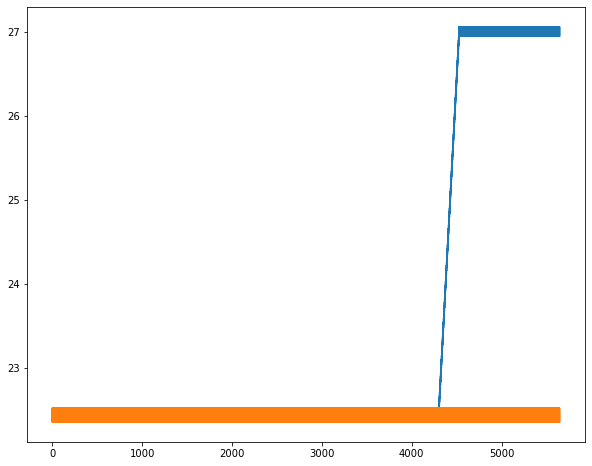

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[3:step,10]))
plt.plot((speed[3:step,11]))